# Exploration

## Préambule

- Importation des librairies

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging
import math
import csv
import os
import re

from IPython.display import display
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from scipy.stats import spearmanr
from tabulate import tabulate
from scipy import stats
from sklearn.preprocessing import LabelEncoder

- Configuration de la journalisation

In [6]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

## Chargement des données

In [8]:
# Détection du délimiteur utilisé dans chaque fichier CSV
def get_delimiter(file_path, bytes=4096):
    try:
        with open(file_path, 'r') as file:
            data = file.read(bytes)
        sniffer = csv.Sniffer()
        delimiter = sniffer.sniff(data).delimiter
        return delimiter
    except Exception as e:
        logging.error(f"Erreur lors de la détection du délimiteur: {e}")
        return None

# Lecture des fichiers CSV avec différents encodages
def read_csv_file(file_path):
    if not os.path.exists(file_path):
        return None, False, f"Fichier non trouvé: {file_path}"
    
    delimiter = get_delimiter(file_path)
    if not delimiter:
        return None, False, f"Impossible de détecter le délimiteur pour le fichier: {file_path}"
    
    encodings = ['utf-8', 'latin1', 'ISO-8859-1']
    for encoding in encodings:
        try:
            df = pd.read_csv(file_path, low_memory=False, encoding=encoding, delimiter=delimiter)
            return df, True, None
        except (UnicodeDecodeError, pd.errors.ParserError) as e:
            logging.warning(f"Erreur avec l'encodage {encoding} pour le fichier {file_path}: {e}")
    
    return None, False, f"Impossible de lire le fichier {file_path} avec les encodages: {encodings}."

# Chargement des datasets en fonction des préfixes et des années spécifiés
def load_datasets(prefixes, years, base_path='data/raw'):
    dataframes = []
    
    for prefix in prefixes:
        datasets = []
        for year in years:
            # Détermine le connecteur en fonction de l'année
            connector = '_' if year <= 2016 else '-'
            
            # Gestion de deux orthographes pour 'caracteristiques'
            if prefix == 'caracteristiques':
                # Essai avec 'caracteristiques'
                filename = f'caracteristiques{connector}{year}.csv'
                file_path = os.path.join(base_path, filename)
                if not os.path.exists(file_path):
                    # Si pas trouvé, essai avec 'carcteristiques'
                    filename = f'carcteristiques{connector}{year}.csv'
                    file_path = os.path.join(base_path, filename)
            else:
                filename = f'{prefix}{connector}{year}.csv'
                file_path = os.path.join(base_path, filename)
            
            if os.path.exists(file_path):
                df, success, error = read_csv_file(file_path)
                if success:
                    datasets.append({filename: df})
                else:
                    logging.error(error)
                    
        dataframes.append(datasets)
    
    return dataframes

# Spécification des années et des préfixes pour les fichiers CSV
years = list(range(2005, 2023))
prefixes = ['caracteristiques', 'lieux', 'usagers', 'vehicules']

# Chargement des datasets
dataframes = load_datasets(prefixes, years)

# Log des datasets chargés
for prefix, df_list in zip(prefixes, dataframes):
    logging.info(f'{prefix}: {len(df_list)} datasets chargés.')

logging.info(f'Total datasets chargés: {sum(len(dfs) for dfs in dataframes)}.')

2024-10-24 13:43:00,190 - WARNING - Erreur avec l'encodage utf-8 pour le fichier data/raw\caracteristiques_2005.csv: 'utf-8' codec can't decode byte 0xe9 in position 13: invalid continuation byte
2024-10-24 13:43:00,354 - WARNING - Erreur avec l'encodage utf-8 pour le fichier data/raw\caracteristiques_2006.csv: 'utf-8' codec can't decode byte 0xb0 in position 6: invalid start byte
2024-10-24 13:43:00,501 - WARNING - Erreur avec l'encodage utf-8 pour le fichier data/raw\caracteristiques_2007.csv: 'utf-8' codec can't decode byte 0xe9 in position 1: invalid continuation byte
2024-10-24 13:43:00,639 - WARNING - Erreur avec l'encodage utf-8 pour le fichier data/raw\caracteristiques_2008.csv: 'utf-8' codec can't decode byte 0xf4 in position 17: invalid continuation byte
2024-10-24 13:43:00,861 - WARNING - Erreur avec l'encodage utf-8 pour le fichier data/raw\caracteristiques_2010.csv: 'utf-8' codec can't decode byte 0xe9 in position 8: invalid continuation byte
2024-10-24 13:43:01,010 - WARN

## Analyse des données originales

* Exploration primaire des données brutes

In [11]:
# Extraction de l'année du nom de fichier CSV
def extract_year(file_name):
    match = re.search(r'(\d{4})\.csv$', file_name)
    return match.group(1) if match else None

# Analyse de chaque colonne des datasets
def analyze_column(column, datasets, total_rows):
    column_results = []
    
    for dataset in datasets:
        for file_name, df in dataset.items():
            if column in df.columns:
                col_type = df[column].dtype
                col_mode = df[column].mode()[0] if not df[column].mode().empty else "N/A"
                null_proportion_file = df[column].isnull().mean() * 100
                null_proportion_total = df[column].isnull().sum() / total_rows
                column_results.append([
                    extract_year(file_name), 
                    col_type, 
                    col_mode, 
                    null_proportion_file, 
                    null_proportion_total
                ])
    
    if column_results:
        print(f"\nColonne: {column} / lignes: {total_rows}")
        print(tabulate(column_results, headers=[
            "Année", "Type", "Mode", 
            "Proportion valeurs nulles (fichier)", 
            "Proportion valeurs nulles (total)"
        ]))

# Analyse de toutes les colonnes des datasets
def analyze_all_columns(datasets):
    all_columns = set()
    for dataset in datasets:
        for file_name, df in dataset.items():
            logging.info(f'Chargement de {file_name}.')
            all_columns.update(df.columns)
    
    total_rows = sum(df.shape[0] for dataset in datasets for file_name, df in dataset.items())

    # Traitement pour chaque colonne
    for column in all_columns:
        analyze_column(column, datasets, total_rows)

# Analyse des colonnes pour chaque ensemble de datasets
for datasets in dataframes:
    analyze_all_columns(datasets)

2024-10-24 13:43:06,615 - INFO - Chargement de caracteristiques_2005.csv.
2024-10-24 13:43:06,615 - INFO - Chargement de caracteristiques_2006.csv.
2024-10-24 13:43:06,615 - INFO - Chargement de caracteristiques_2007.csv.
2024-10-24 13:43:06,615 - INFO - Chargement de caracteristiques_2008.csv.
2024-10-24 13:43:06,615 - INFO - Chargement de caracteristiques_2009.csv.
2024-10-24 13:43:06,615 - INFO - Chargement de caracteristiques_2010.csv.
2024-10-24 13:43:06,615 - INFO - Chargement de caracteristiques_2011.csv.
2024-10-24 13:43:06,615 - INFO - Chargement de caracteristiques_2012.csv.
2024-10-24 13:43:06,615 - INFO - Chargement de caracteristiques_2013.csv.
2024-10-24 13:43:06,615 - INFO - Chargement de caracteristiques_2014.csv.
2024-10-24 13:43:06,615 - INFO - Chargement de caracteristiques_2015.csv.
2024-10-24 13:43:06,615 - INFO - Chargement de caracteristiques_2016.csv.
2024-10-24 13:43:06,630 - INFO - Chargement de caracteristiques-2017.csv.
2024-10-24 13:43:06,631 - INFO - Charg


Colonne: long / lignes: 1176873
  Année  Type     Mode               Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ---------------  -------------------------------------  -----------------------------------
   2005  float64  0.0                                           69.0403                            0.0510531
   2006  float64  0.0                                           70.7686                            0.049906
   2007  float64  0.0                                           71.9129                            0.0512366
   2008  float64  0.0                                           71.8056                            0.0468385
   2009  object   0                                             54.9813                            0.0347625
   2010  float64  0.0                                           54.5064                            0.0321326
   2011  float64  0.0                                           54.1748                       

2024-10-24 13:43:07,807 - INFO - Chargement de lieux_2005.csv.
2024-10-24 13:43:07,807 - INFO - Chargement de lieux_2006.csv.
2024-10-24 13:43:07,807 - INFO - Chargement de lieux_2007.csv.
2024-10-24 13:43:07,807 - INFO - Chargement de lieux_2008.csv.
2024-10-24 13:43:07,807 - INFO - Chargement de lieux_2009.csv.
2024-10-24 13:43:07,807 - INFO - Chargement de lieux_2010.csv.
2024-10-24 13:43:07,807 - INFO - Chargement de lieux_2011.csv.
2024-10-24 13:43:07,807 - INFO - Chargement de lieux_2012.csv.
2024-10-24 13:43:07,807 - INFO - Chargement de lieux_2013.csv.
2024-10-24 13:43:07,807 - INFO - Chargement de lieux_2014.csv.
2024-10-24 13:43:07,807 - INFO - Chargement de lieux_2015.csv.
2024-10-24 13:43:07,807 - INFO - Chargement de lieux_2016.csv.
2024-10-24 13:43:07,807 - INFO - Chargement de lieux-2017.csv.
2024-10-24 13:43:07,807 - INFO - Chargement de lieux-2018.csv.
2024-10-24 13:43:07,807 - INFO - Chargement de lieux-2019.csv.
2024-10-24 13:43:07,822 - INFO - Chargement de lieux-20


Colonne: com / lignes: 1176873
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  float64      55                             0.00229816                          1.69942e-06
   2006  int64        55                             0                                   0
   2007  int64        55                             0                                   0
   2008  int64        55                             0                                   0
   2009  int64        88                             0                                   0
   2010  int64        55                             0                                   0
   2011  int64        55                             0                                   0
   2012  int64        55                             0                                   0
   2013  int64        55    

2024-10-24 13:43:08,458 - INFO - Chargement de usagers_2005.csv.
2024-10-24 13:43:08,458 - INFO - Chargement de usagers_2006.csv.
2024-10-24 13:43:08,460 - INFO - Chargement de usagers_2007.csv.
2024-10-24 13:43:08,461 - INFO - Chargement de usagers_2008.csv.
2024-10-24 13:43:08,462 - INFO - Chargement de usagers_2009.csv.
2024-10-24 13:43:08,463 - INFO - Chargement de usagers_2010.csv.
2024-10-24 13:43:08,464 - INFO - Chargement de usagers_2011.csv.
2024-10-24 13:43:08,466 - INFO - Chargement de usagers_2012.csv.
2024-10-24 13:43:08,466 - INFO - Chargement de usagers_2013.csv.
2024-10-24 13:43:08,467 - INFO - Chargement de usagers_2014.csv.
2024-10-24 13:43:08,468 - INFO - Chargement de usagers_2015.csv.
2024-10-24 13:43:08,469 - INFO - Chargement de usagers_2016.csv.
2024-10-24 13:43:08,469 - INFO - Chargement de usagers-2017.csv.
2024-10-24 13:43:08,470 - INFO - Chargement de usagers-2018.csv.
2024-10-24 13:43:08,471 - INFO - Chargement de usagers-2019.csv.
2024-10-24 13:43:08,472 -


Colonne: vosp / lignes: 1176873
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         0                               0                                 0
   2006  int64         0                               0                                 0
   2007  int64         0                               0                                 0
   2008  int64         0                               0                                 0
   2009  float64       0                               0.346732                          0.000219225
   2010  float64       0                               0.159991                          9.43177e-05
   2011  float64       0                               0.274733                          0.000156347
   2012  float64       0                               0.514056                          0.0002719

2024-10-24 13:43:09,822 - INFO - Chargement de vehicules_2005.csv.
2024-10-24 13:43:09,822 - INFO - Chargement de vehicules_2006.csv.
2024-10-24 13:43:09,822 - INFO - Chargement de vehicules_2007.csv.
2024-10-24 13:43:09,822 - INFO - Chargement de vehicules_2008.csv.
2024-10-24 13:43:09,822 - INFO - Chargement de vehicules_2009.csv.
2024-10-24 13:43:09,822 - INFO - Chargement de vehicules_2010.csv.
2024-10-24 13:43:09,838 - INFO - Chargement de vehicules_2011.csv.
2024-10-24 13:43:09,838 - INFO - Chargement de vehicules_2012.csv.
2024-10-24 13:43:09,838 - INFO - Chargement de vehicules_2013.csv.
2024-10-24 13:43:09,838 - INFO - Chargement de vehicules_2014.csv.
2024-10-24 13:43:09,838 - INFO - Chargement de vehicules_2015.csv.
2024-10-24 13:43:09,838 - INFO - Chargement de vehicules_2016.csv.
2024-10-24 13:43:09,838 - INFO - Chargement de vehicules-2017.csv.
2024-10-24 13:43:09,838 - INFO - Chargement de vehicules-2018.csv.
2024-10-24 13:43:09,838 - INFO - Chargement de vehicules-2019.


Colonne: trajet / lignes: 2636377
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         5                             0                                   0
   2006  int64         5                             0                                   0
   2007  int64         0                             0                                   0
   2008  int64         0                             0                                   0
   2009  float64       5                             0.0584471                           3.67929e-05
   2010  float64       5                             0.0447494                           2.61723e-05
   2011  float64       5                             0.0417388                           2.35171e-05
   2012  float64       5                             0.0418386                           2.19999

* Visualisation graphique des données brutes

2024-10-24 13:43:10,823 - INFO - Chargement de caracteristiques_2005.csv.
2024-10-24 13:43:10,823 - INFO - Chargement de caracteristiques_2006.csv.
2024-10-24 13:43:10,823 - INFO - Chargement de caracteristiques_2007.csv.
2024-10-24 13:43:10,823 - INFO - Chargement de caracteristiques_2008.csv.
2024-10-24 13:43:10,823 - INFO - Chargement de caracteristiques_2009.csv.
2024-10-24 13:43:10,823 - INFO - Chargement de caracteristiques_2010.csv.
2024-10-24 13:43:10,823 - INFO - Chargement de caracteristiques_2011.csv.
2024-10-24 13:43:10,823 - INFO - Chargement de caracteristiques_2012.csv.
2024-10-24 13:43:10,823 - INFO - Chargement de caracteristiques_2013.csv.
2024-10-24 13:43:10,823 - INFO - Chargement de caracteristiques_2014.csv.
2024-10-24 13:43:10,839 - INFO - Chargement de caracteristiques_2015.csv.
2024-10-24 13:43:10,839 - INFO - Chargement de caracteristiques_2016.csv.
2024-10-24 13:43:10,839 - INFO - Chargement de caracteristiques-2017.csv.
2024-10-24 13:43:10,839 - INFO - Charg

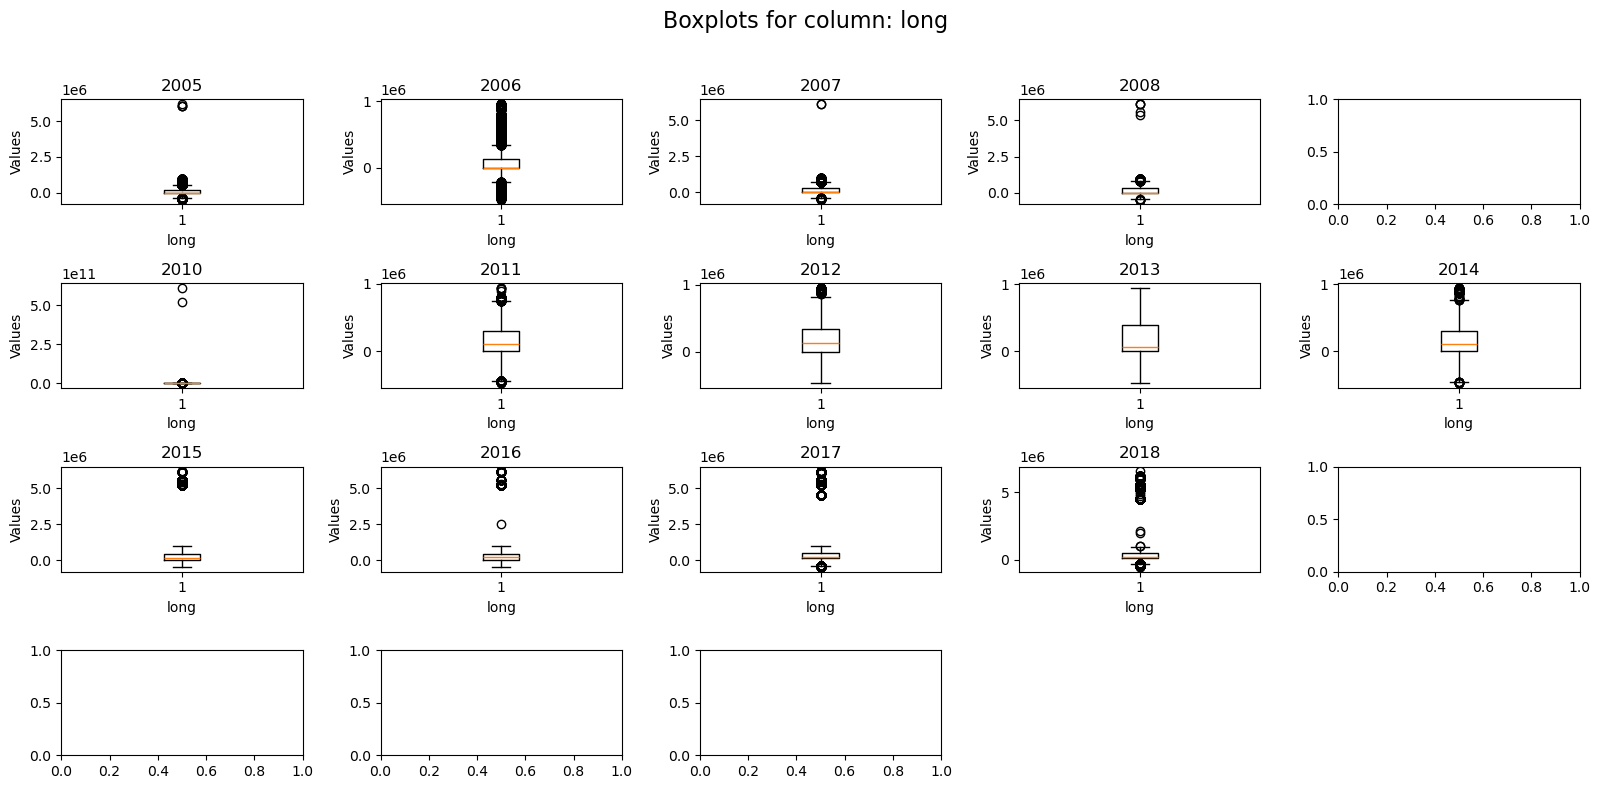

2024-10-24 13:43:12,209 - WARNING - Le nombre de modalités uniques dans la colonne long excède le seuil de 50. Aucun bar plot généré.
2024-10-24 13:43:12,382 - WARNING - Le nombre de modalités uniques dans la colonne long excède le seuil de 12. Aucun graphique en ligne généré.


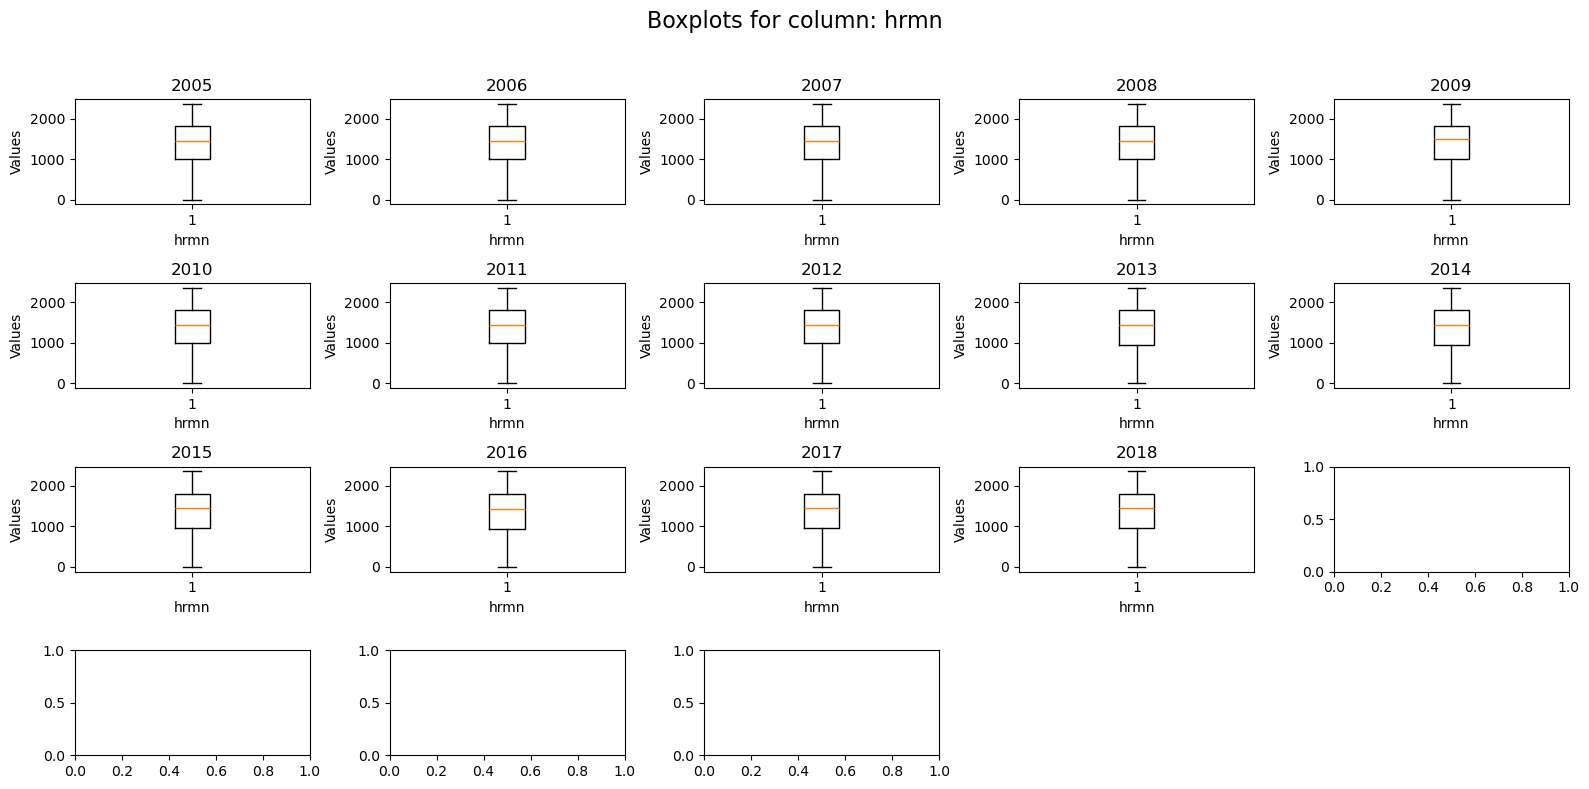

2024-10-24 13:43:13,372 - WARNING - Le nombre de modalités uniques dans la colonne hrmn excède le seuil de 50. Aucun bar plot généré.
2024-10-24 13:43:13,388 - WARNING - Le nombre de modalités uniques dans la colonne hrmn excède le seuil de 12. Aucun graphique en ligne généré.
2024-10-24 13:43:13,388 - INFO - La colonne adr n'est pas numérique.
2024-10-24 13:43:13,687 - WARNING - Le nombre de modalités uniques dans la colonne adr excède le seuil de 50. Aucun bar plot généré.
2024-10-24 13:43:13,994 - WARNING - Le nombre de modalités uniques dans la colonne adr excède le seuil de 12. Aucun graphique en ligne généré.


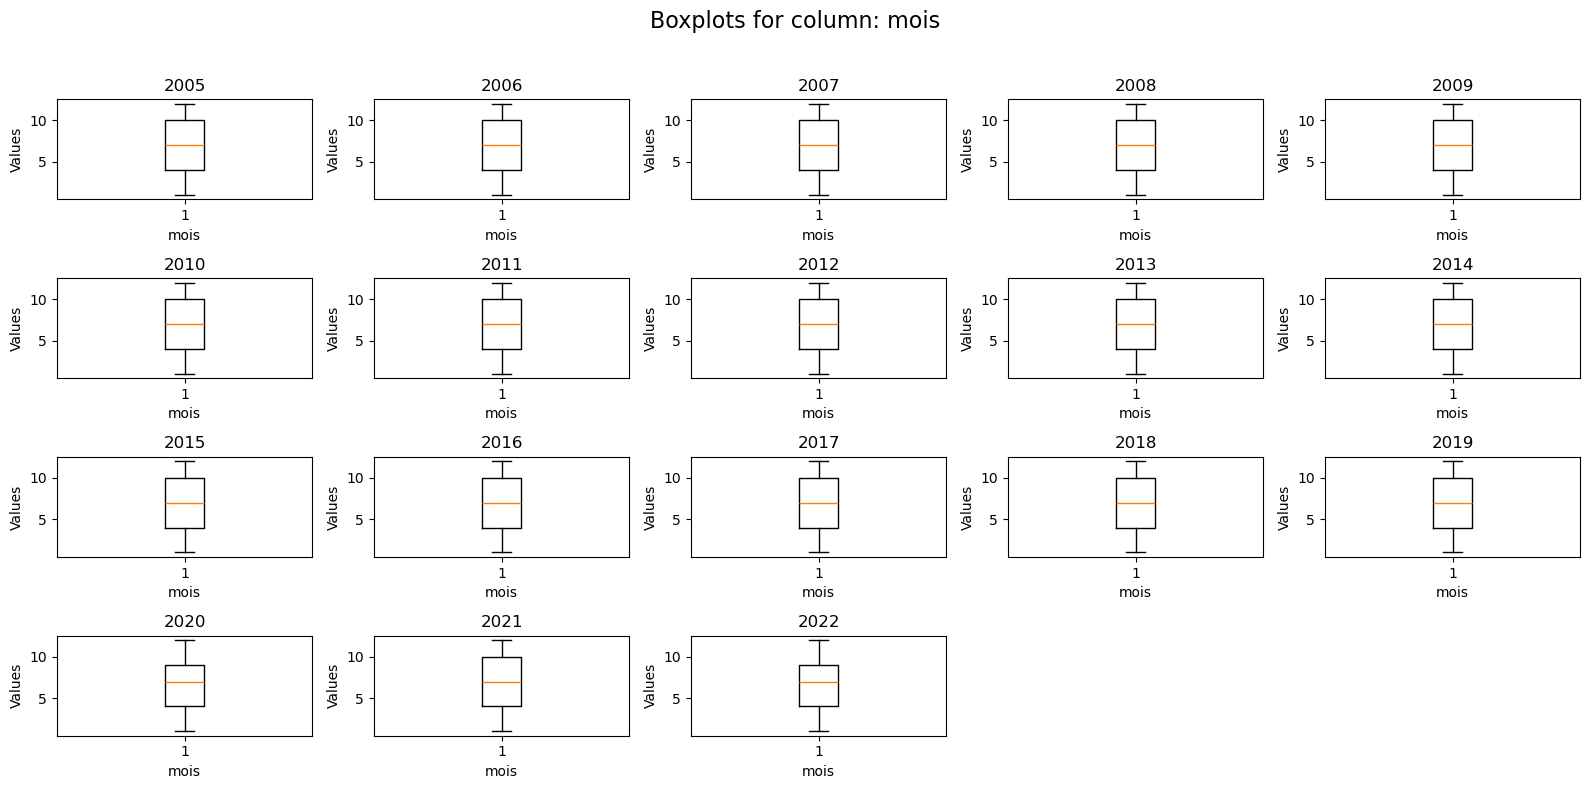

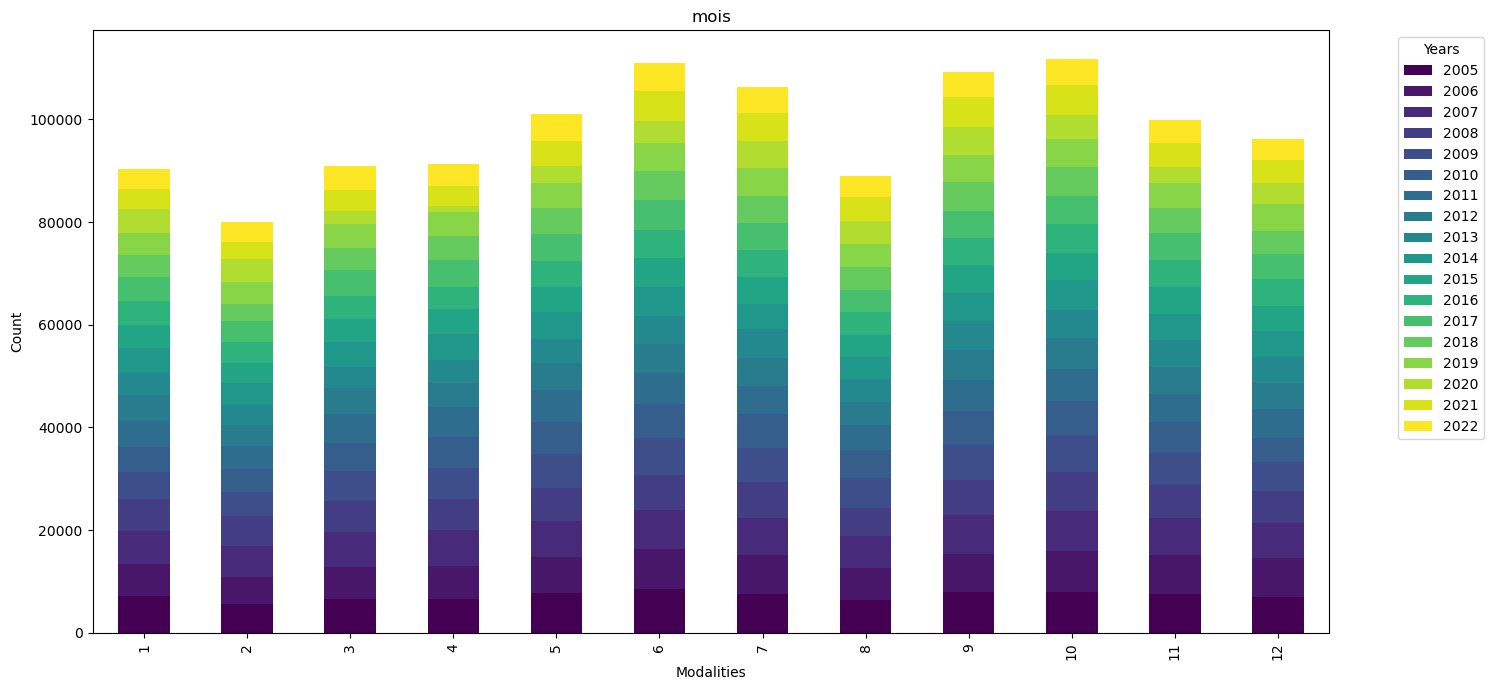

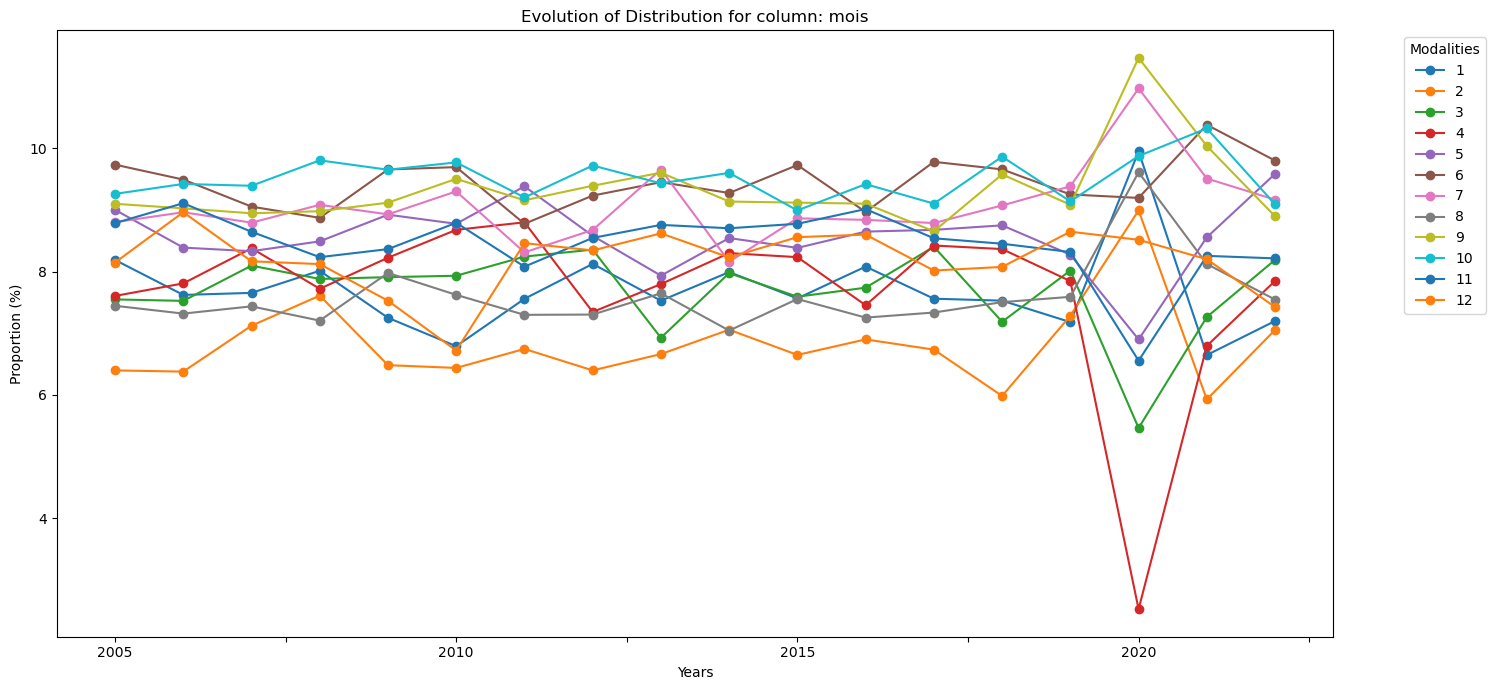

2024-10-24 13:43:15,705 - INFO - La colonne gps n'est pas numérique.


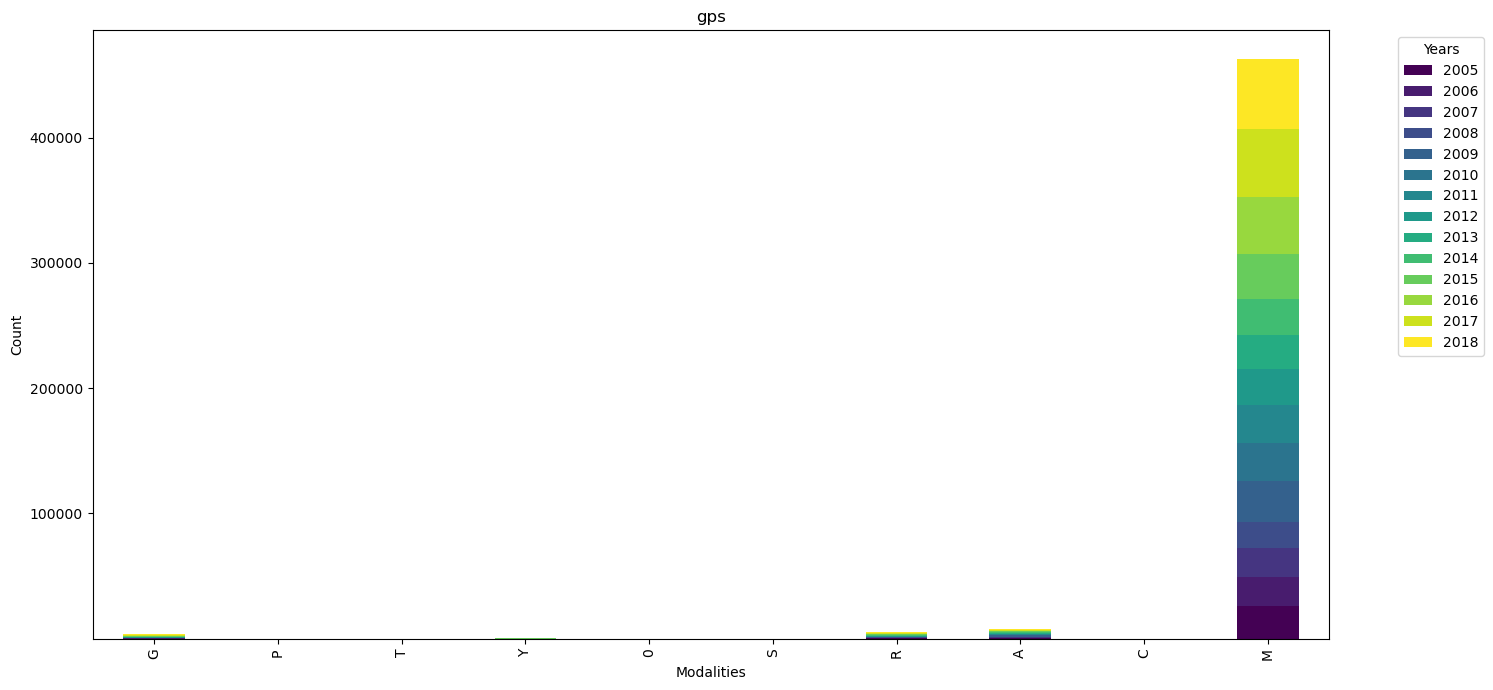

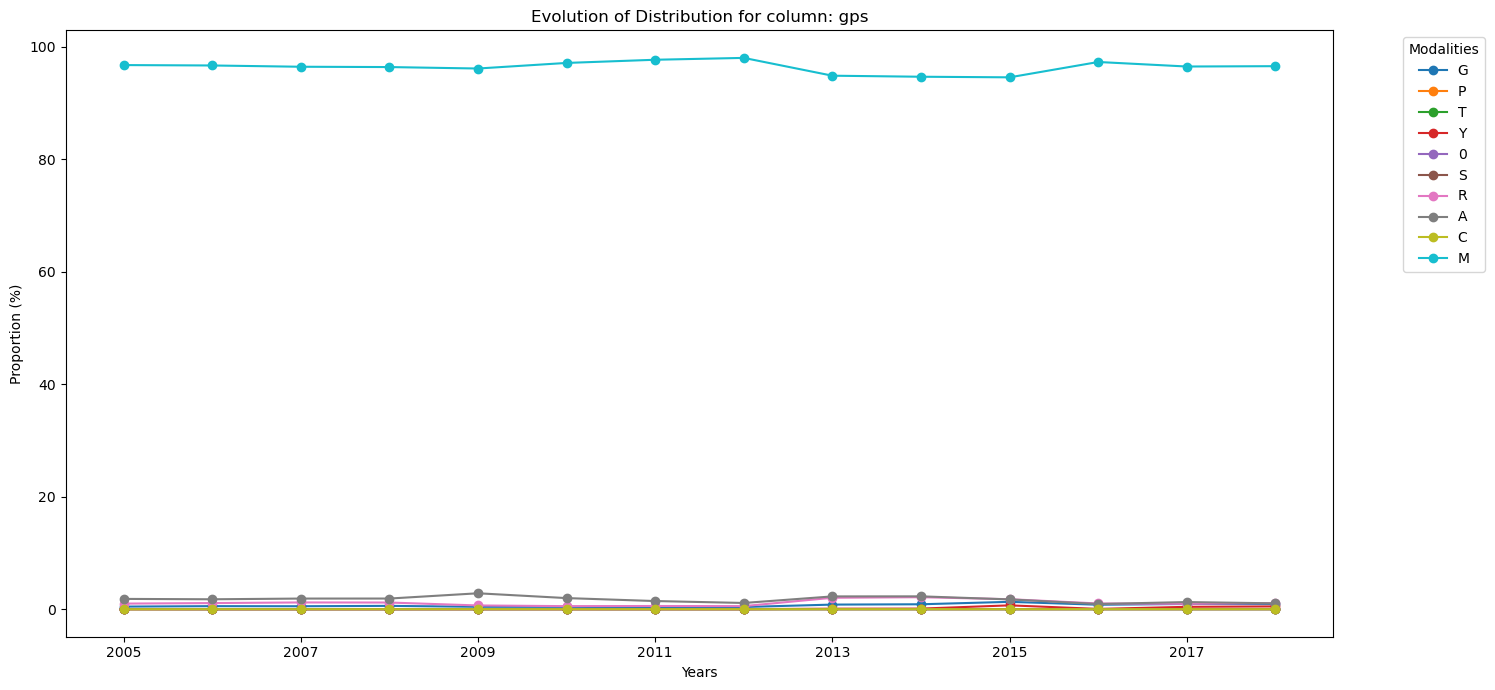

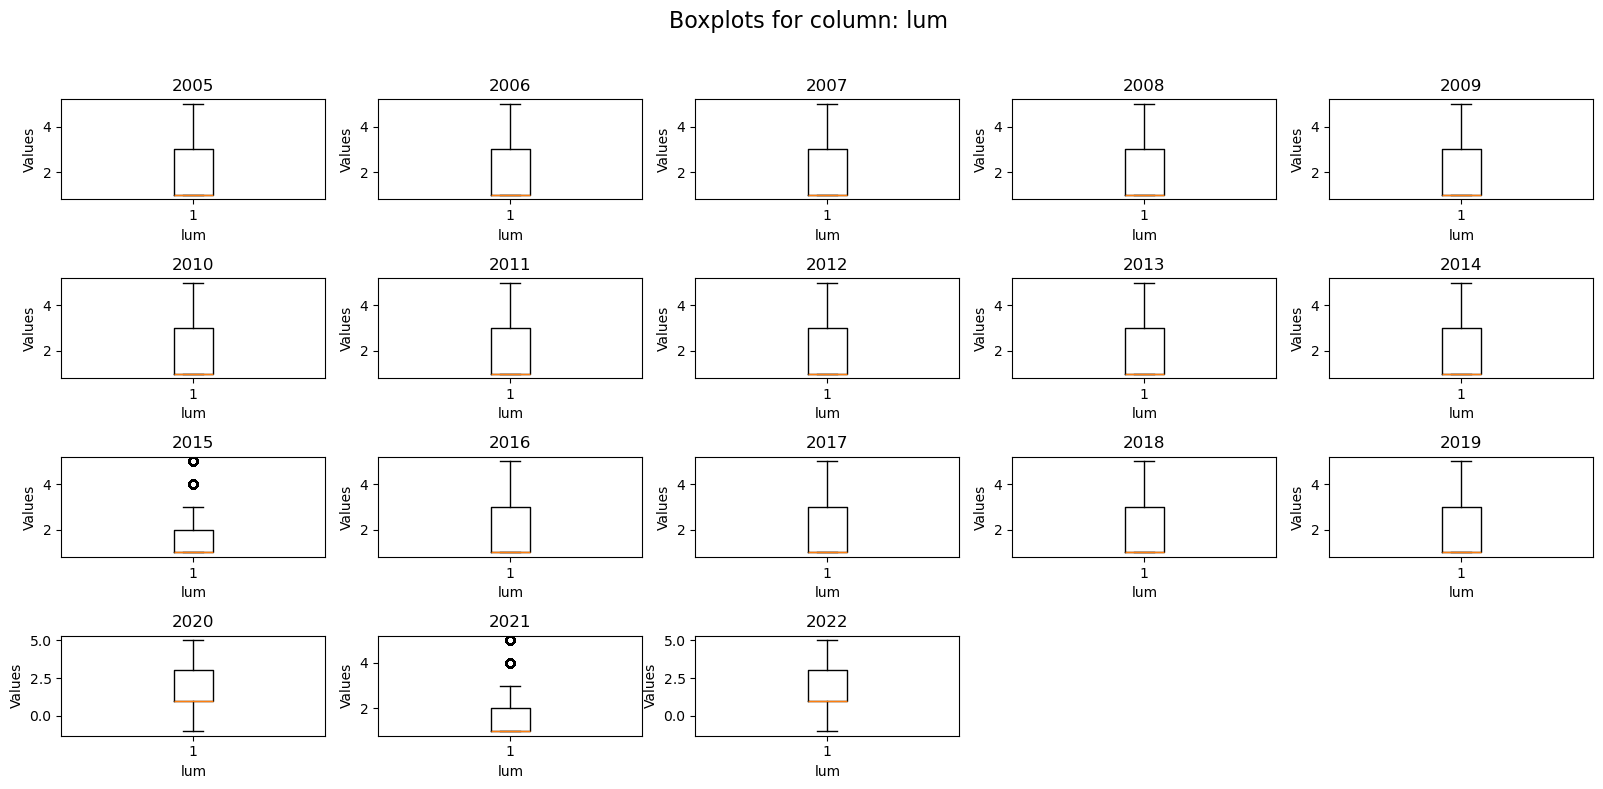

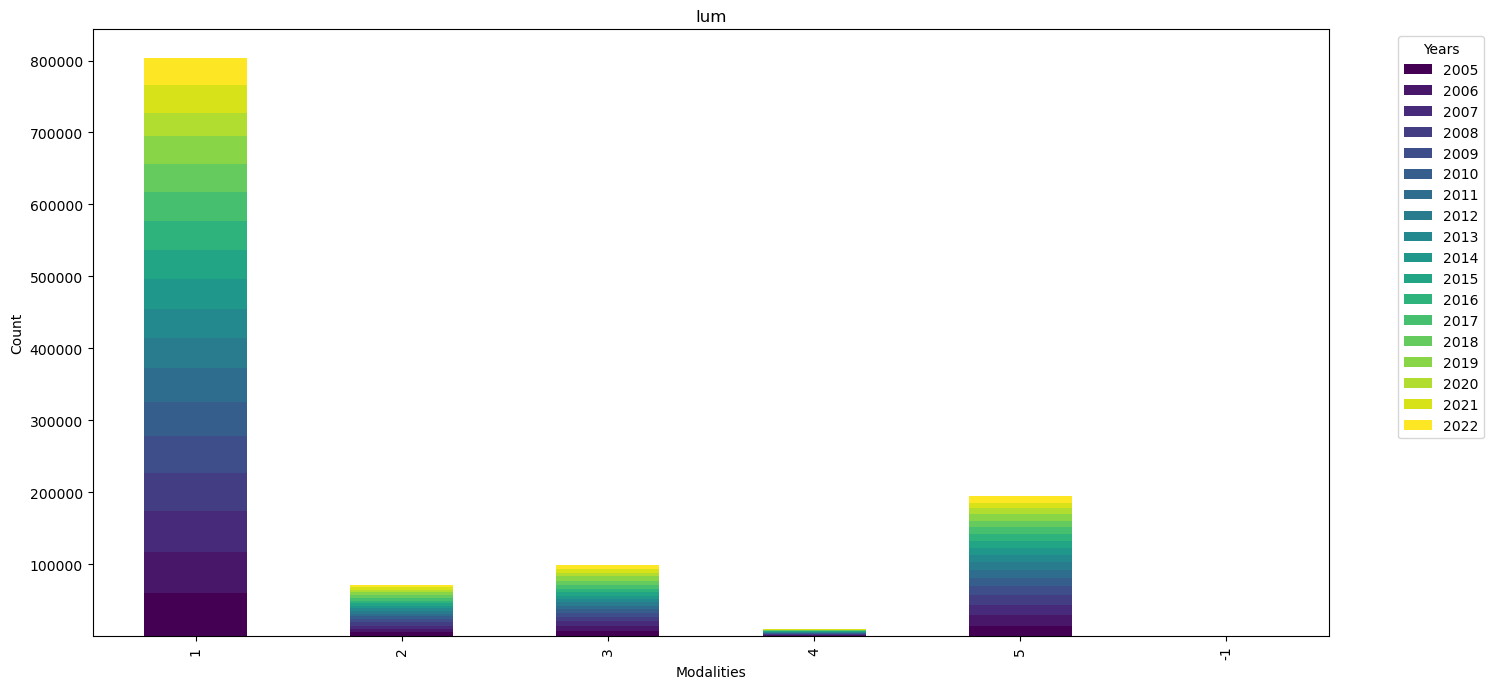

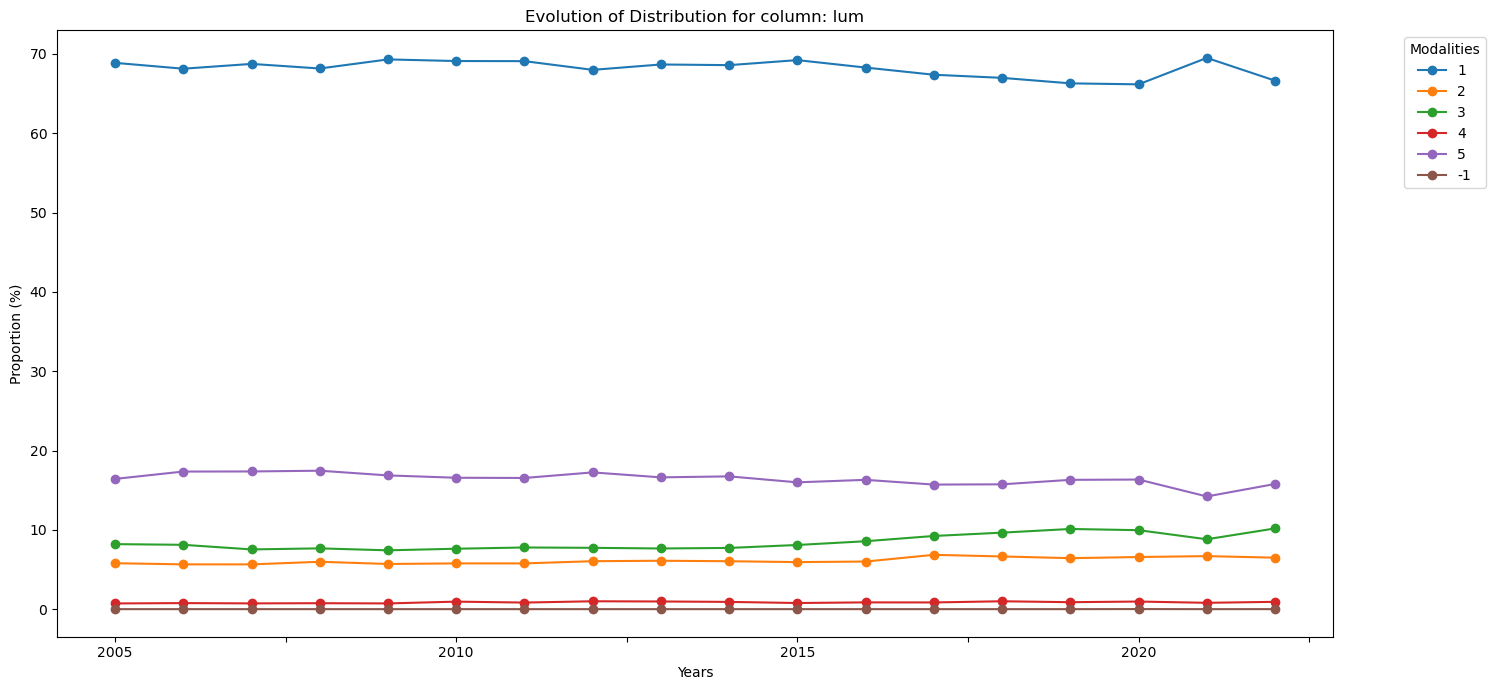

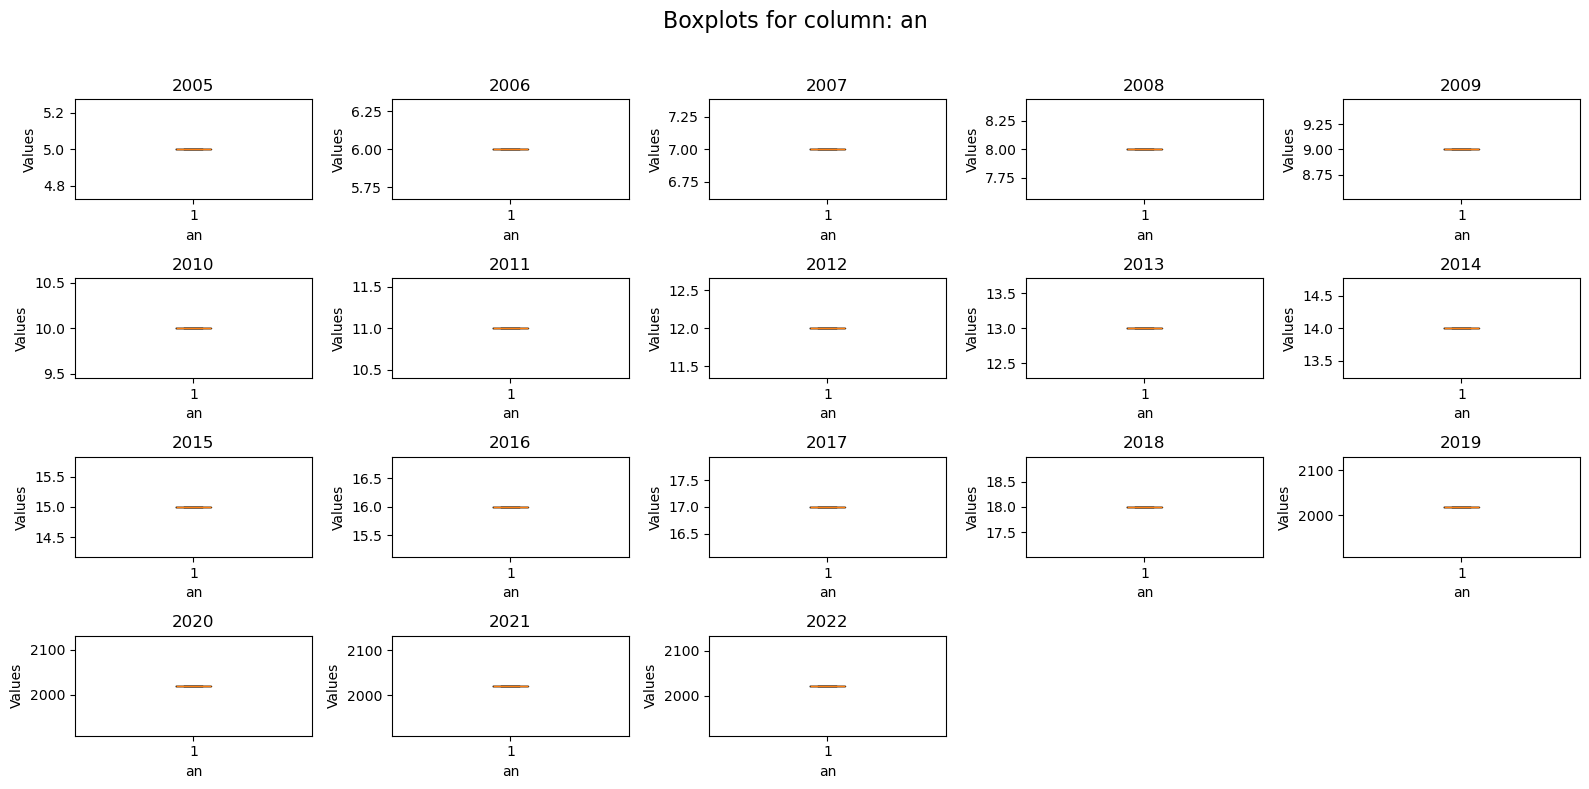

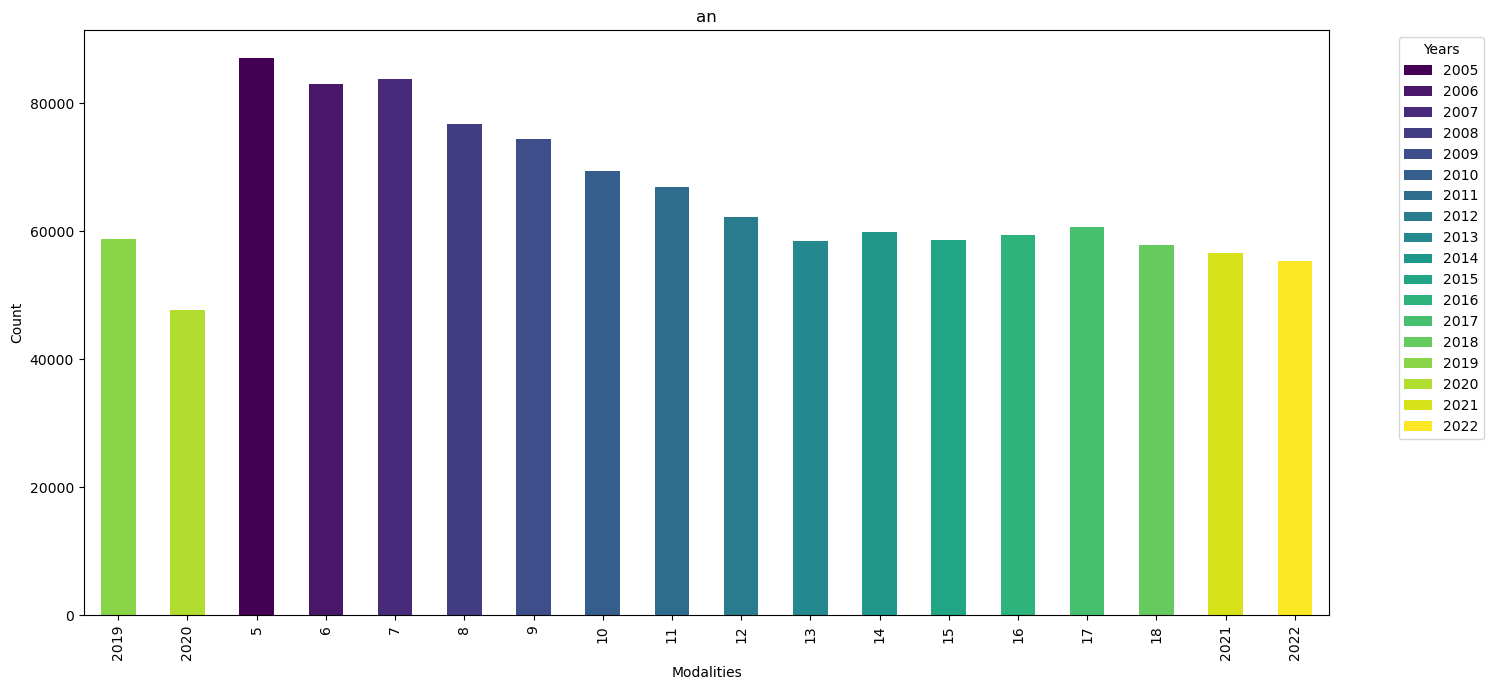

2024-10-24 13:43:19,025 - WARNING - Le nombre de modalités uniques dans la colonne an excède le seuil de 12. Aucun graphique en ligne généré.


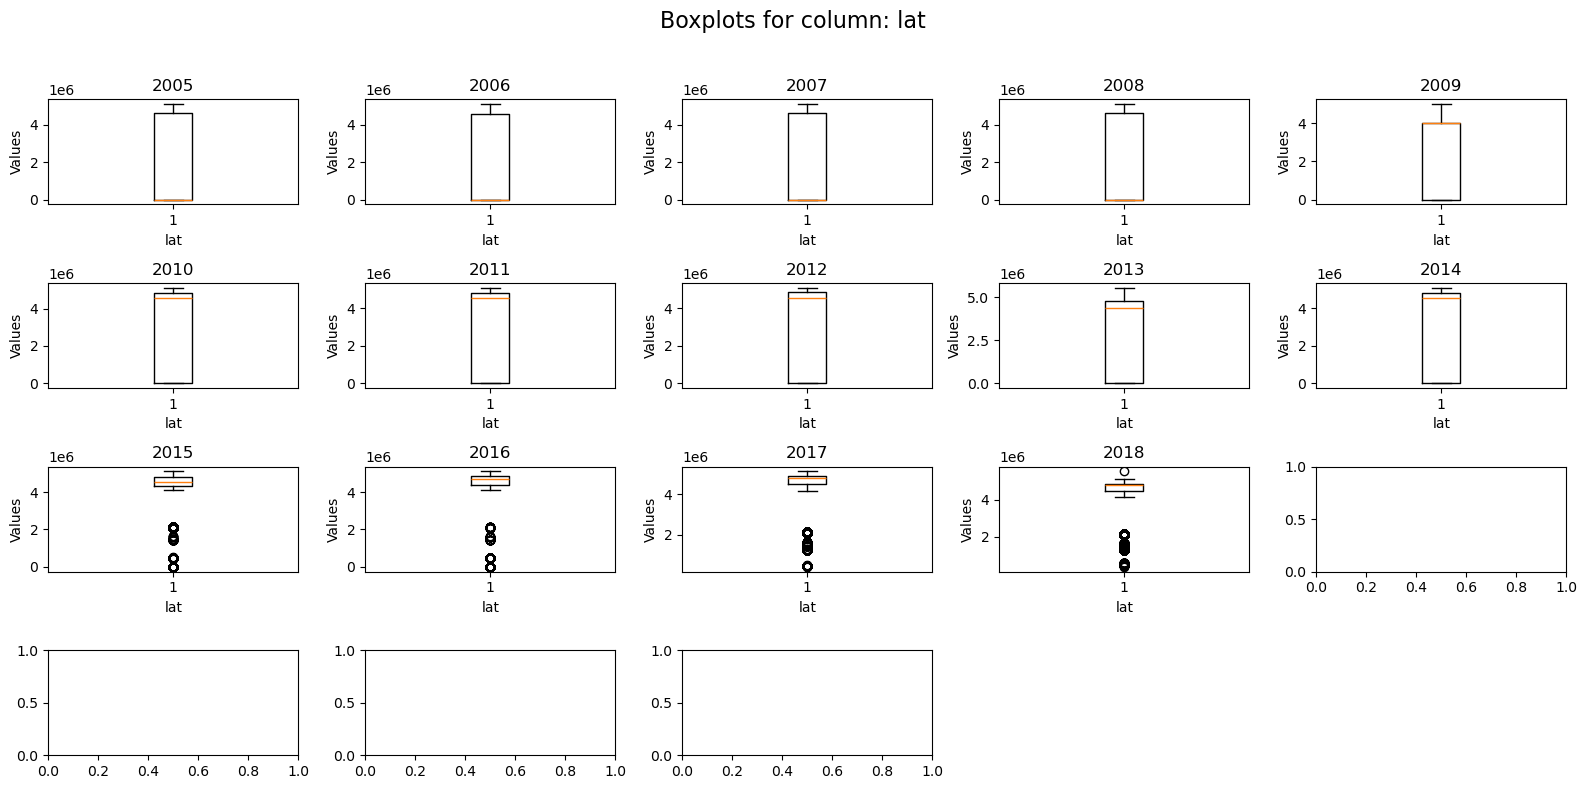

2024-10-24 13:43:20,332 - WARNING - Le nombre de modalités uniques dans la colonne lat excède le seuil de 50. Aucun bar plot généré.
2024-10-24 13:43:20,504 - WARNING - Le nombre de modalités uniques dans la colonne lat excède le seuil de 12. Aucun graphique en ligne généré.


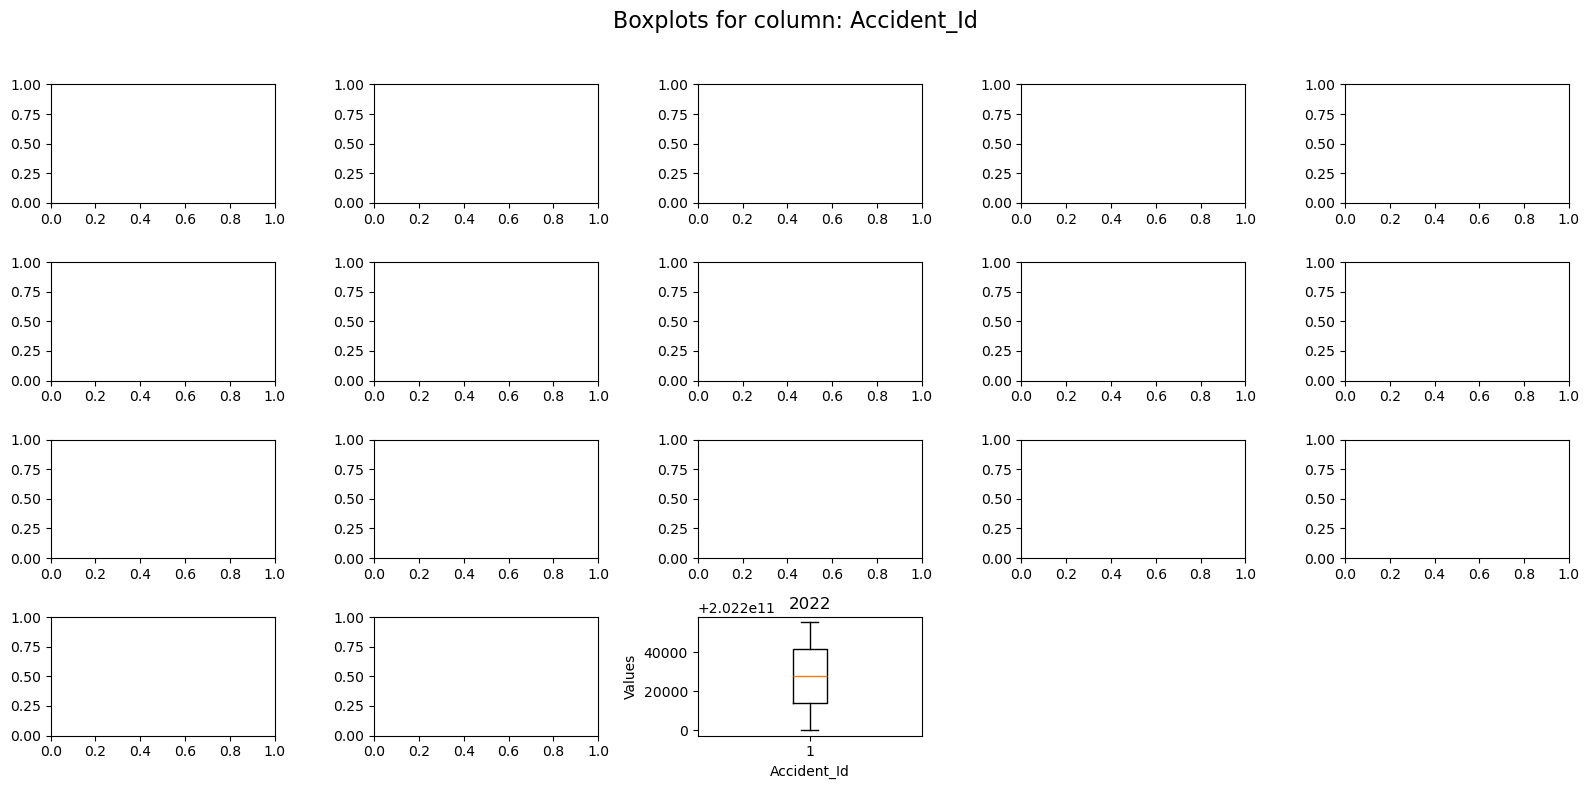

2024-10-24 13:43:21,709 - WARNING - Le nombre de modalités uniques dans la colonne Accident_Id excède le seuil de 50. Aucun bar plot généré.
2024-10-24 13:43:21,725 - WARNING - Le nombre de modalités uniques dans la colonne Accident_Id excède le seuil de 12. Aucun graphique en ligne généré.


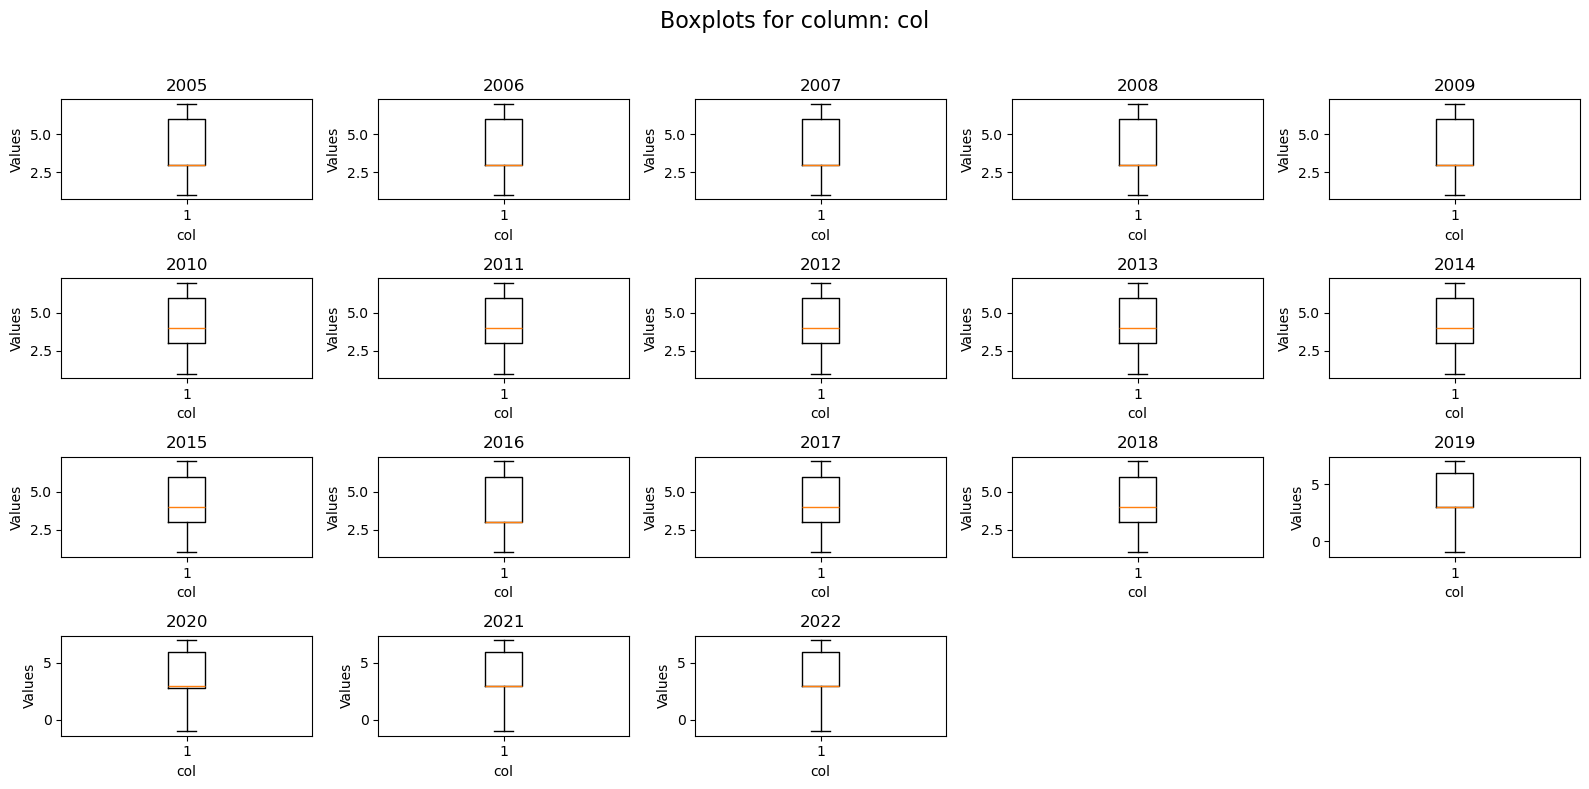

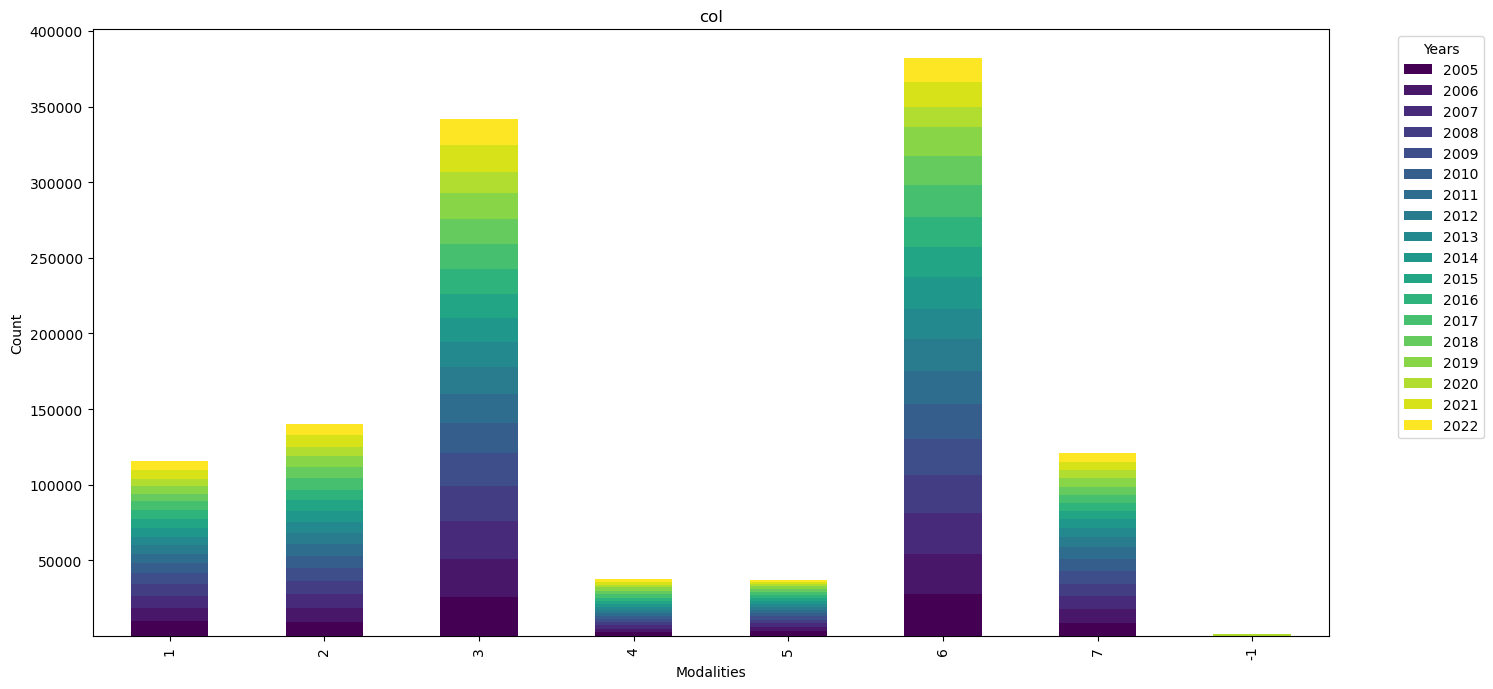

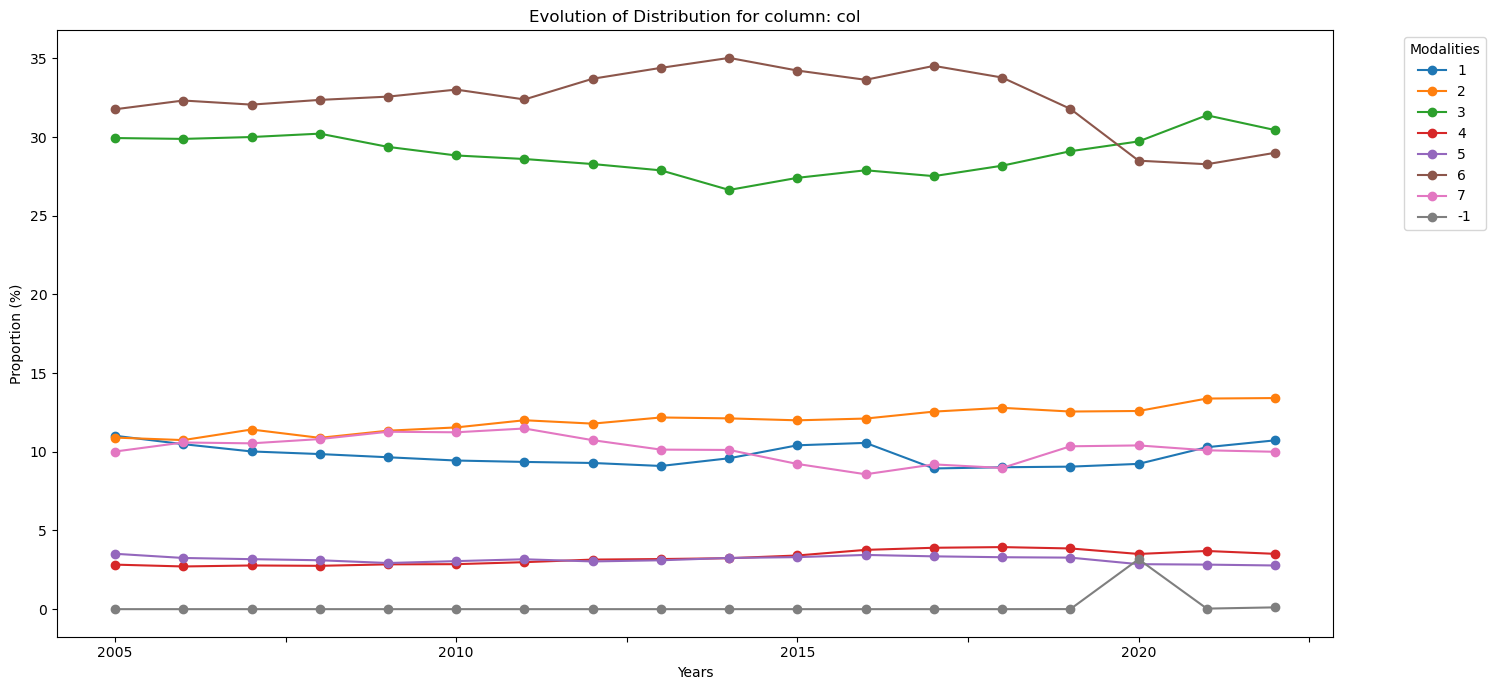

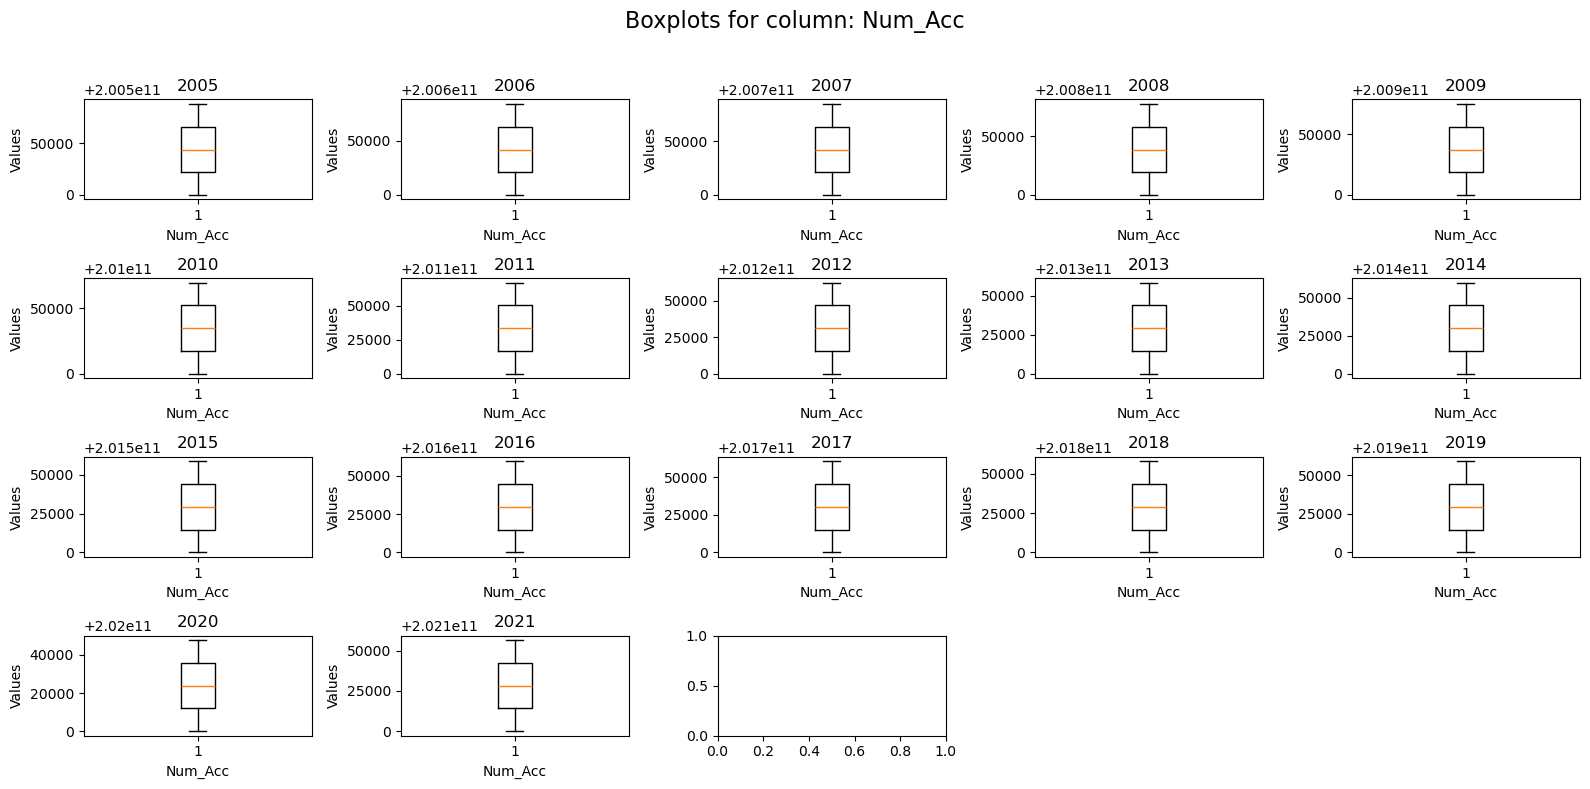

2024-10-24 13:43:24,738 - WARNING - Le nombre de modalités uniques dans la colonne Num_Acc excède le seuil de 50. Aucun bar plot généré.
2024-10-24 13:43:24,925 - WARNING - Le nombre de modalités uniques dans la colonne Num_Acc excède le seuil de 12. Aucun graphique en ligne généré.


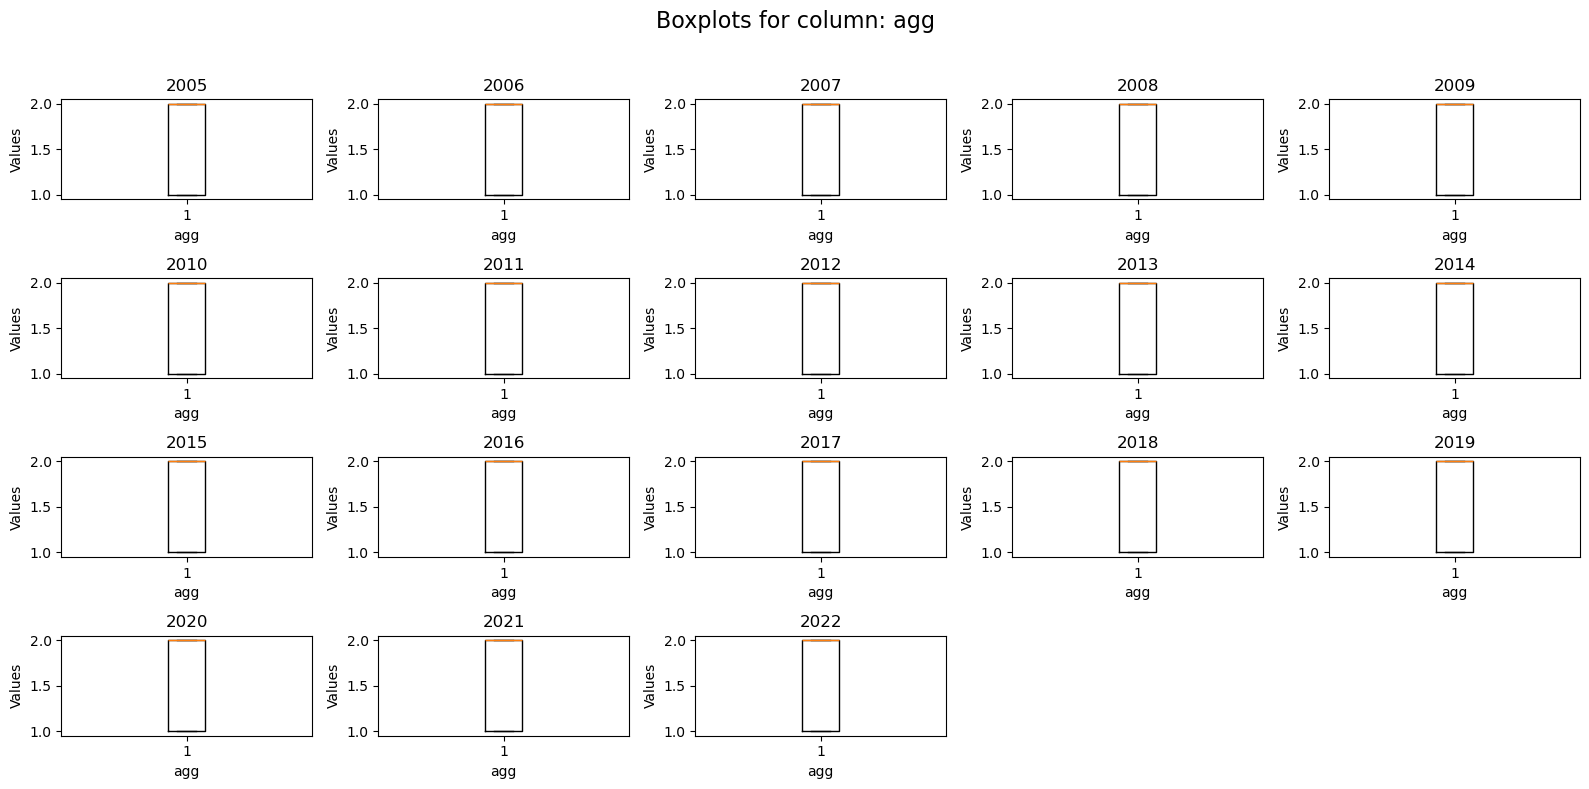

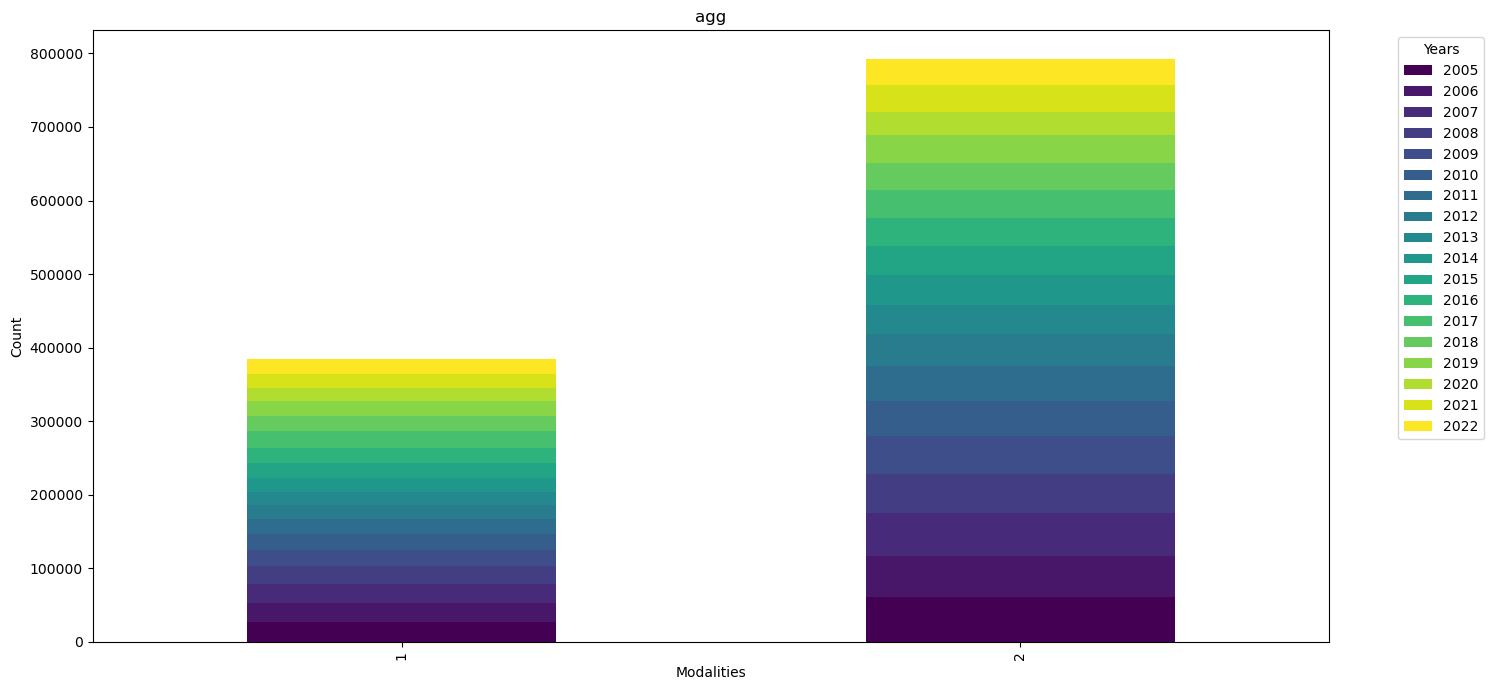

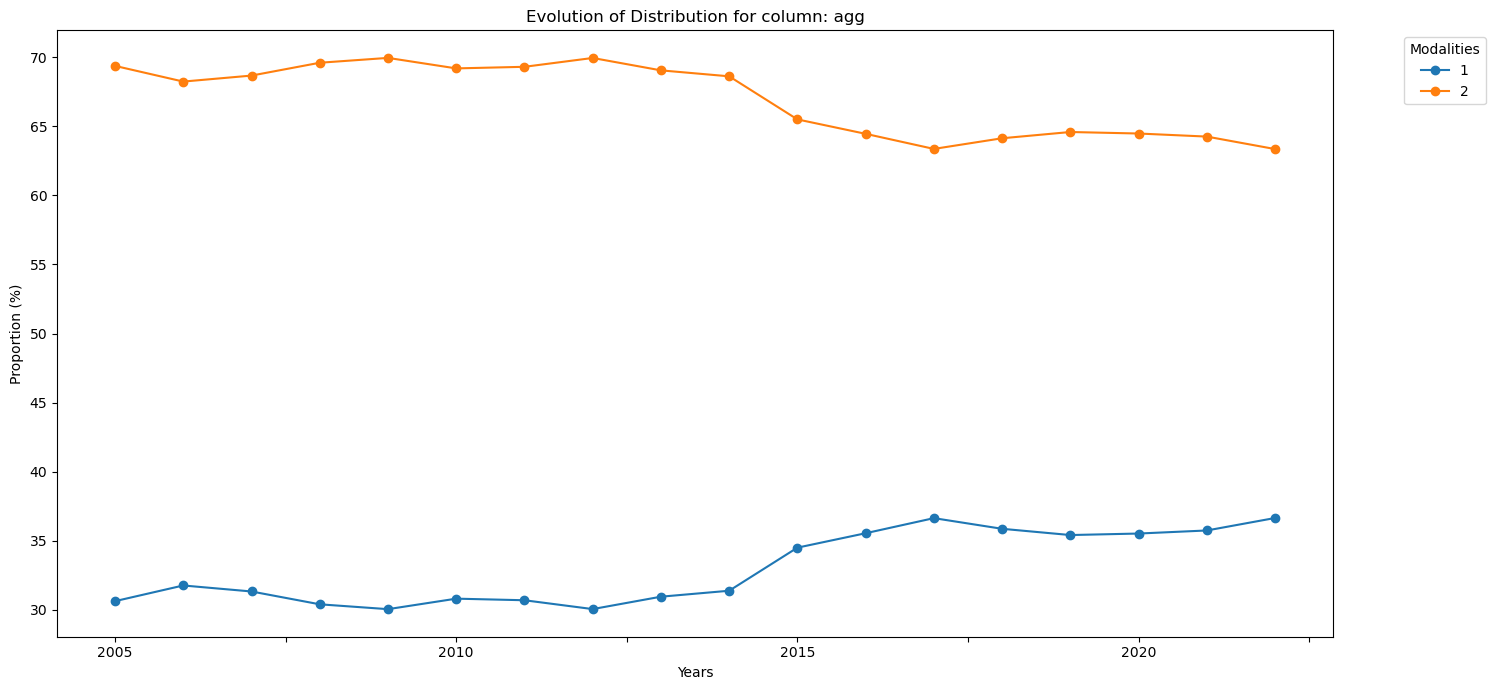

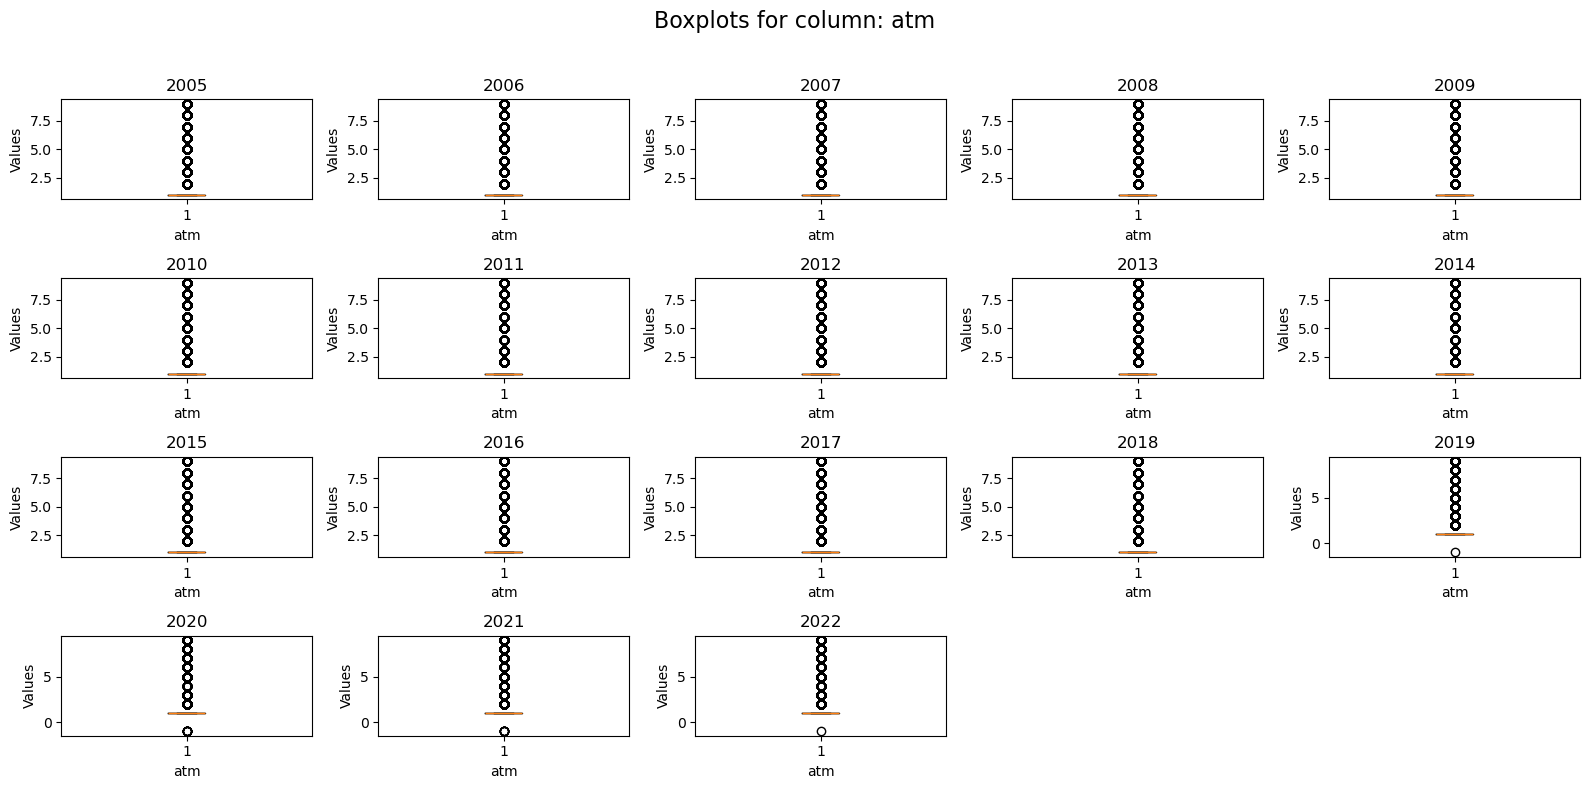

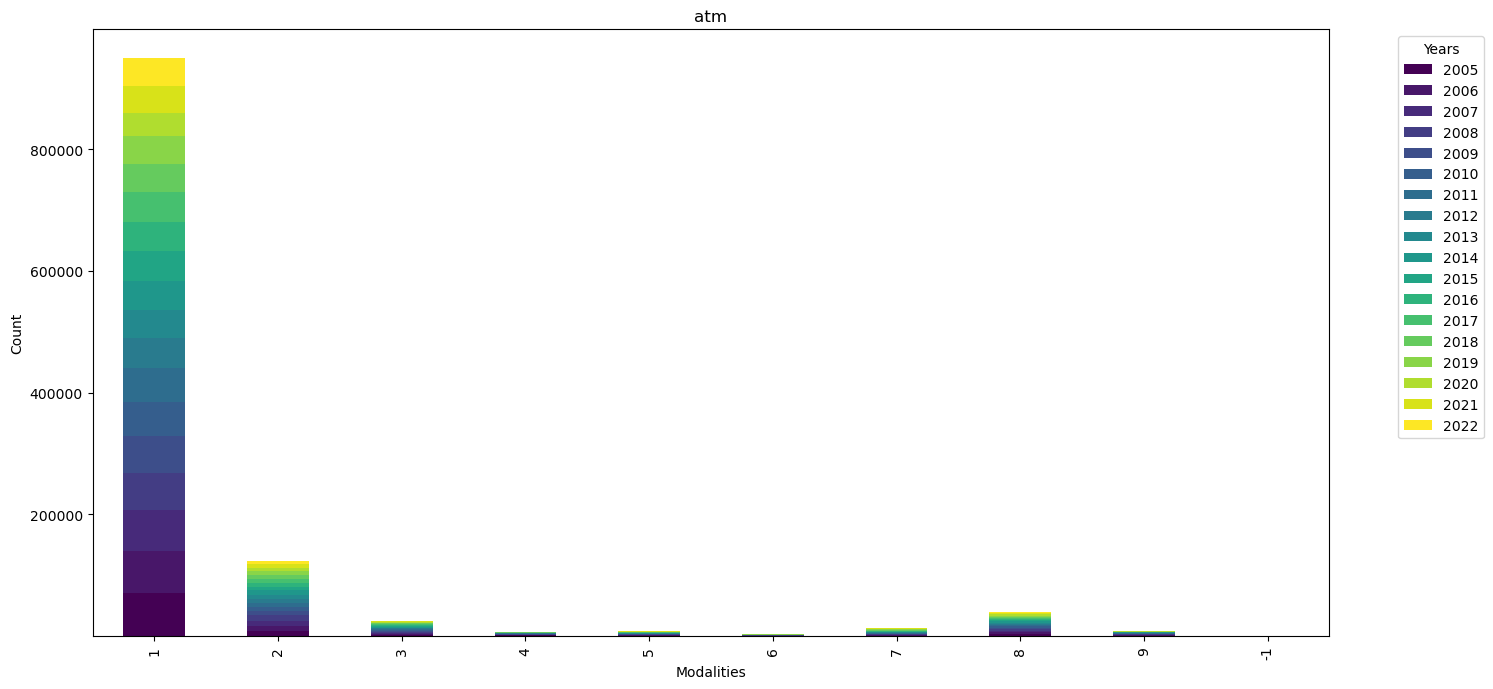

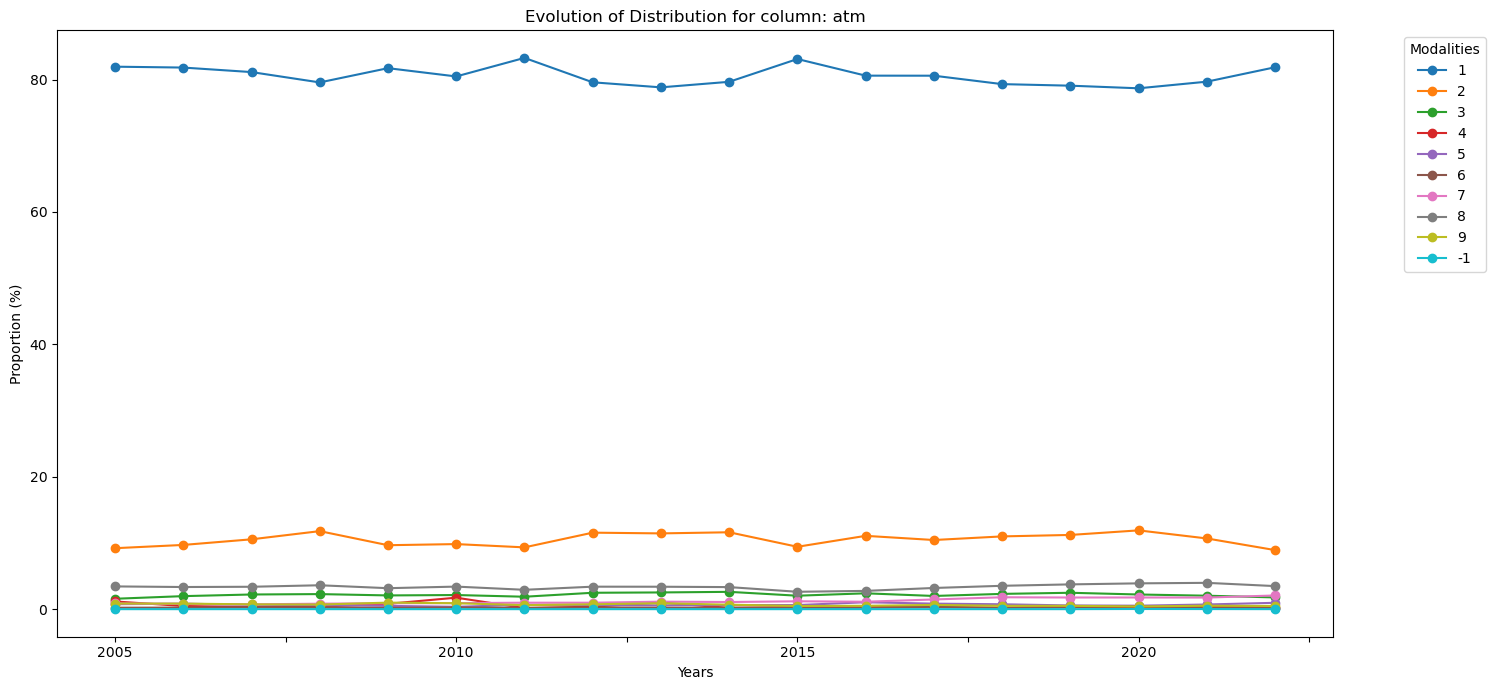

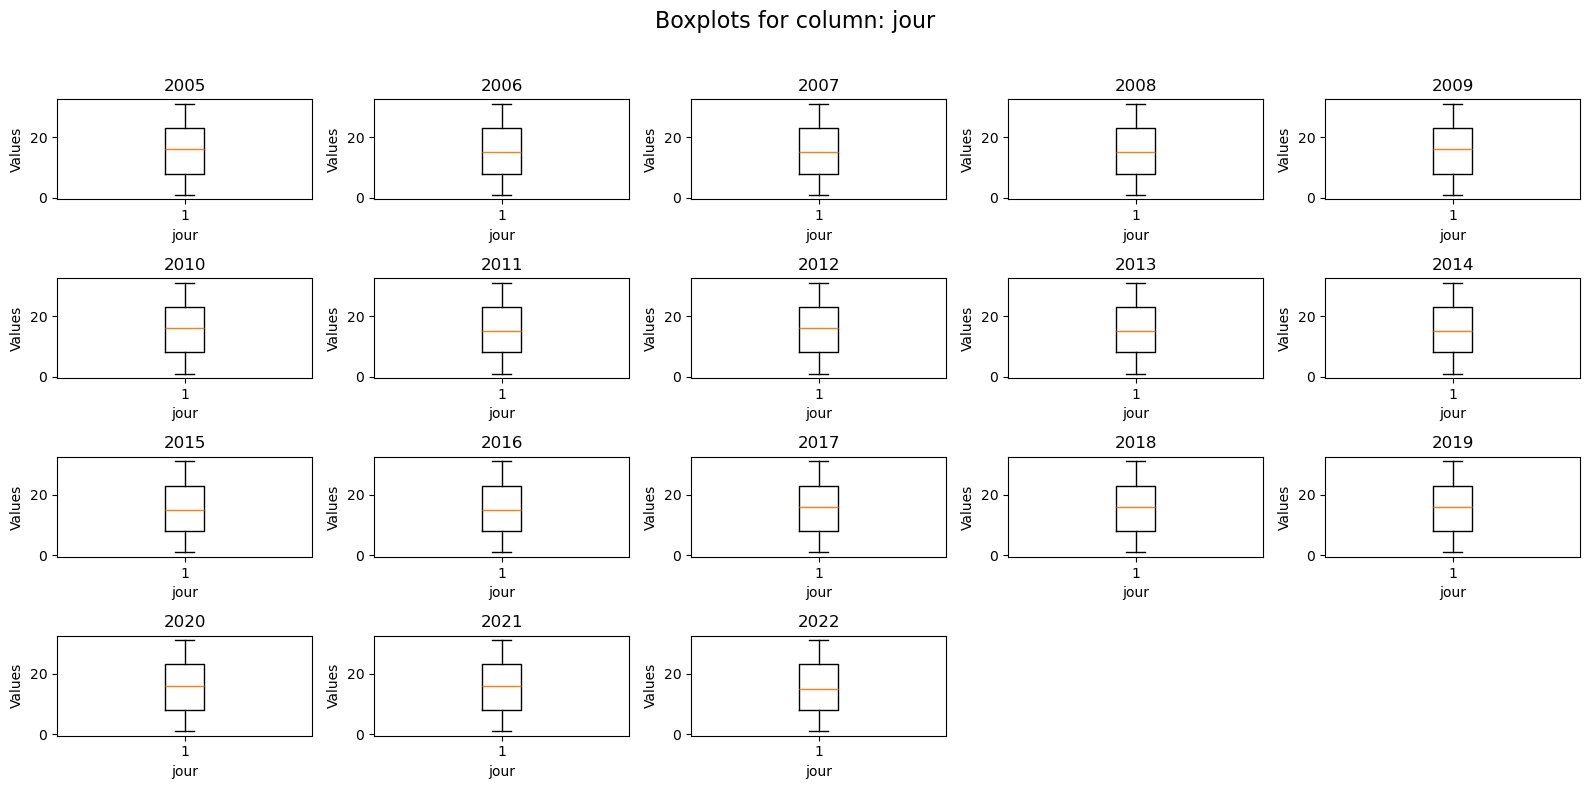

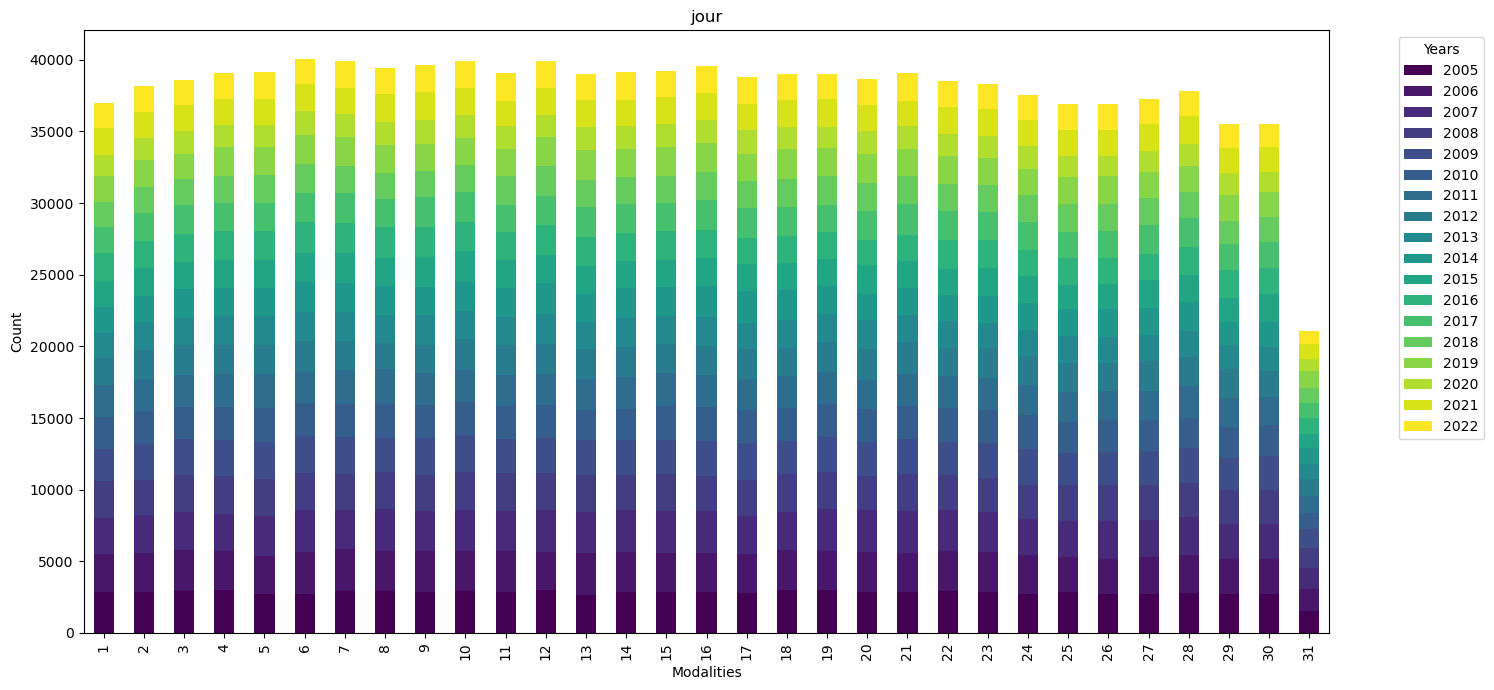

2024-10-24 13:43:29,944 - WARNING - Le nombre de modalités uniques dans la colonne jour excède le seuil de 12. Aucun graphique en ligne généré.


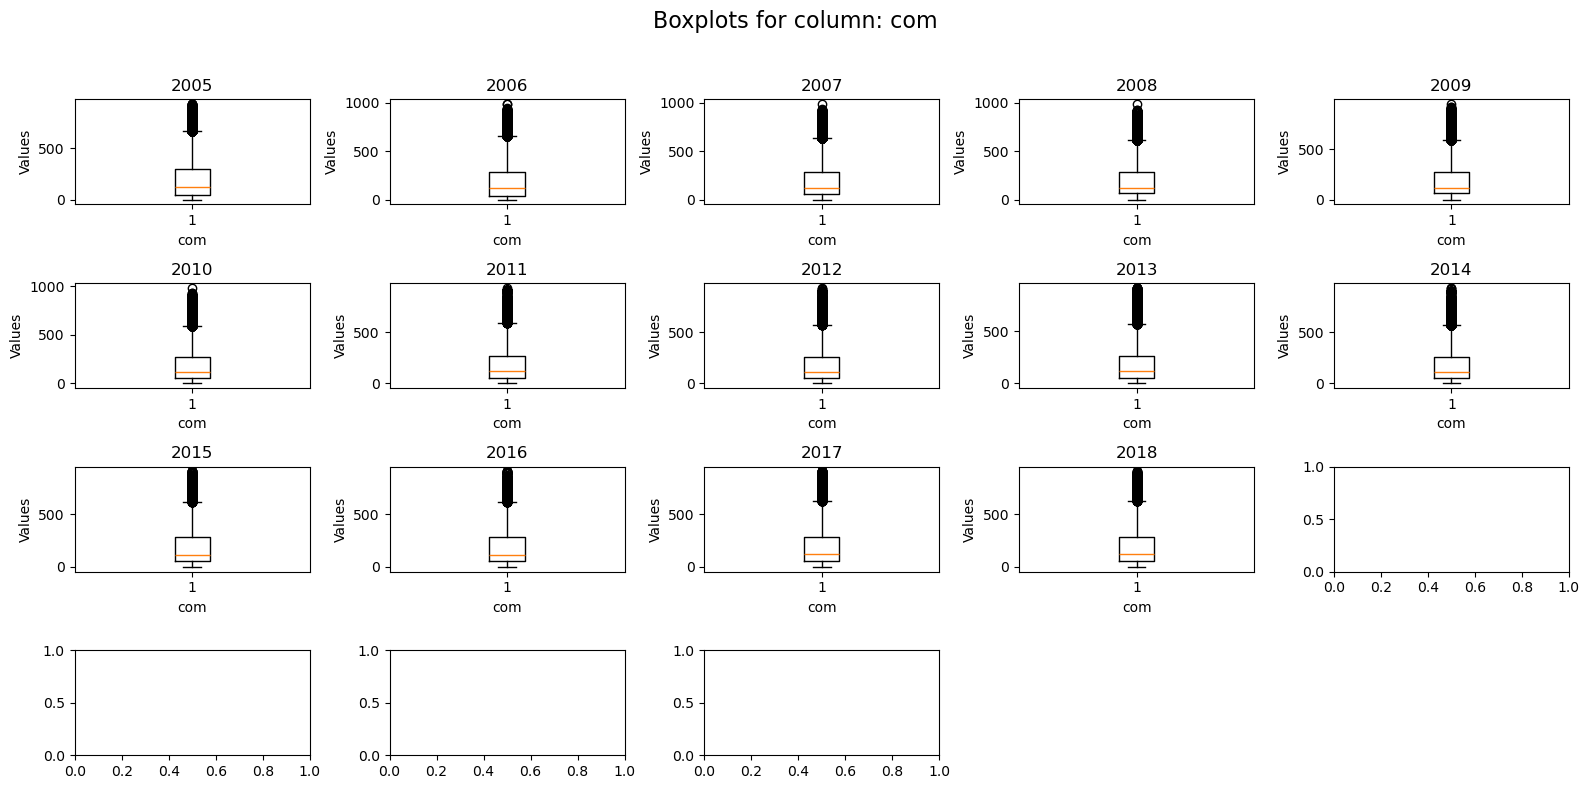

2024-10-24 13:43:30,991 - WARNING - Le nombre de modalités uniques dans la colonne com excède le seuil de 50. Aucun bar plot généré.
2024-10-24 13:43:31,022 - WARNING - Le nombre de modalités uniques dans la colonne com excède le seuil de 12. Aucun graphique en ligne généré.


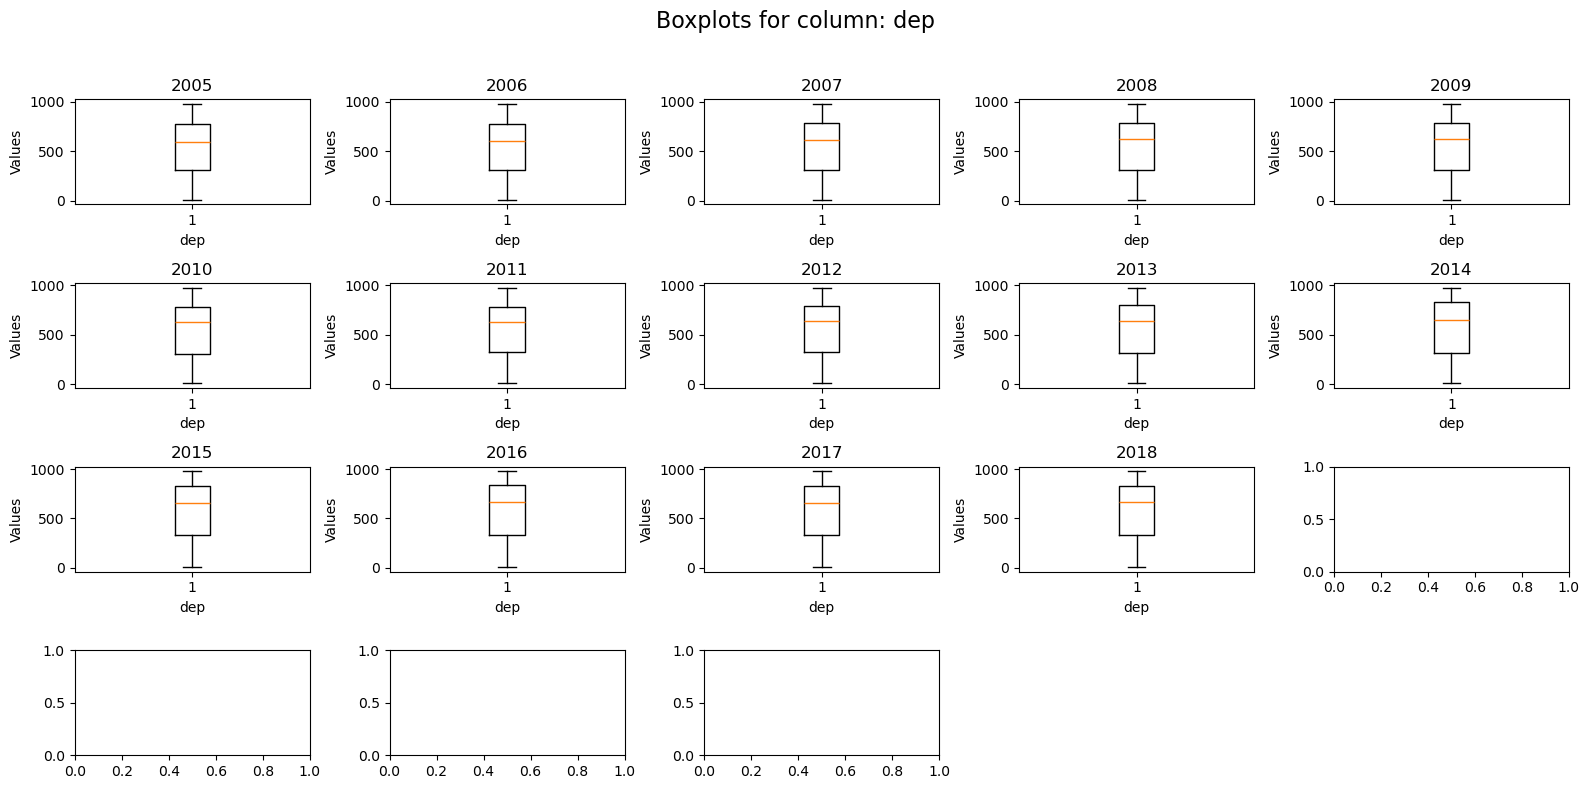

2024-10-24 13:43:32,054 - WARNING - Le nombre de modalités uniques dans la colonne dep excède le seuil de 50. Aucun bar plot généré.
2024-10-24 13:43:32,071 - WARNING - Le nombre de modalités uniques dans la colonne dep excède le seuil de 12. Aucun graphique en ligne généré.


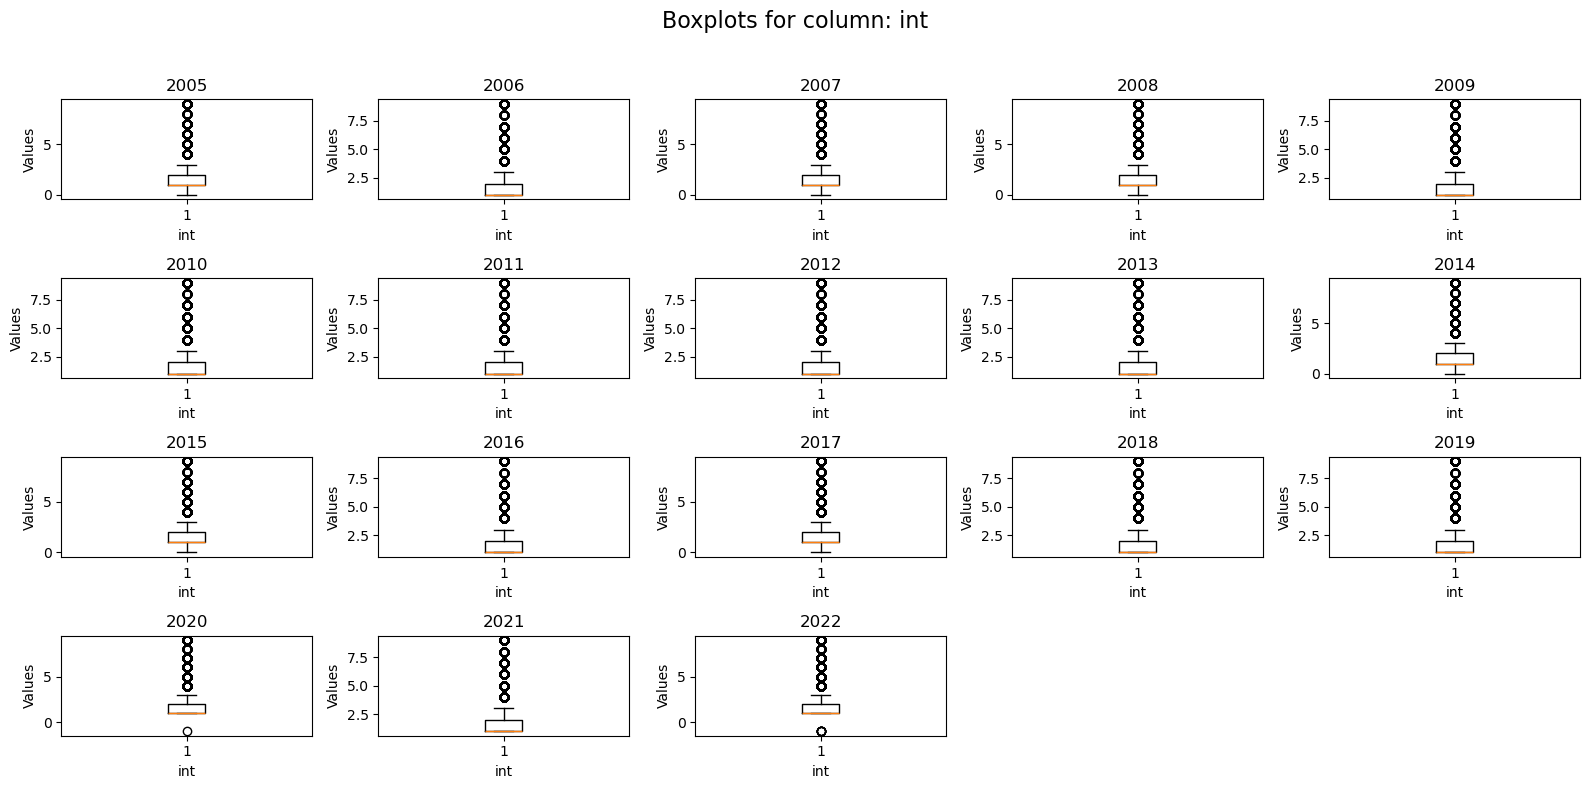

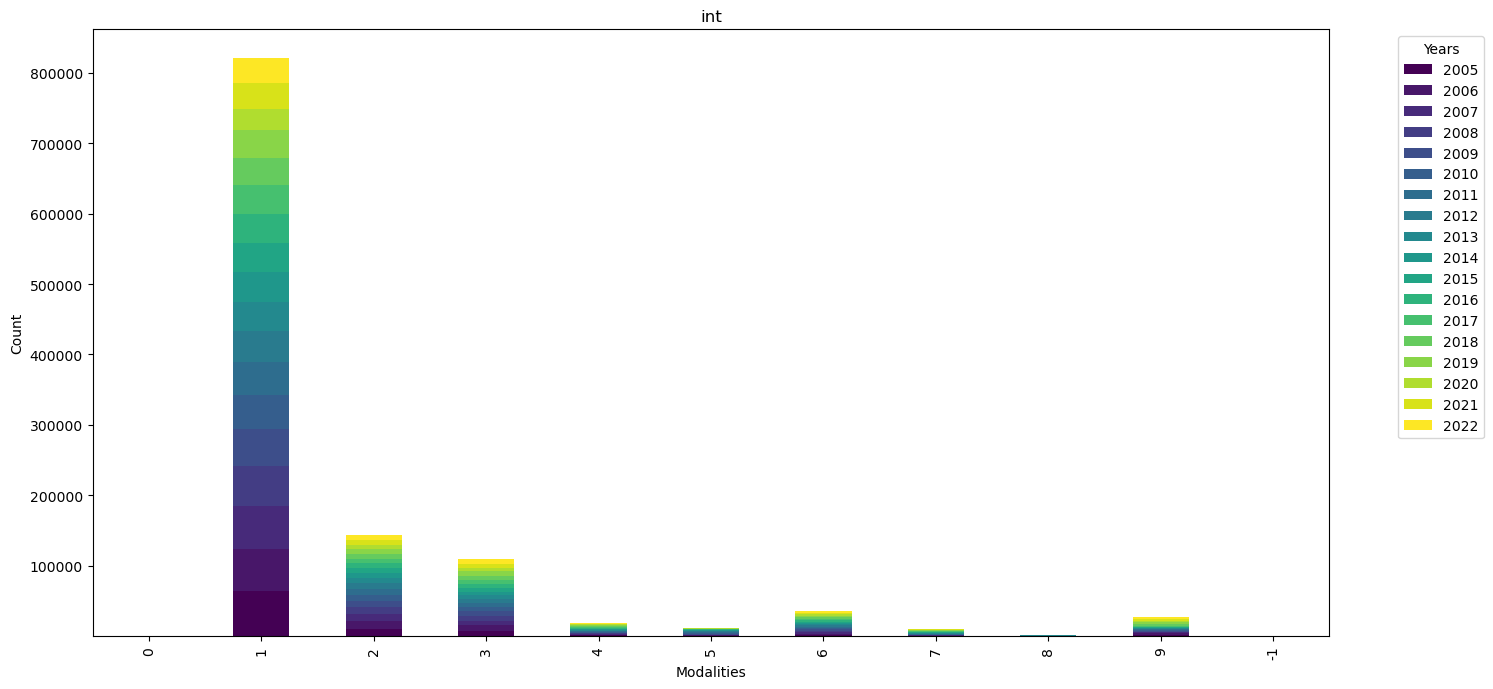

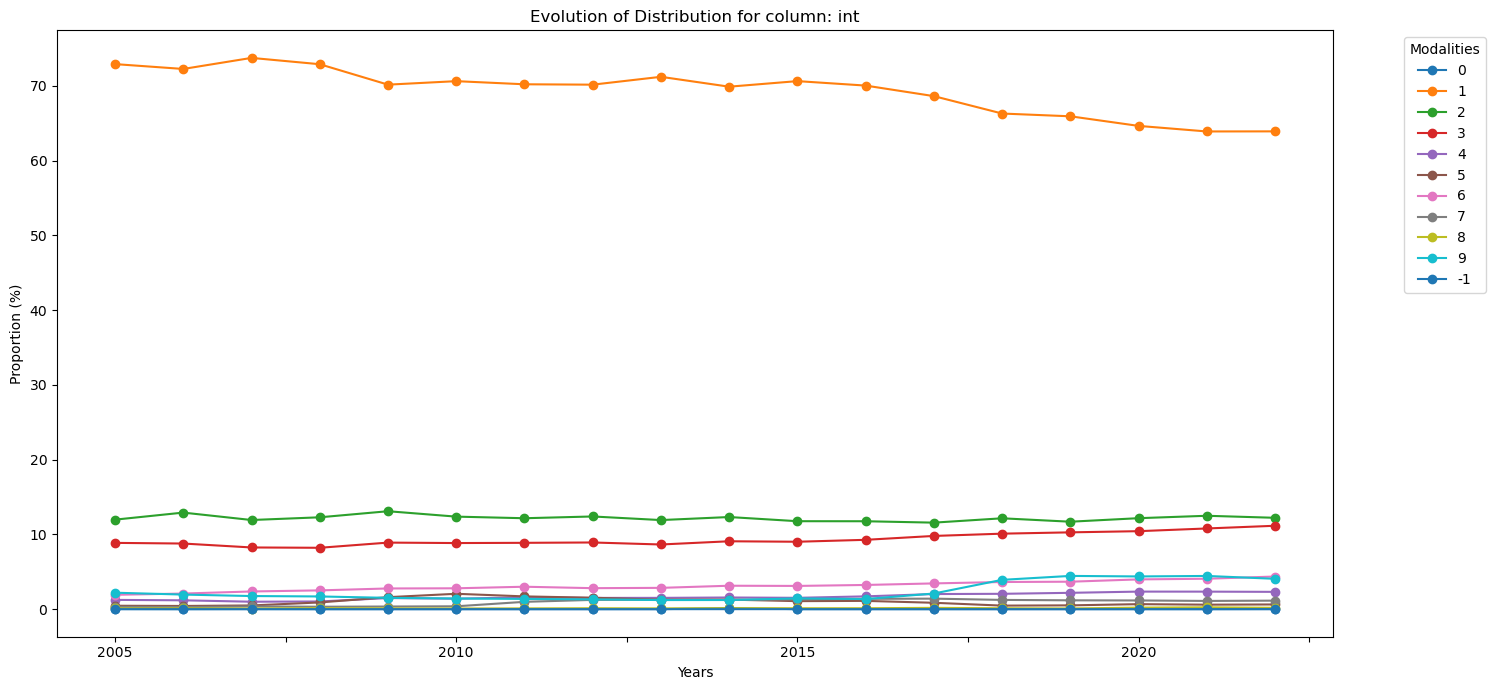

2024-10-24 13:43:33,596 - INFO - Chargement de lieux_2005.csv.
2024-10-24 13:43:33,596 - INFO - Chargement de lieux_2006.csv.
2024-10-24 13:43:33,596 - INFO - Chargement de lieux_2007.csv.
2024-10-24 13:43:33,611 - INFO - Chargement de lieux_2008.csv.
2024-10-24 13:43:33,611 - INFO - Chargement de lieux_2009.csv.
2024-10-24 13:43:33,611 - INFO - Chargement de lieux_2010.csv.
2024-10-24 13:43:33,611 - INFO - Chargement de lieux_2011.csv.
2024-10-24 13:43:33,611 - INFO - Chargement de lieux_2012.csv.
2024-10-24 13:43:33,611 - INFO - Chargement de lieux_2013.csv.
2024-10-24 13:43:33,611 - INFO - Chargement de lieux_2014.csv.
2024-10-24 13:43:33,611 - INFO - Chargement de lieux_2015.csv.
2024-10-24 13:43:33,611 - INFO - Chargement de lieux_2016.csv.
2024-10-24 13:43:33,611 - INFO - Chargement de lieux-2017.csv.
2024-10-24 13:43:33,611 - INFO - Chargement de lieux-2018.csv.
2024-10-24 13:43:33,611 - INFO - Chargement de lieux-2019.csv.
2024-10-24 13:43:33,611 - INFO - Chargement de lieux-20

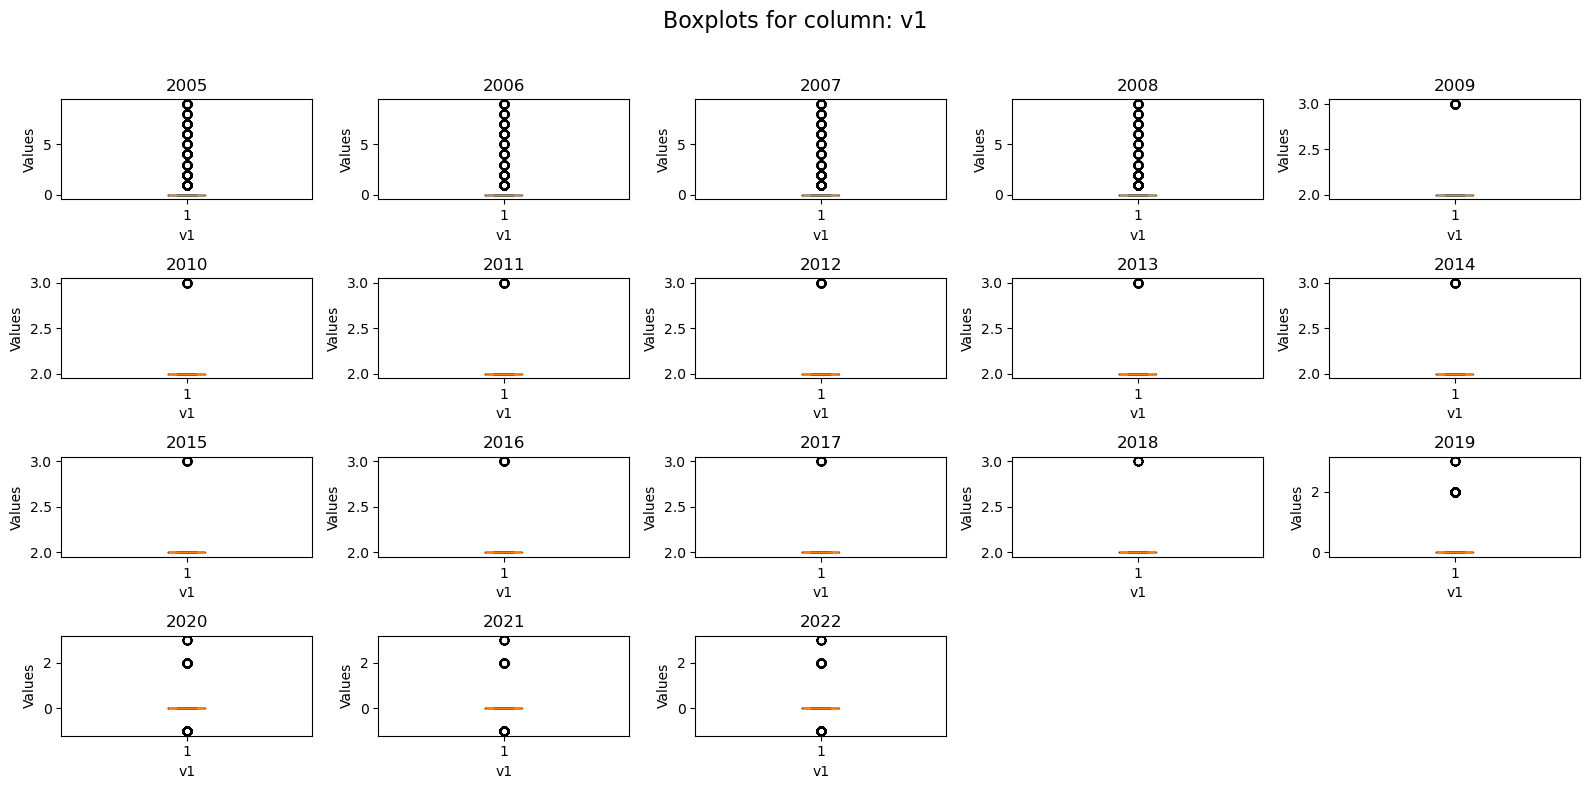

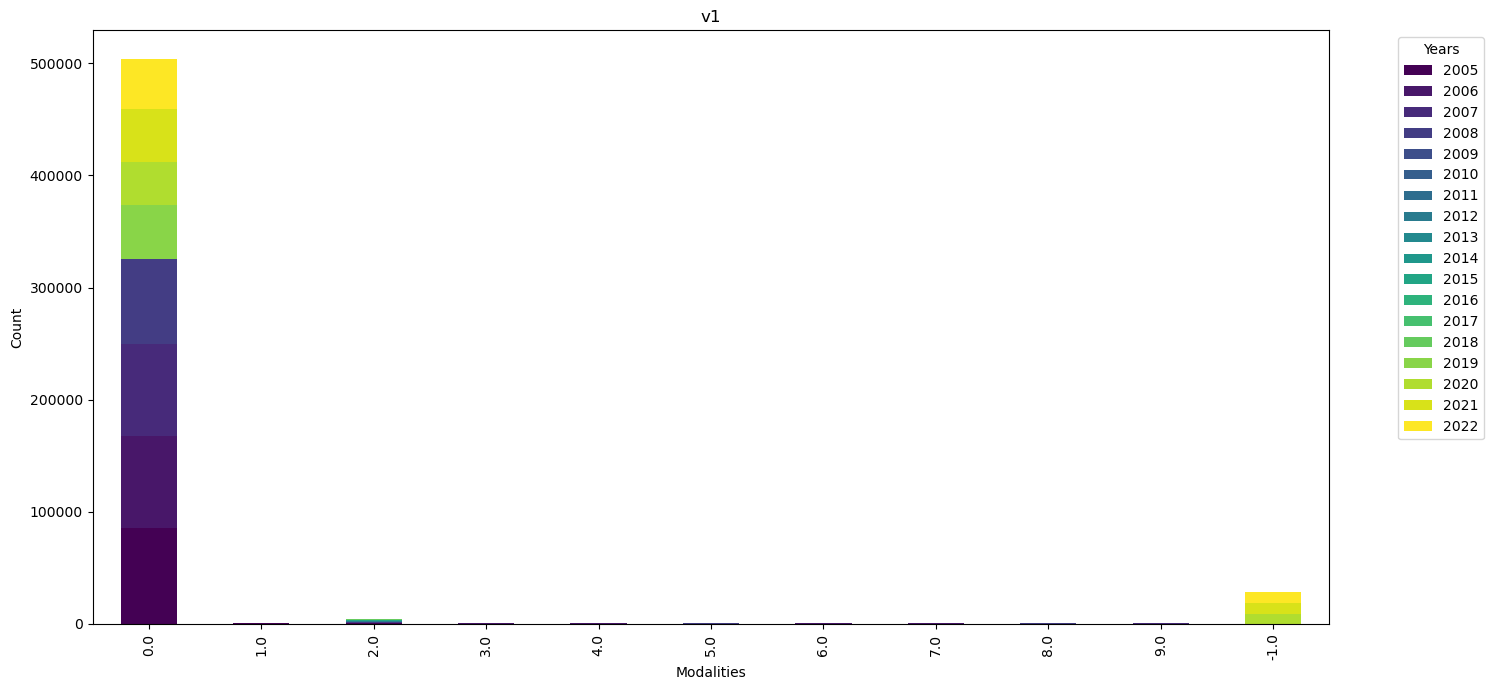

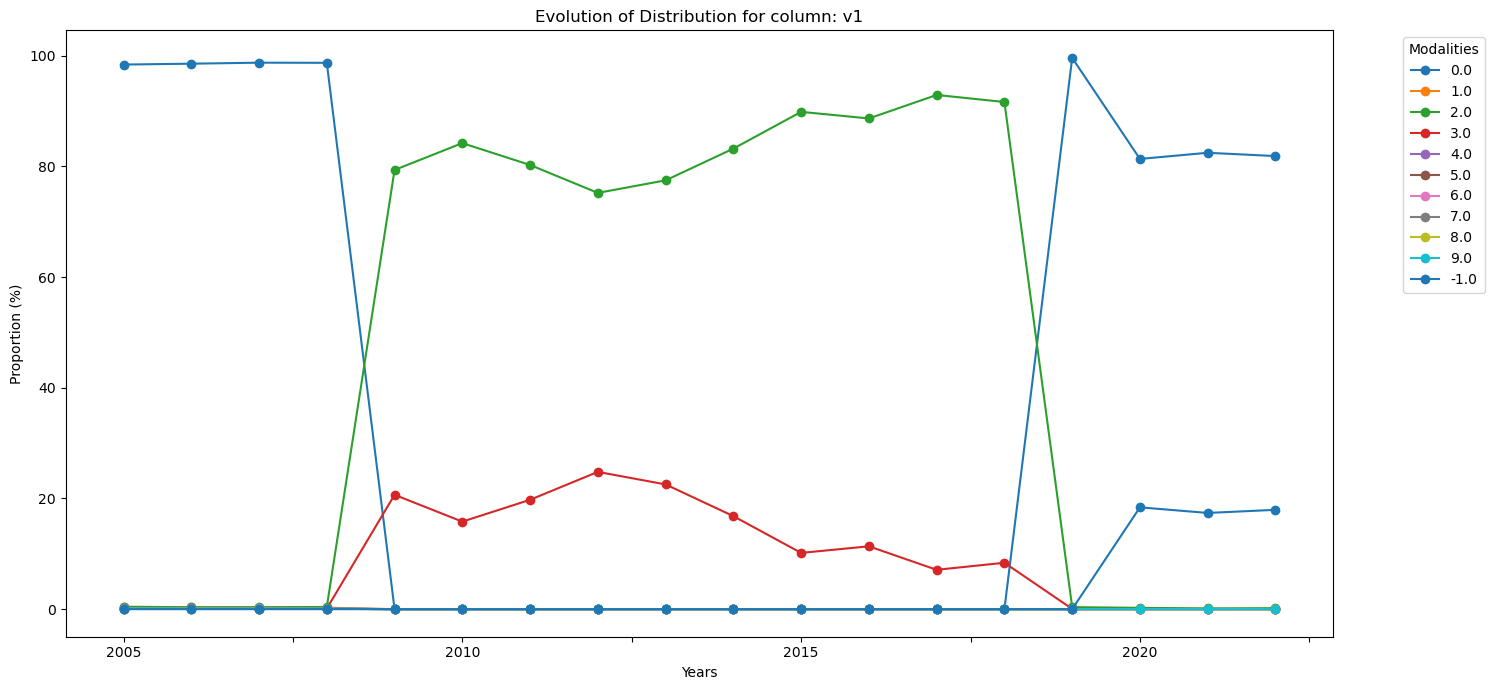

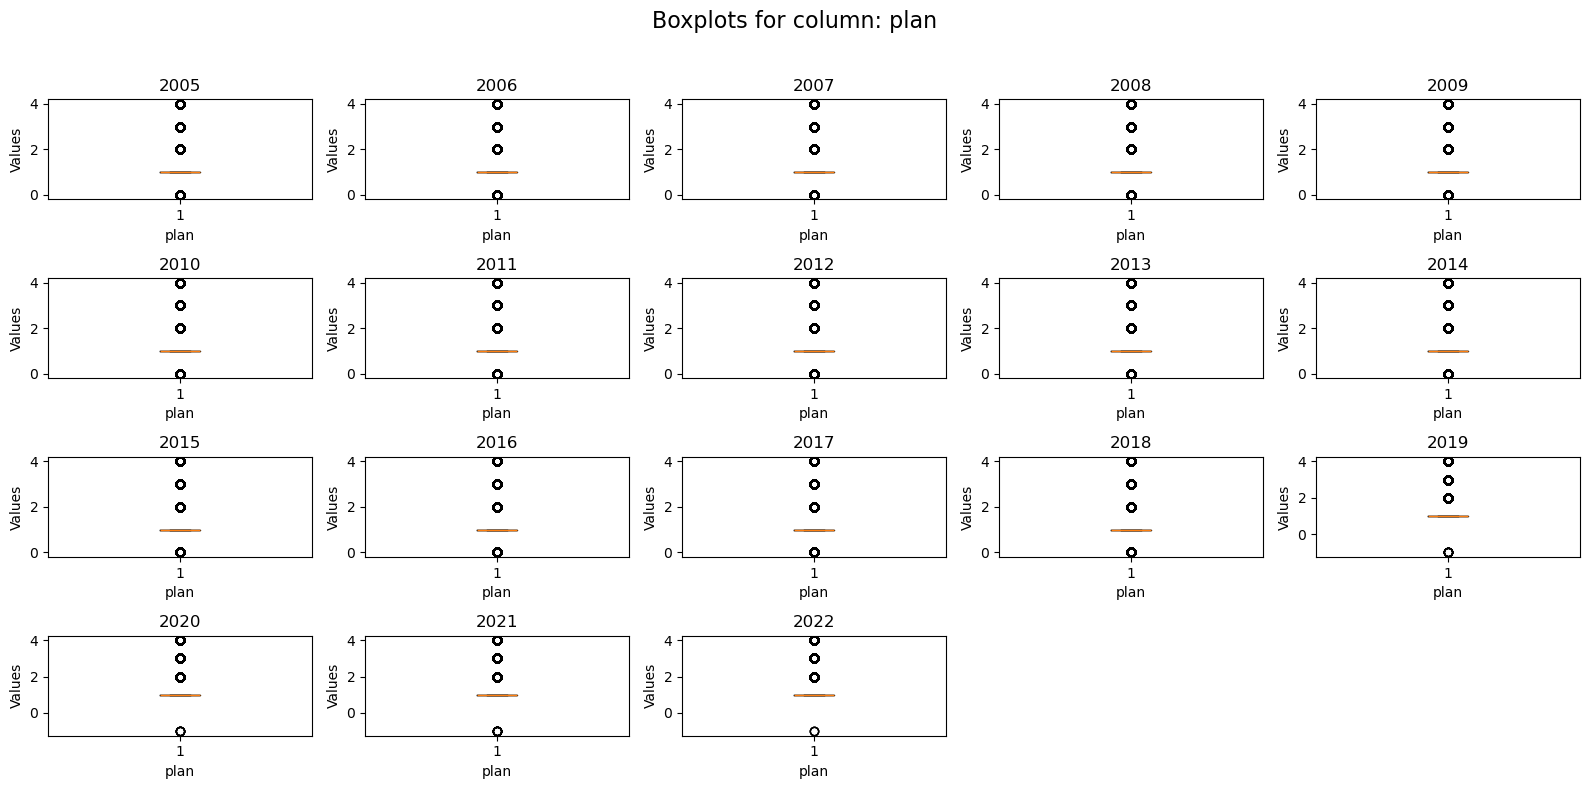

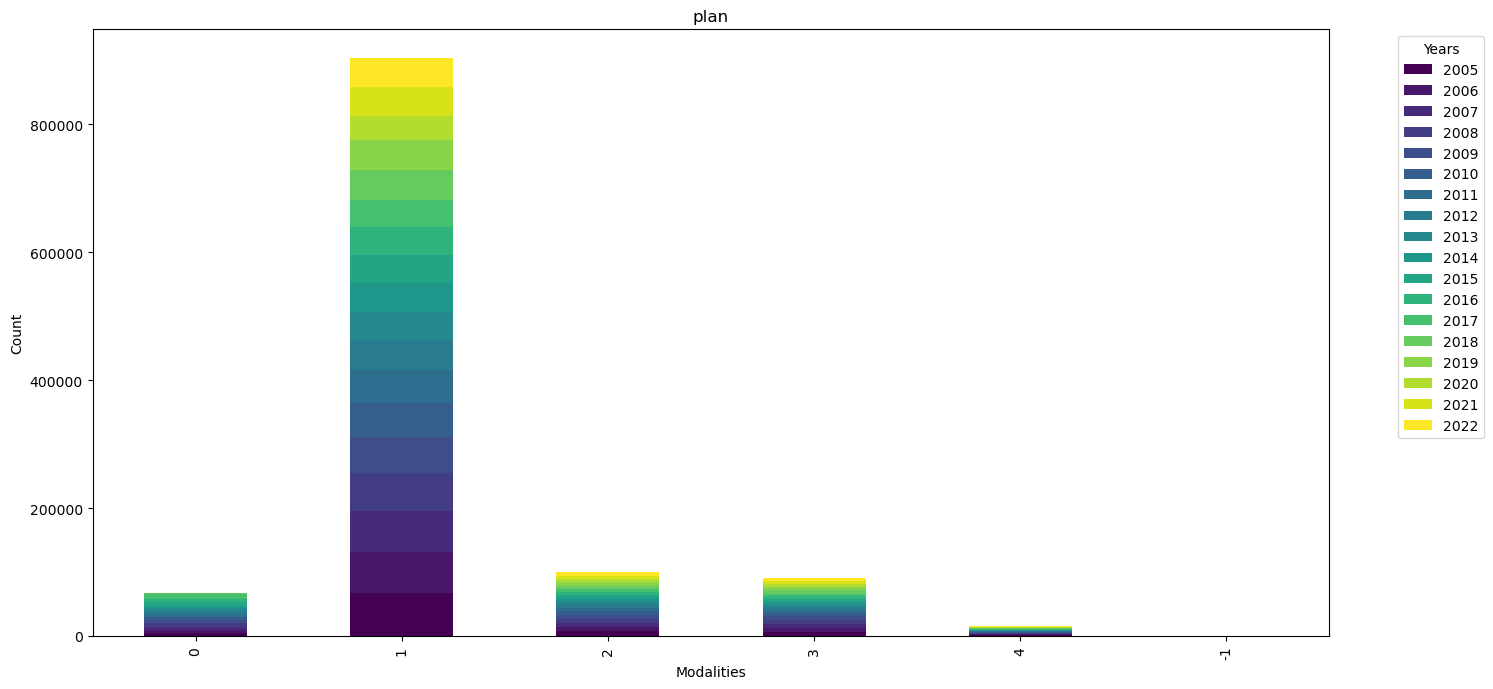

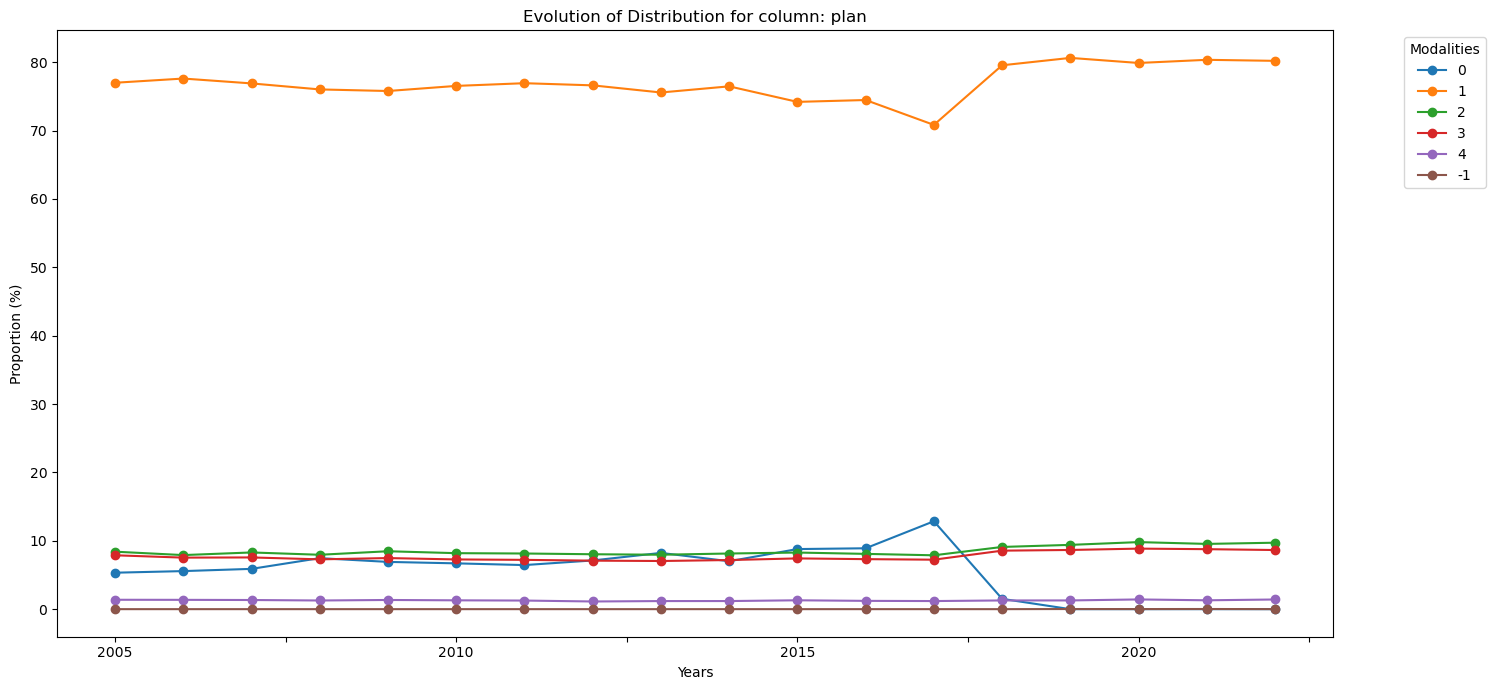

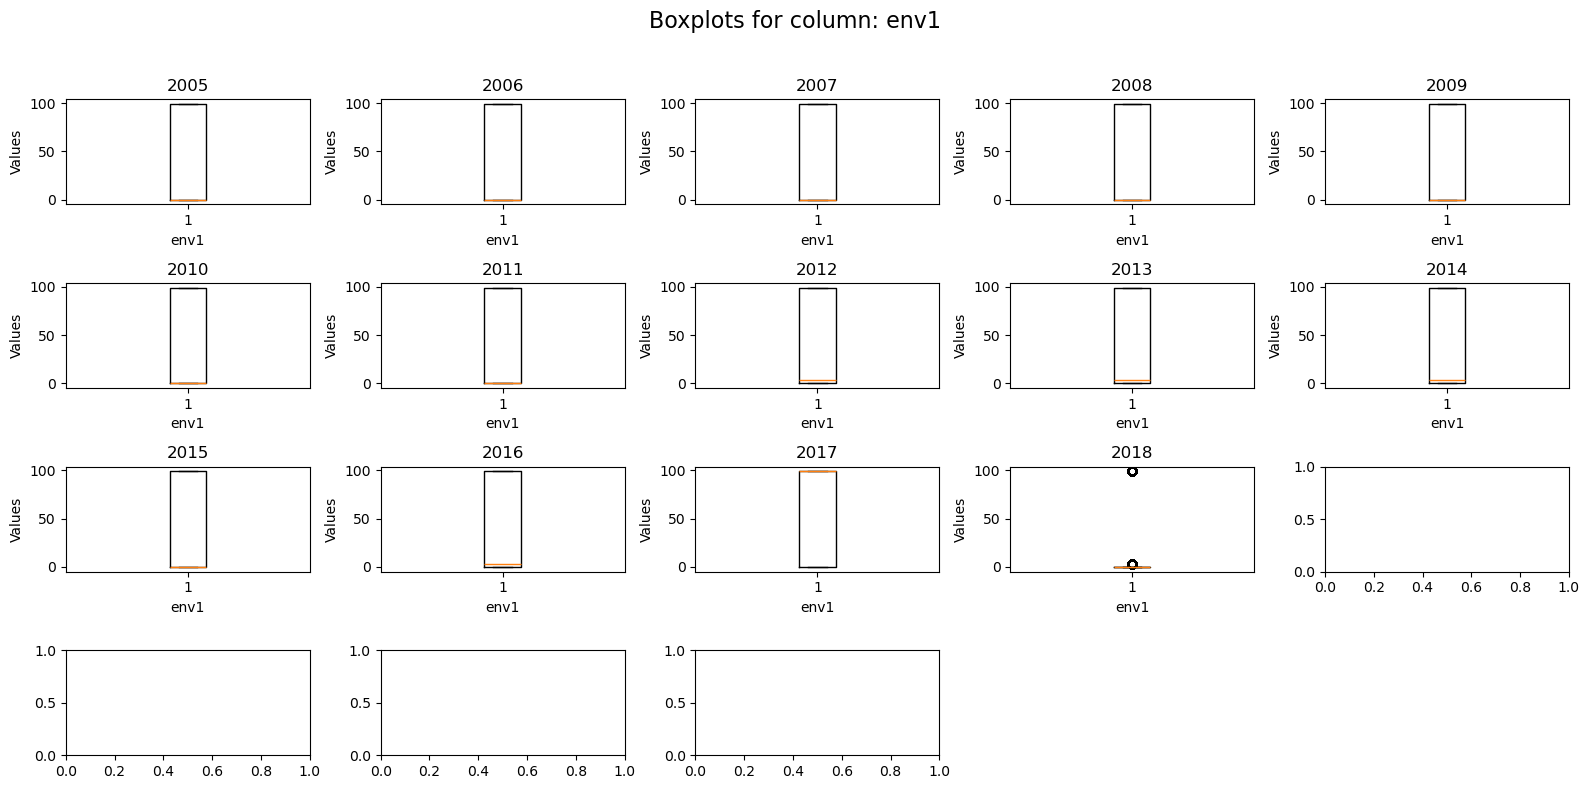

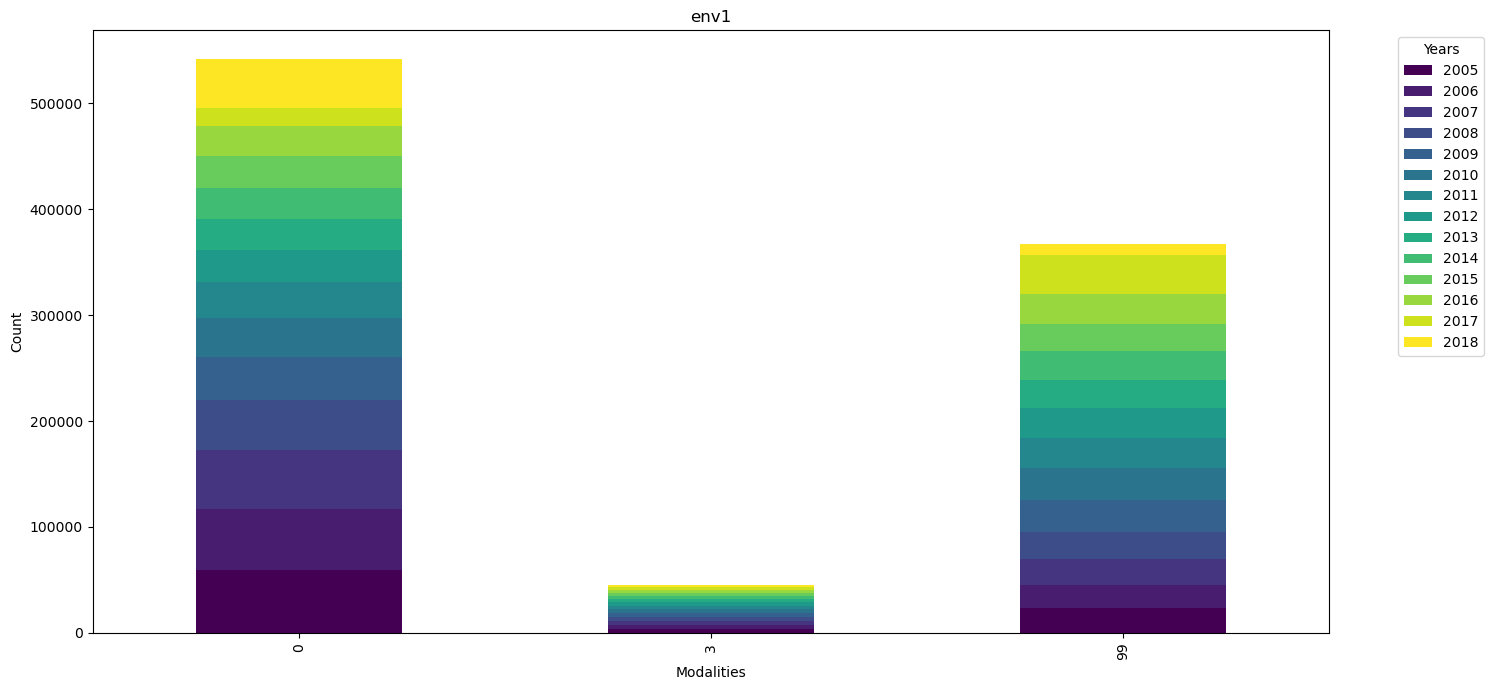

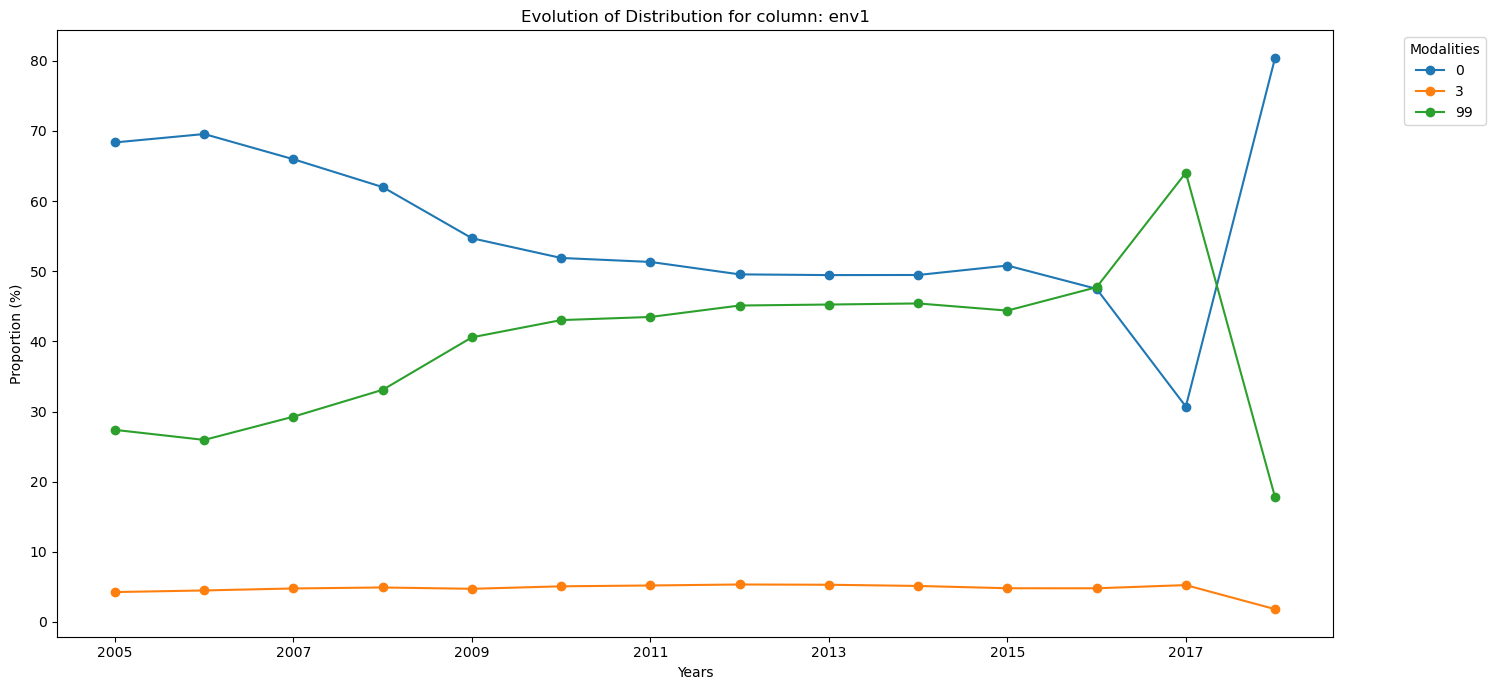

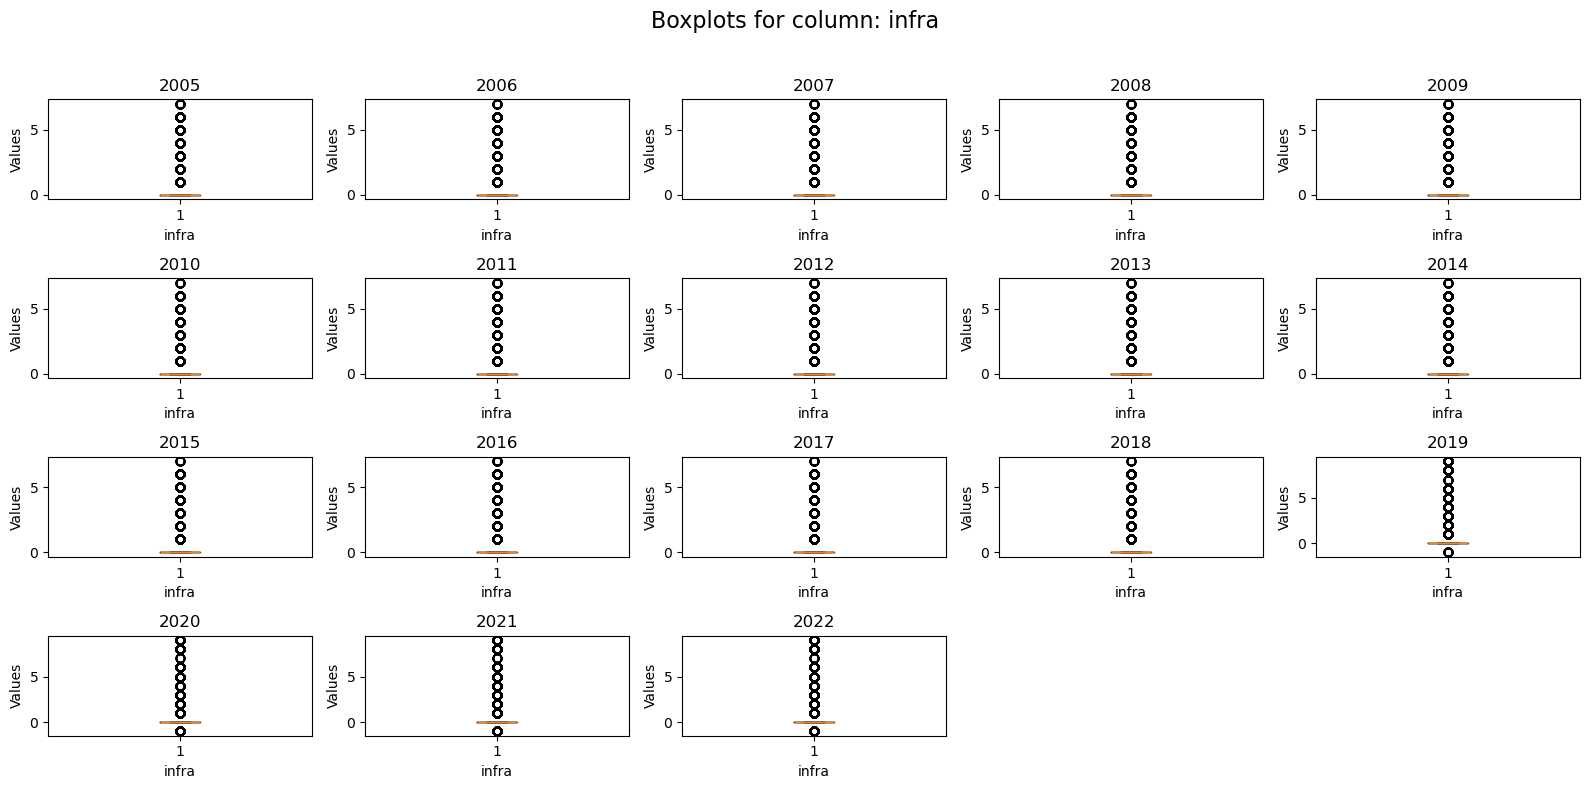

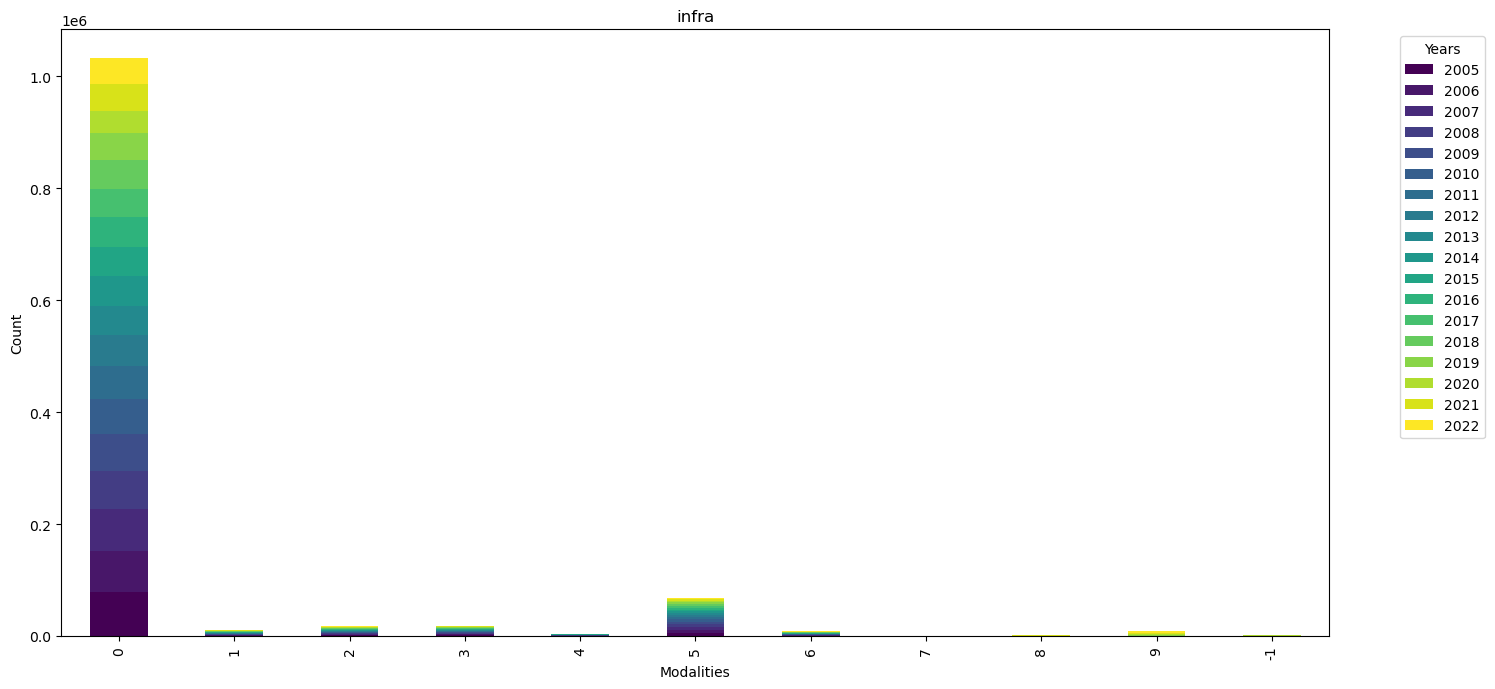

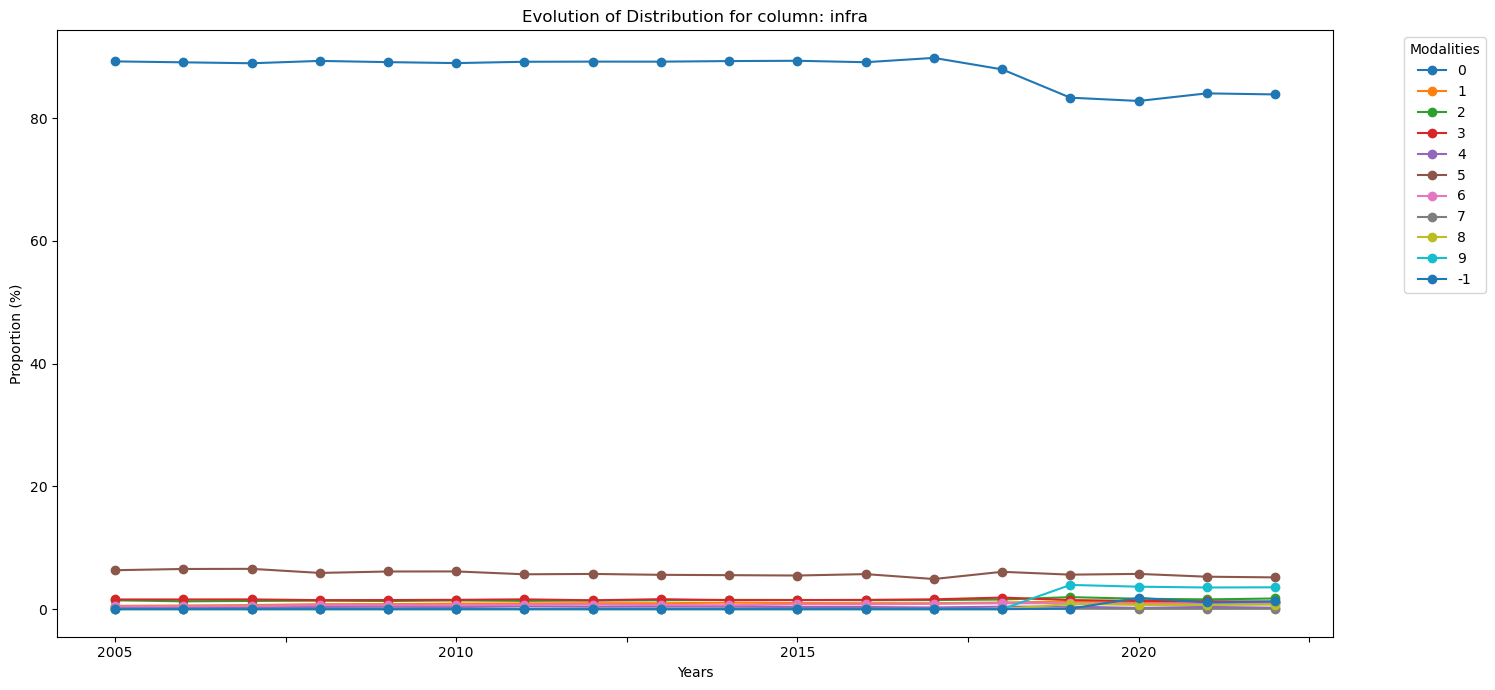

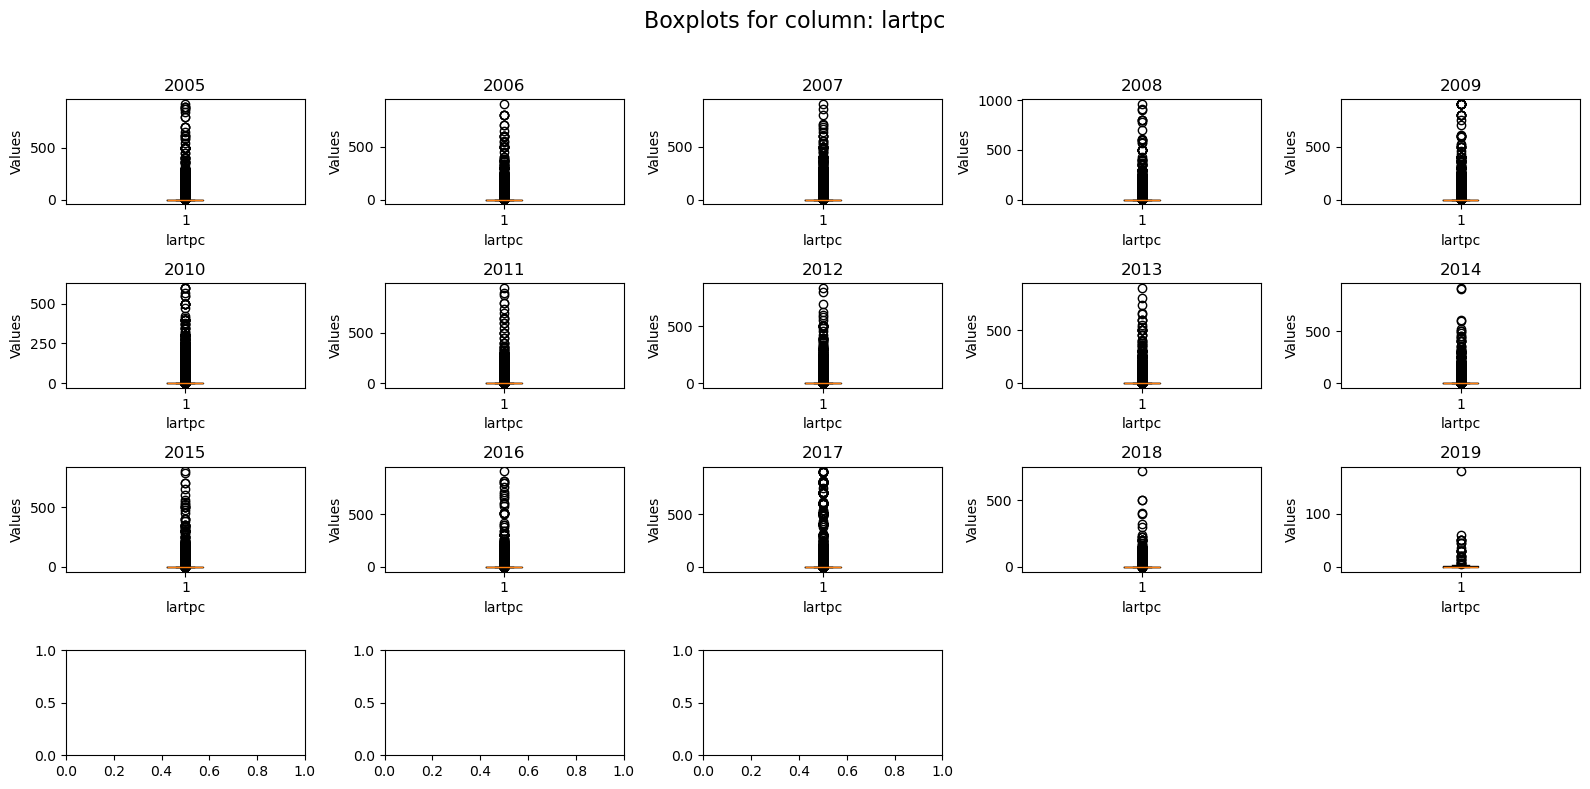

2024-10-24 13:43:42,415 - WARNING - Le nombre de modalités uniques dans la colonne lartpc excède le seuil de 50. Aucun bar plot généré.
2024-10-24 13:43:42,430 - WARNING - Le nombre de modalités uniques dans la colonne lartpc excède le seuil de 12. Aucun graphique en ligne généré.


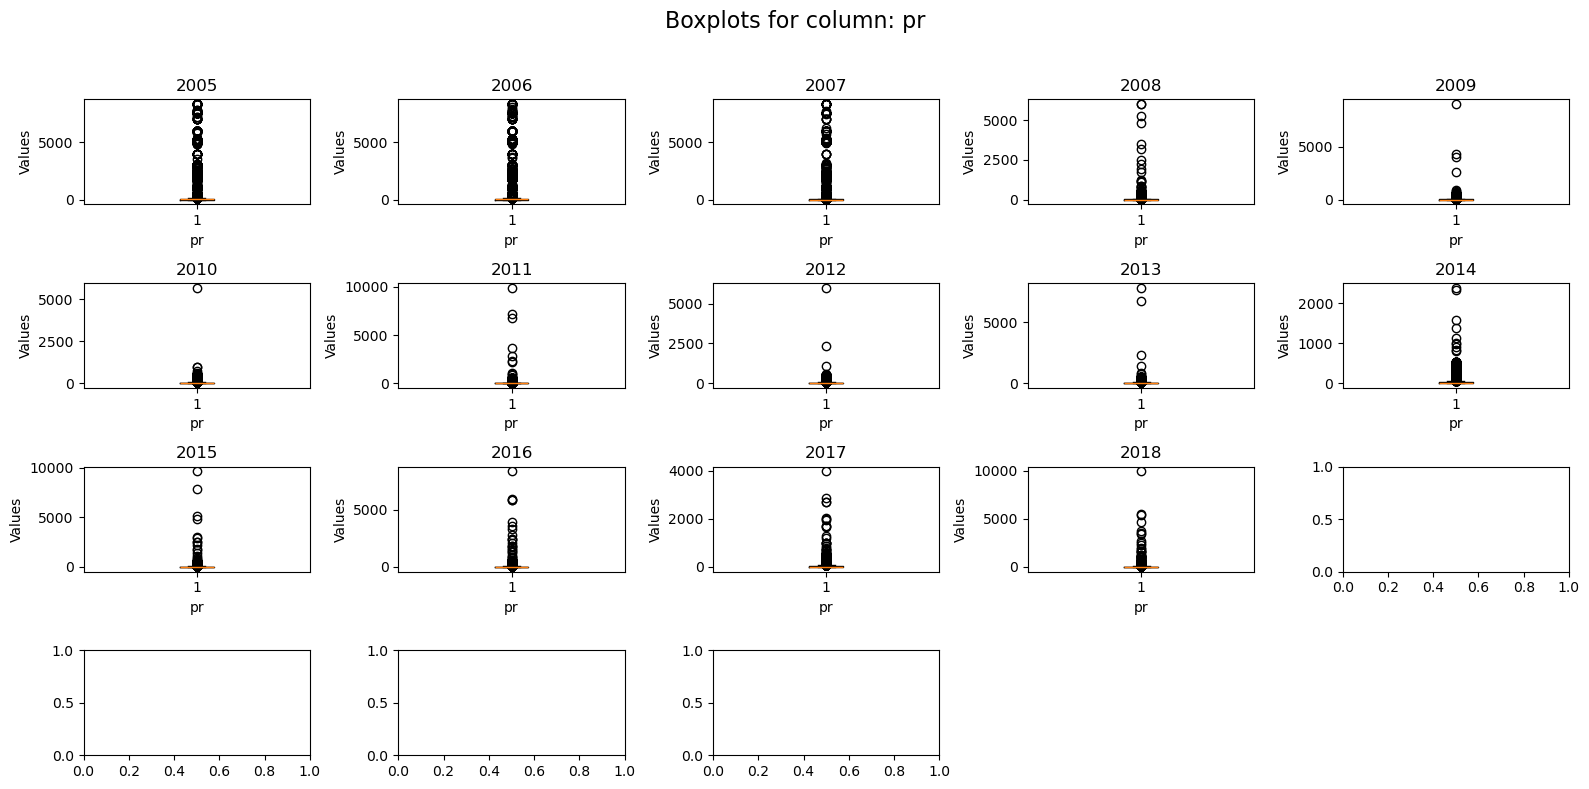

2024-10-24 13:43:43,777 - WARNING - Le nombre de modalités uniques dans la colonne pr excède le seuil de 50. Aucun bar plot généré.
2024-10-24 13:43:43,808 - WARNING - Le nombre de modalités uniques dans la colonne pr excède le seuil de 12. Aucun graphique en ligne généré.


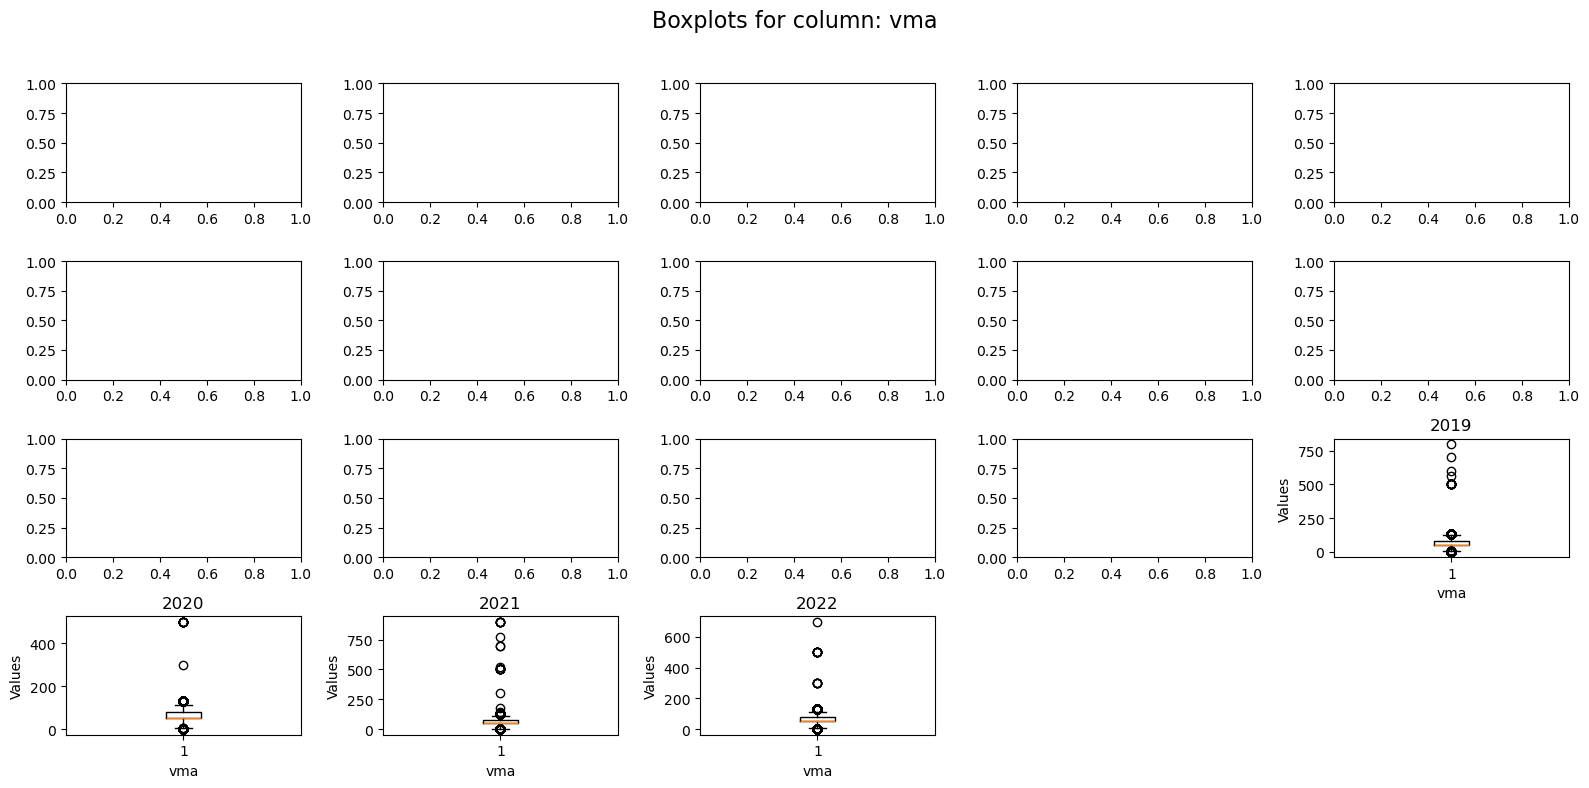

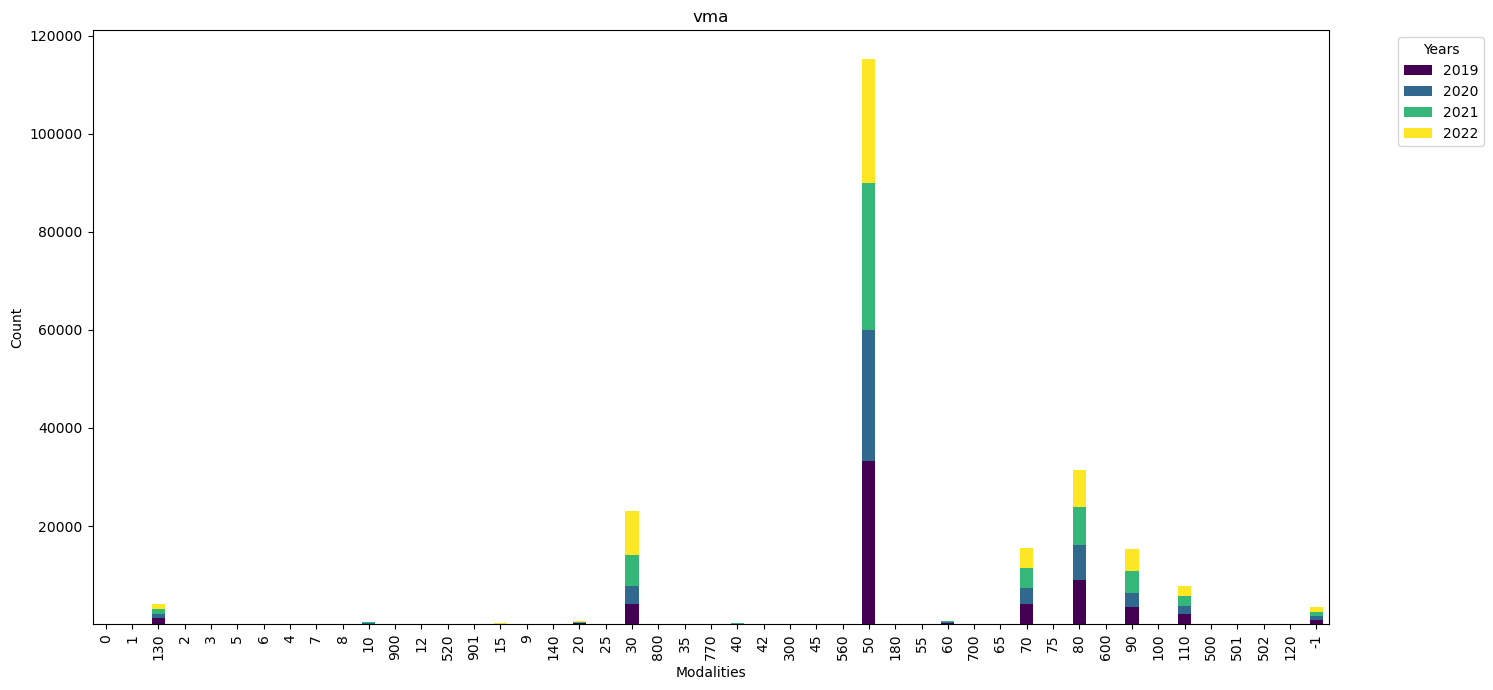

2024-10-24 13:43:45,520 - WARNING - Le nombre de modalités uniques dans la colonne vma excède le seuil de 12. Aucun graphique en ligne généré.


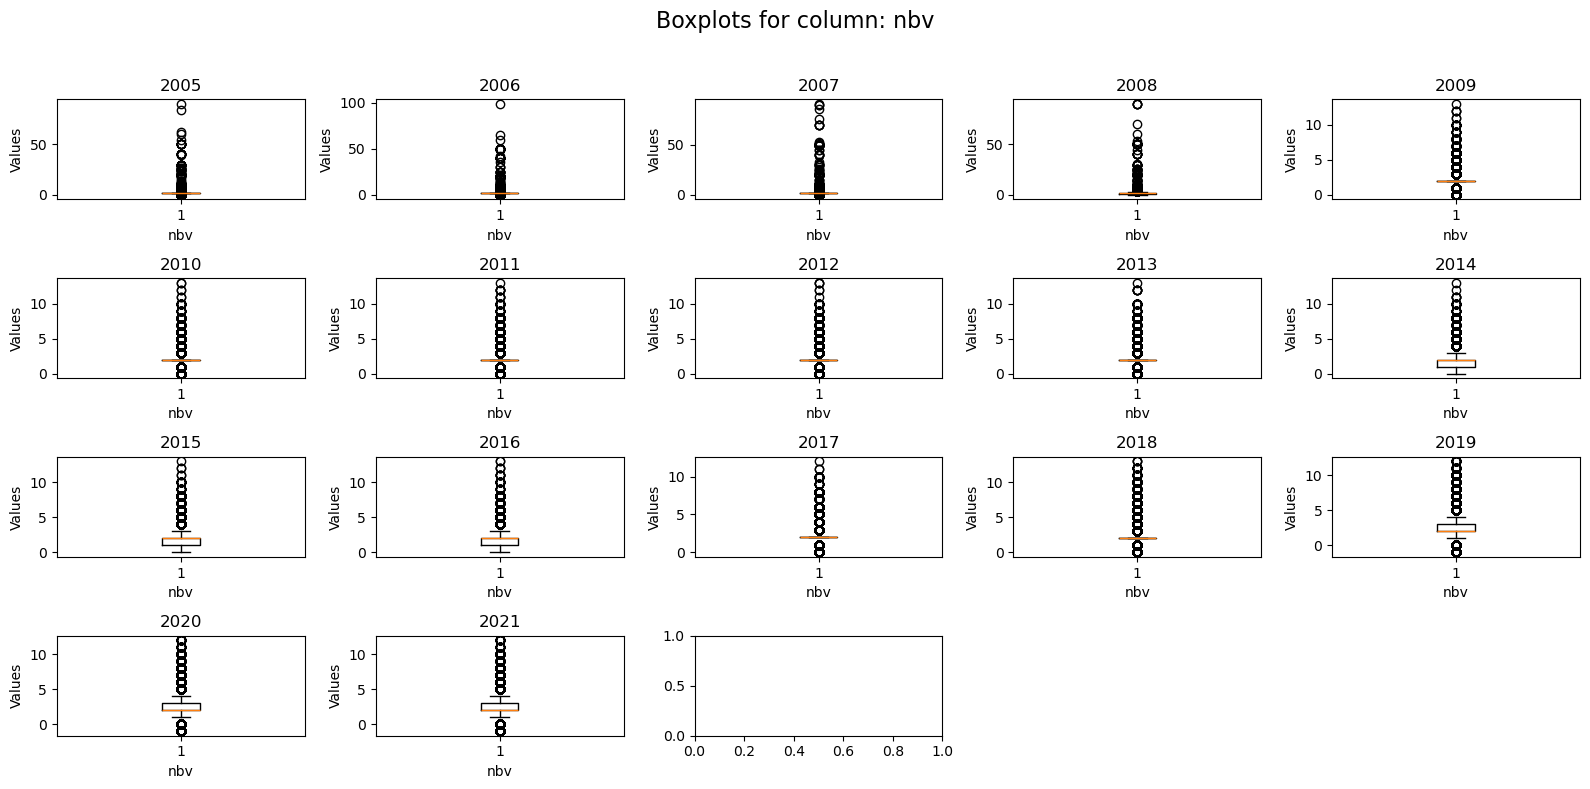

2024-10-24 13:43:47,542 - WARNING - Le nombre de modalités uniques dans la colonne nbv excède le seuil de 50. Aucun bar plot généré.
2024-10-24 13:43:47,558 - WARNING - Le nombre de modalités uniques dans la colonne nbv excède le seuil de 12. Aucun graphique en ligne généré.


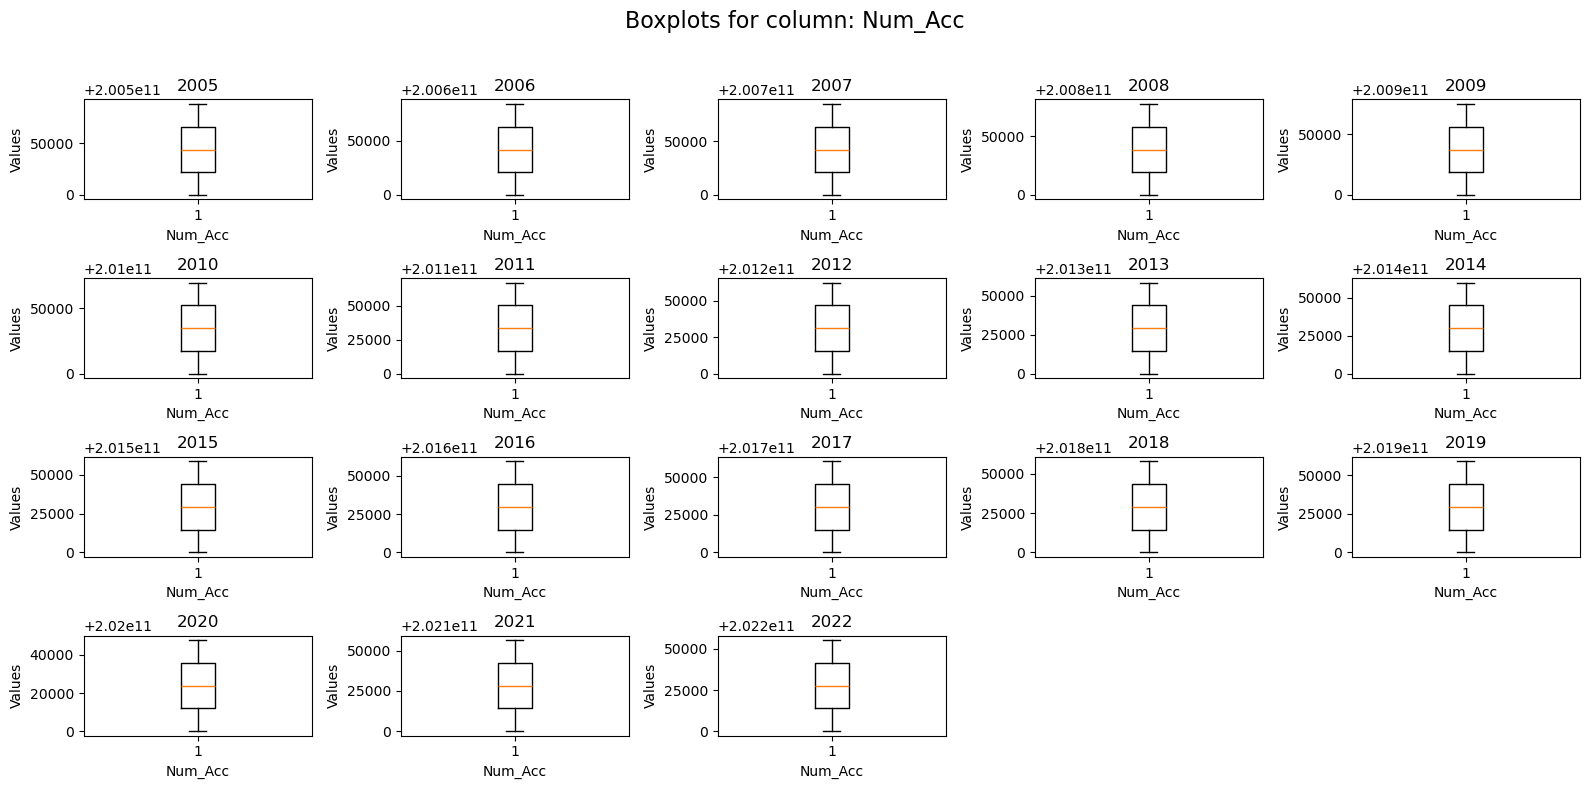

2024-10-24 13:43:49,092 - WARNING - Le nombre de modalités uniques dans la colonne Num_Acc excède le seuil de 50. Aucun bar plot généré.
2024-10-24 13:43:49,279 - WARNING - Le nombre de modalités uniques dans la colonne Num_Acc excède le seuil de 12. Aucun graphique en ligne généré.


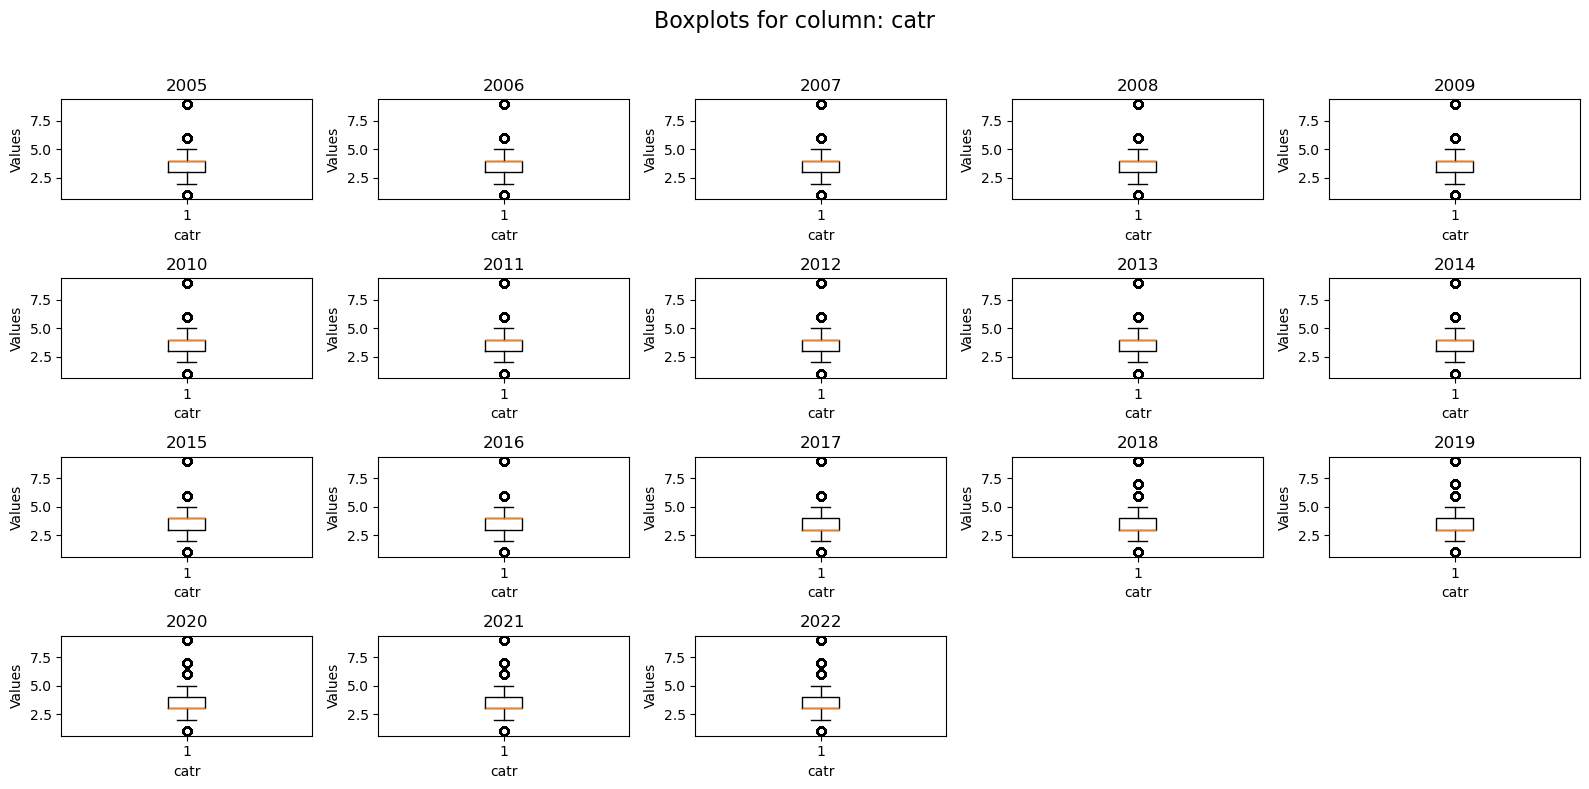

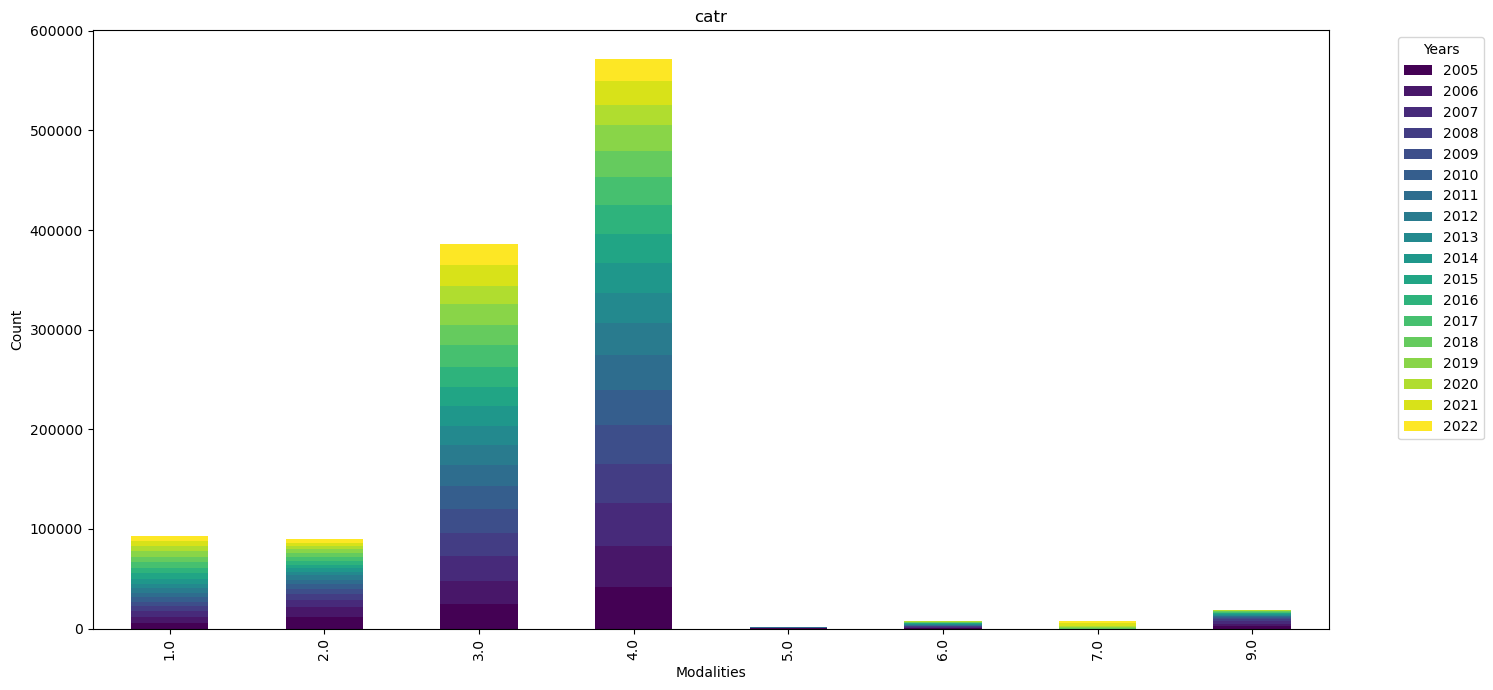

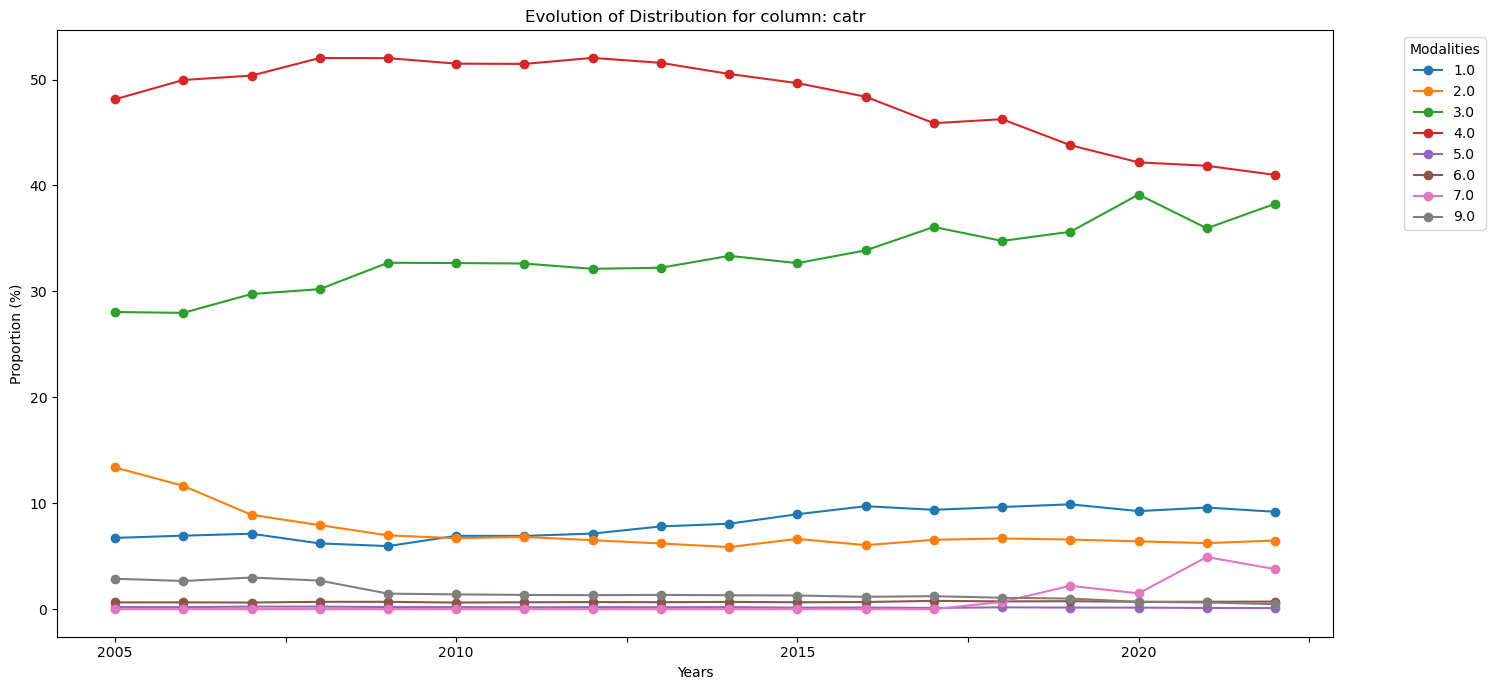

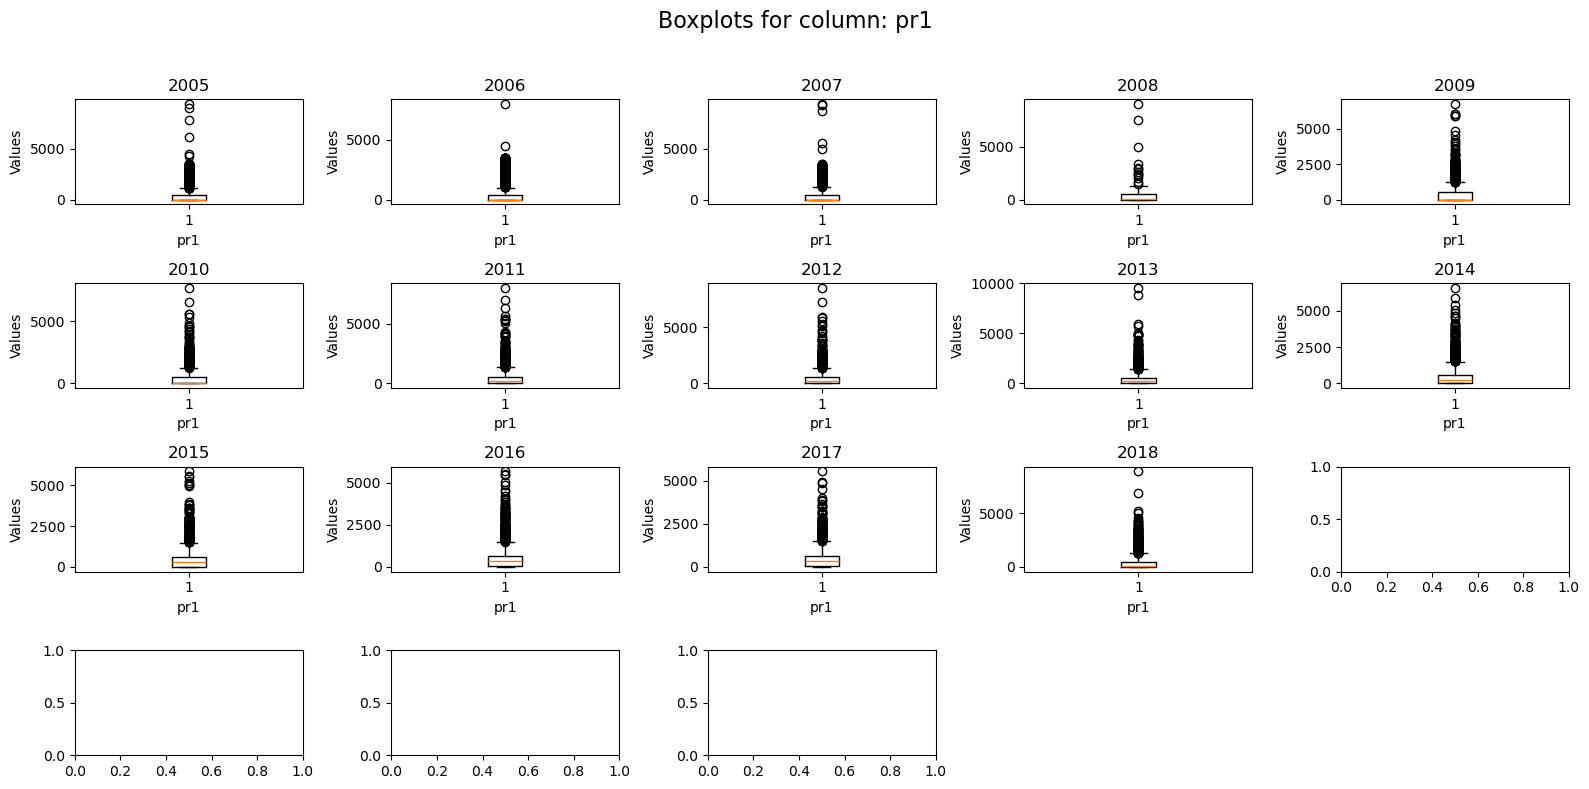

2024-10-24 13:43:52,316 - WARNING - Le nombre de modalités uniques dans la colonne pr1 excède le seuil de 50. Aucun bar plot généré.
2024-10-24 13:43:52,332 - WARNING - Le nombre de modalités uniques dans la colonne pr1 excède le seuil de 12. Aucun graphique en ligne généré.


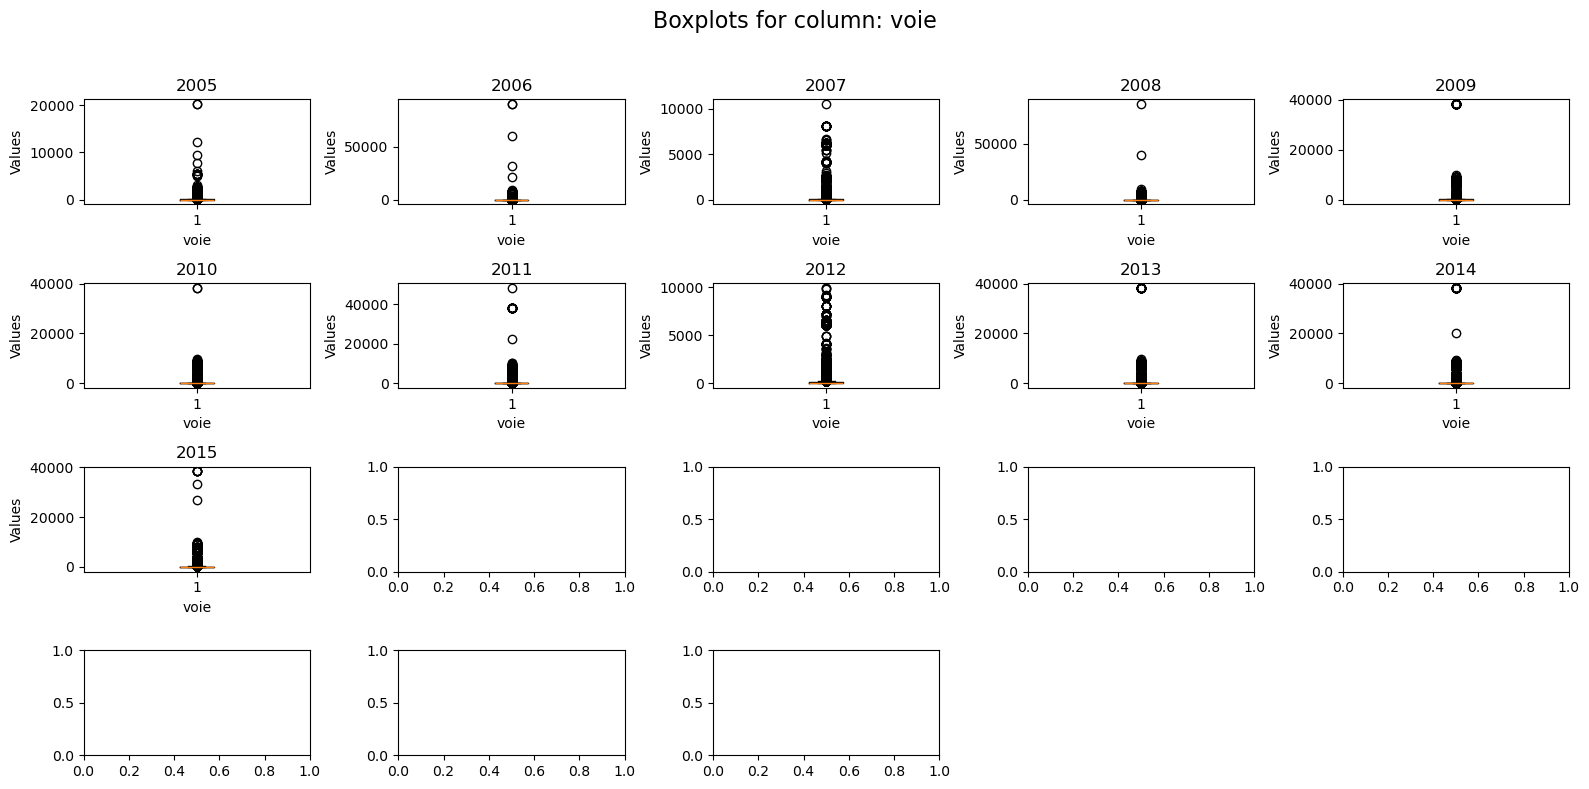

2024-10-24 13:43:53,550 - WARNING - Le nombre de modalités uniques dans la colonne voie excède le seuil de 50. Aucun bar plot généré.
2024-10-24 13:43:53,597 - WARNING - Le nombre de modalités uniques dans la colonne voie excède le seuil de 12. Aucun graphique en ligne généré.


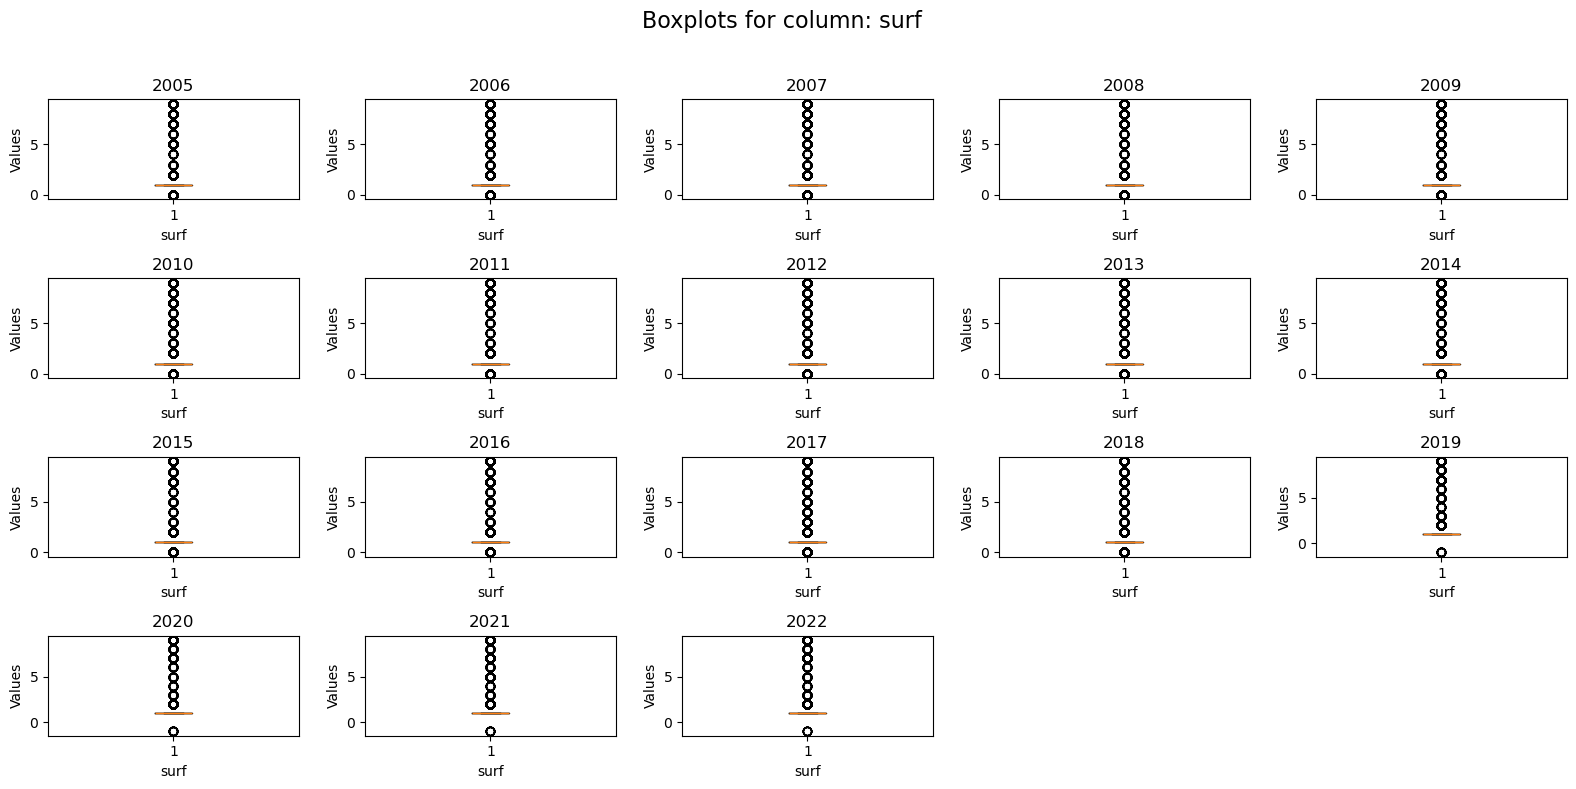

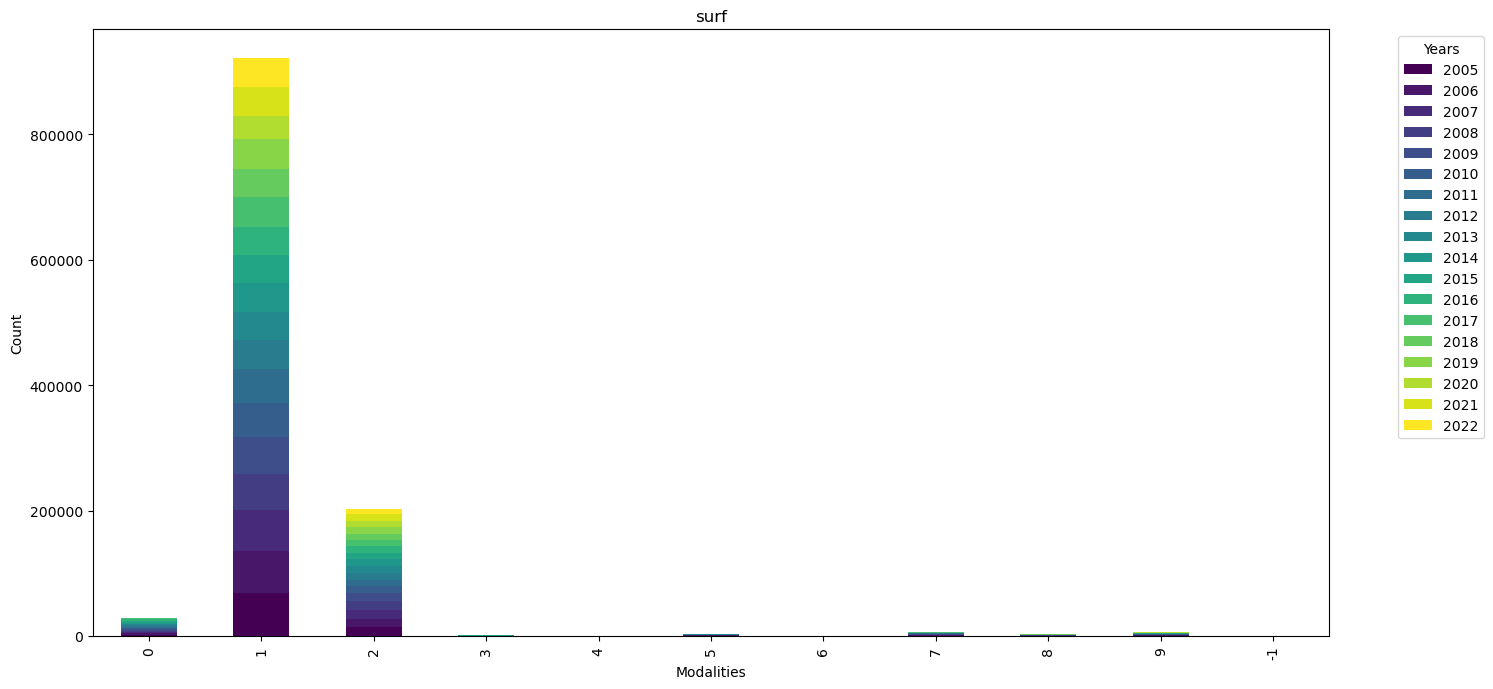

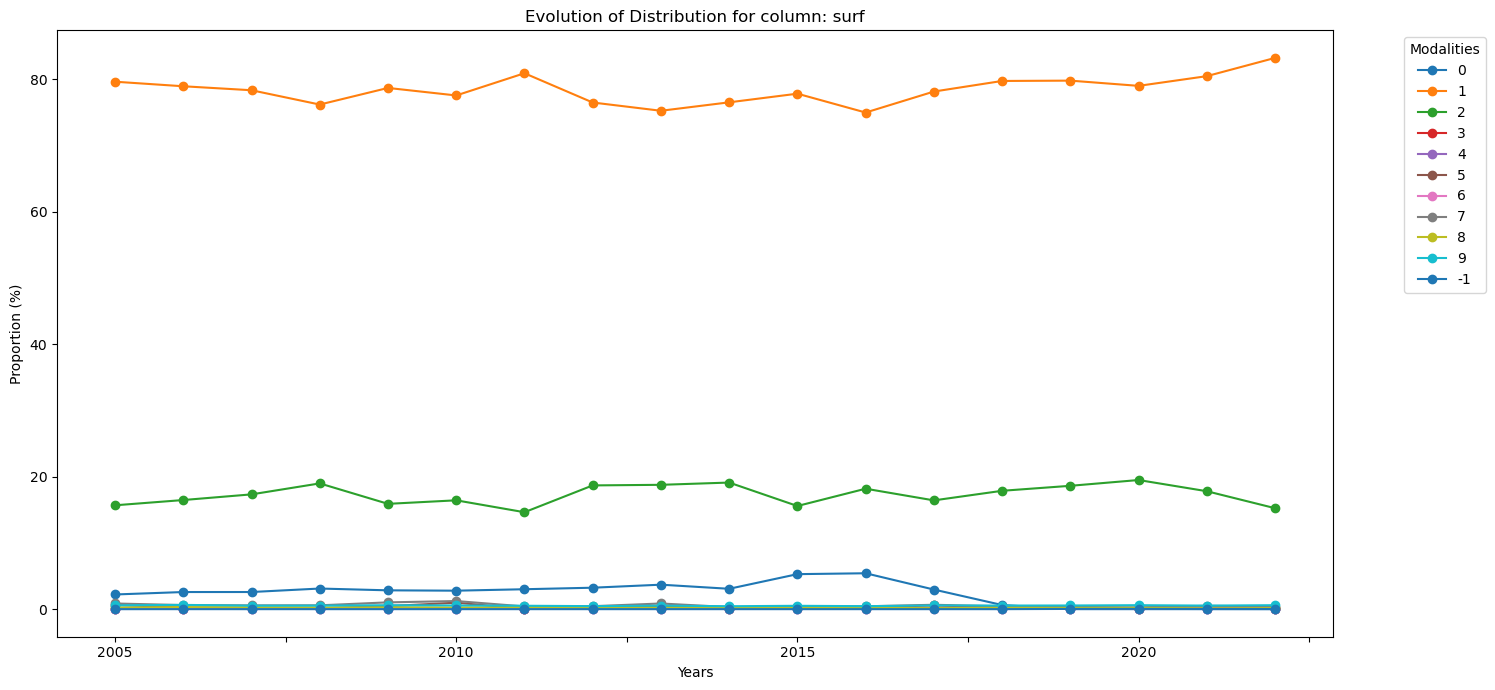

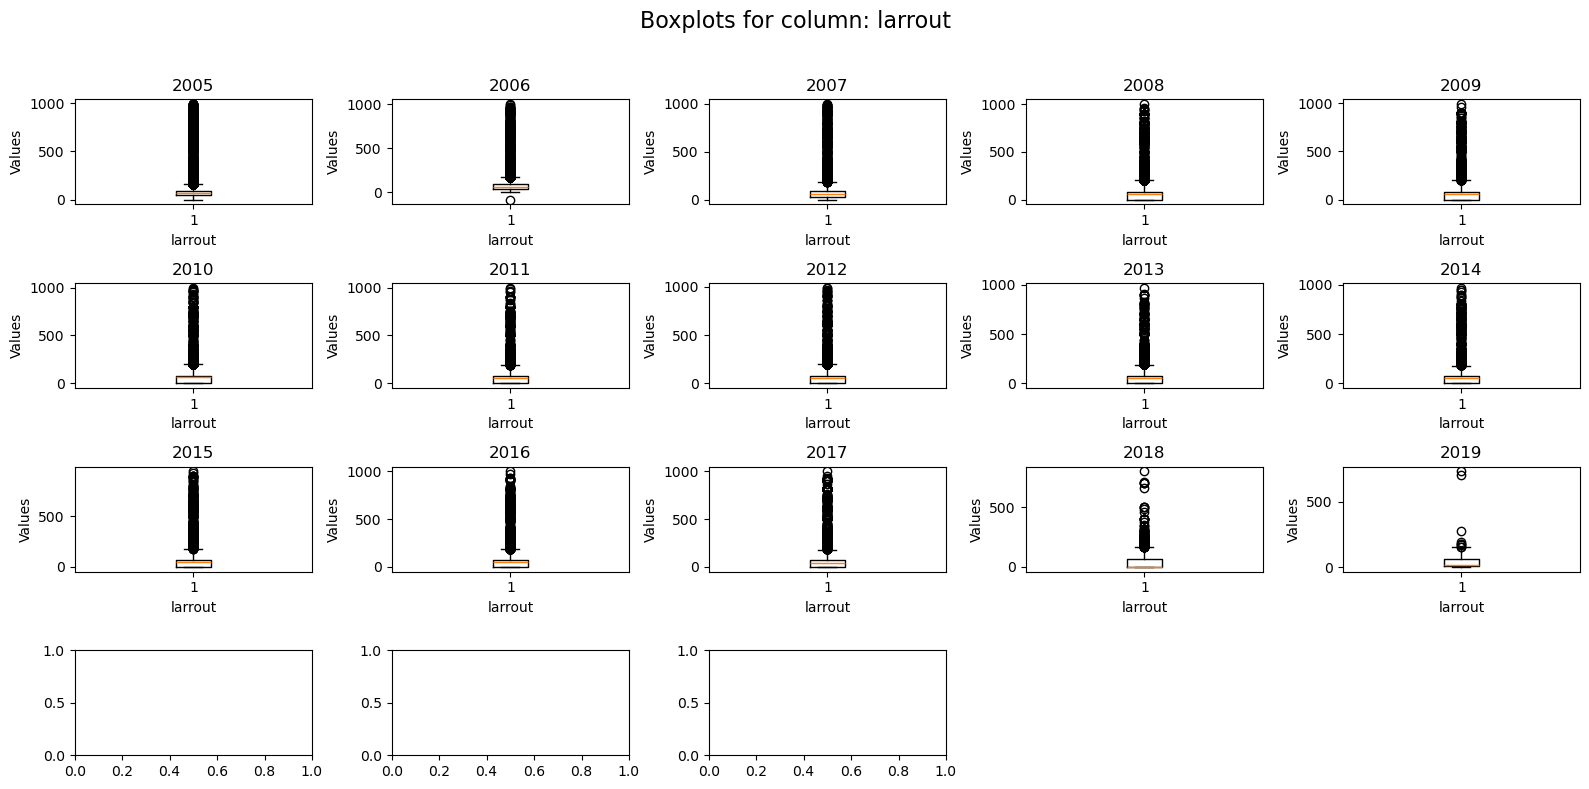

2024-10-24 13:43:56,678 - WARNING - Le nombre de modalités uniques dans la colonne larrout excède le seuil de 50. Aucun bar plot généré.
2024-10-24 13:43:56,694 - WARNING - Le nombre de modalités uniques dans la colonne larrout excède le seuil de 12. Aucun graphique en ligne généré.


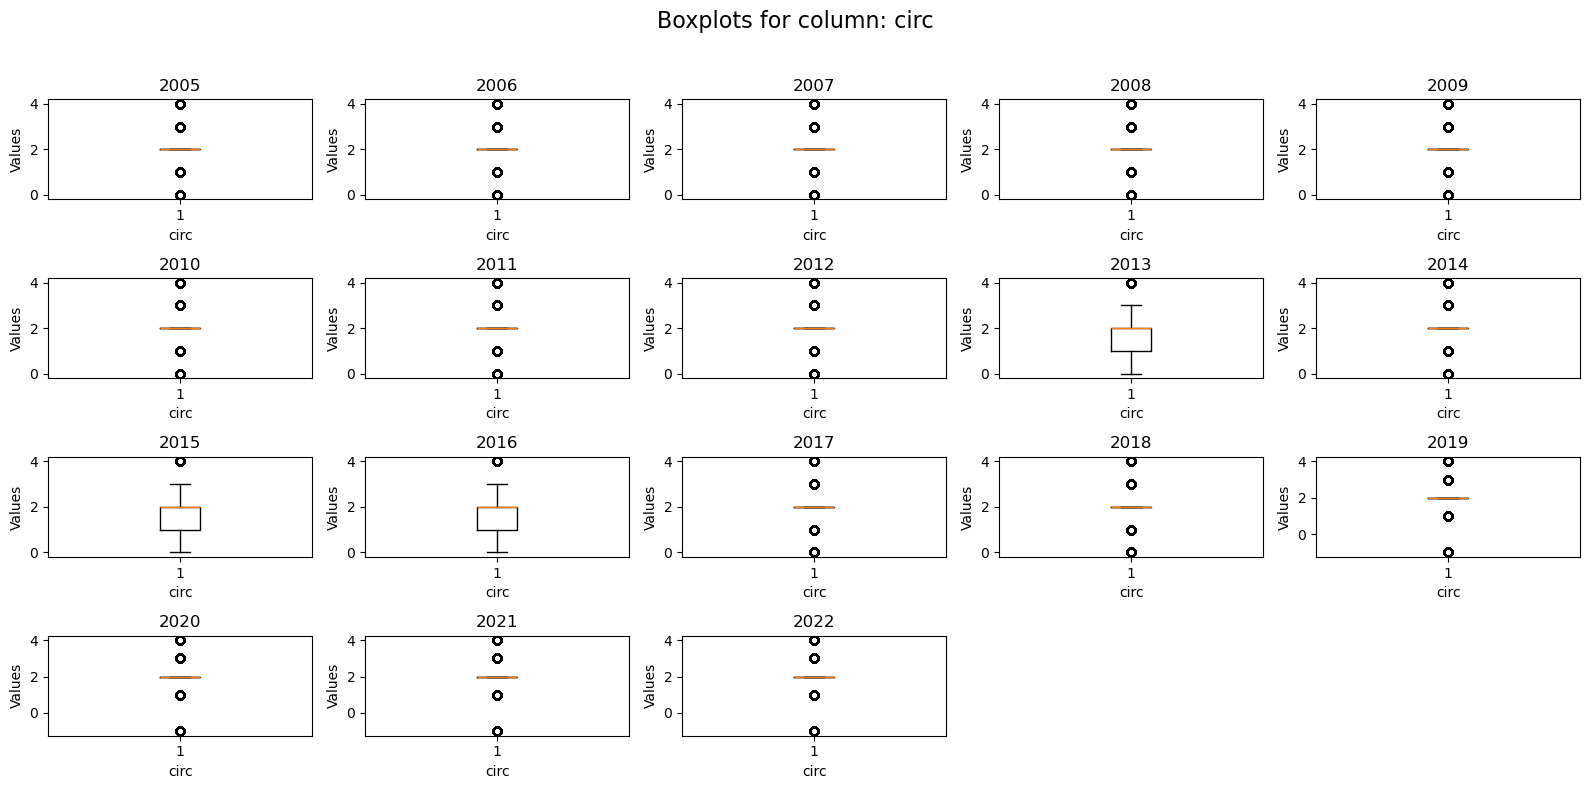

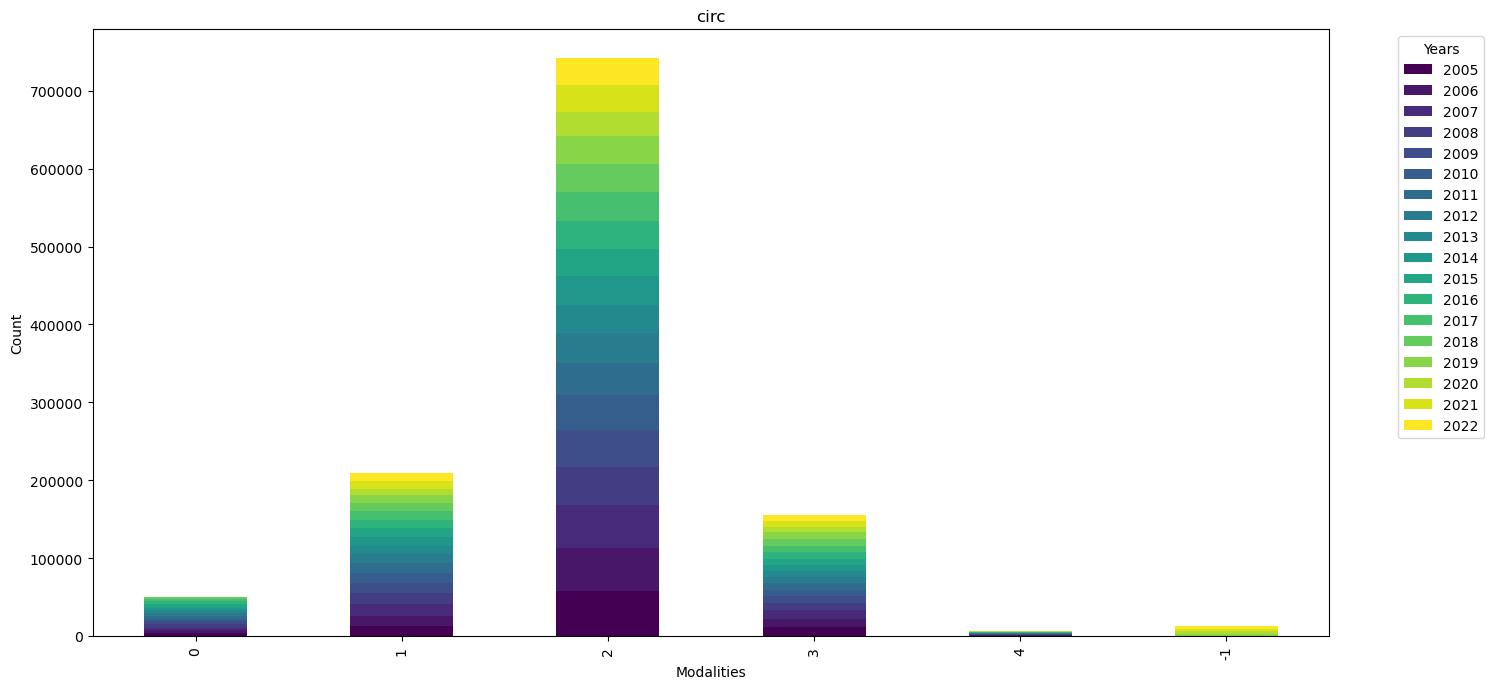

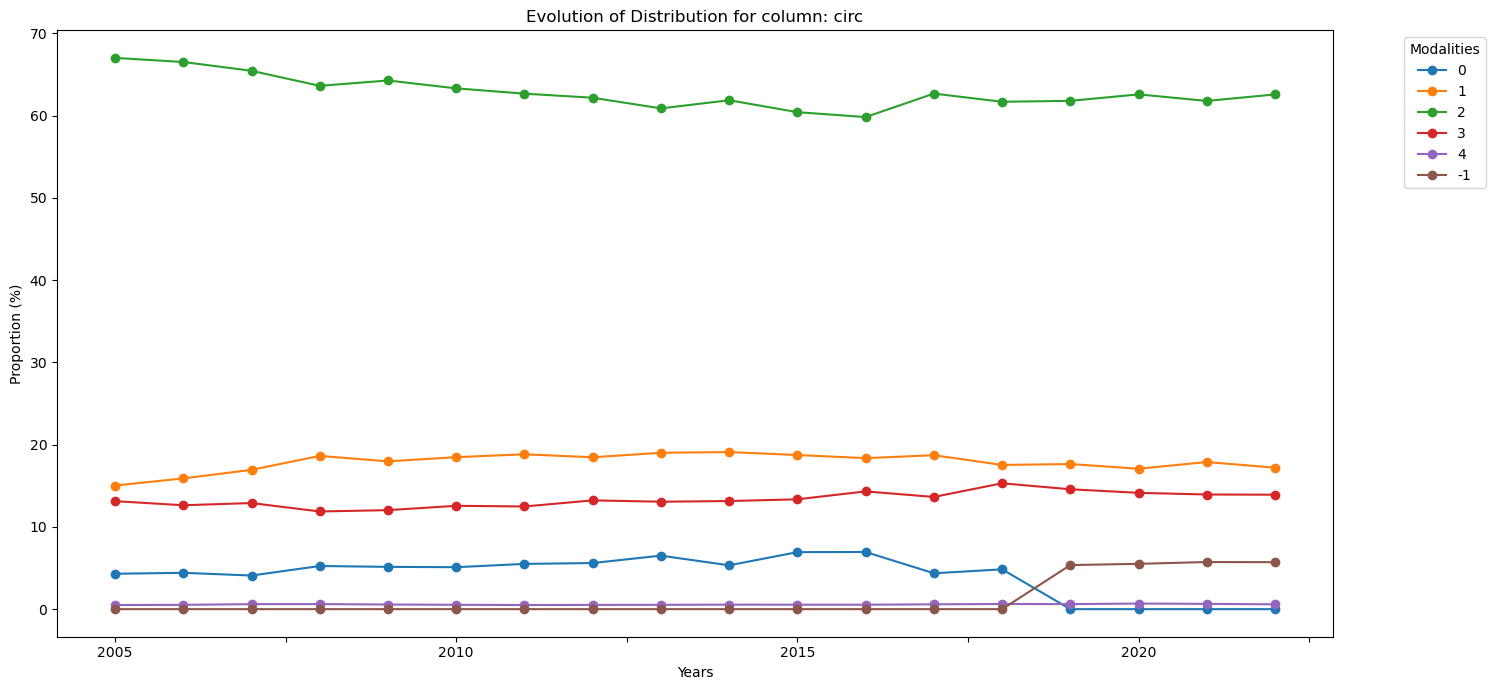

2024-10-24 13:43:58,673 - INFO - La colonne v2 n'est pas numérique.
2024-10-24 13:43:58,690 - WARNING - Le nombre de modalités uniques dans la colonne v2 excède le seuil de 50. Aucun bar plot généré.
2024-10-24 13:43:58,705 - WARNING - Le nombre de modalités uniques dans la colonne v2 excède le seuil de 12. Aucun graphique en ligne généré.


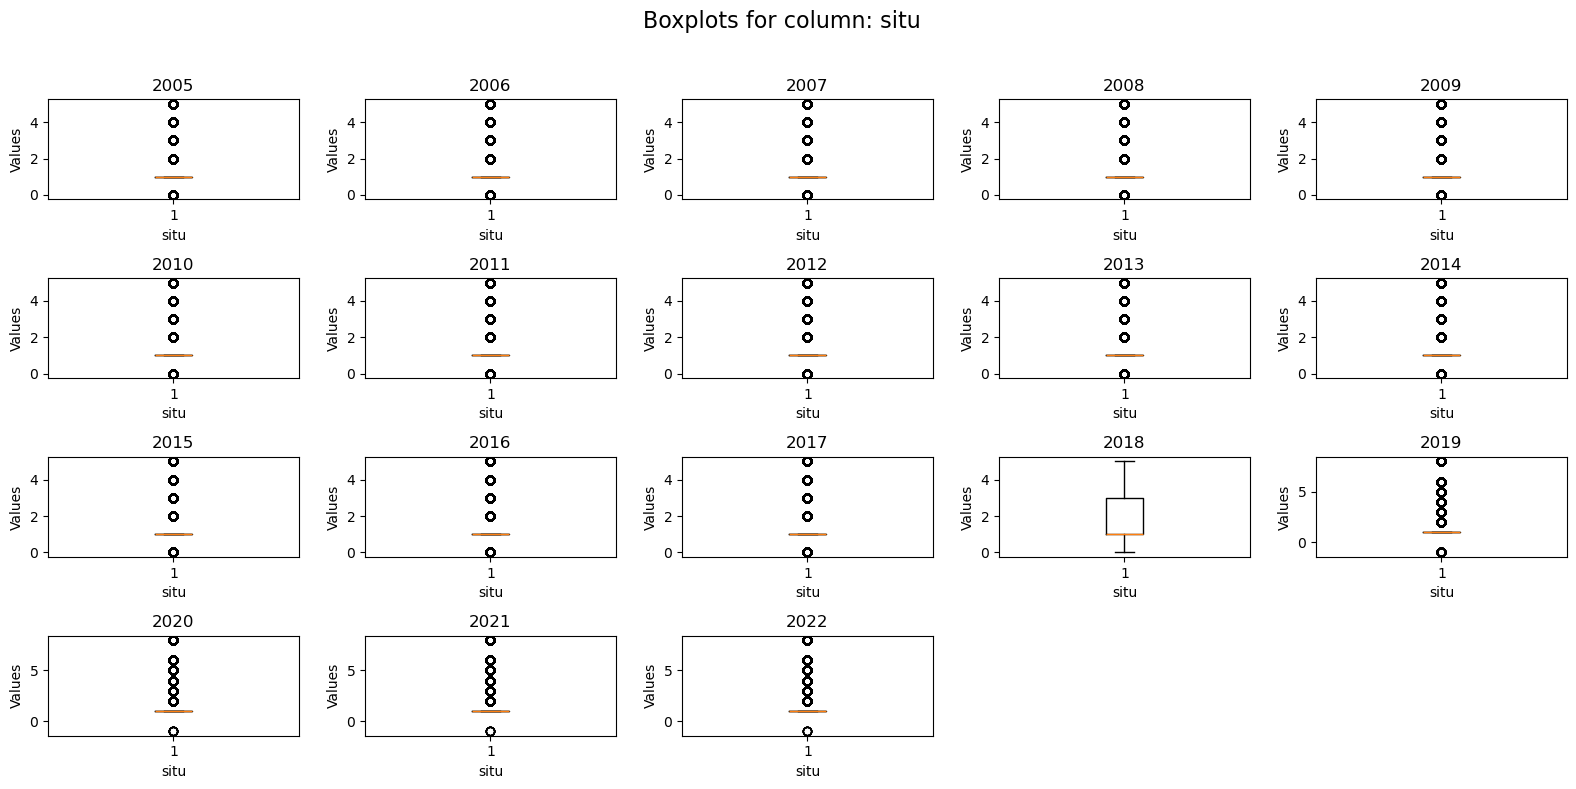

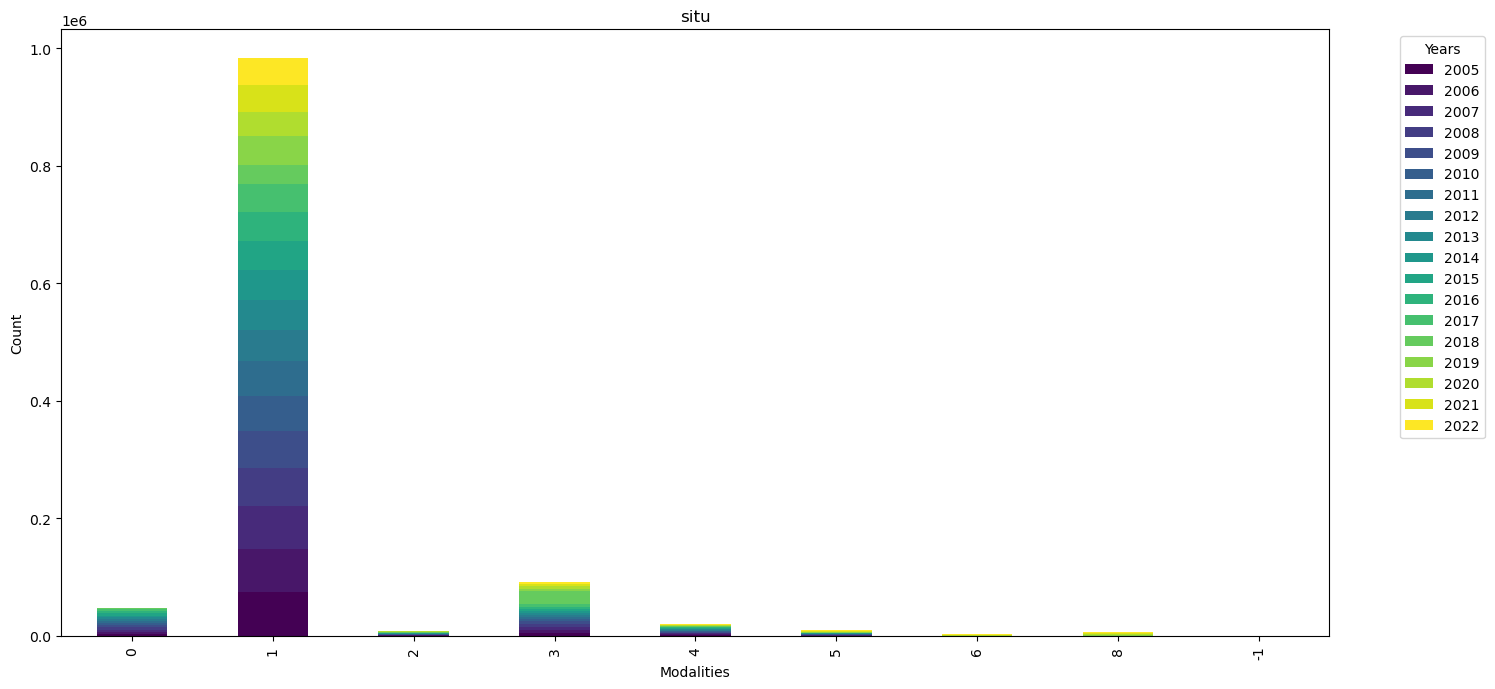

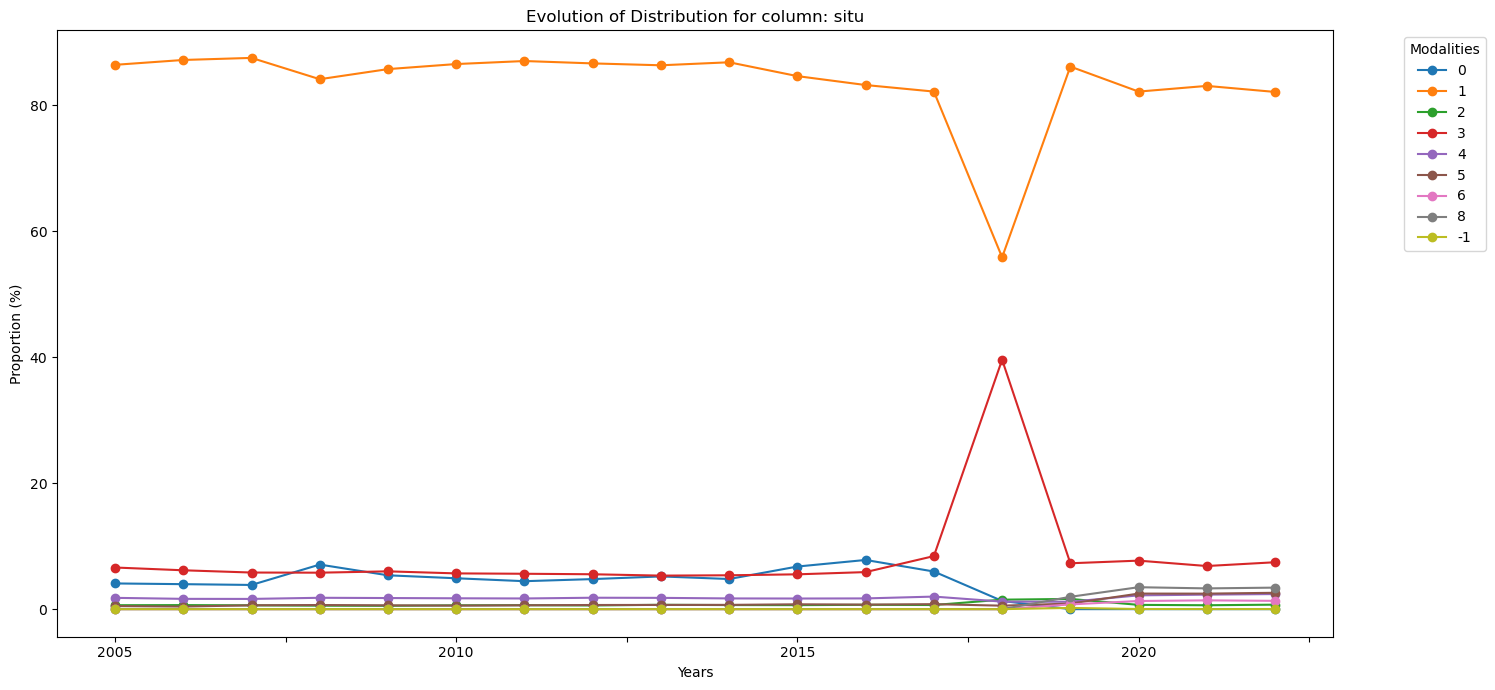

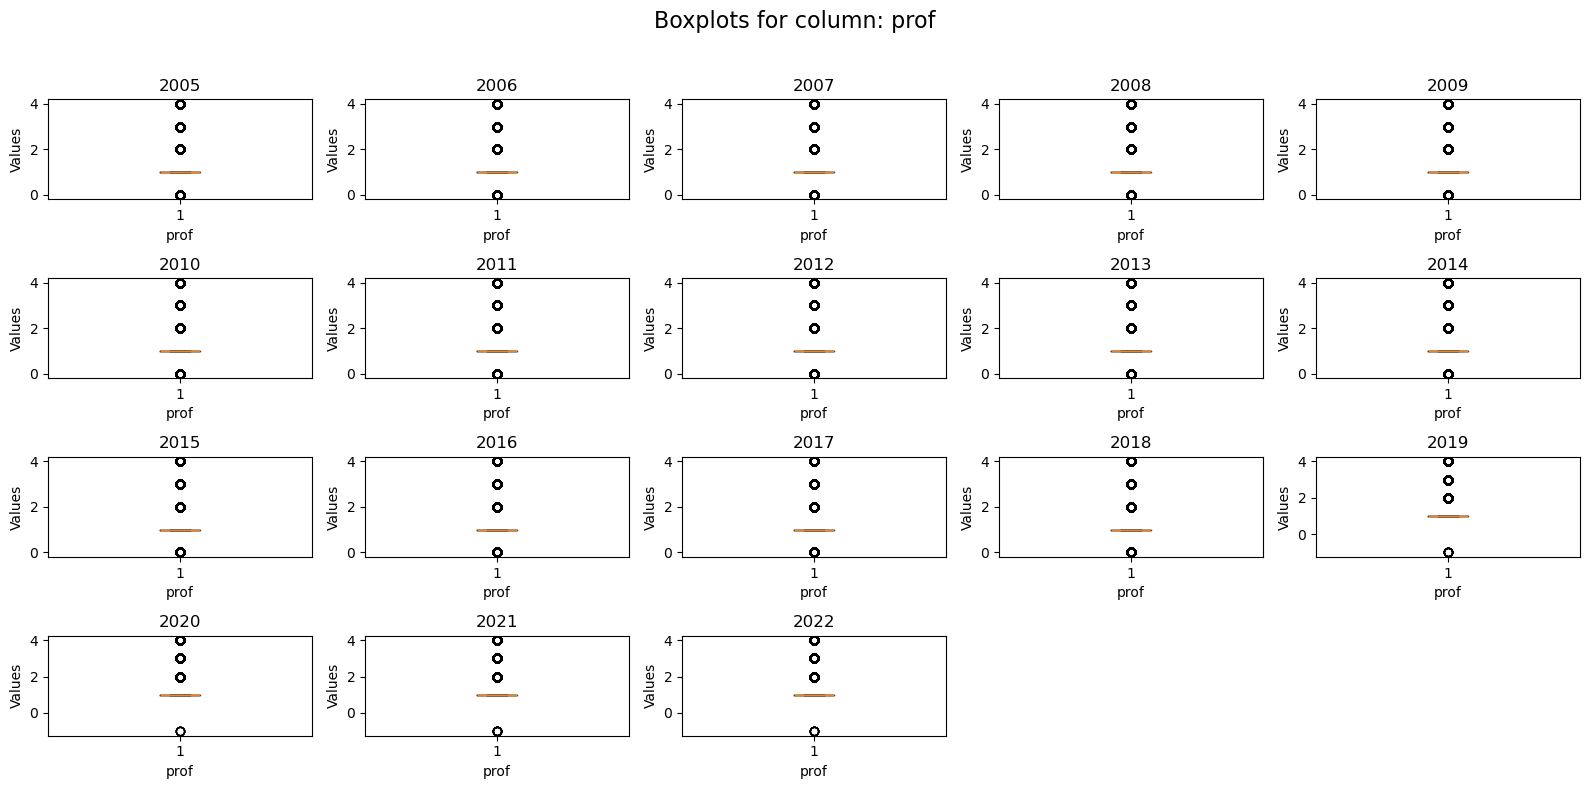

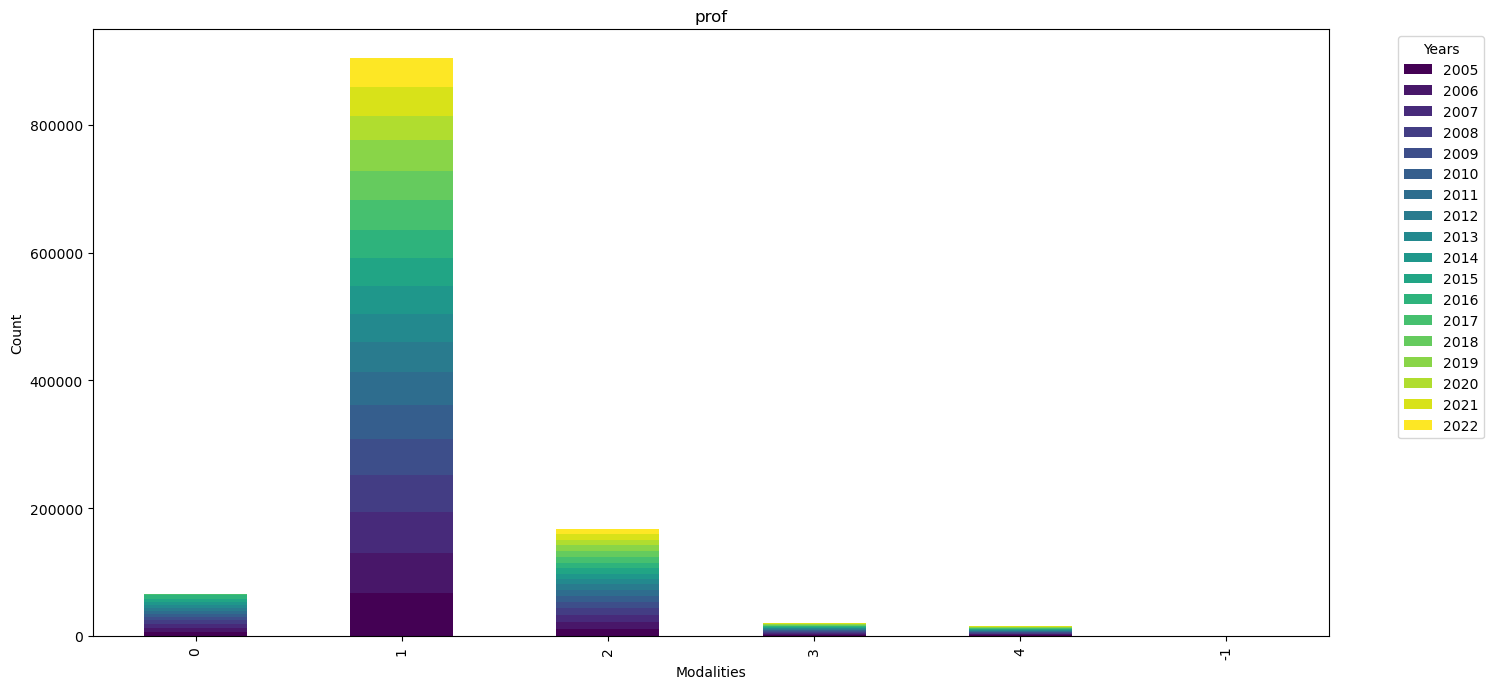

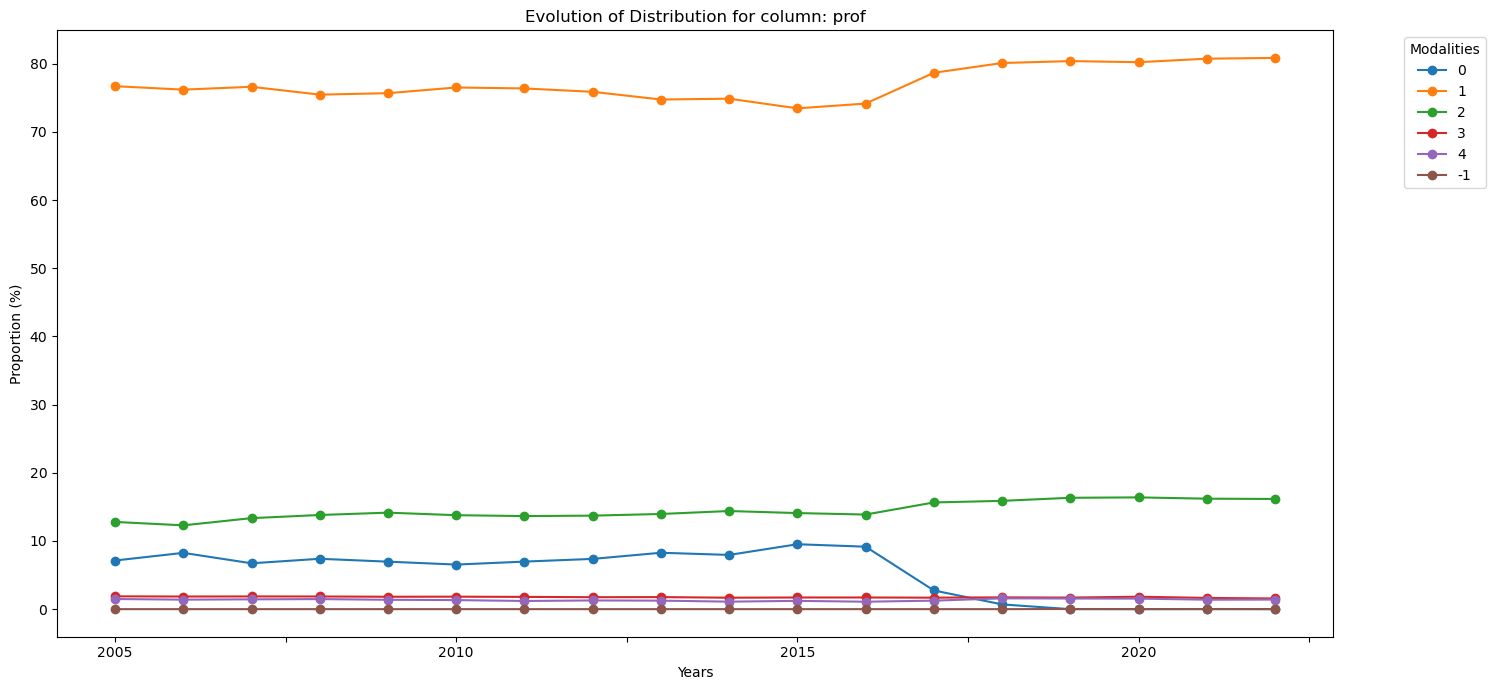

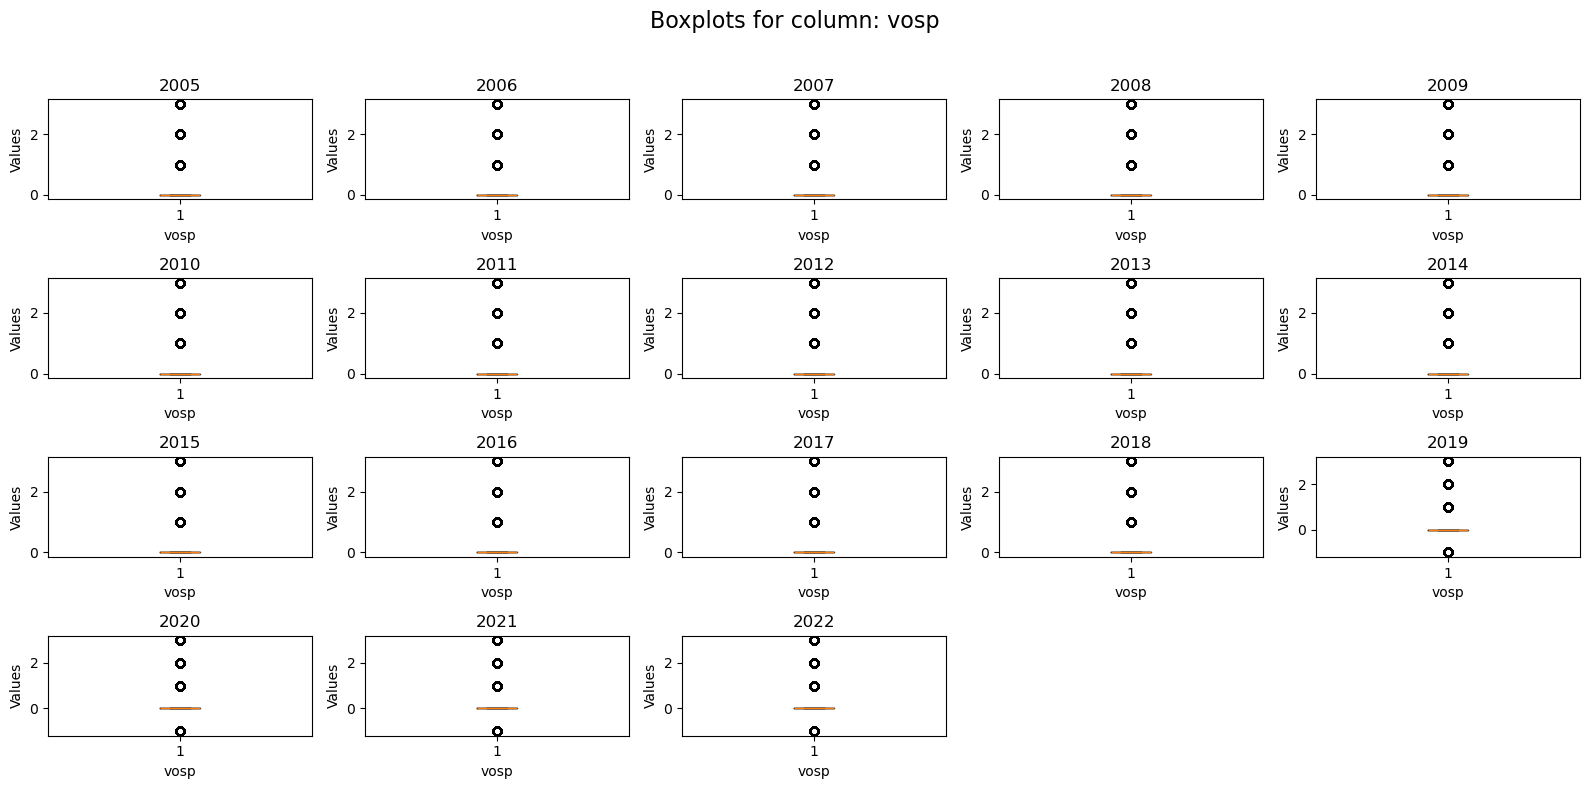

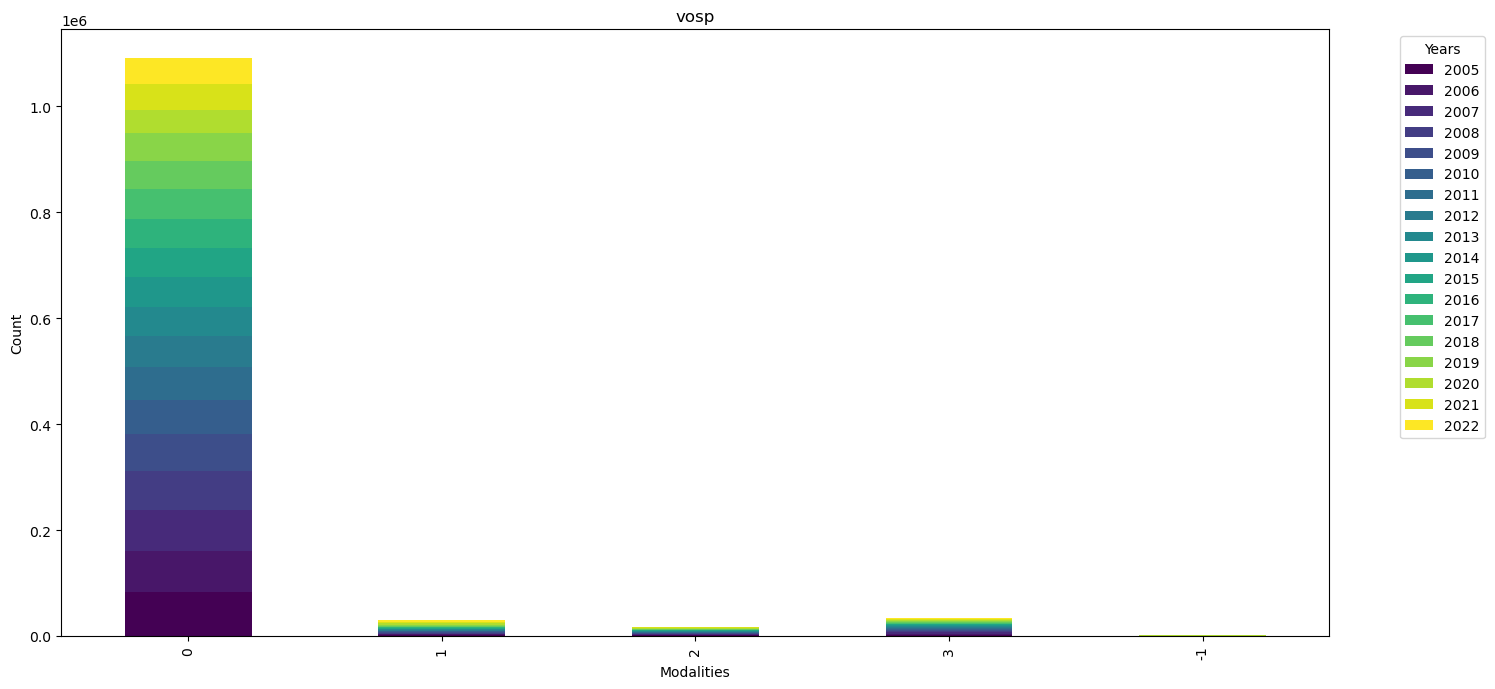

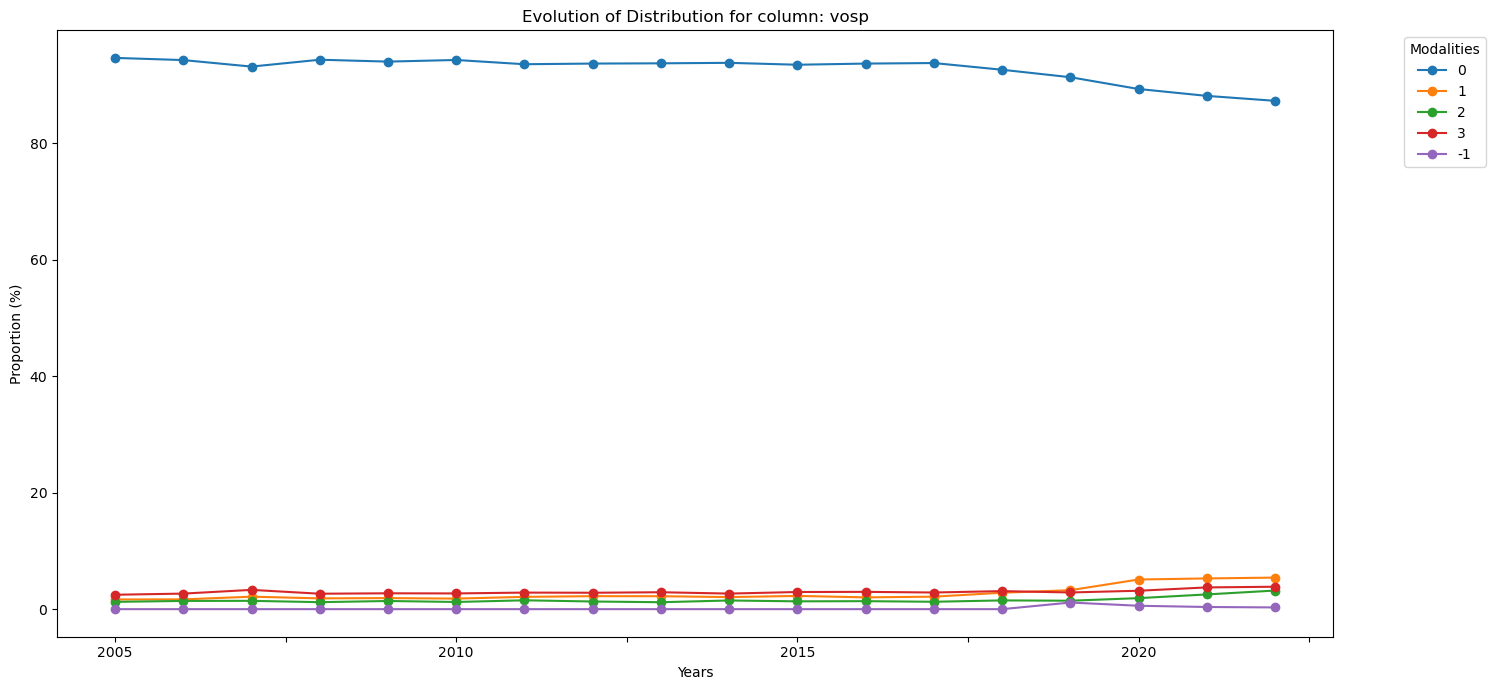

2024-10-24 13:44:03,960 - INFO - Chargement de usagers_2005.csv.
2024-10-24 13:44:03,960 - INFO - Chargement de usagers_2006.csv.
2024-10-24 13:44:03,960 - INFO - Chargement de usagers_2007.csv.
2024-10-24 13:44:03,960 - INFO - Chargement de usagers_2008.csv.
2024-10-24 13:44:03,960 - INFO - Chargement de usagers_2009.csv.
2024-10-24 13:44:03,960 - INFO - Chargement de usagers_2010.csv.
2024-10-24 13:44:03,960 - INFO - Chargement de usagers_2011.csv.
2024-10-24 13:44:03,960 - INFO - Chargement de usagers_2012.csv.
2024-10-24 13:44:03,974 - INFO - Chargement de usagers_2013.csv.
2024-10-24 13:44:03,975 - INFO - Chargement de usagers_2014.csv.
2024-10-24 13:44:03,976 - INFO - Chargement de usagers_2015.csv.
2024-10-24 13:44:03,977 - INFO - Chargement de usagers_2016.csv.
2024-10-24 13:44:03,977 - INFO - Chargement de usagers-2017.csv.
2024-10-24 13:44:03,978 - INFO - Chargement de usagers-2018.csv.
2024-10-24 13:44:03,978 - INFO - Chargement de usagers-2019.csv.
2024-10-24 13:44:03,979 -

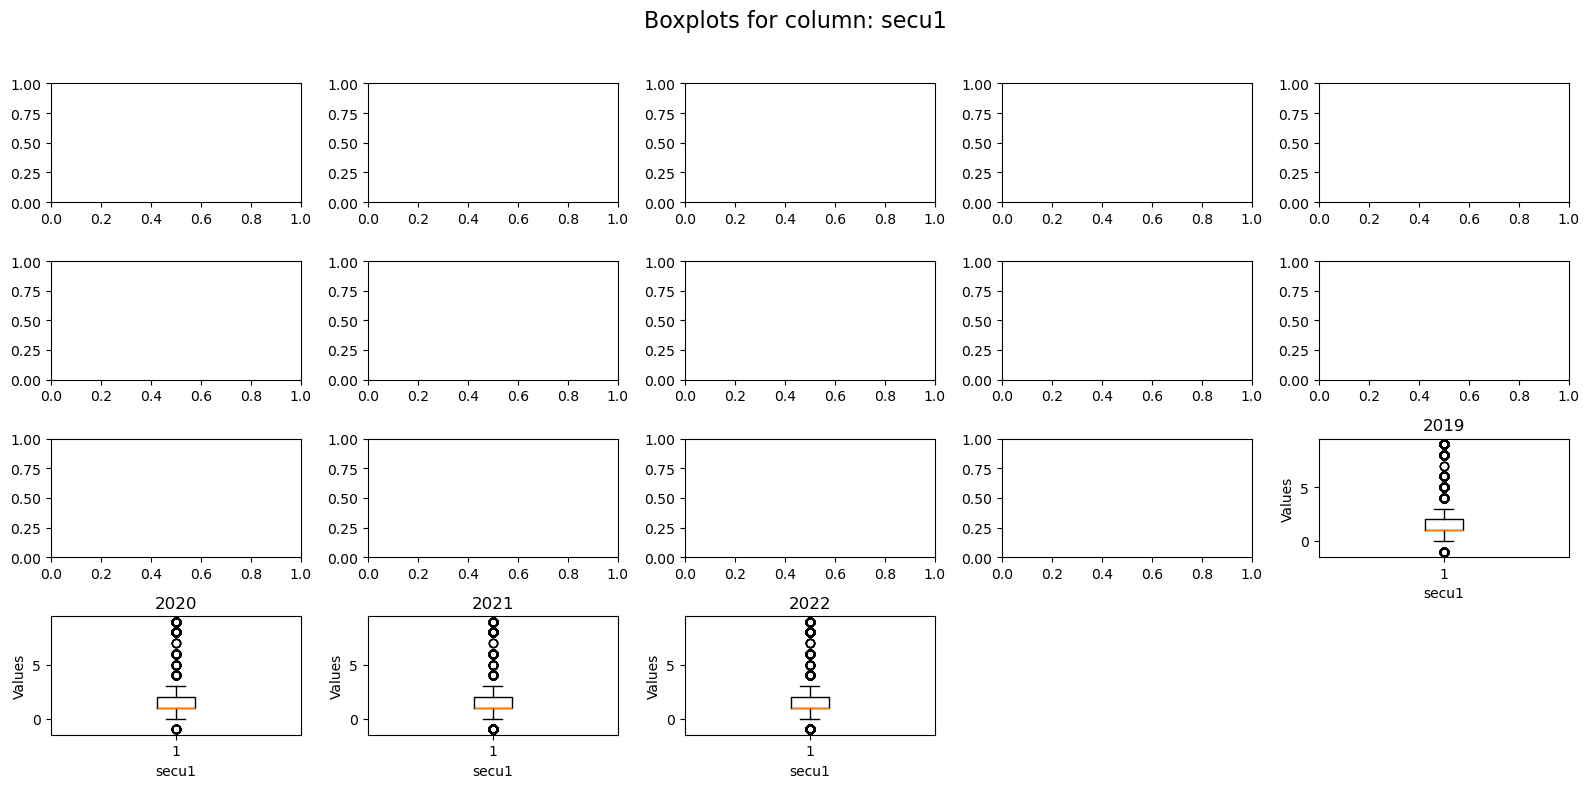

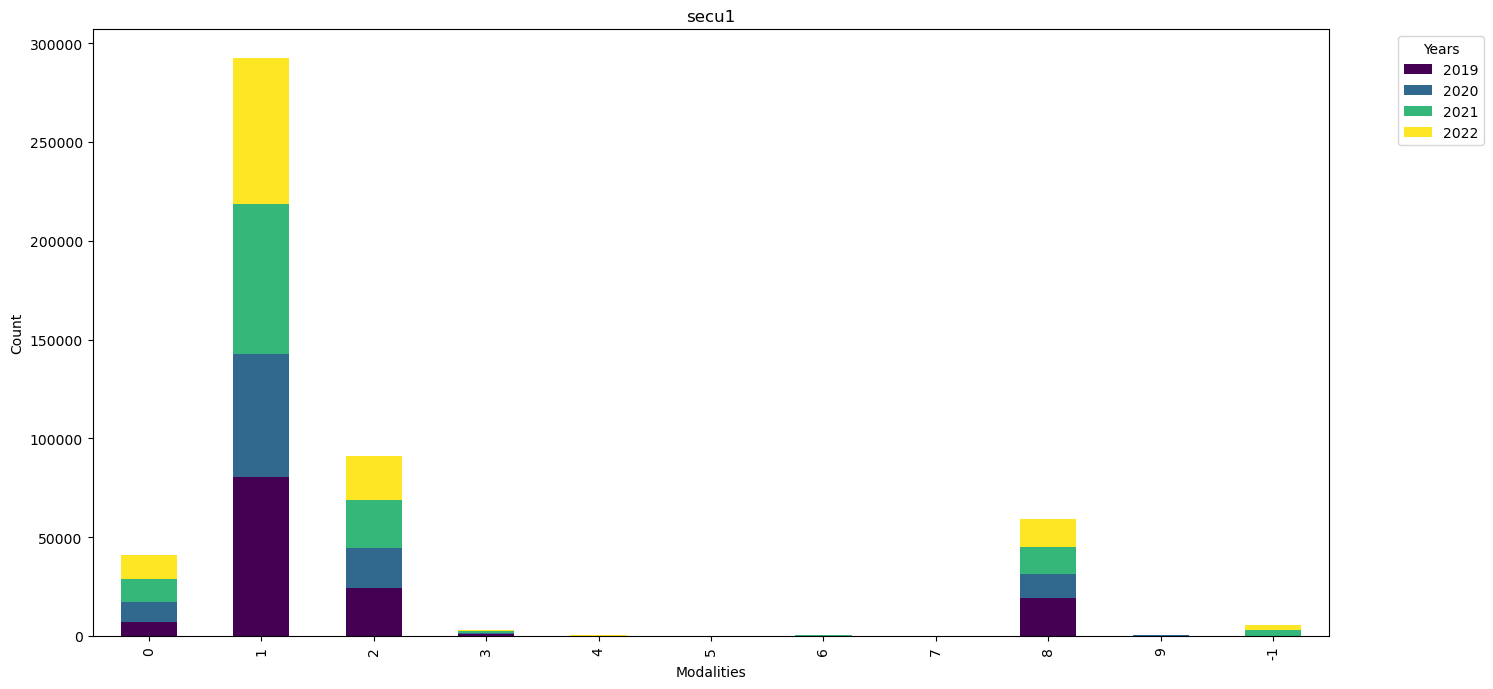

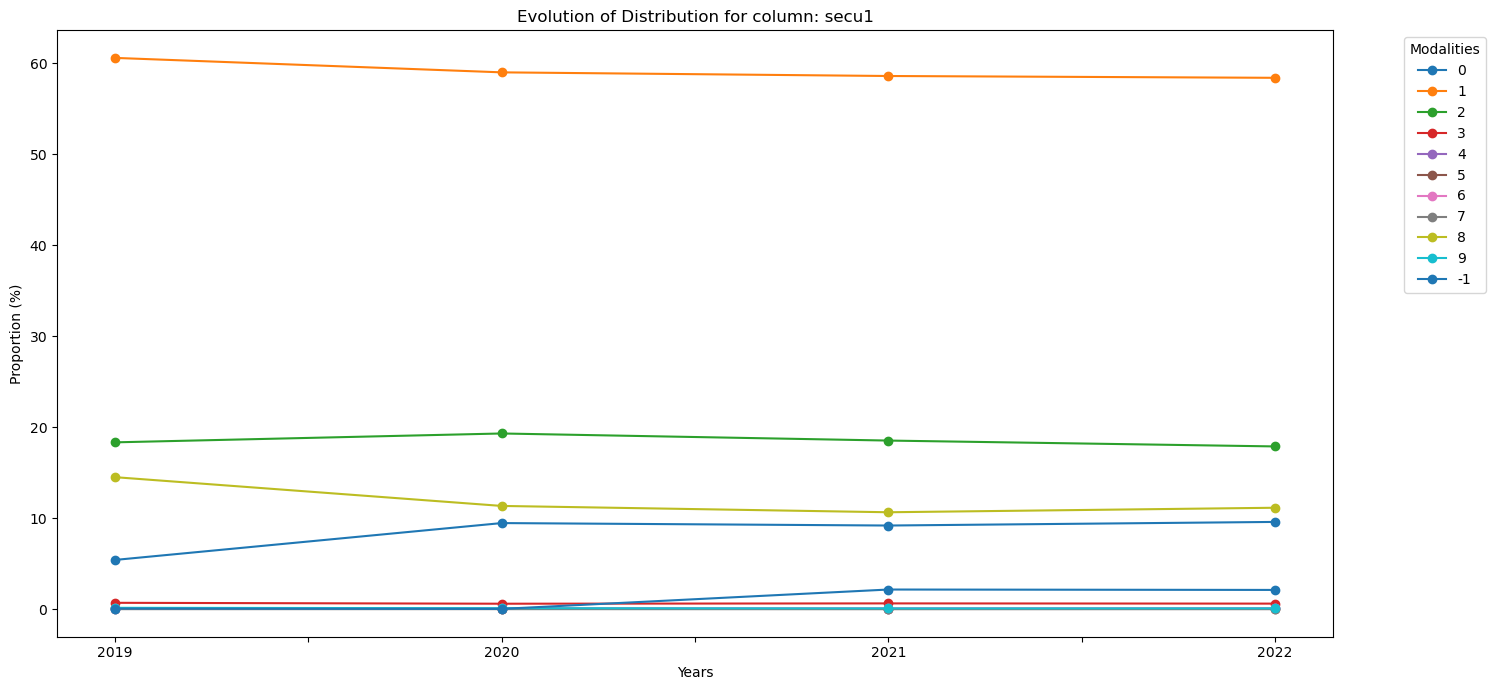

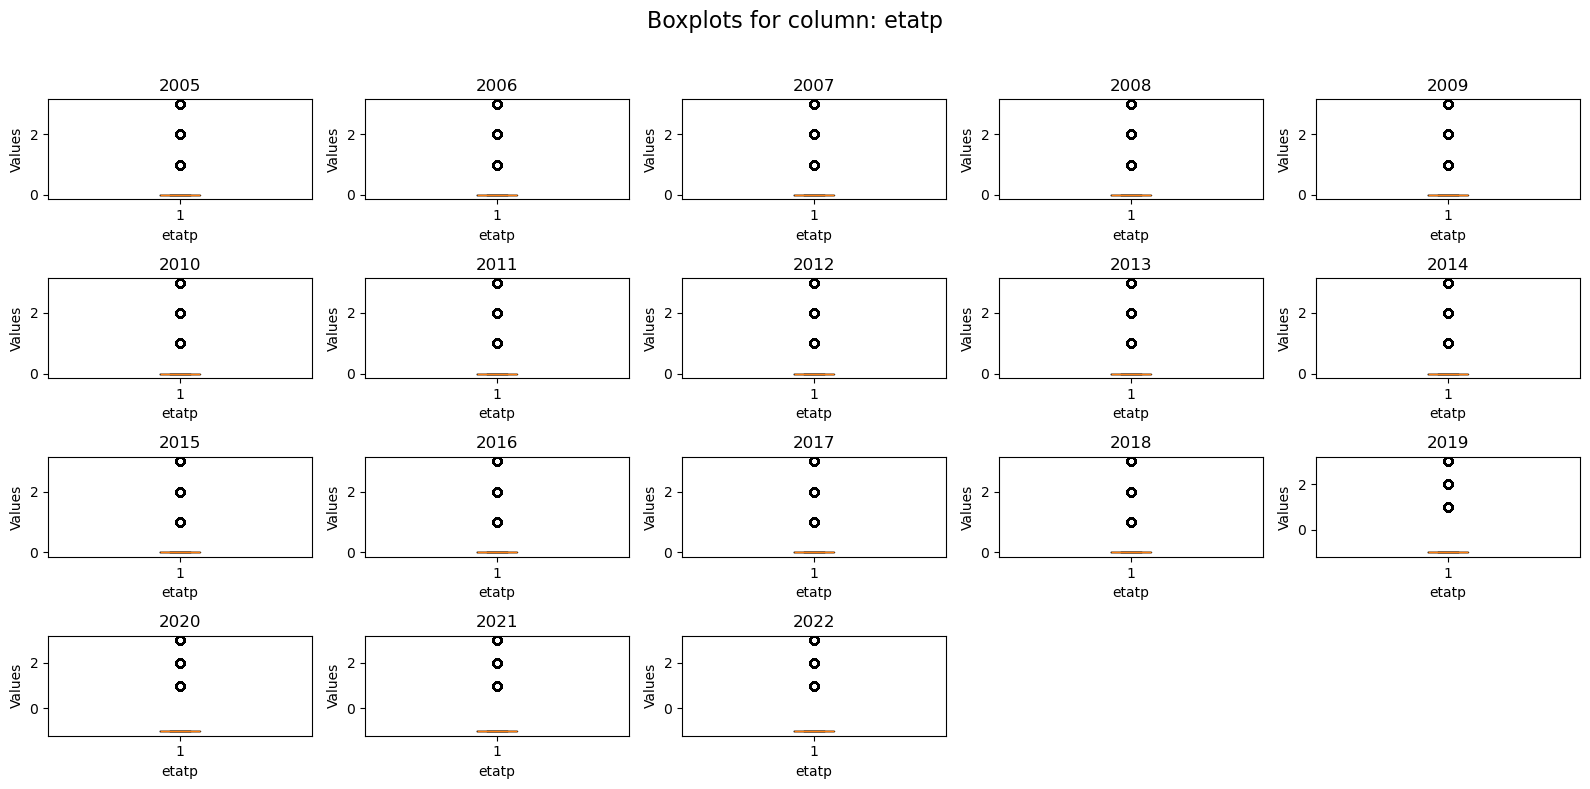

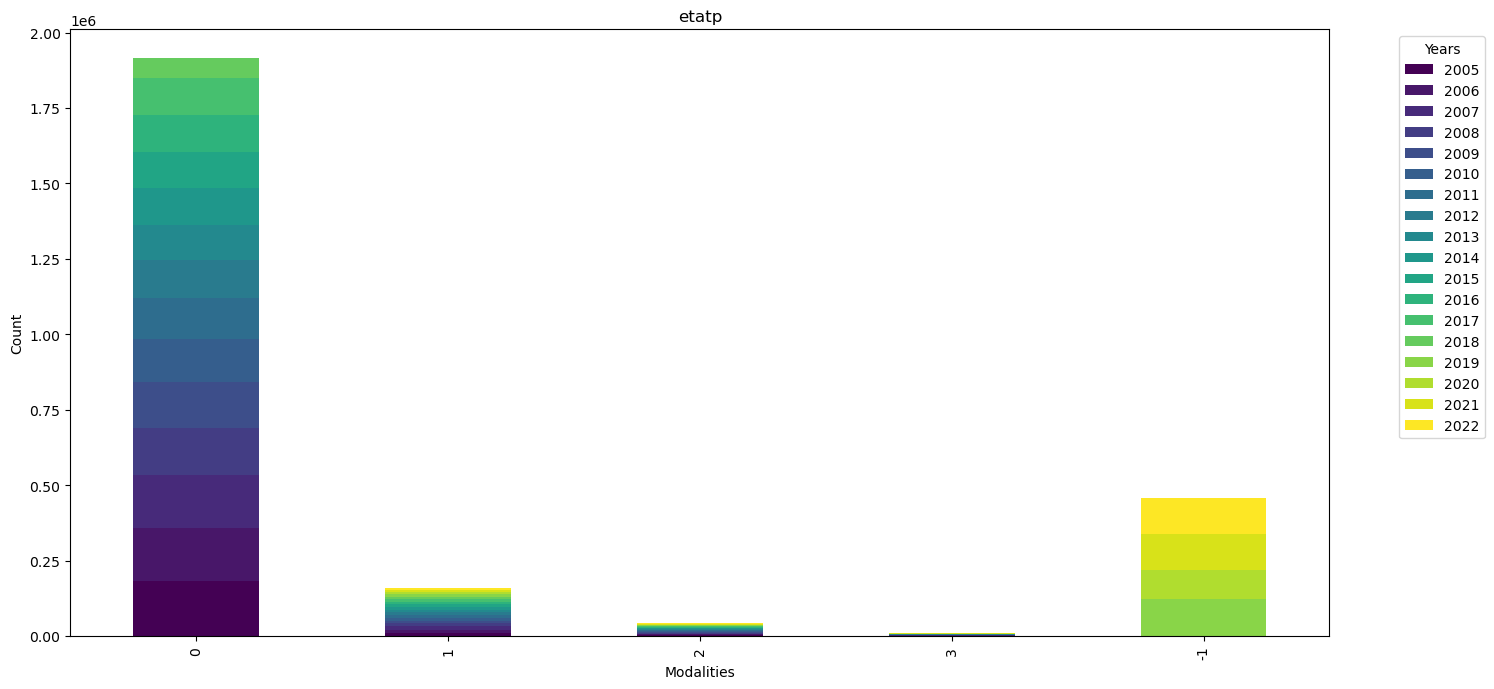

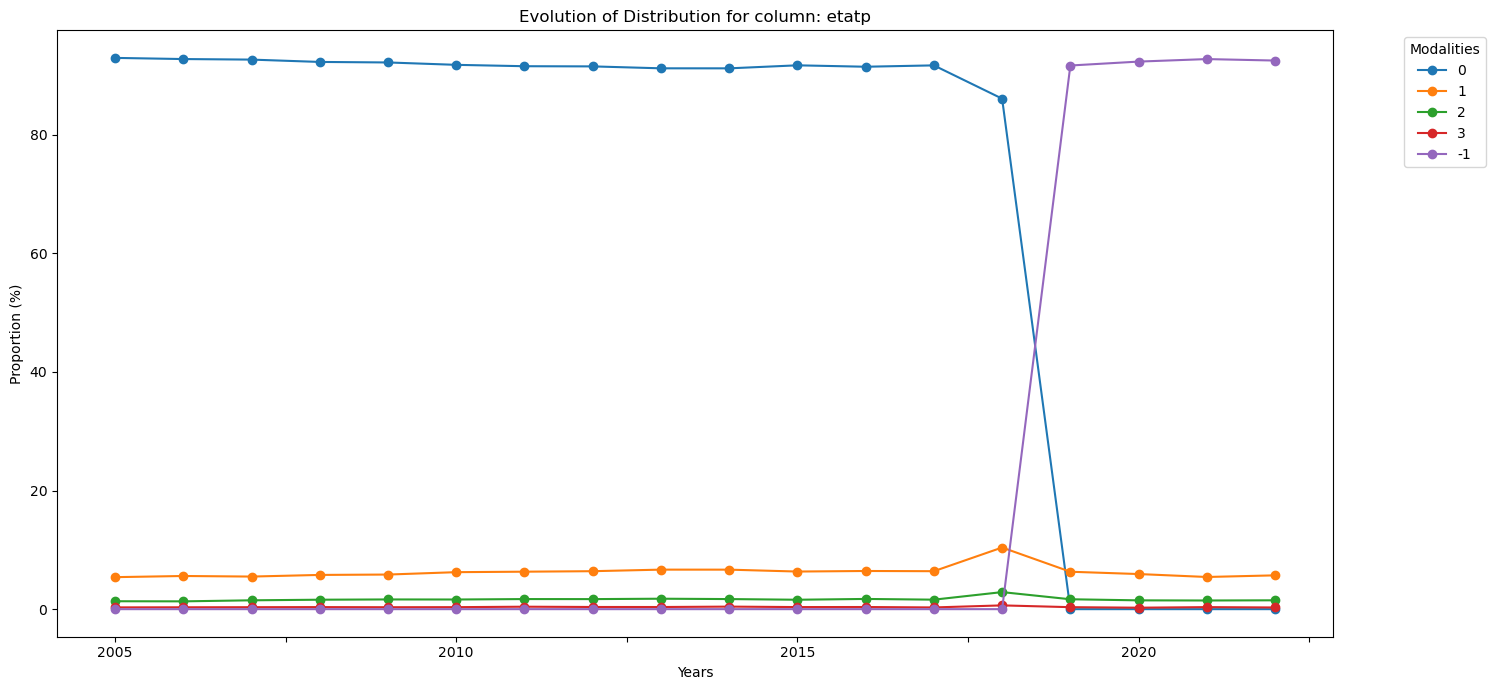

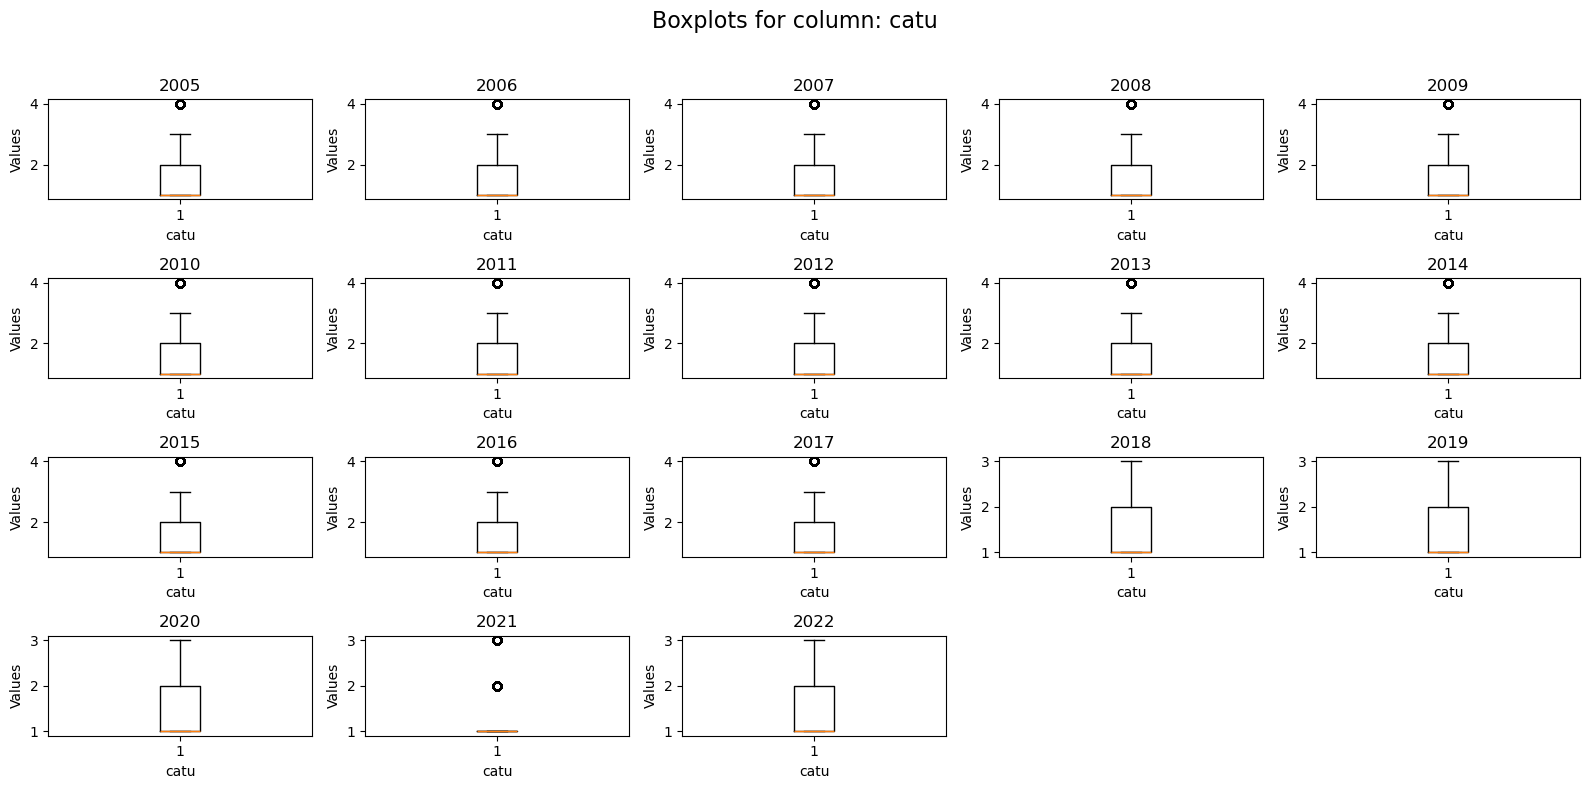

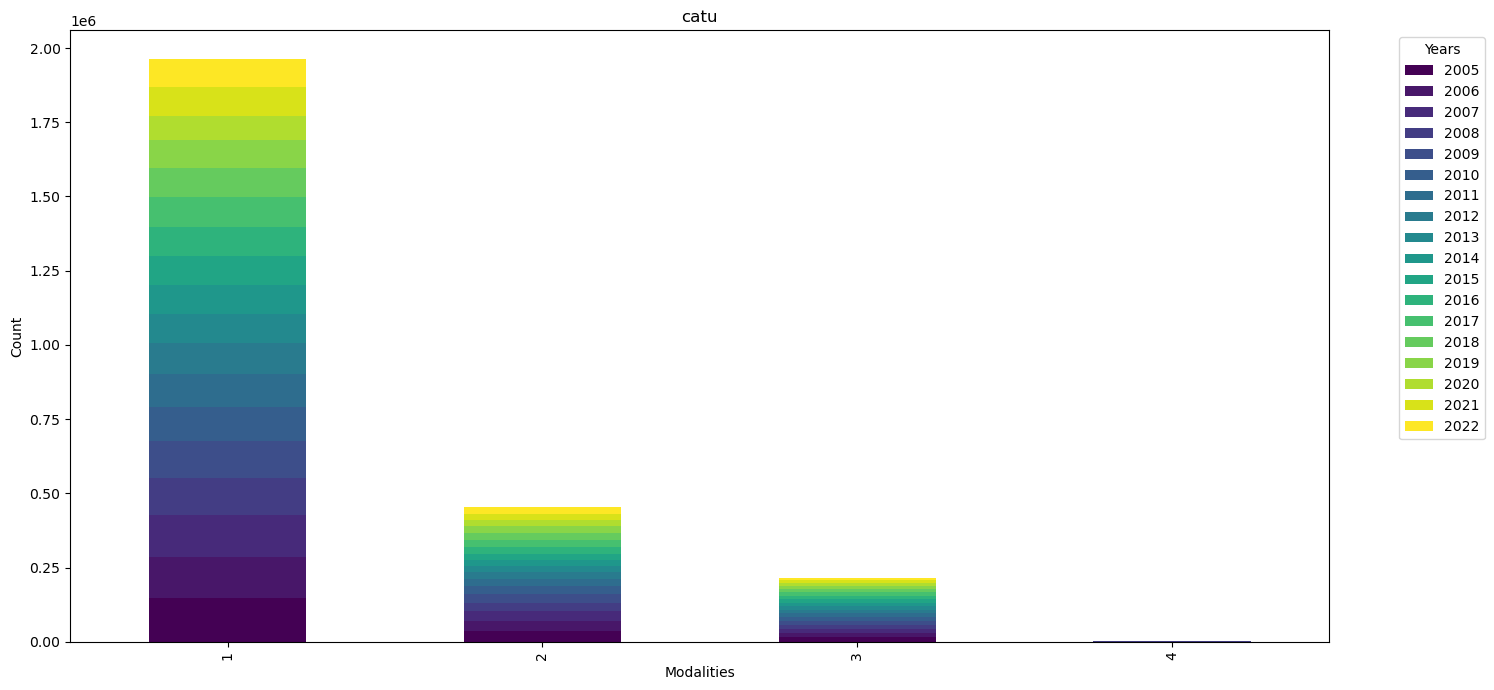

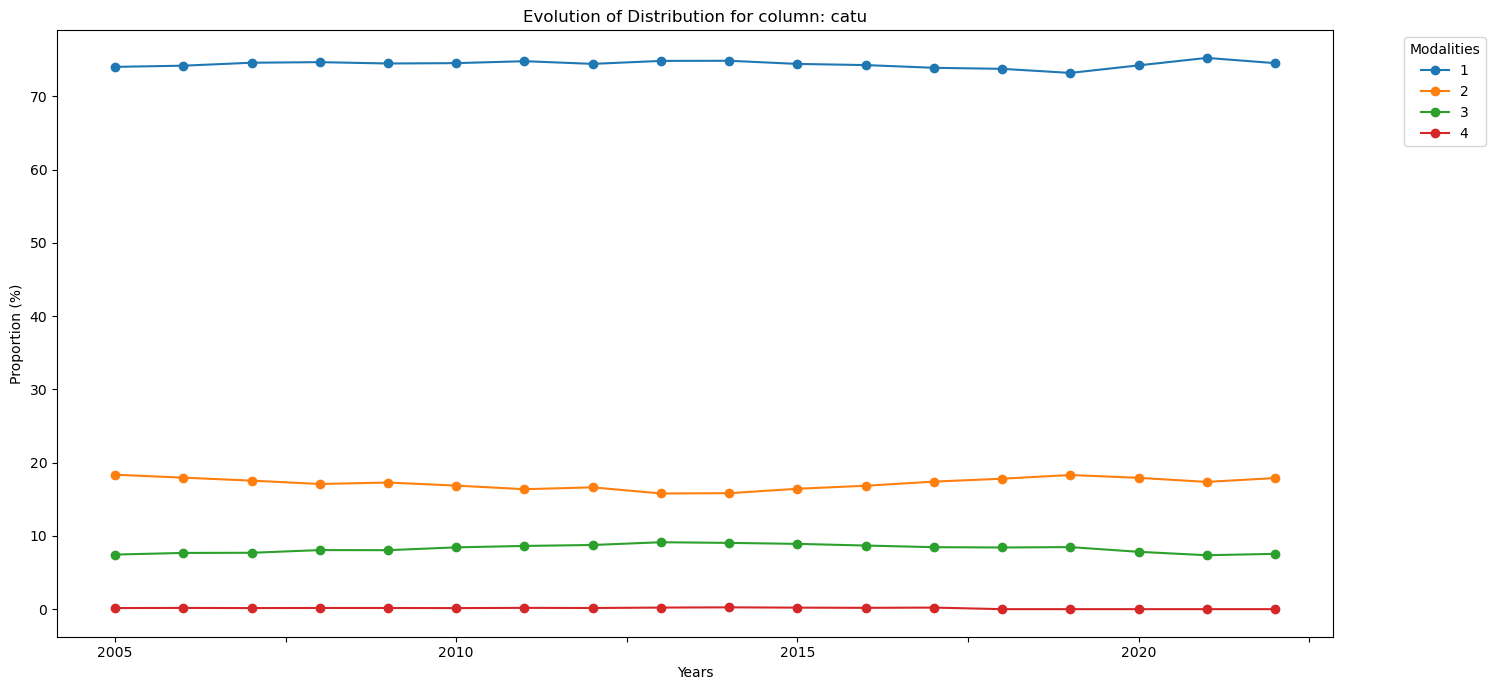

2024-10-24 13:44:09,322 - INFO - La colonne id_usager n'est pas numérique.
2024-10-24 13:44:09,416 - WARNING - Le nombre de modalités uniques dans la colonne id_usager excède le seuil de 50. Aucun bar plot généré.
2024-10-24 13:44:09,525 - WARNING - Le nombre de modalités uniques dans la colonne id_usager excède le seuil de 12. Aucun graphique en ligne généré.


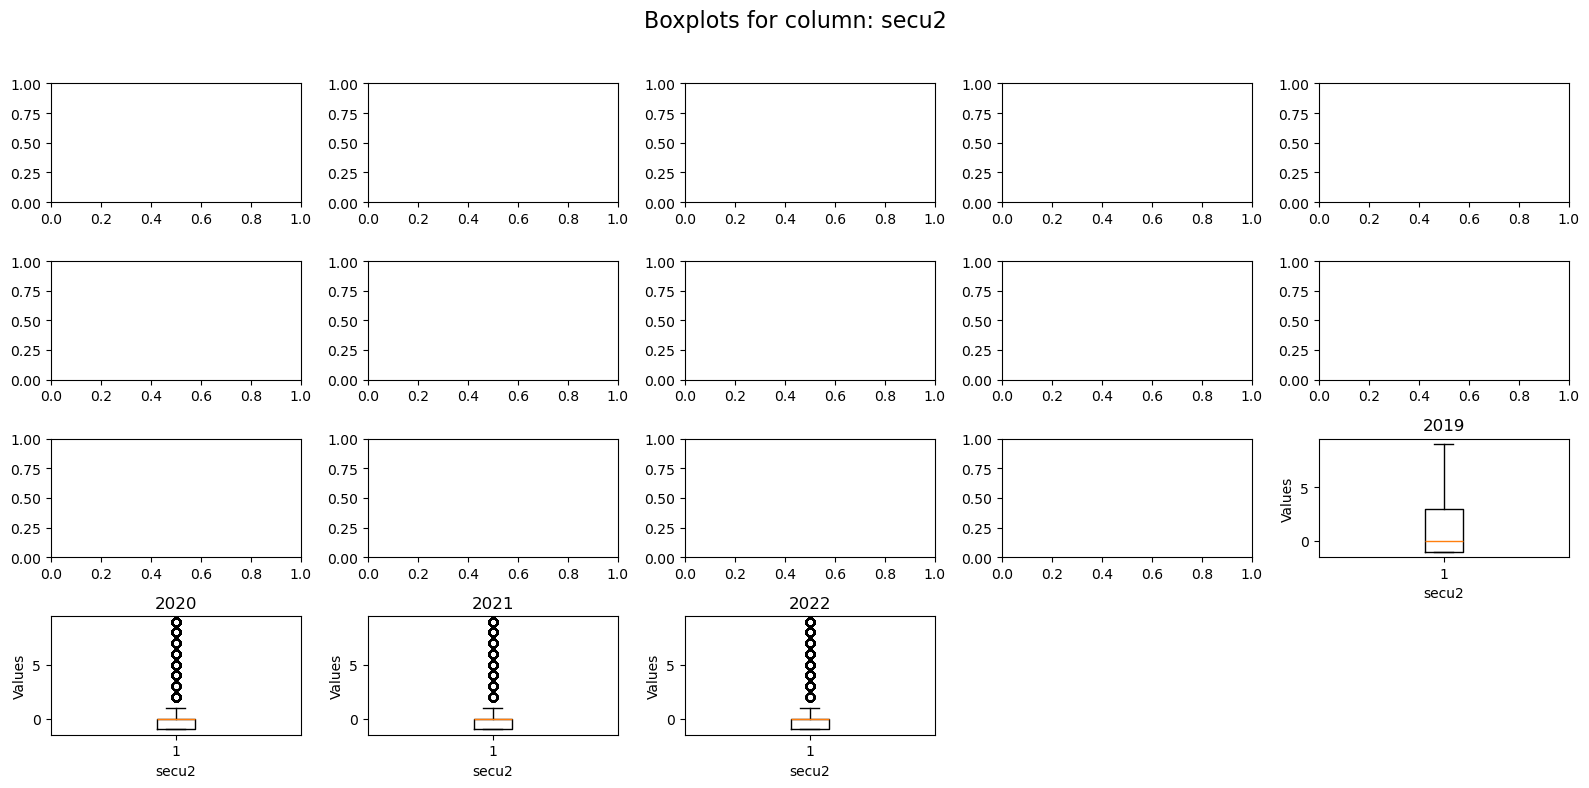

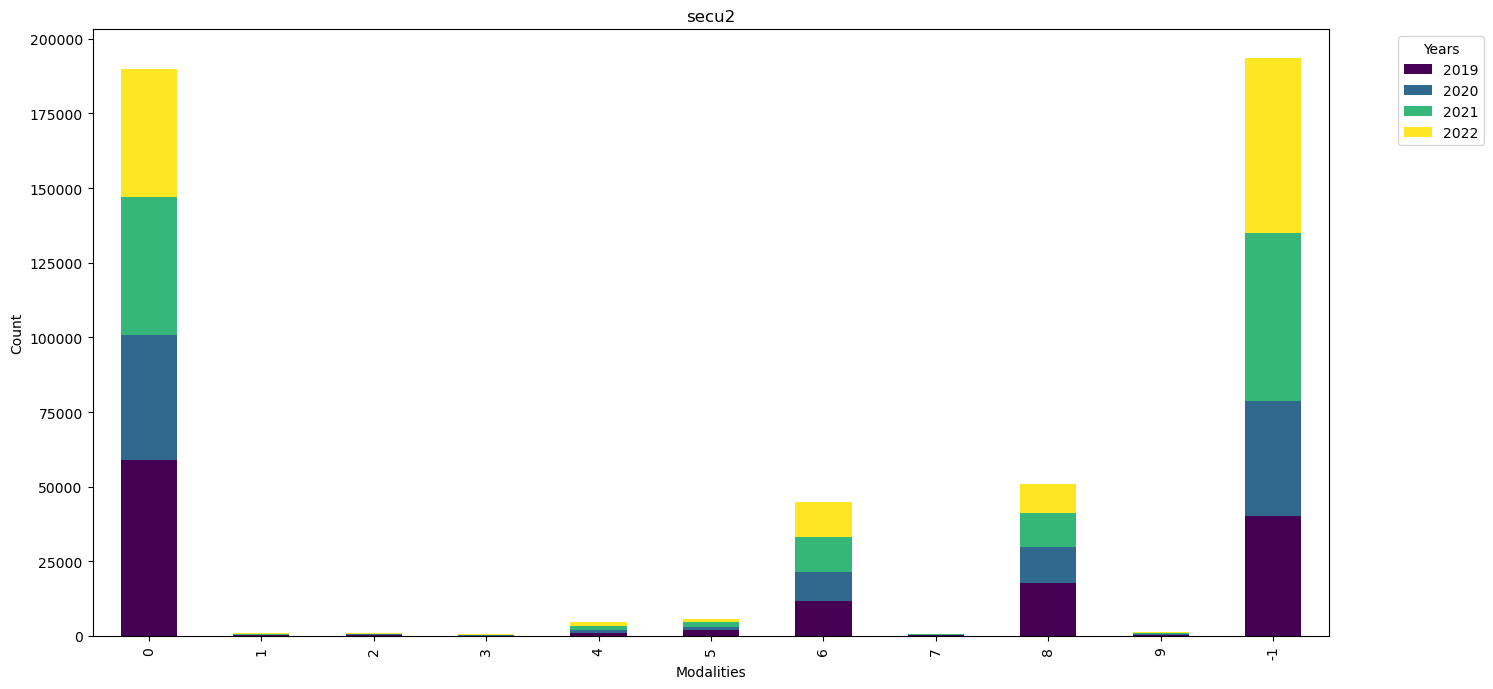

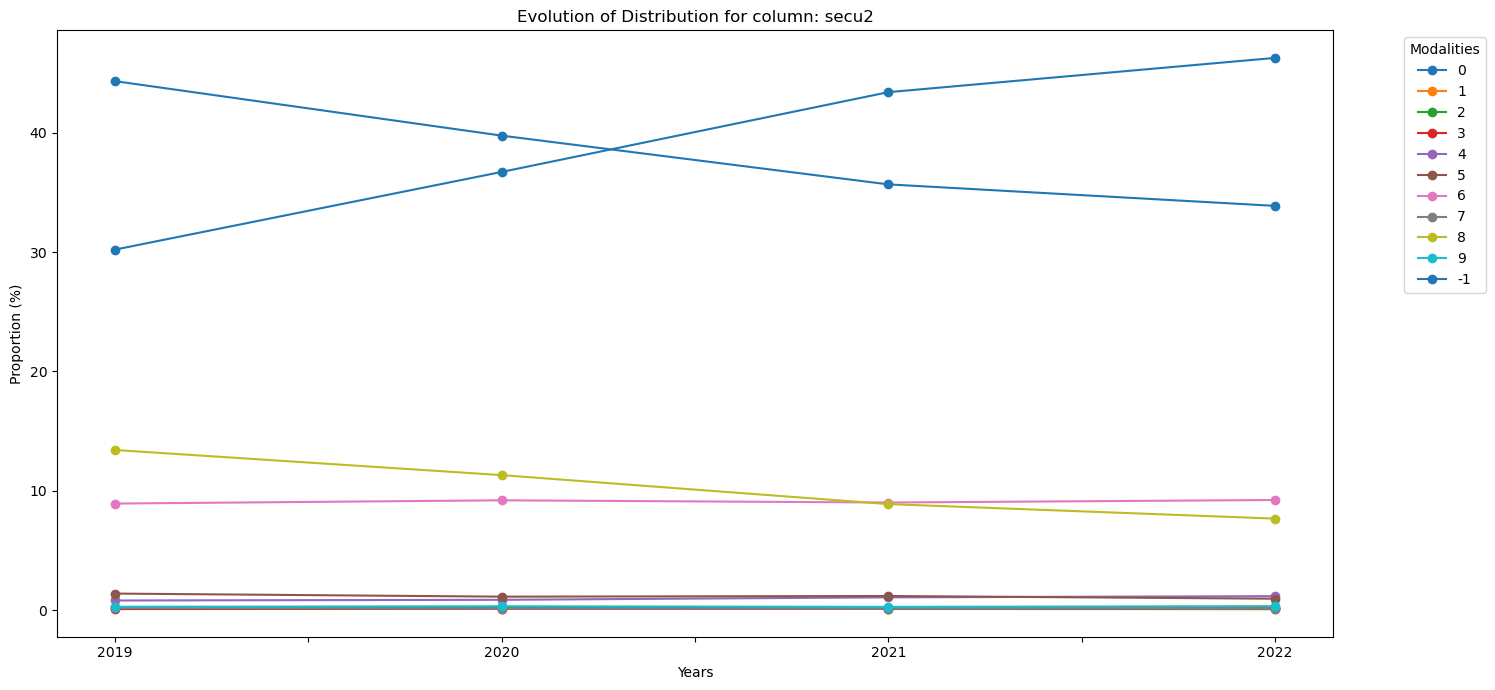

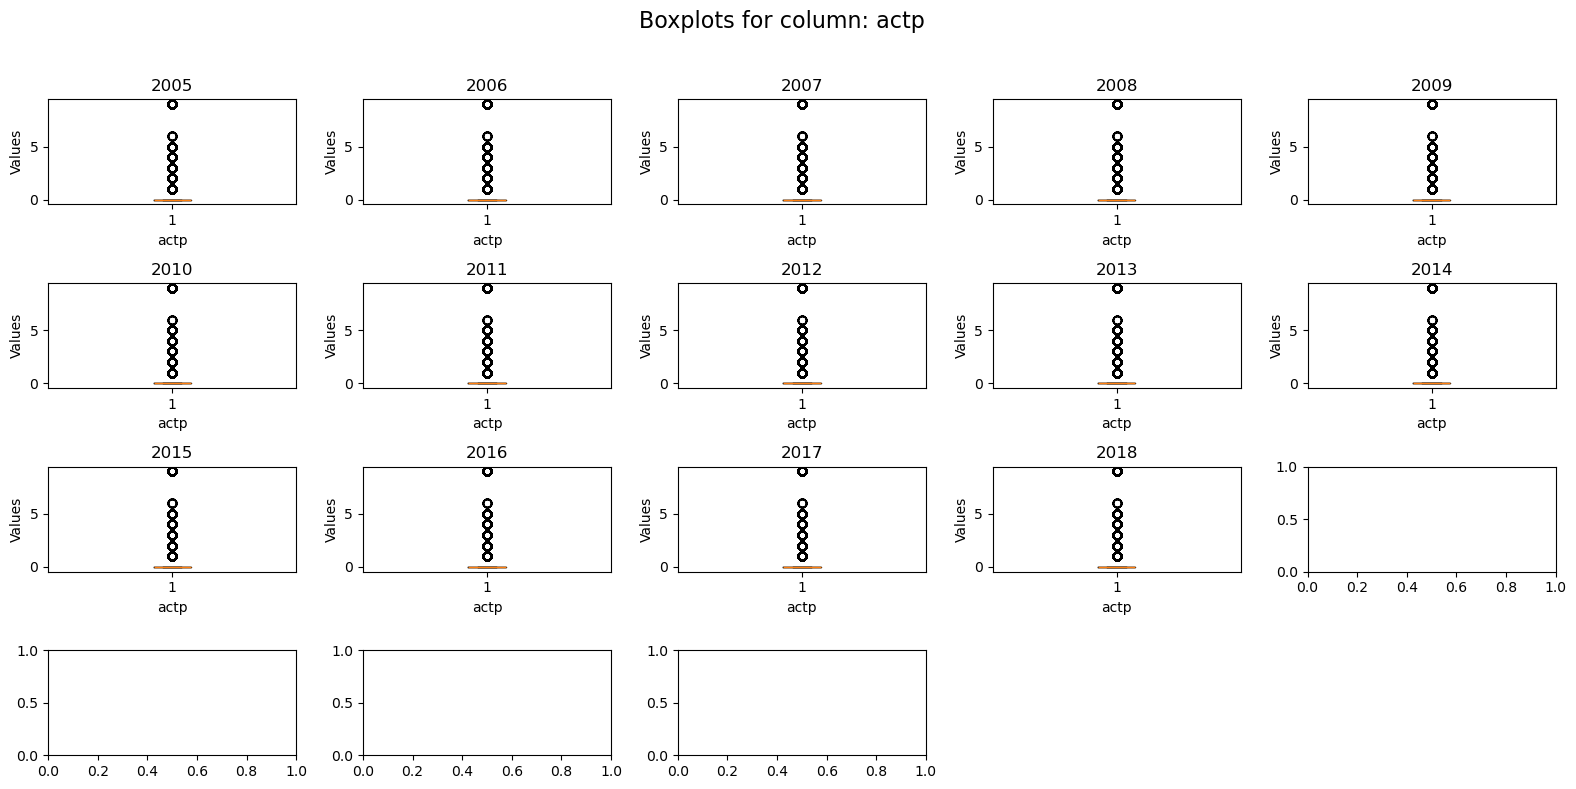

C:\Users\erika\AppData\Local\Temp\ipykernel_6284\2576061657.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  count = modality_counts[file_name].get(modality, 0)


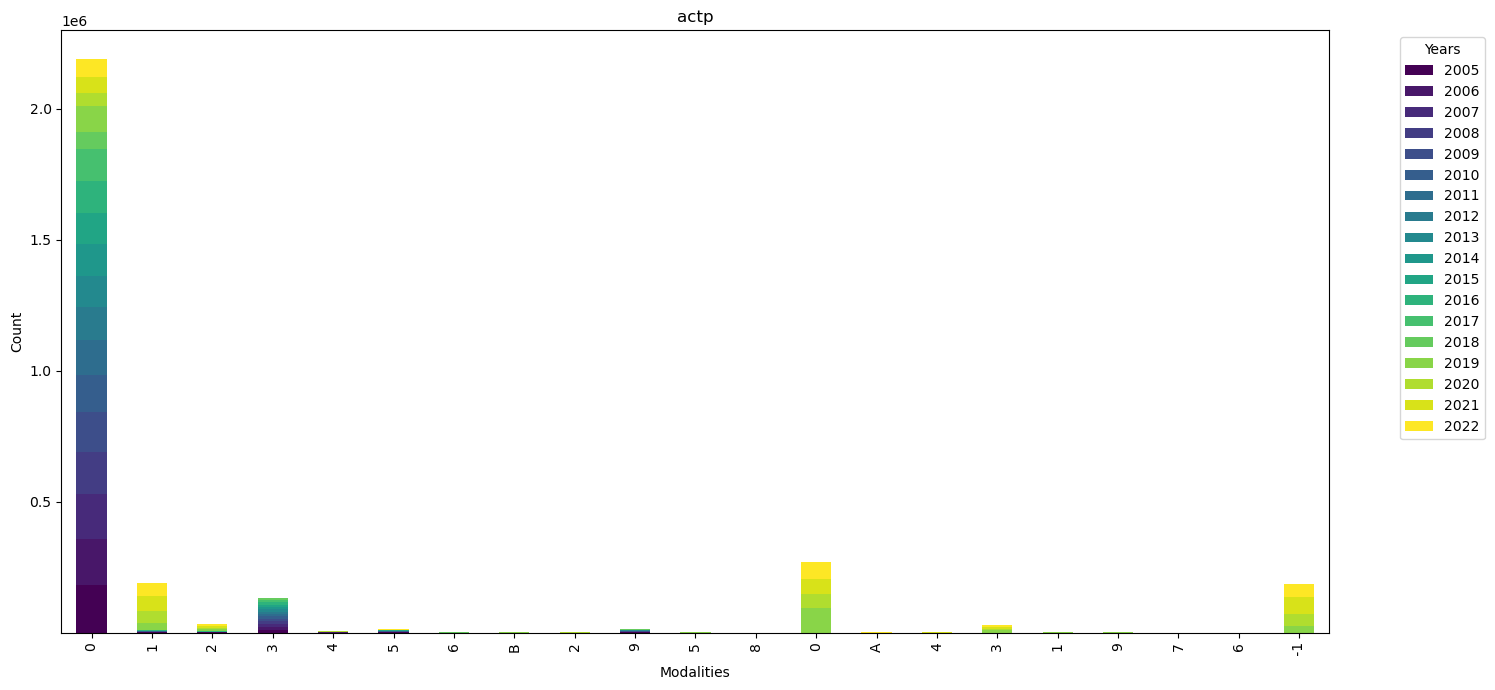

2024-10-24 13:44:13,684 - WARNING - Le nombre de modalités uniques dans la colonne actp excède le seuil de 12. Aucun graphique en ligne généré.


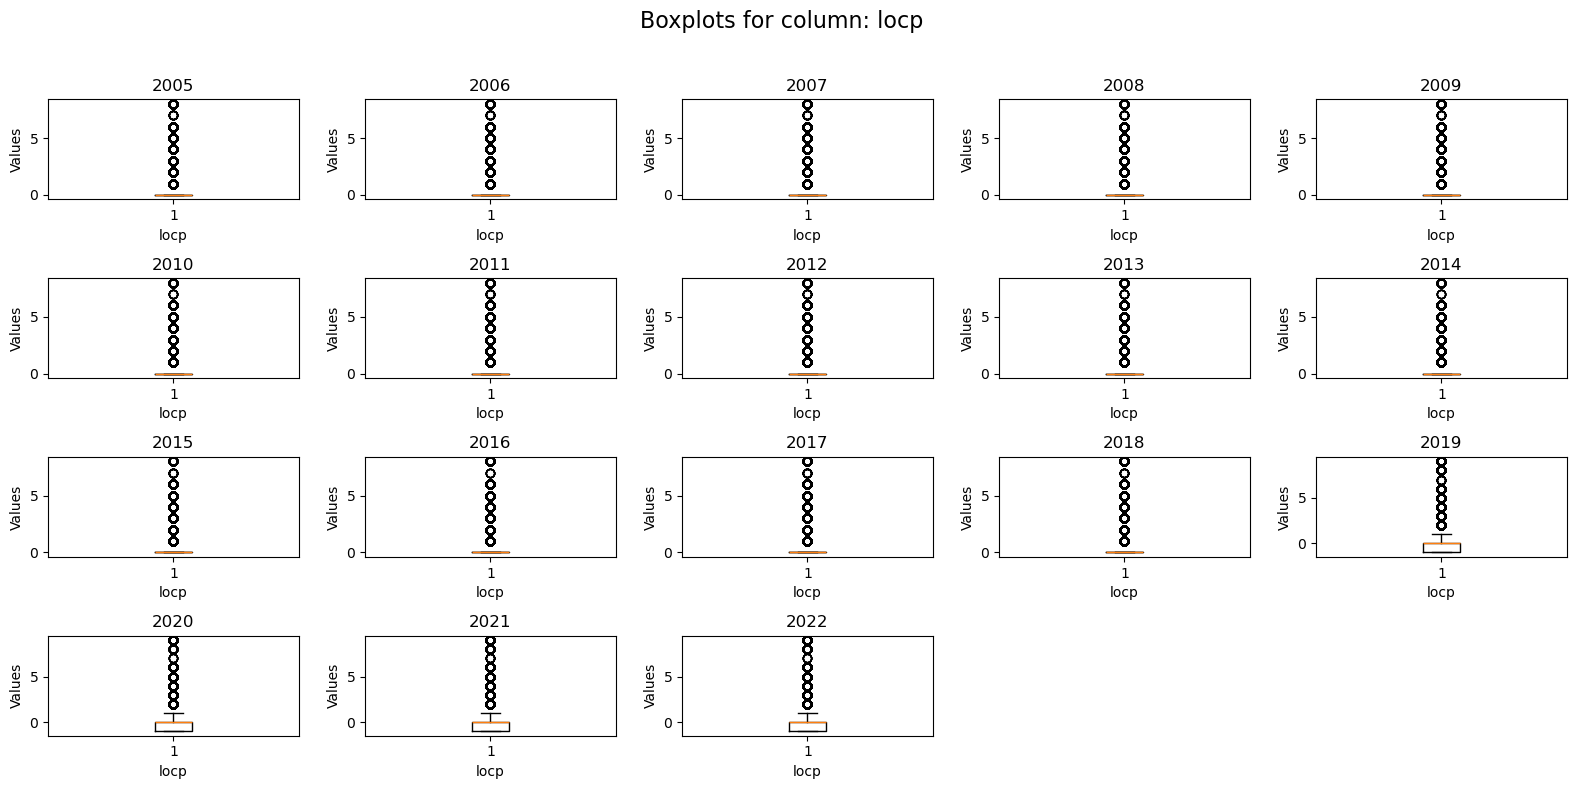

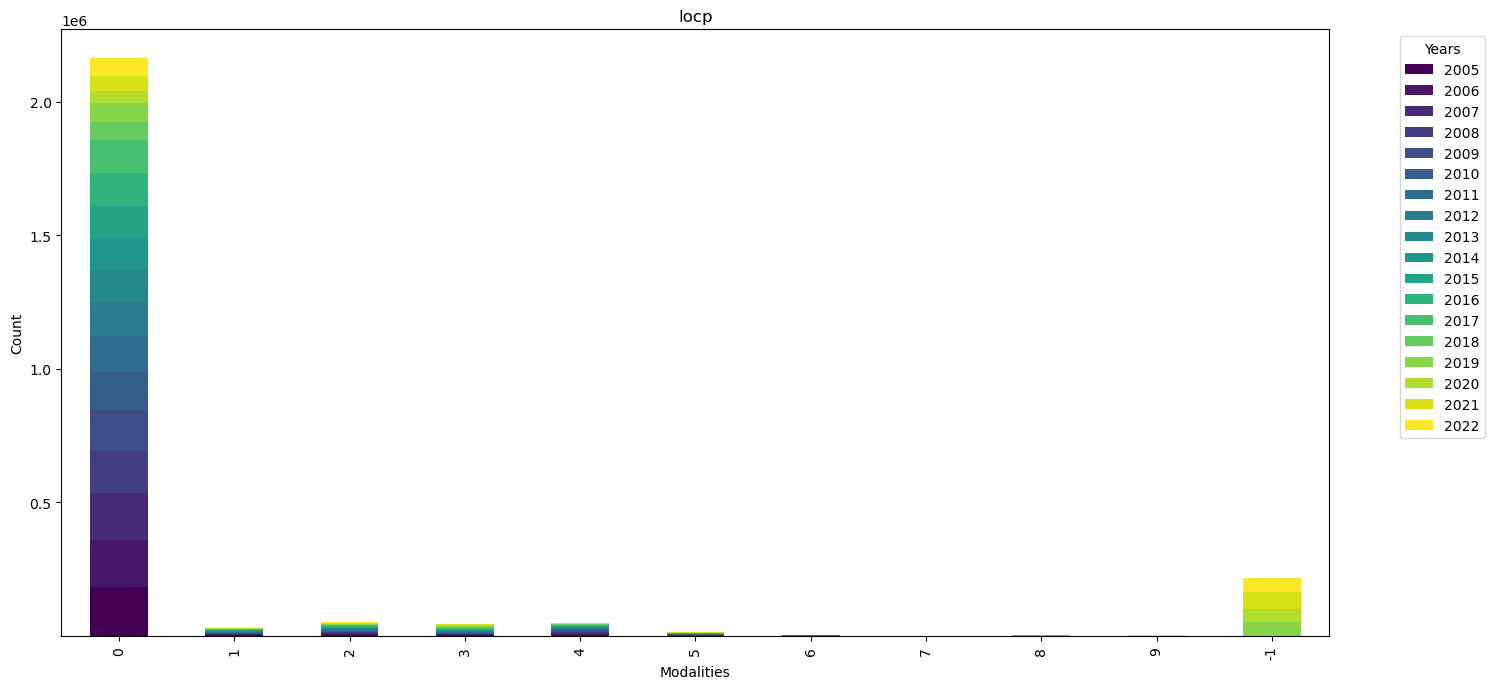

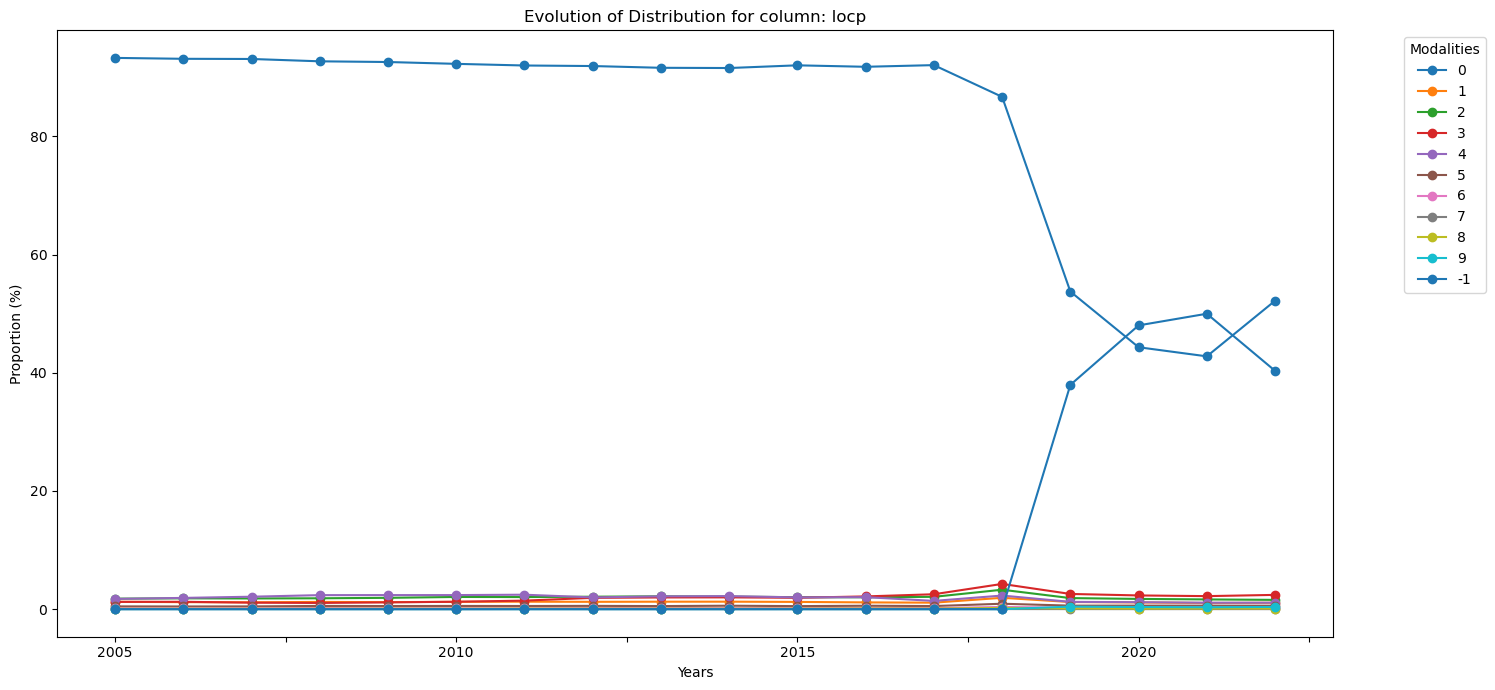

2024-10-24 13:44:15,778 - INFO - La colonne id_vehicule n'est pas numérique.
2024-10-24 13:44:15,970 - WARNING - Le nombre de modalités uniques dans la colonne id_vehicule excède le seuil de 50. Aucun bar plot généré.
2024-10-24 13:44:16,146 - WARNING - Le nombre de modalités uniques dans la colonne id_vehicule excède le seuil de 12. Aucun graphique en ligne généré.


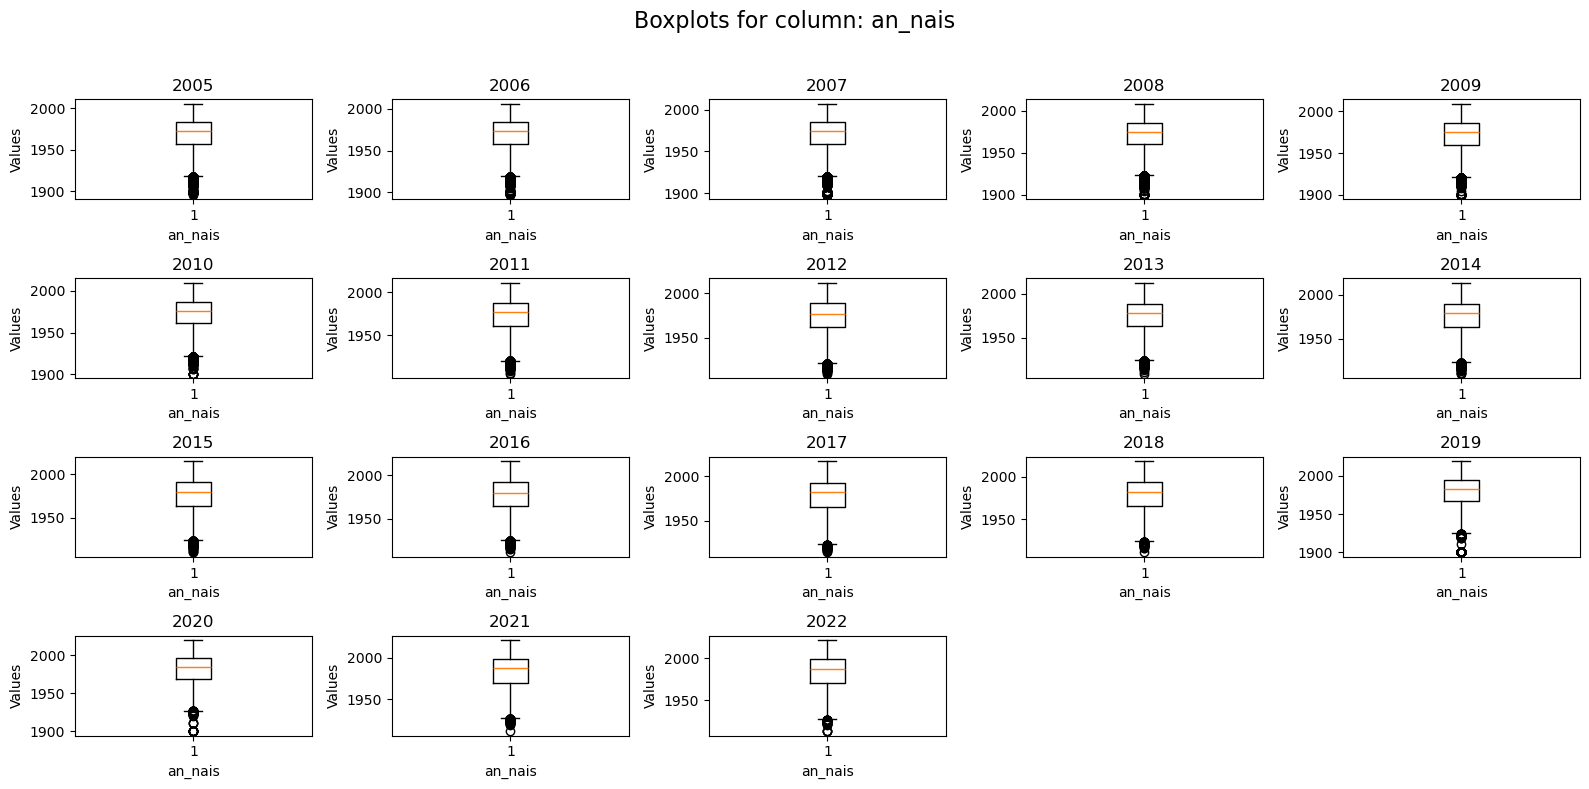

2024-10-24 13:44:17,322 - WARNING - Le nombre de modalités uniques dans la colonne an_nais excède le seuil de 50. Aucun bar plot généré.
2024-10-24 13:44:17,353 - WARNING - Le nombre de modalités uniques dans la colonne an_nais excède le seuil de 12. Aucun graphique en ligne généré.


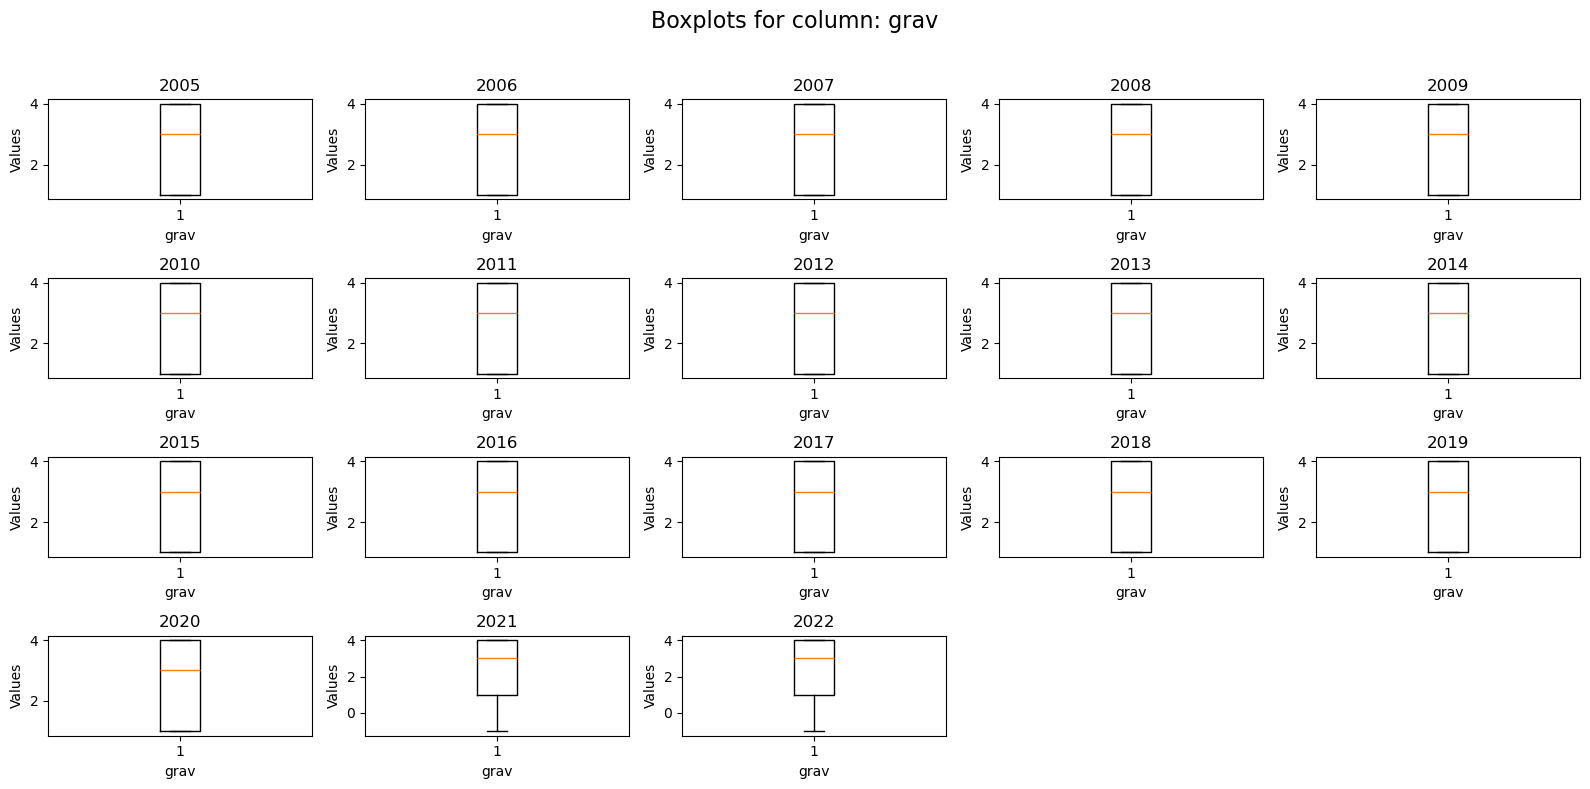

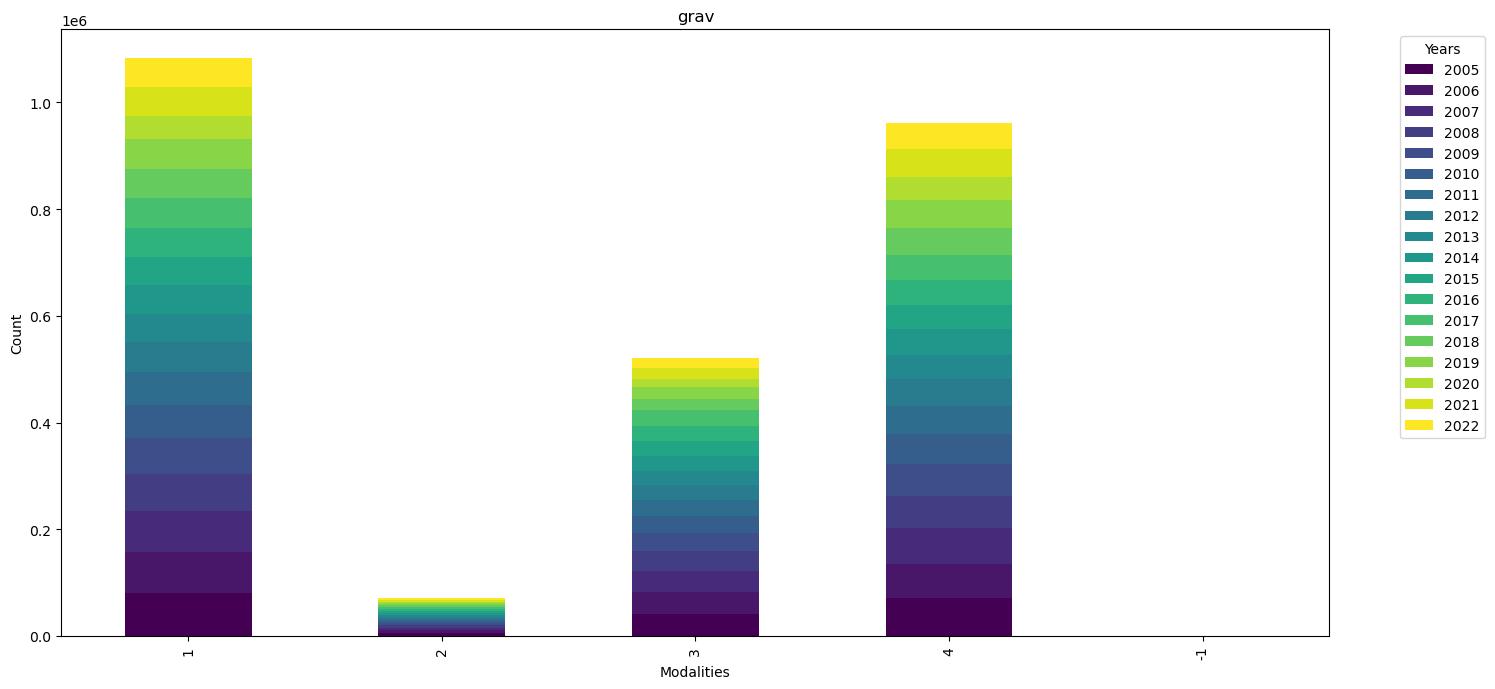

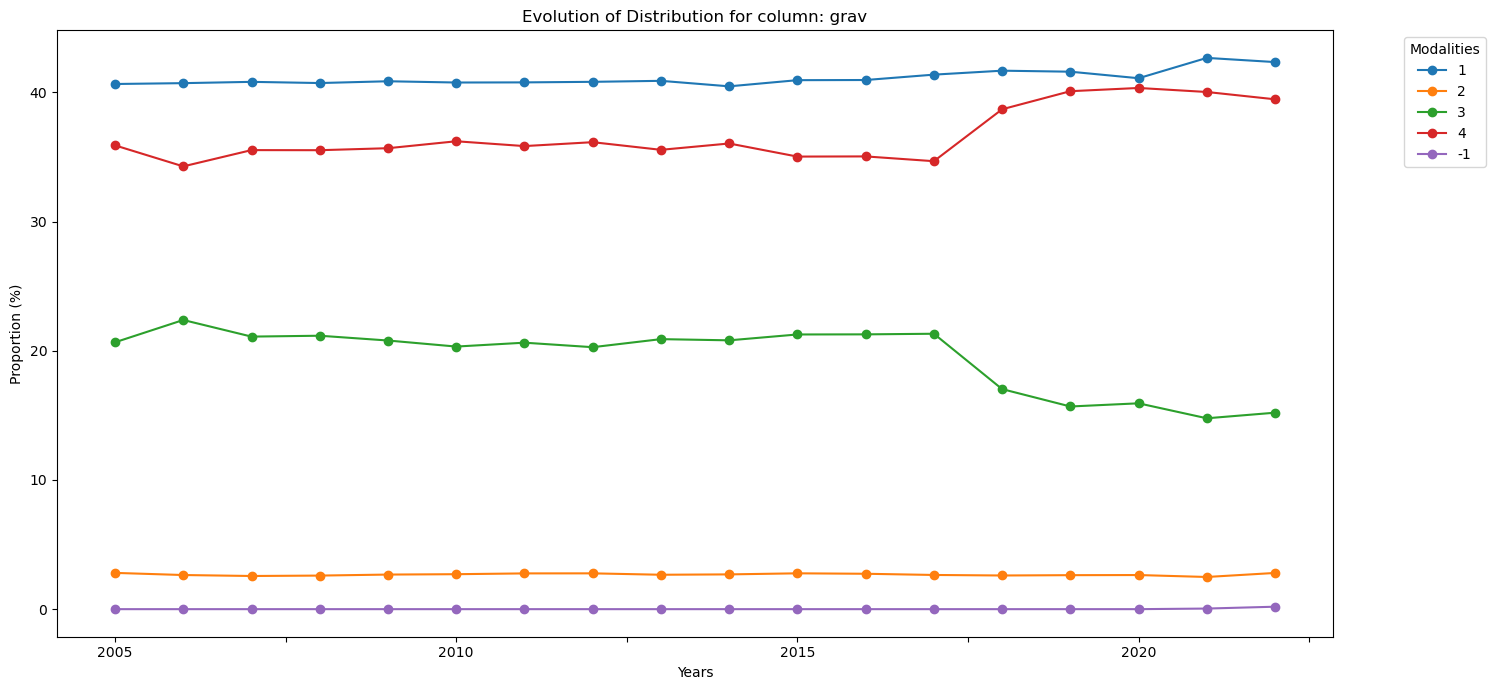

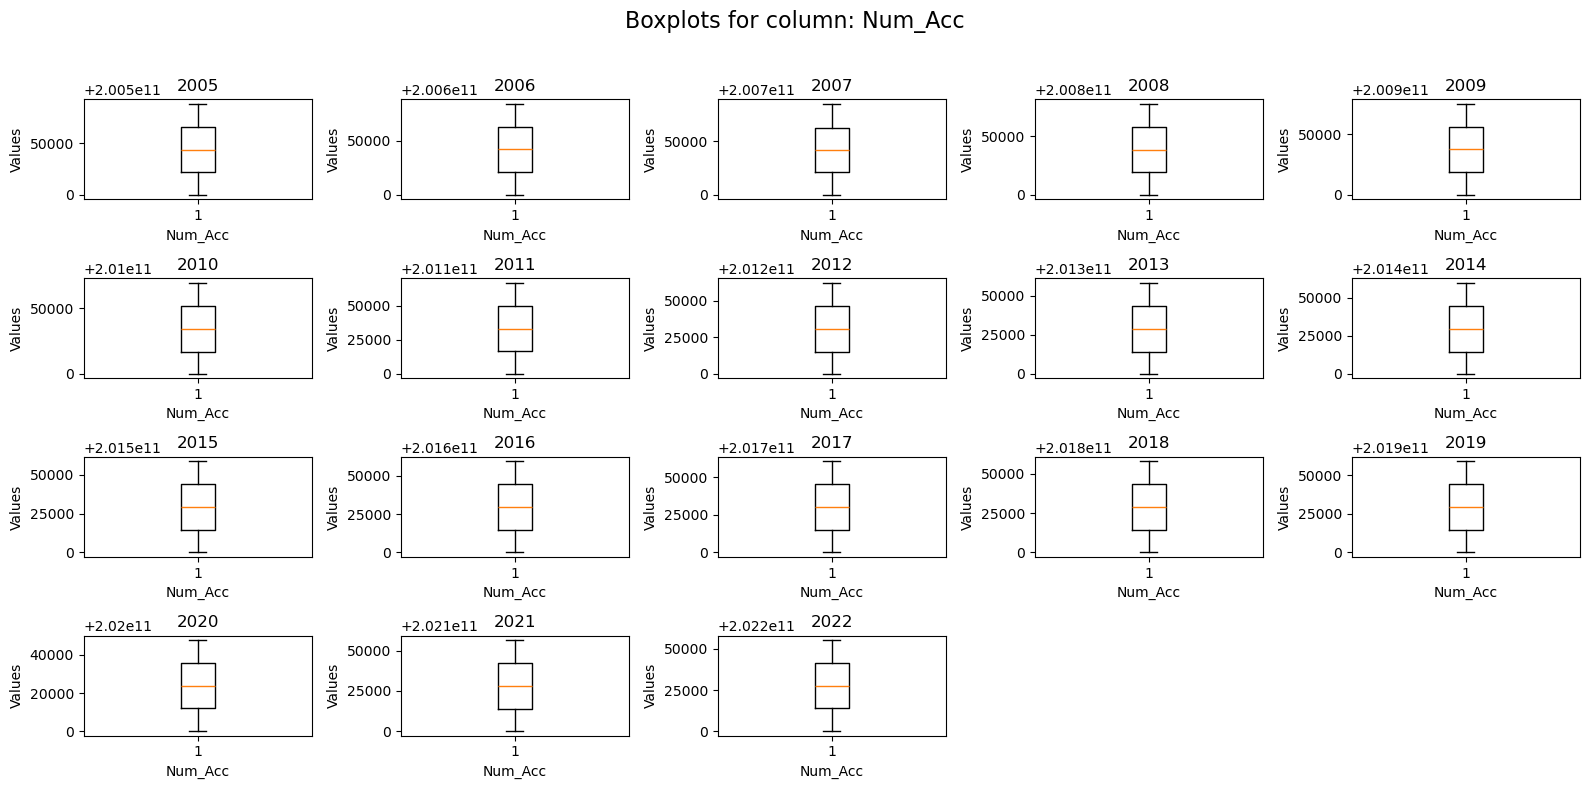

2024-10-24 13:44:21,840 - WARNING - Le nombre de modalités uniques dans la colonne Num_Acc excède le seuil de 50. Aucun bar plot généré.
2024-10-24 13:44:22,229 - WARNING - Le nombre de modalités uniques dans la colonne Num_Acc excède le seuil de 12. Aucun graphique en ligne généré.


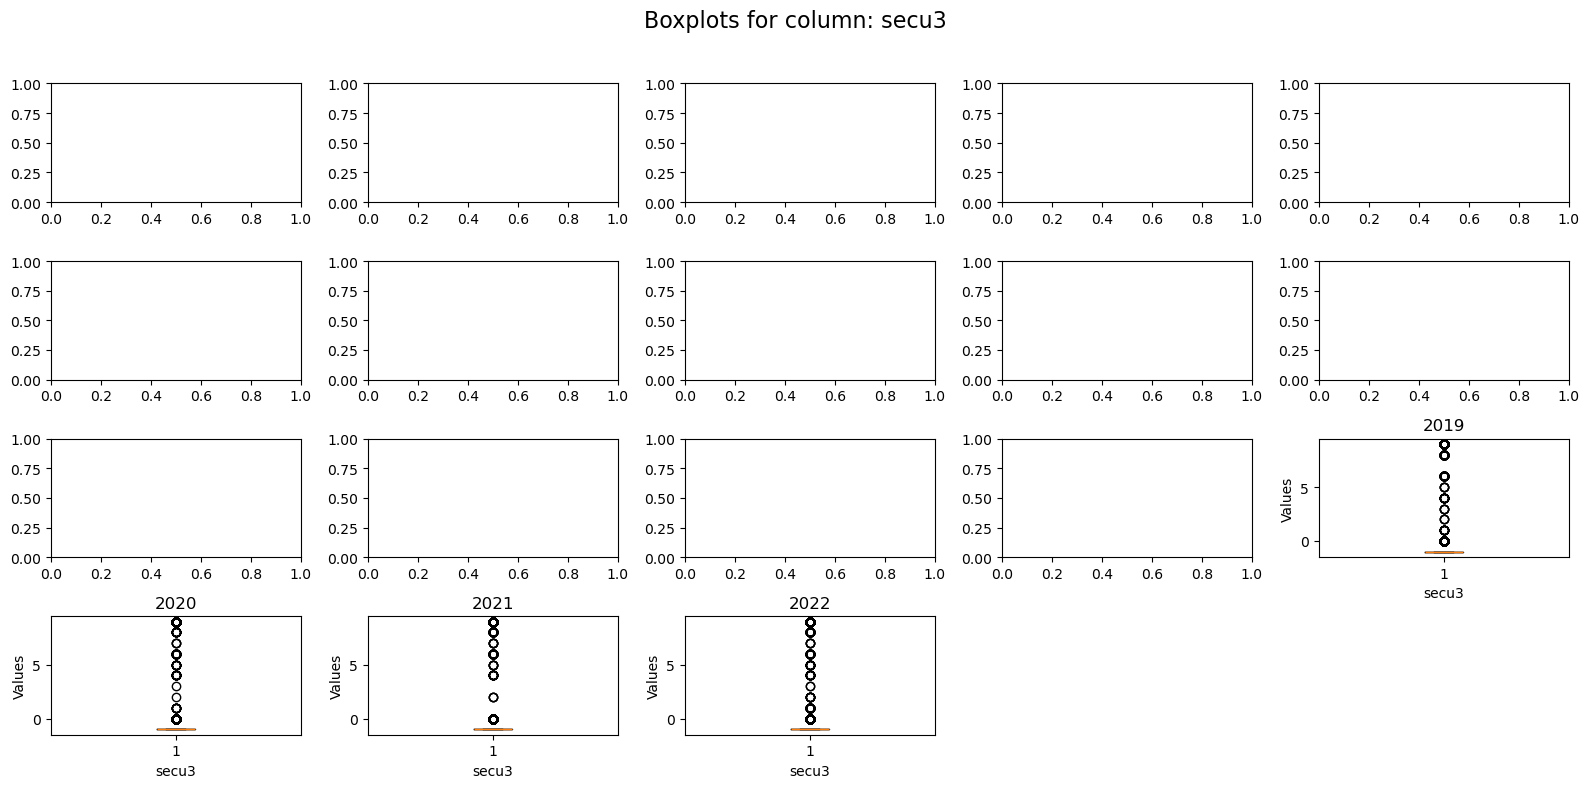

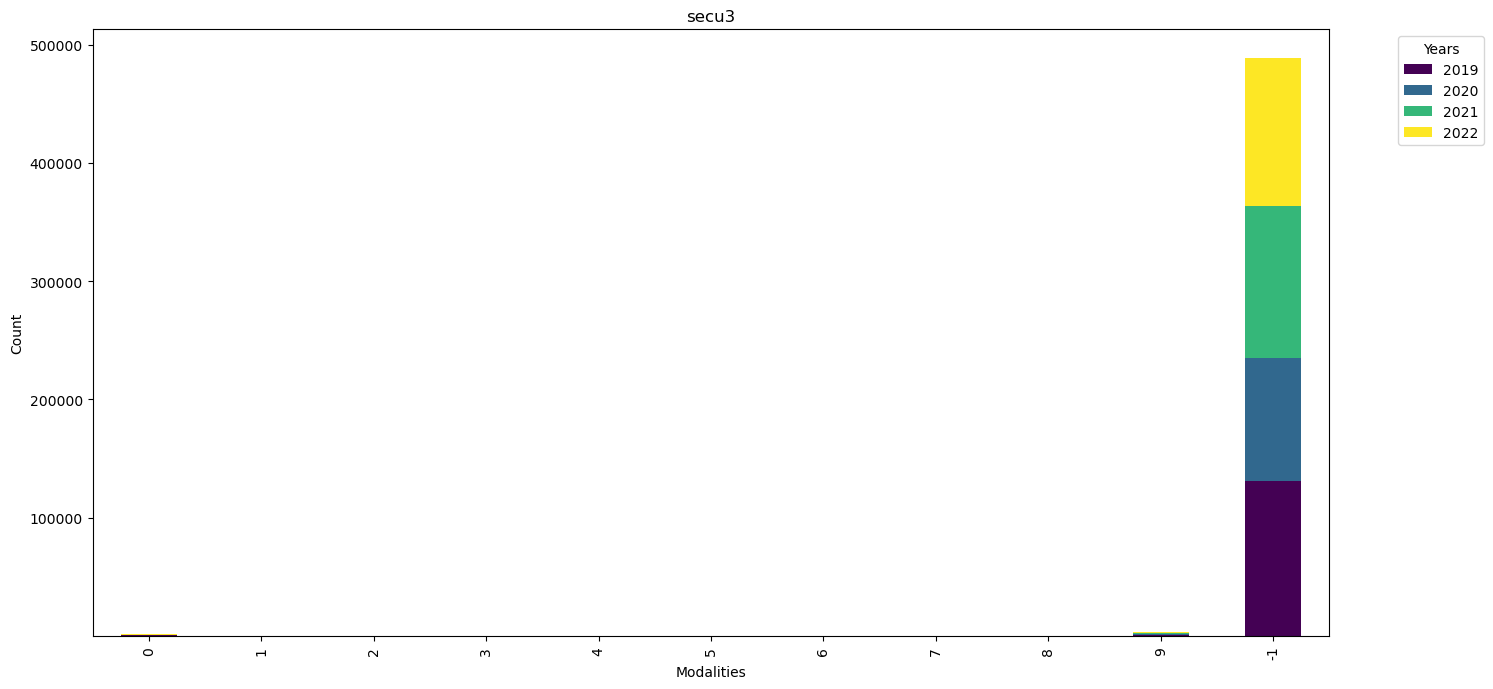

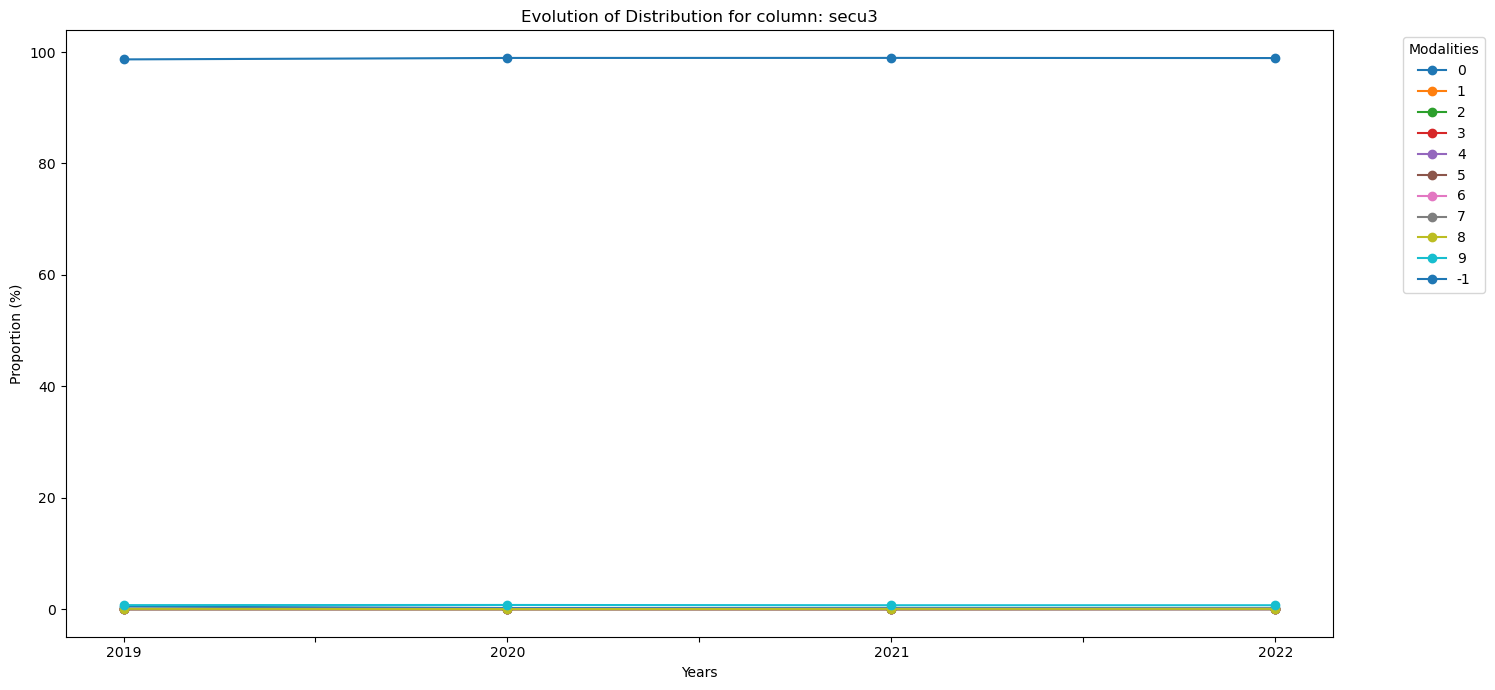

2024-10-24 13:44:24,402 - INFO - La colonne num_veh n'est pas numérique.
2024-10-24 13:44:24,502 - WARNING - Le nombre de modalités uniques dans la colonne num_veh excède le seuil de 50. Aucun bar plot généré.
2024-10-24 13:44:24,586 - WARNING - Le nombre de modalités uniques dans la colonne num_veh excède le seuil de 12. Aucun graphique en ligne généré.


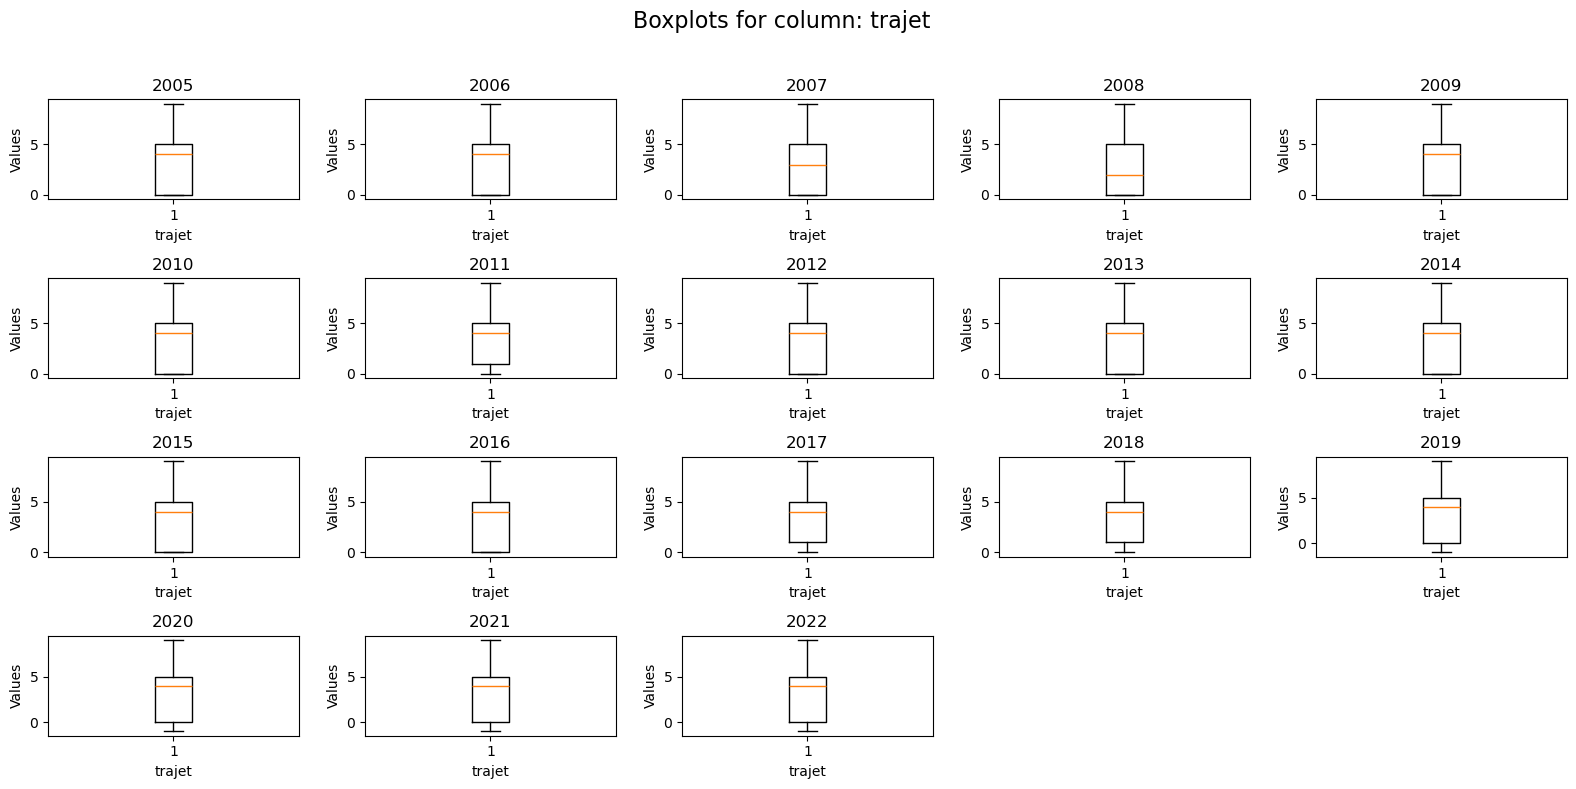

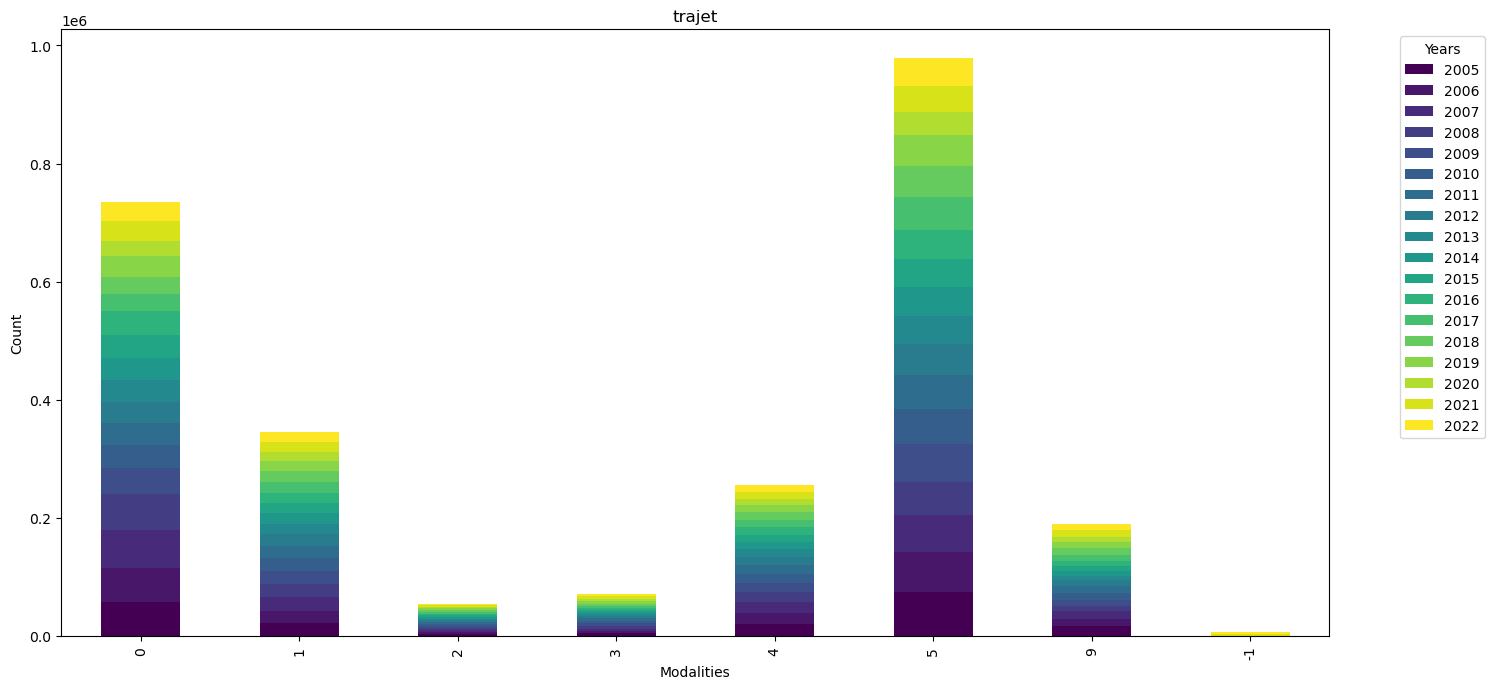

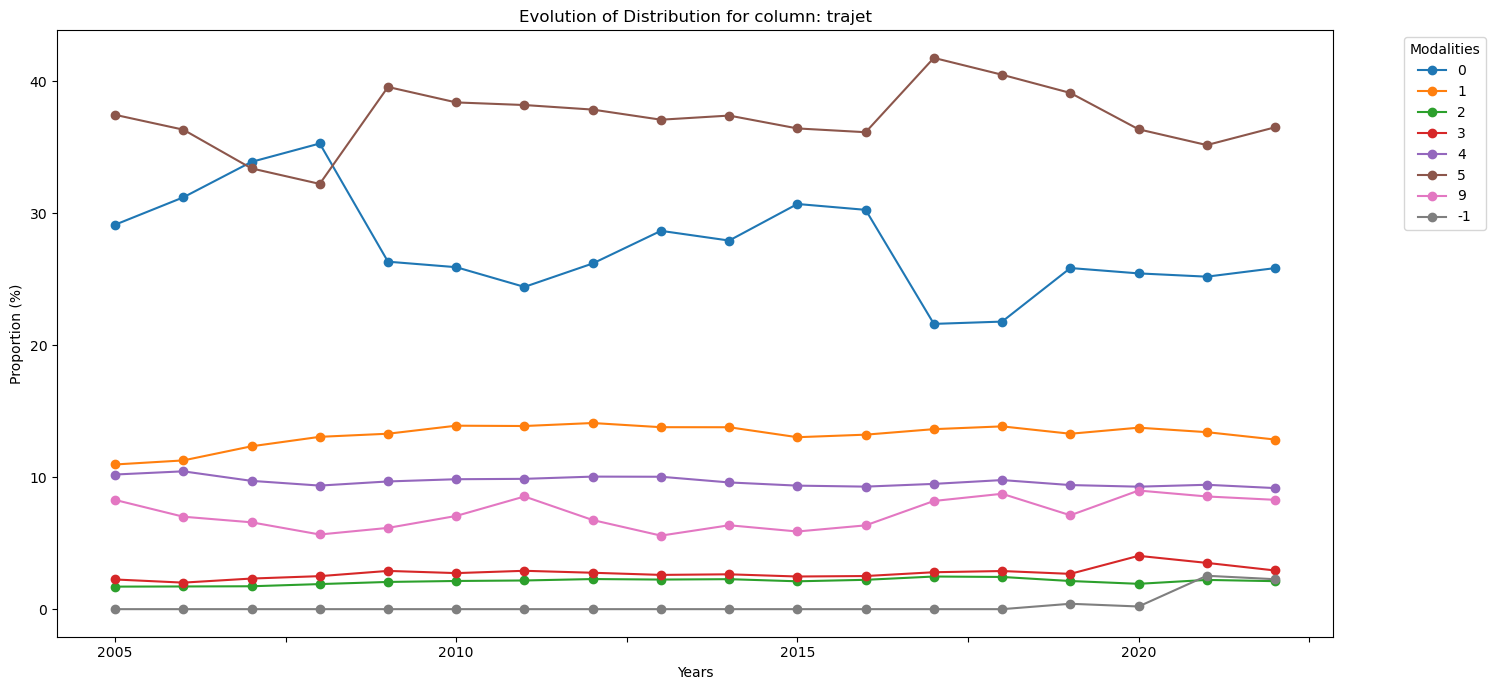

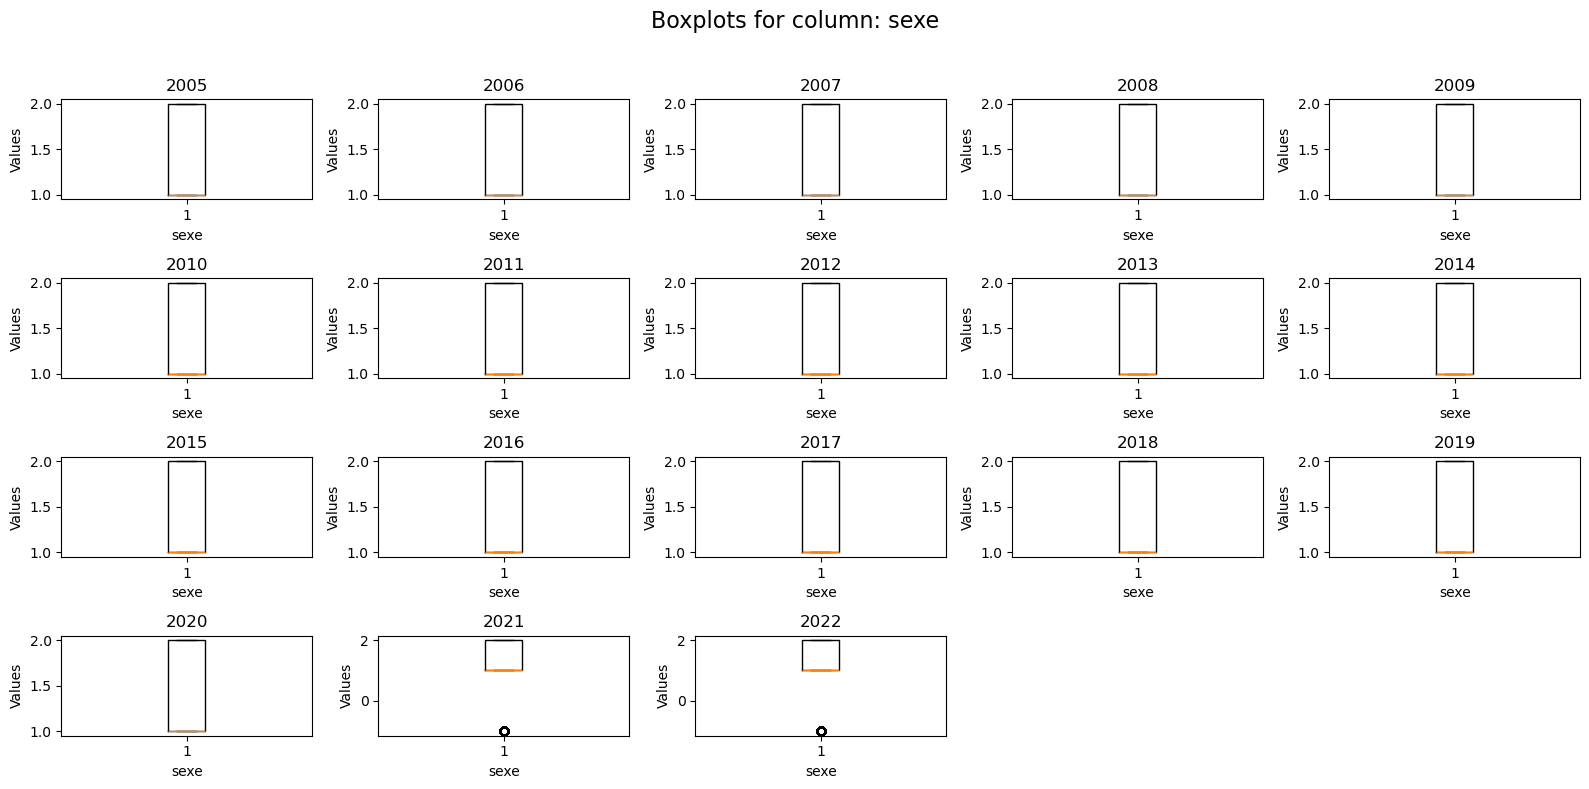

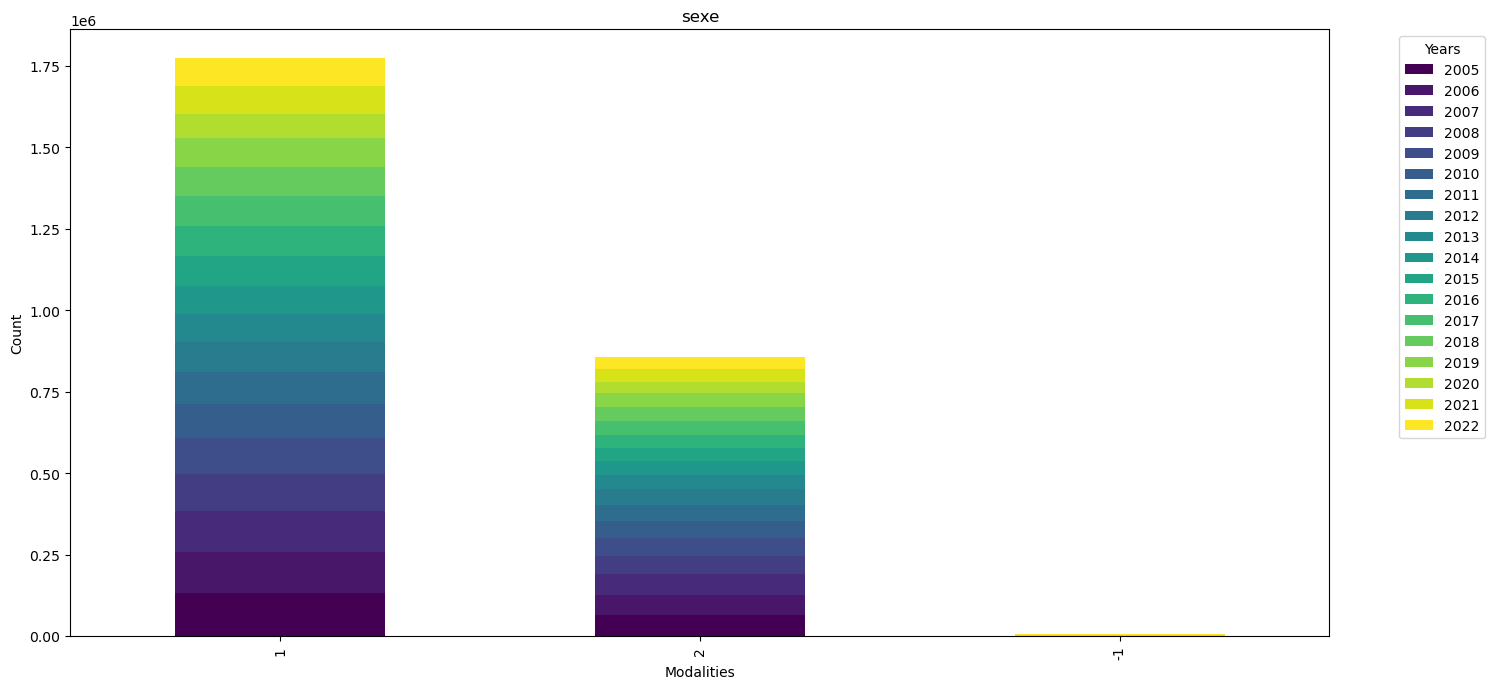

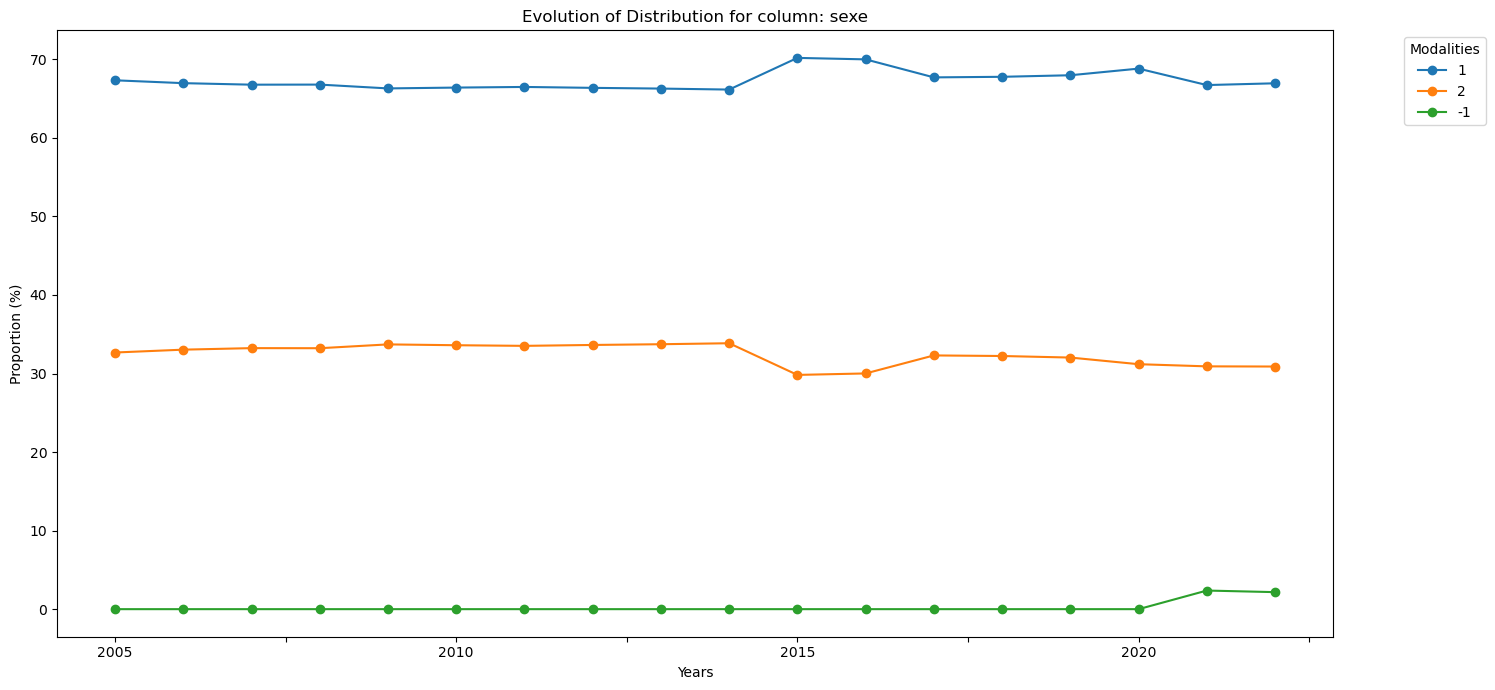

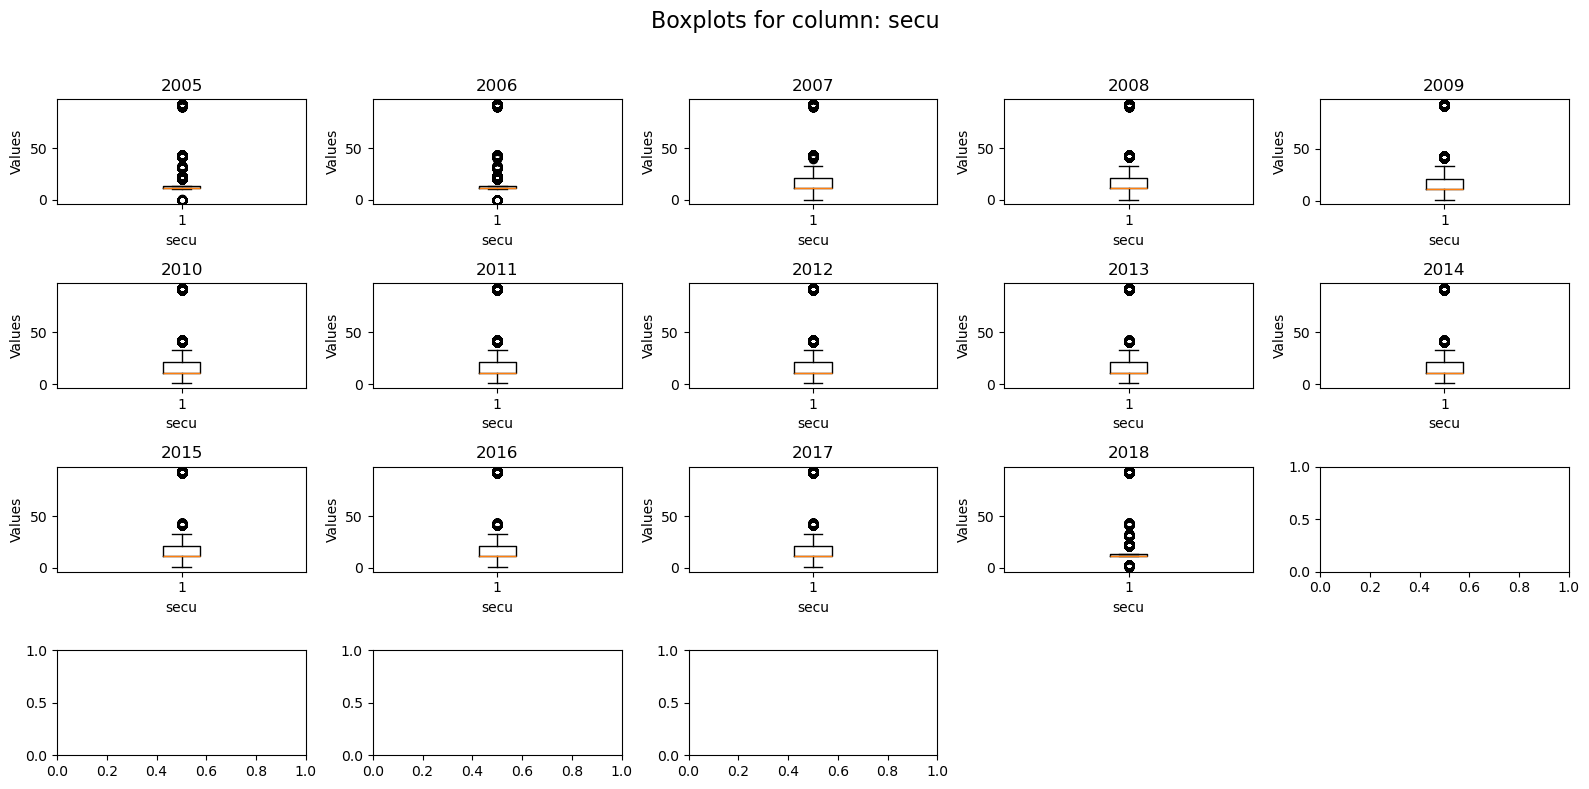

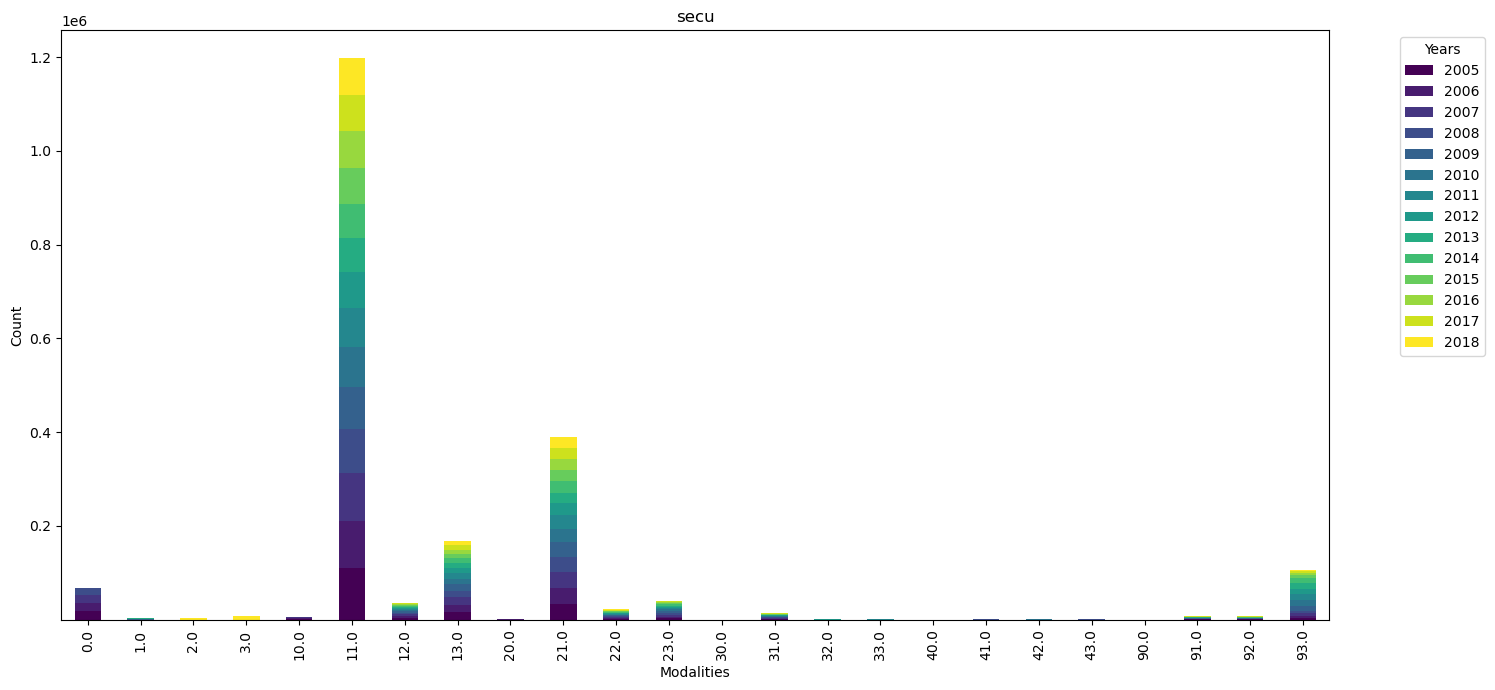

2024-10-24 13:44:30,317 - WARNING - Le nombre de modalités uniques dans la colonne secu excède le seuil de 12. Aucun graphique en ligne généré.


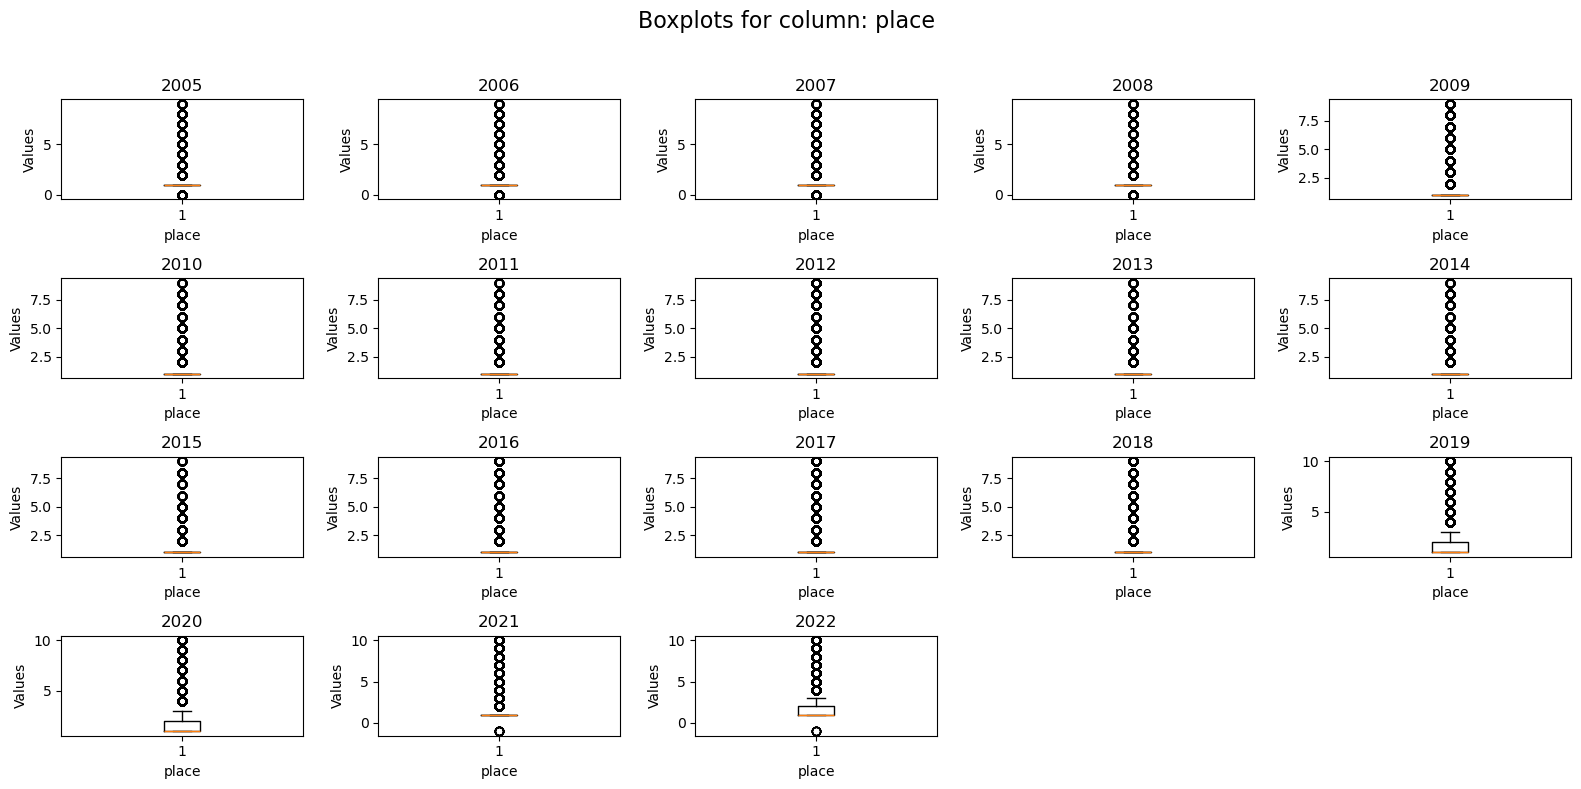

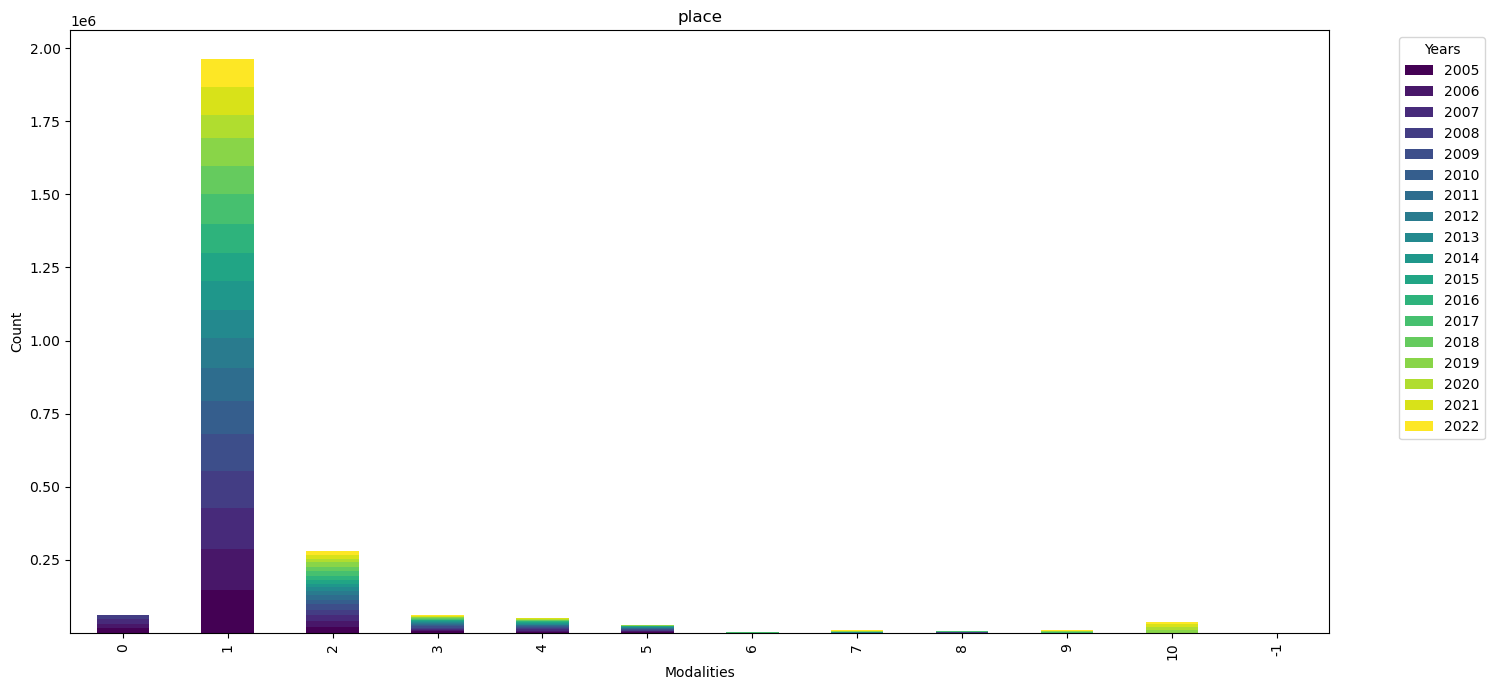

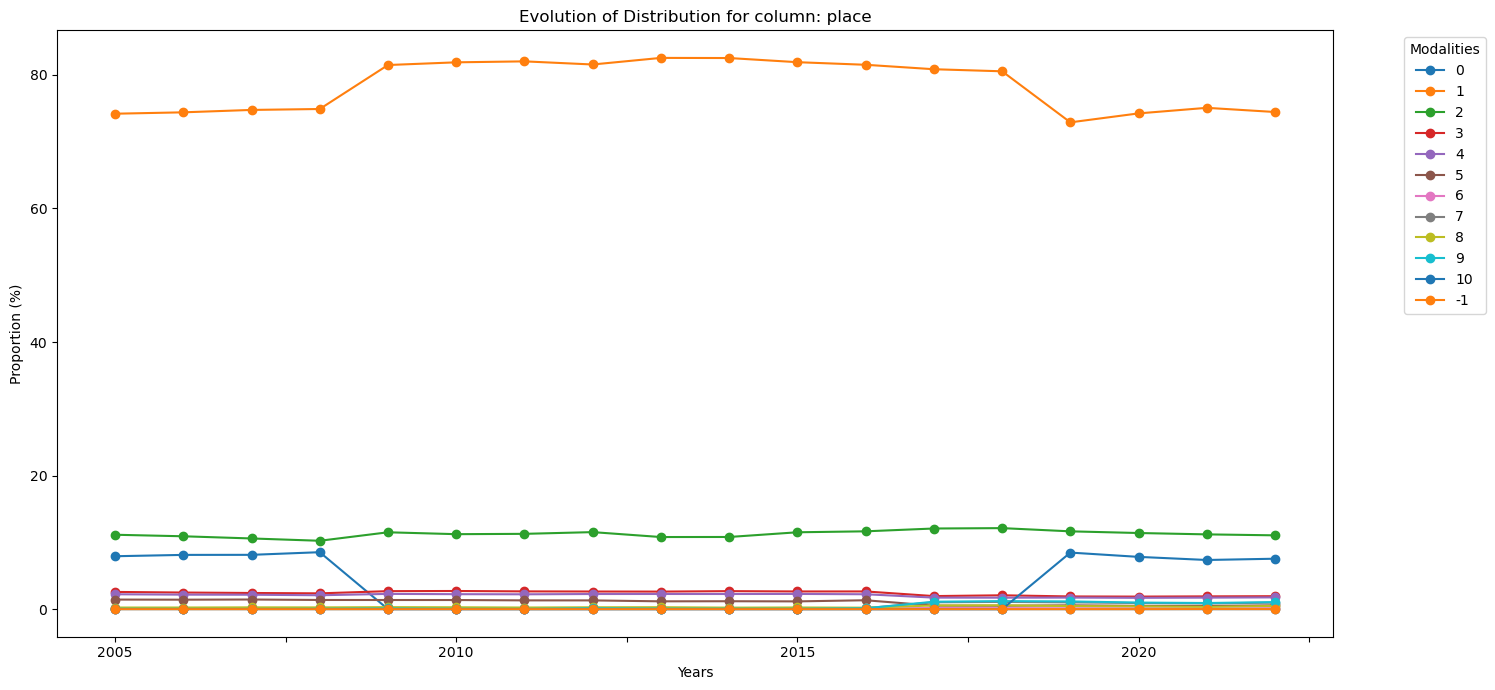

2024-10-24 13:44:32,982 - INFO - Chargement de vehicules_2005.csv.
2024-10-24 13:44:32,982 - INFO - Chargement de vehicules_2006.csv.
2024-10-24 13:44:32,982 - INFO - Chargement de vehicules_2007.csv.
2024-10-24 13:44:32,982 - INFO - Chargement de vehicules_2008.csv.
2024-10-24 13:44:32,982 - INFO - Chargement de vehicules_2009.csv.
2024-10-24 13:44:32,982 - INFO - Chargement de vehicules_2010.csv.
2024-10-24 13:44:32,982 - INFO - Chargement de vehicules_2011.csv.
2024-10-24 13:44:32,982 - INFO - Chargement de vehicules_2012.csv.
2024-10-24 13:44:32,982 - INFO - Chargement de vehicules_2013.csv.
2024-10-24 13:44:32,998 - INFO - Chargement de vehicules_2014.csv.
2024-10-24 13:44:32,999 - INFO - Chargement de vehicules_2015.csv.
2024-10-24 13:44:32,999 - INFO - Chargement de vehicules_2016.csv.
2024-10-24 13:44:32,999 - INFO - Chargement de vehicules-2017.csv.
2024-10-24 13:44:32,999 - INFO - Chargement de vehicules-2018.csv.
2024-10-24 13:44:32,999 - INFO - Chargement de vehicules-2019.

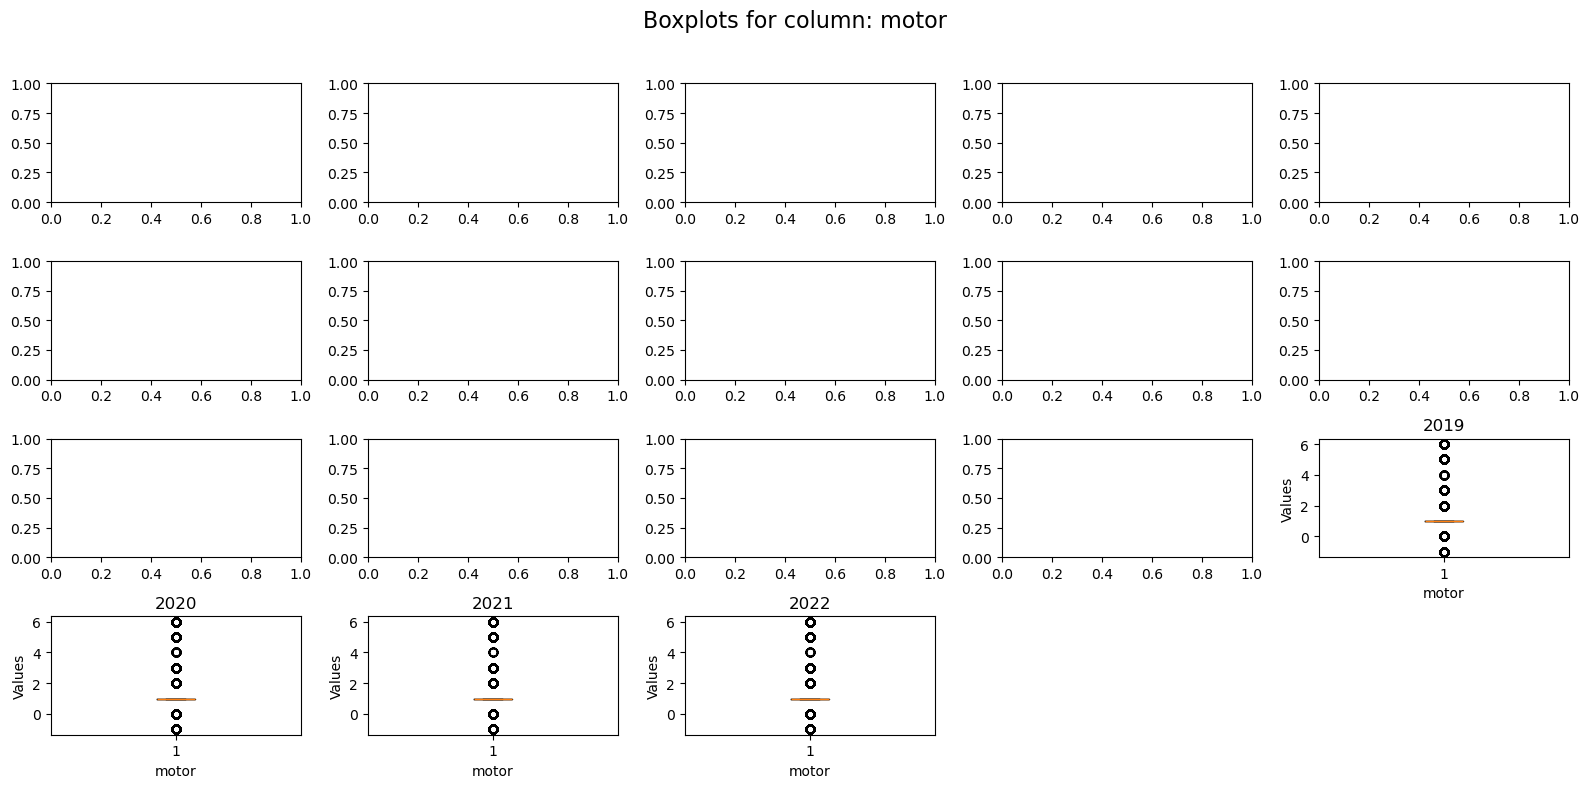

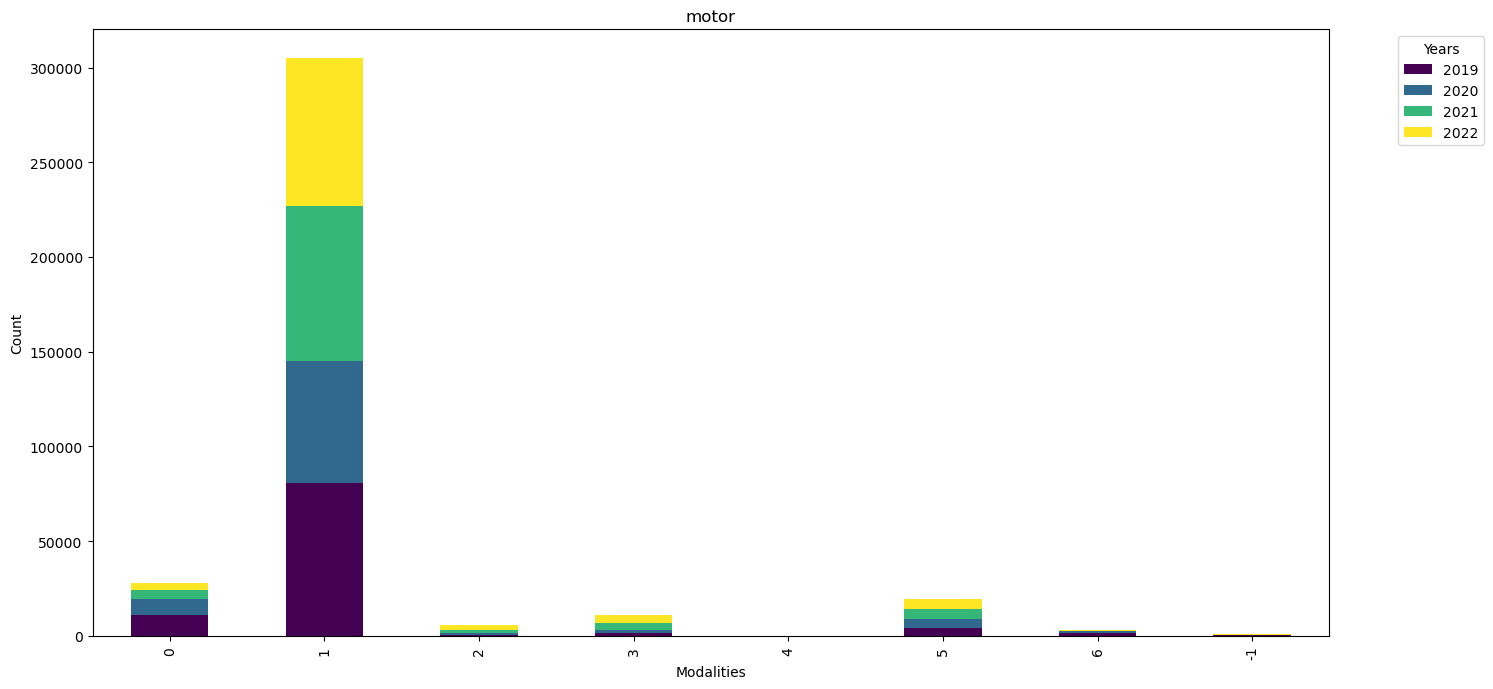

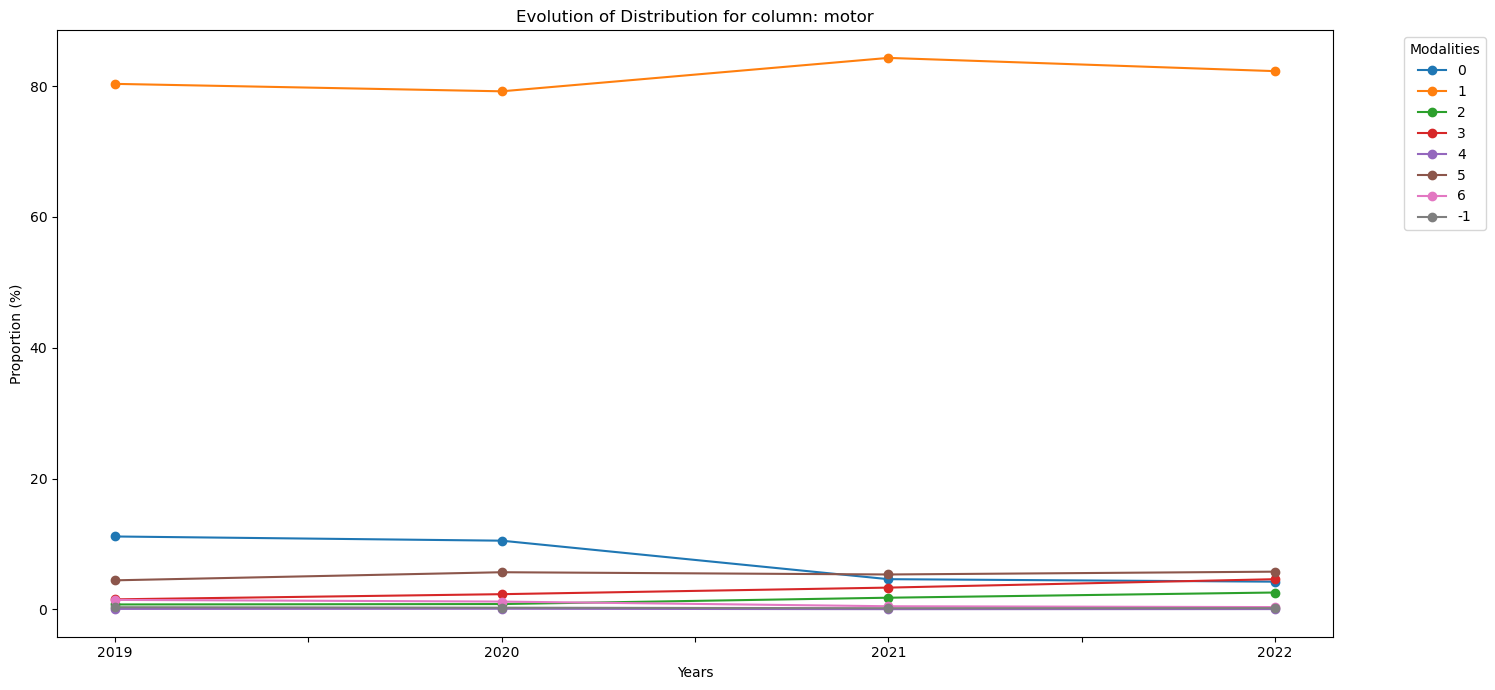

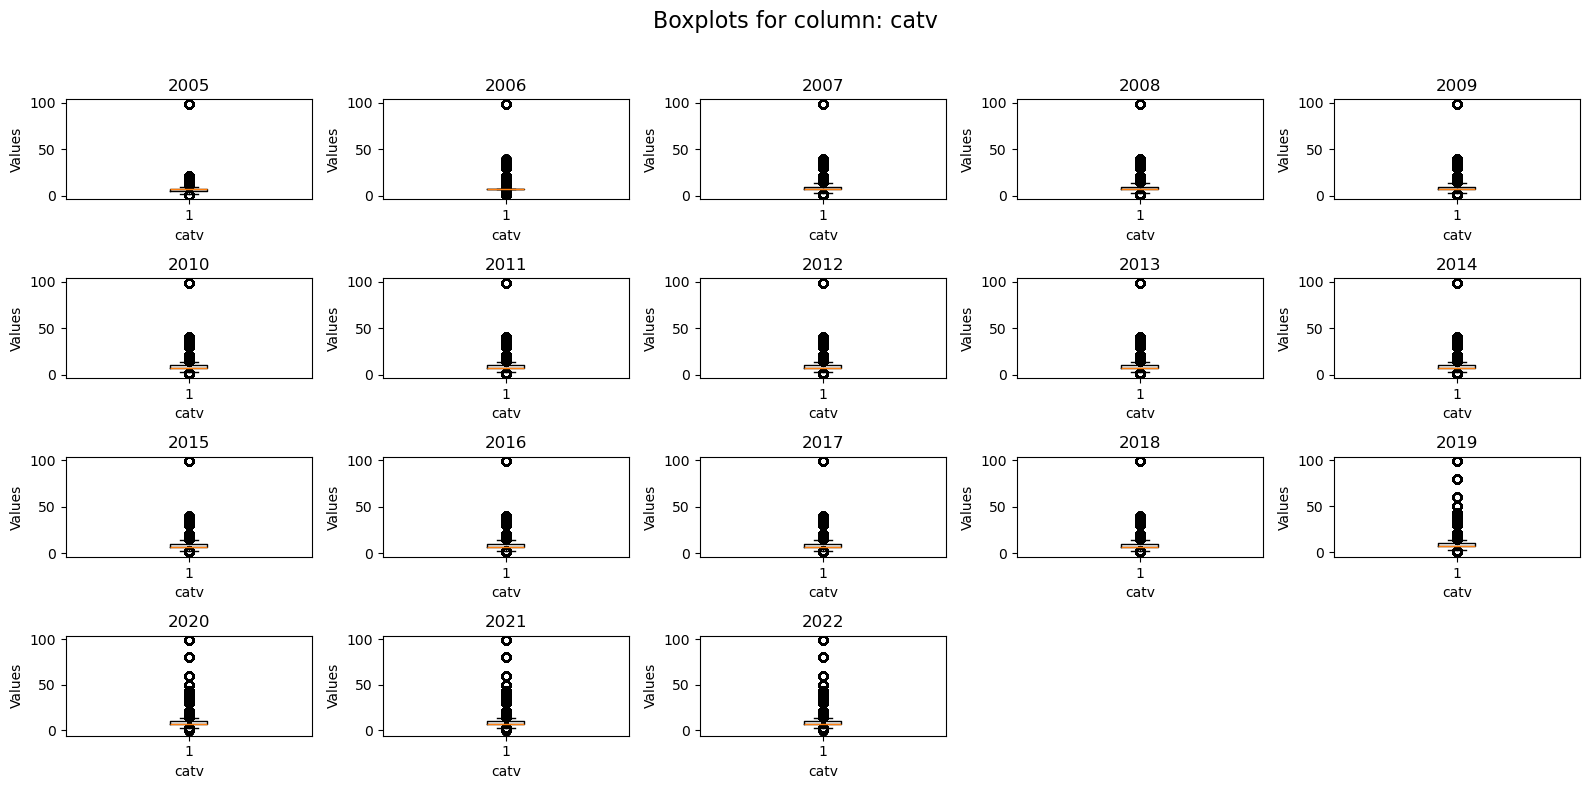

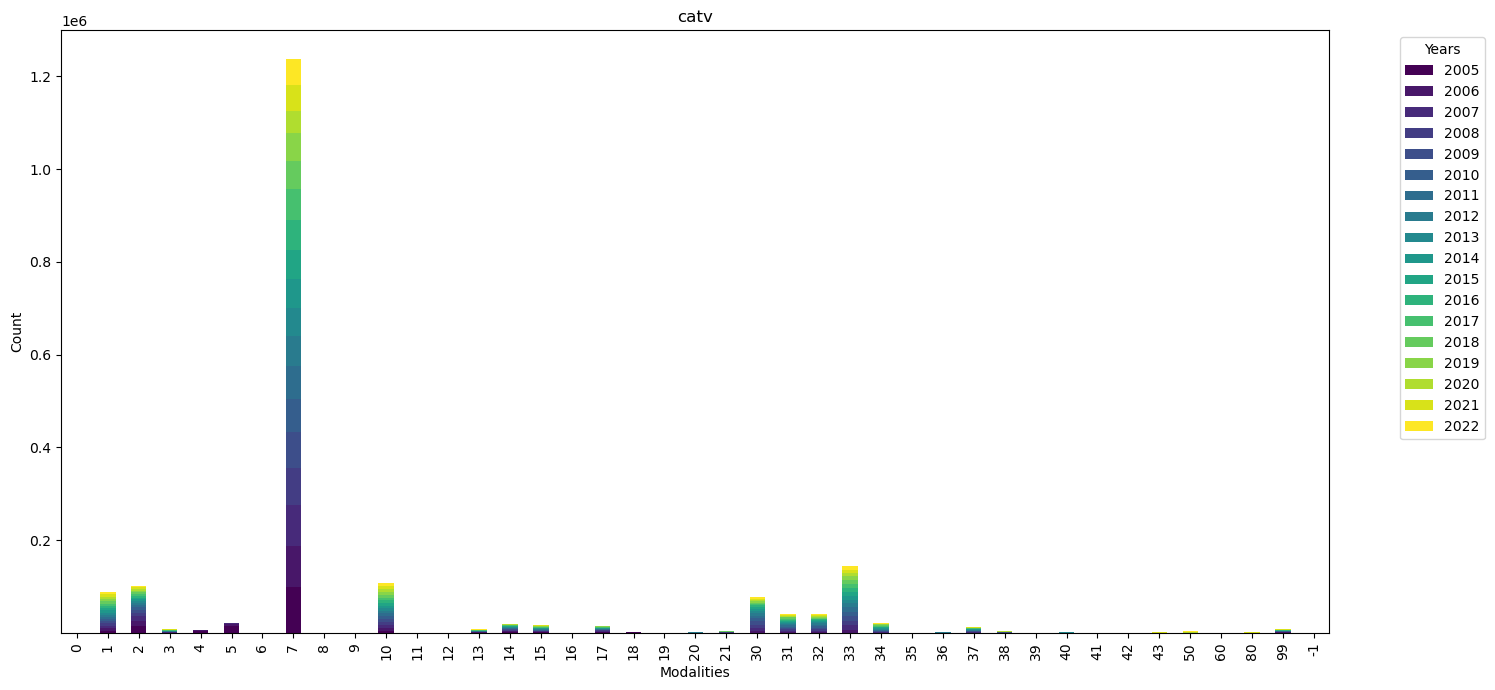

2024-10-24 13:44:38,081 - WARNING - Le nombre de modalités uniques dans la colonne catv excède le seuil de 12. Aucun graphique en ligne généré.


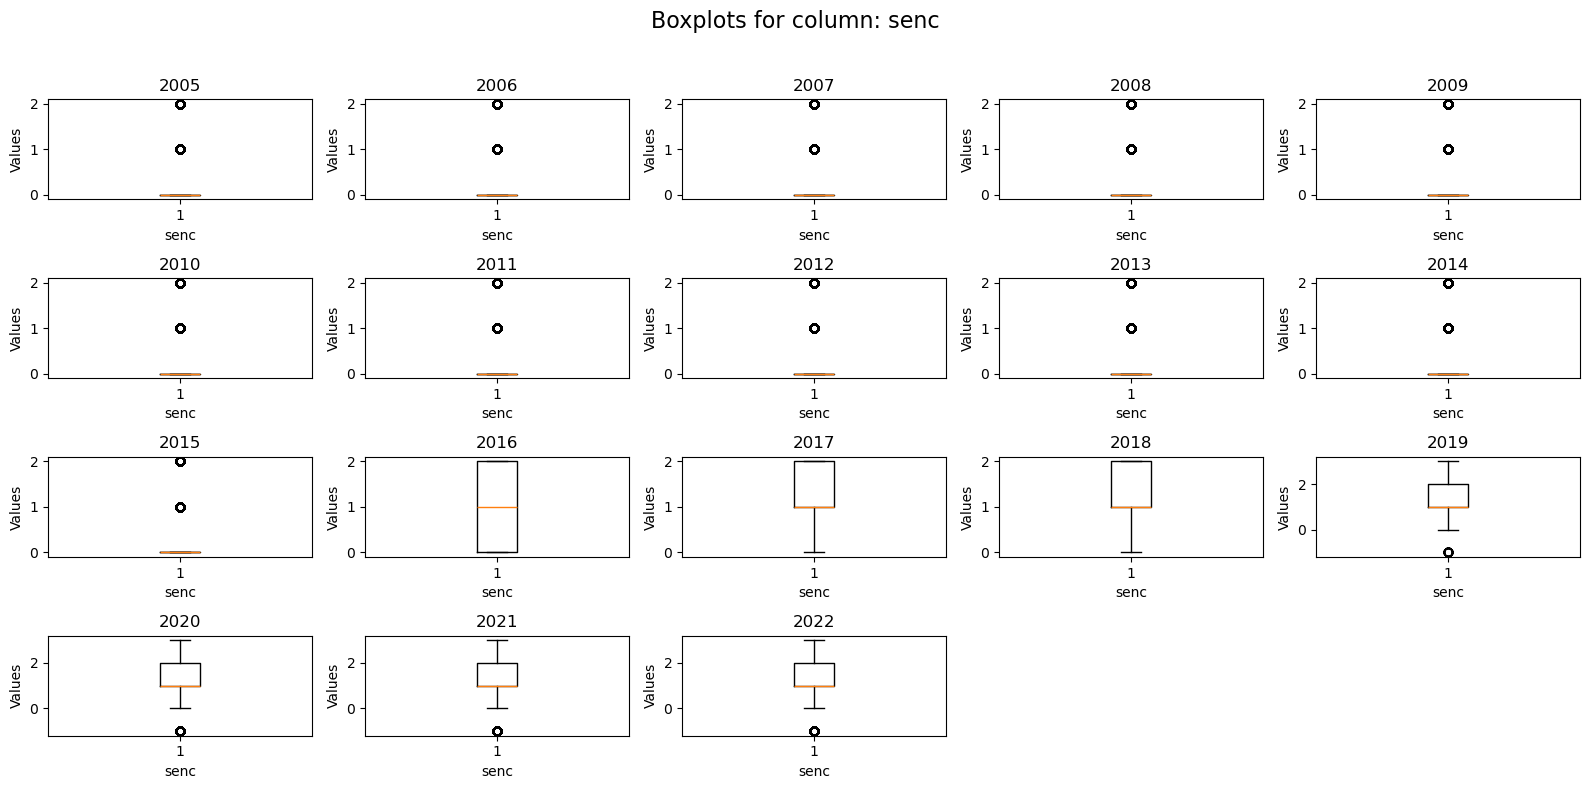

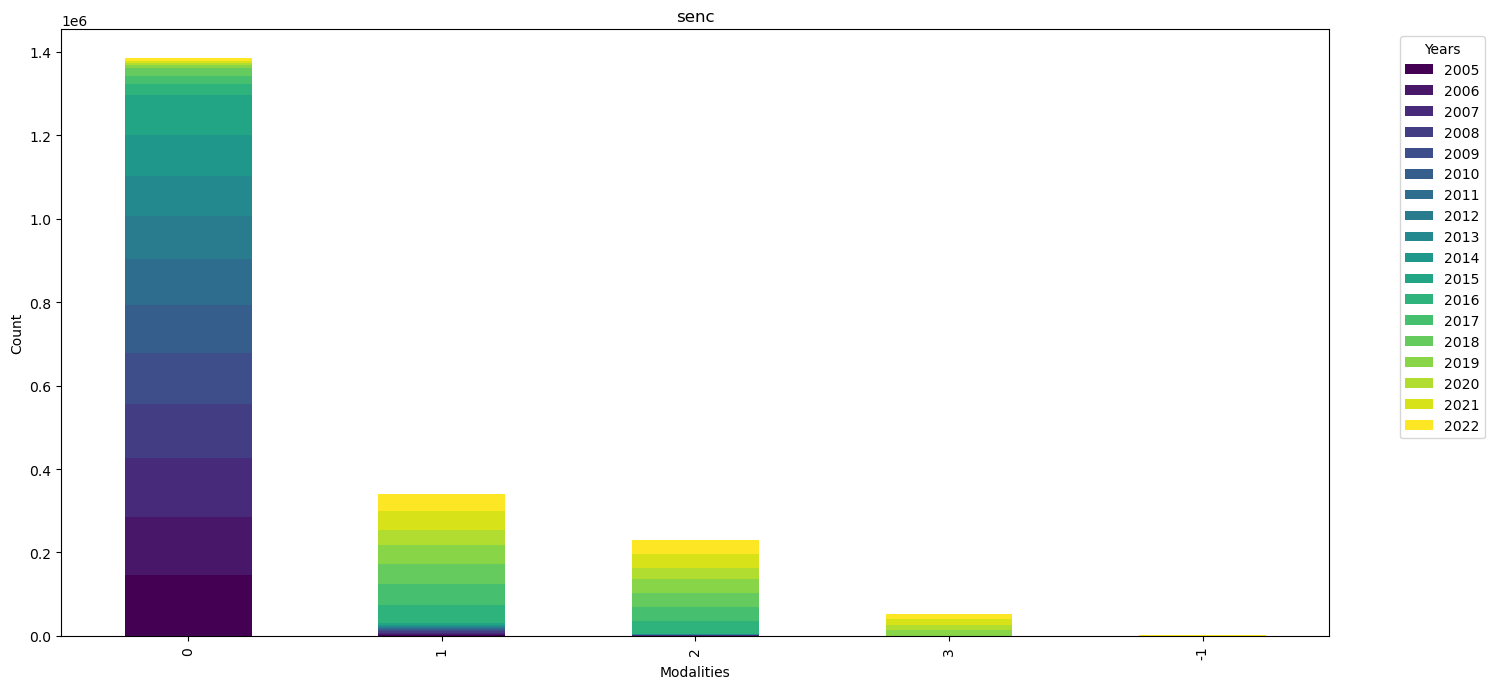

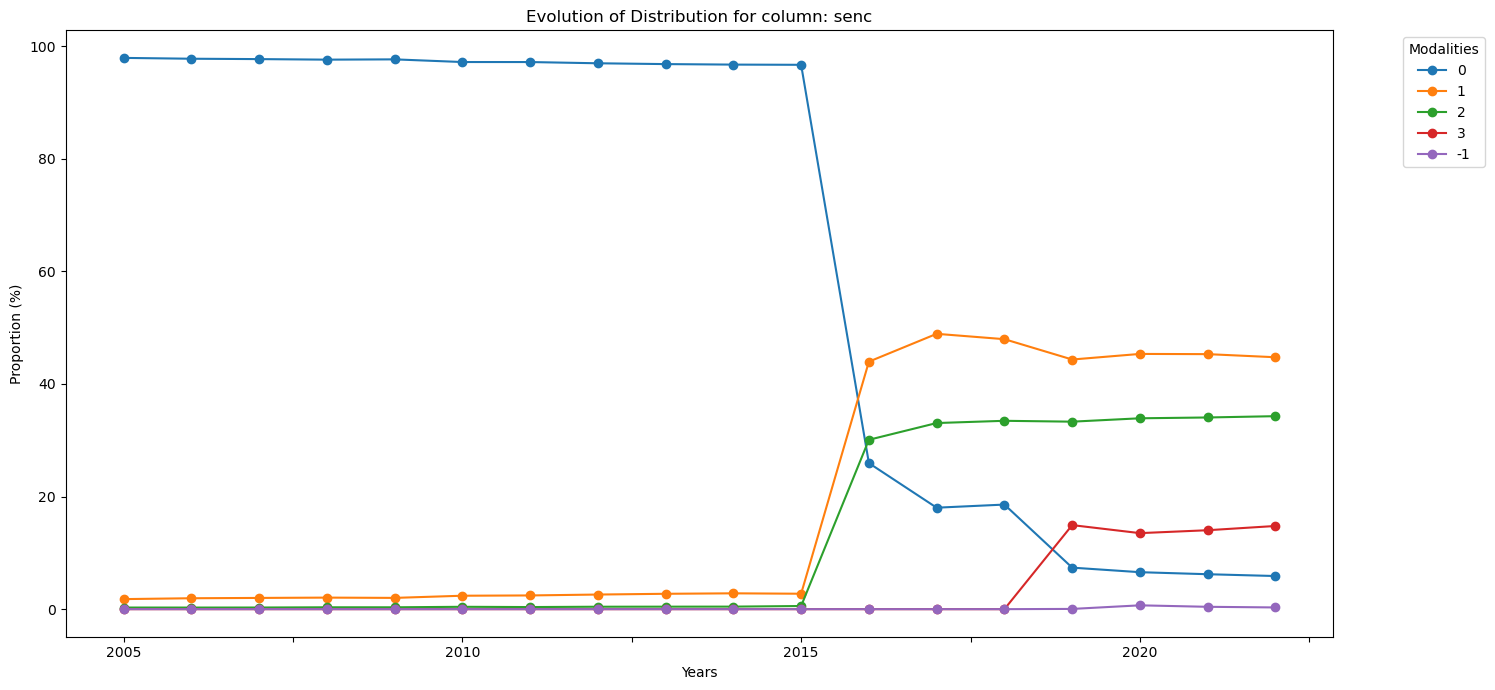

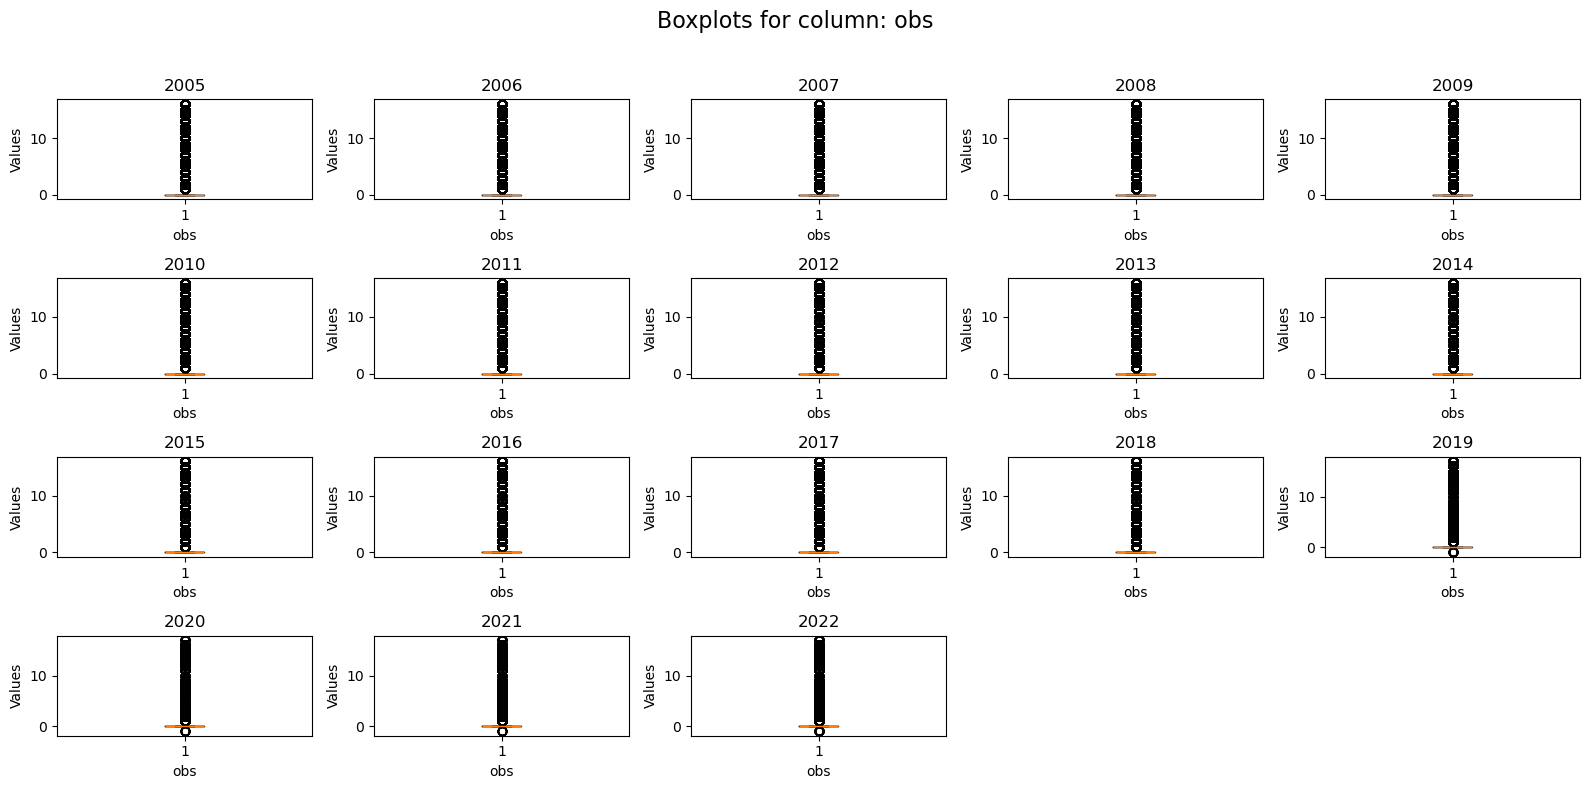

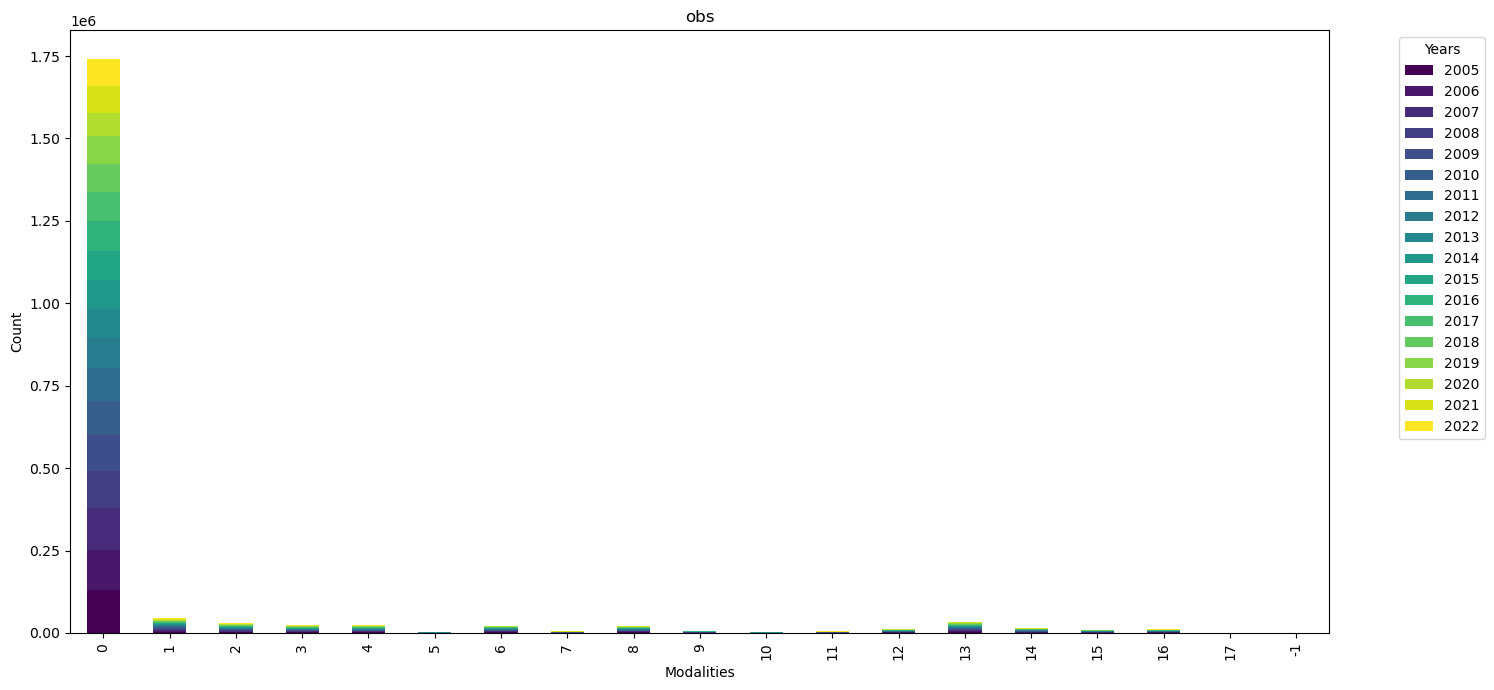

2024-10-24 13:44:41,639 - WARNING - Le nombre de modalités uniques dans la colonne obs excède le seuil de 12. Aucun graphique en ligne généré.


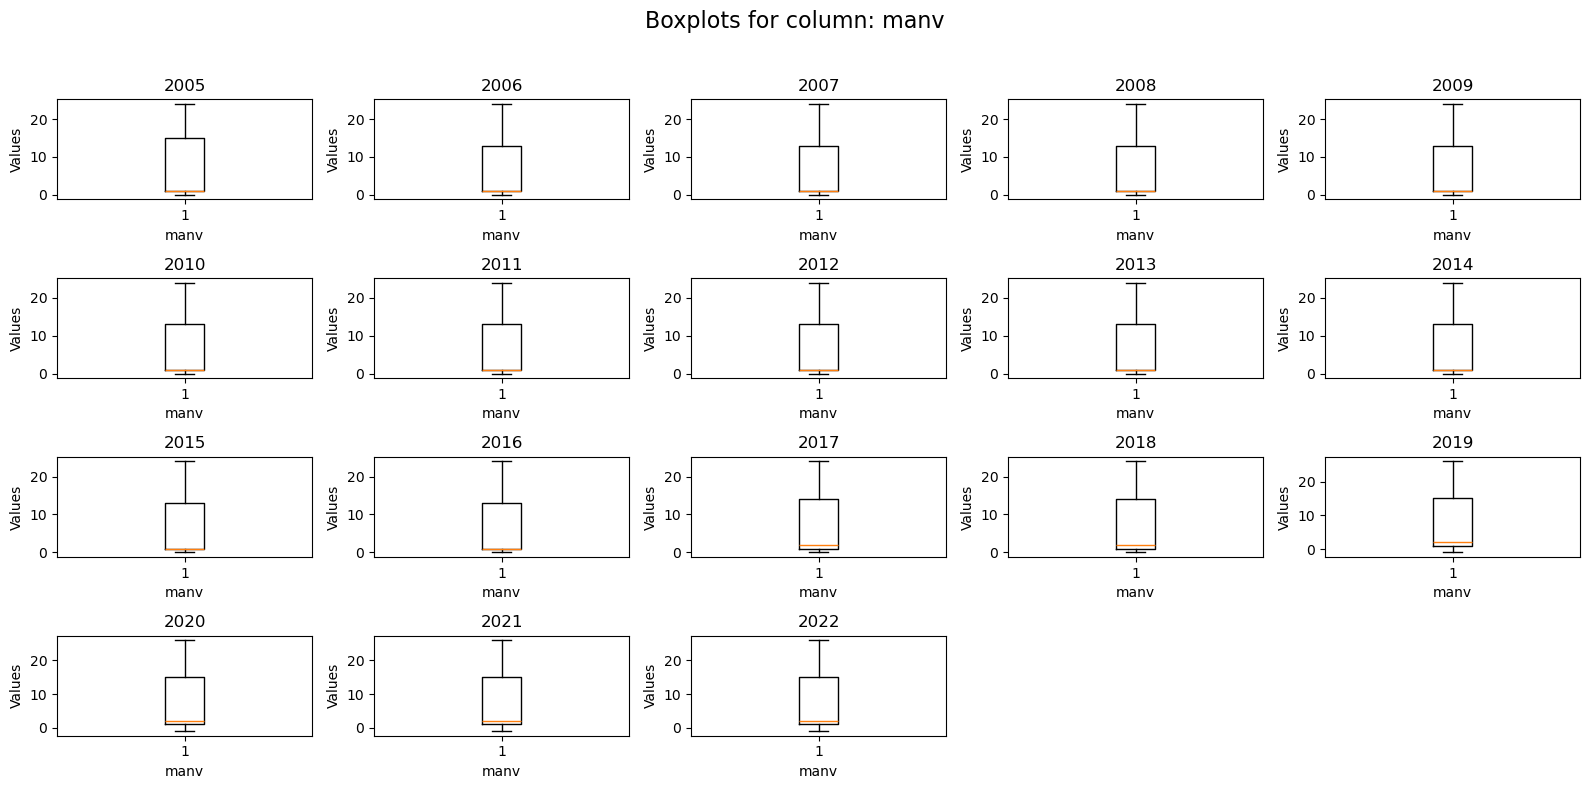

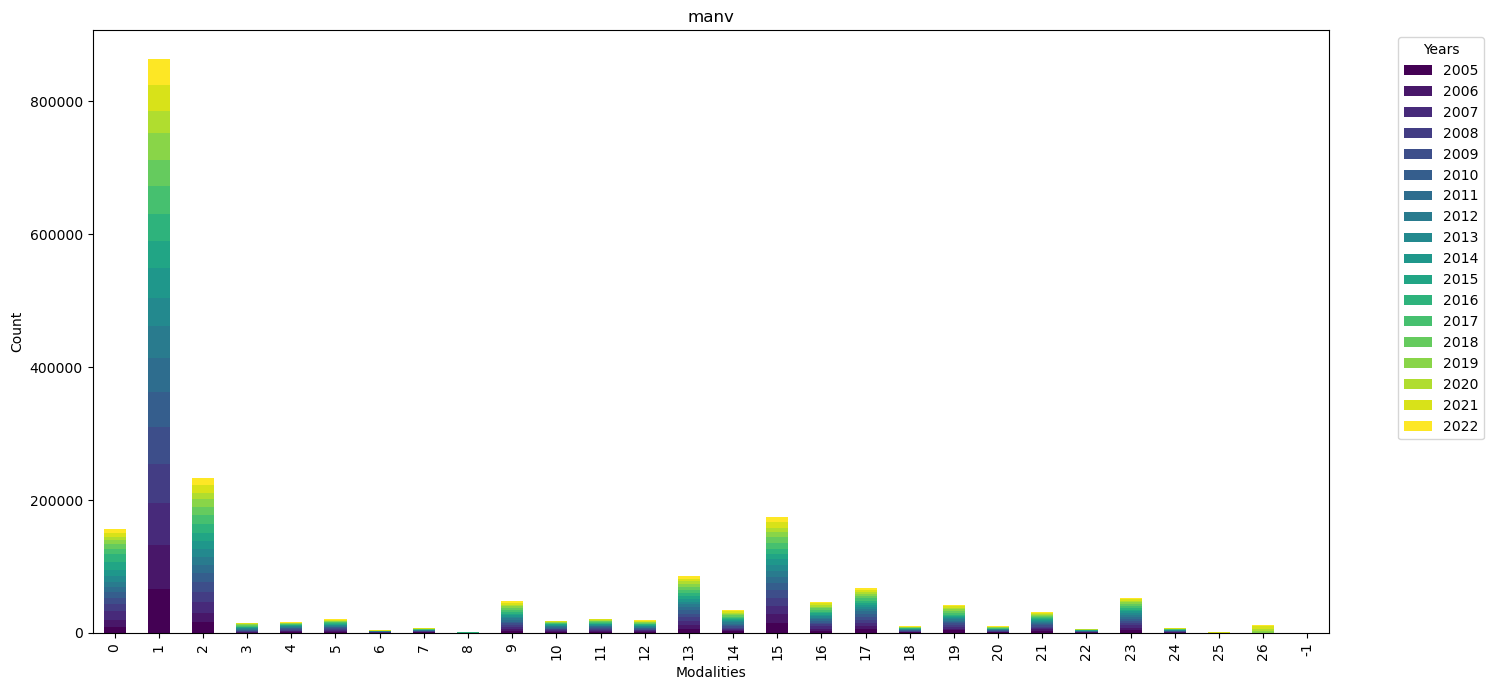

2024-10-24 13:44:43,310 - WARNING - Le nombre de modalités uniques dans la colonne manv excède le seuil de 12. Aucun graphique en ligne généré.


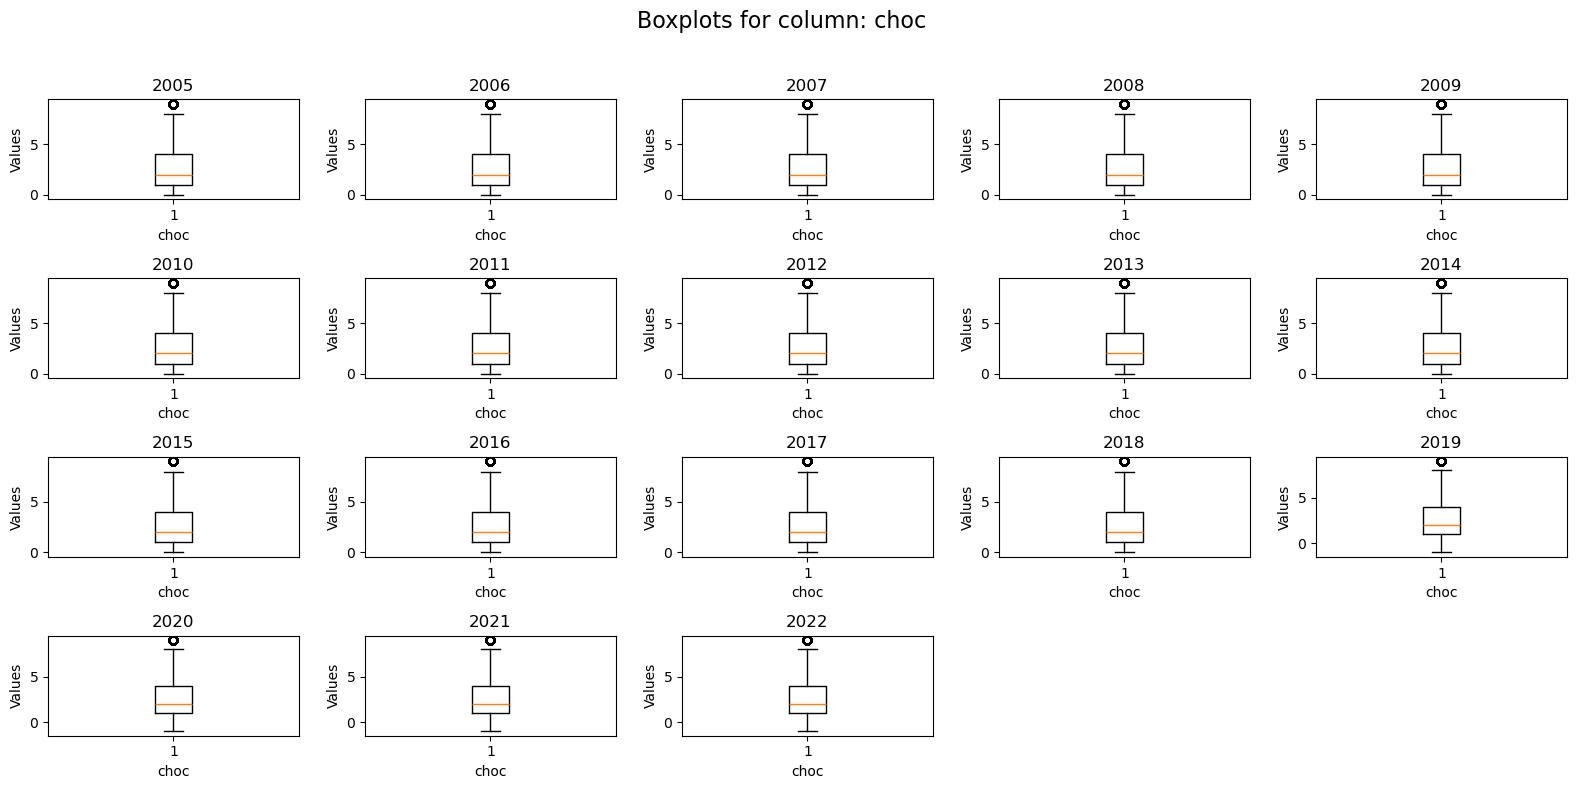

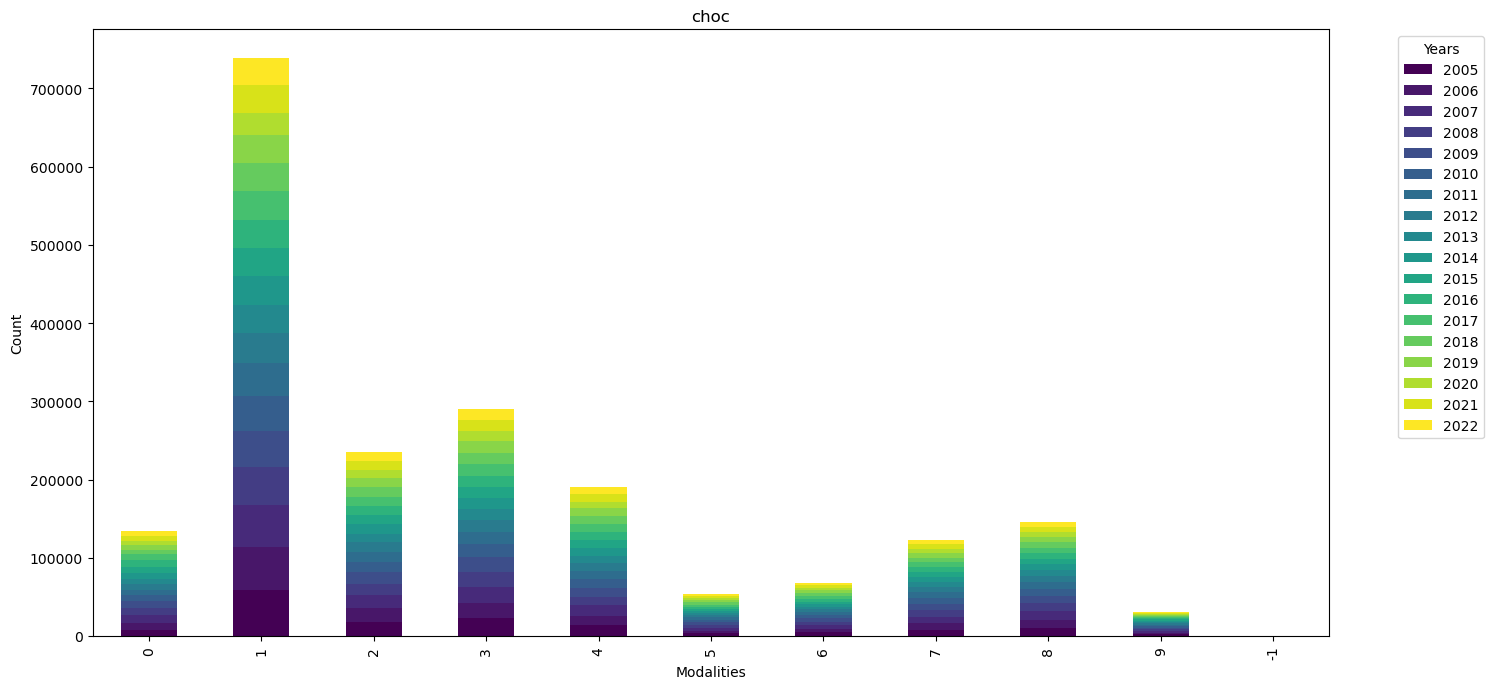

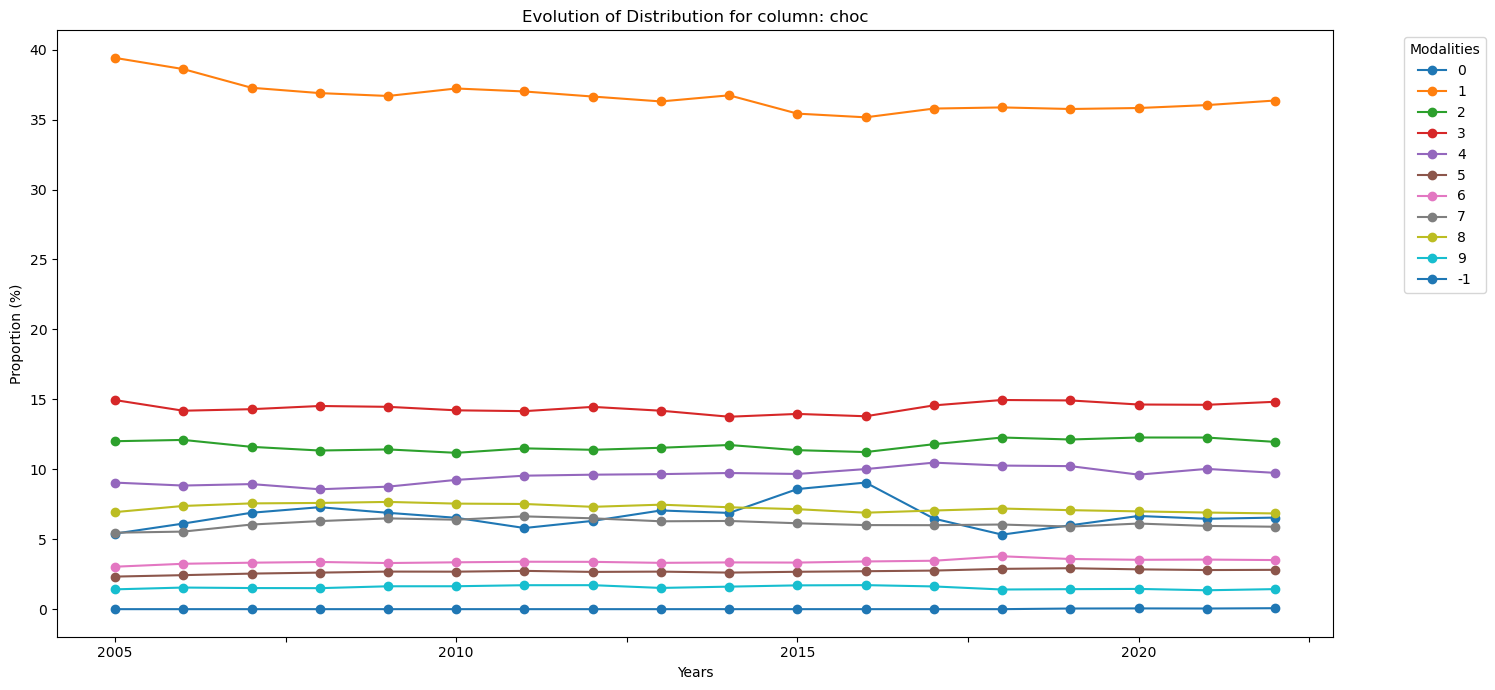

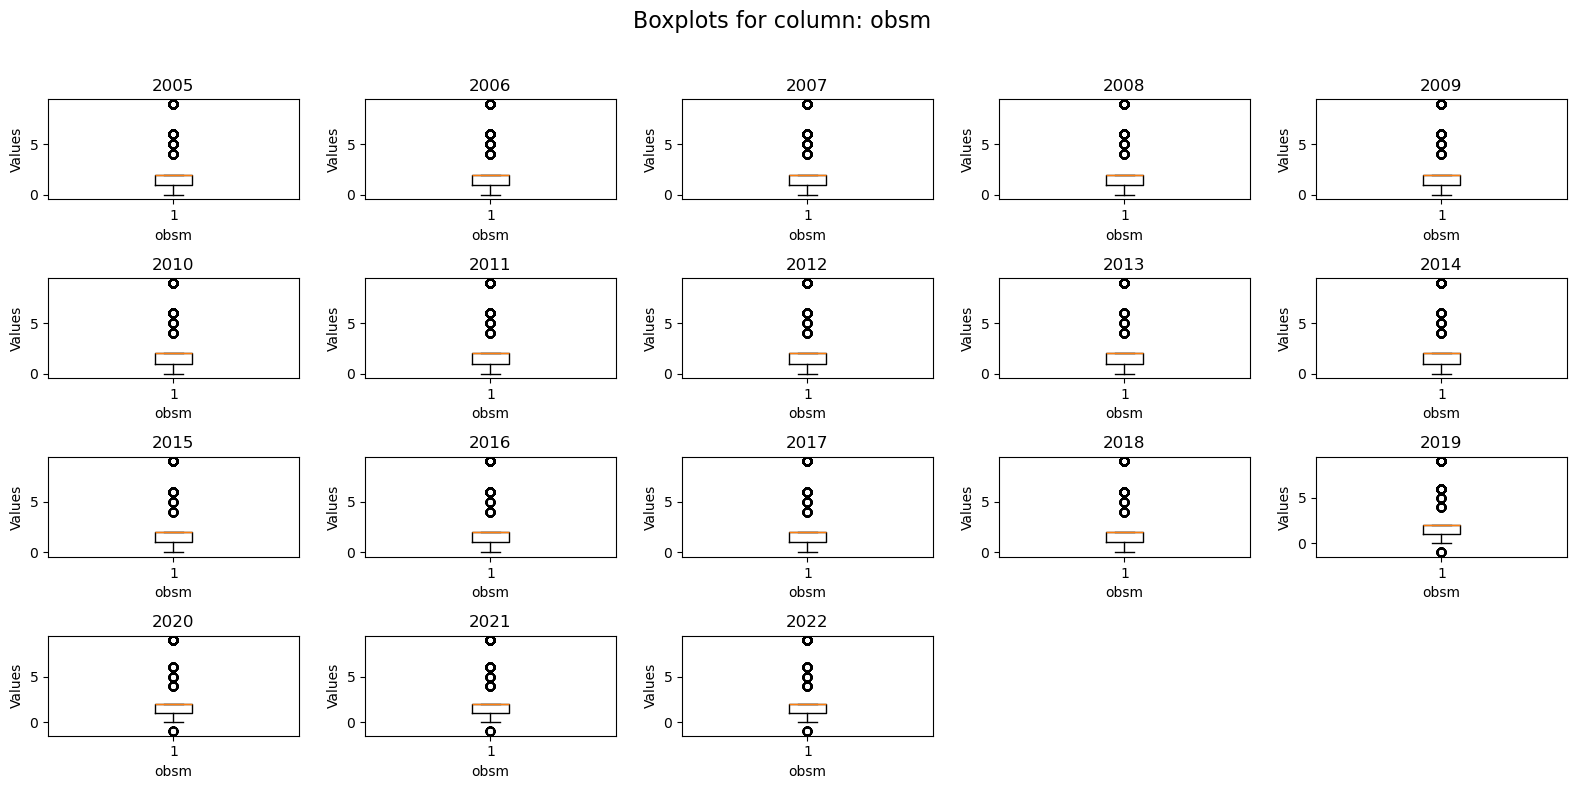

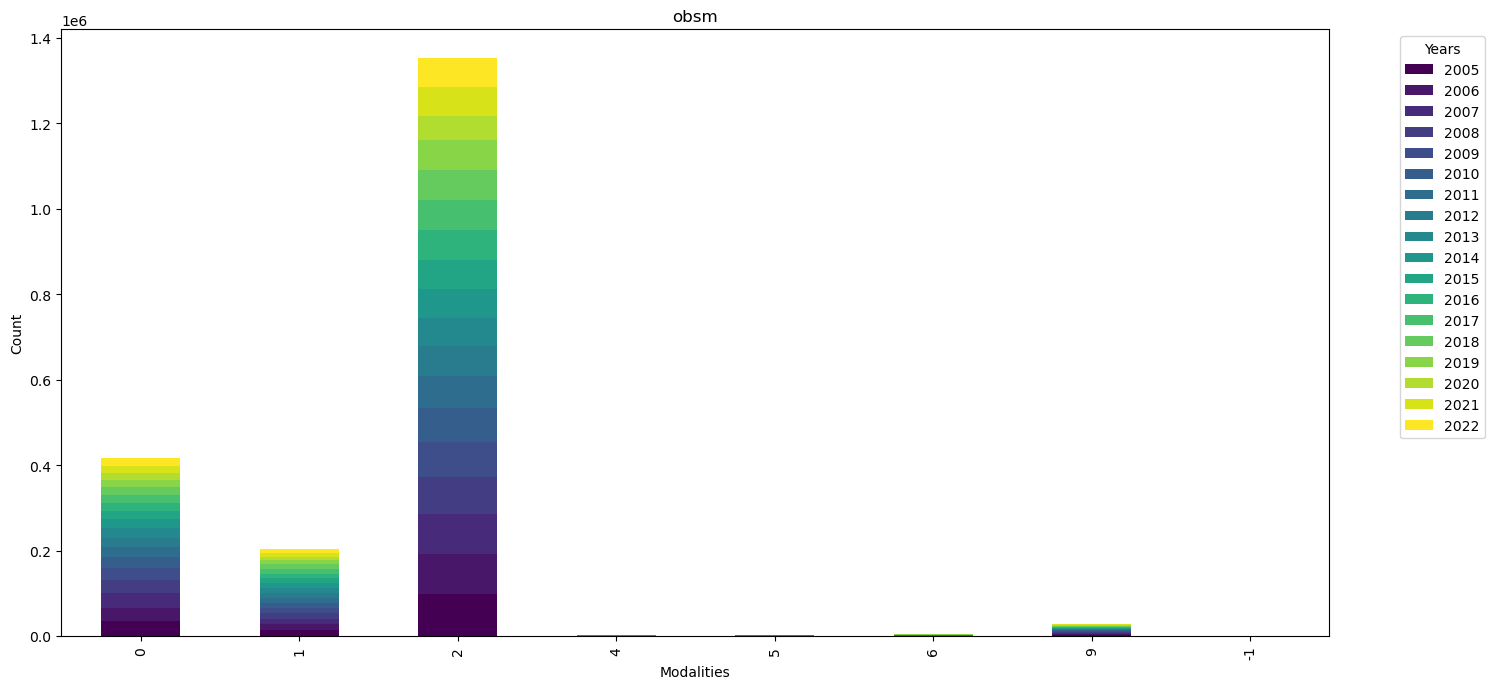

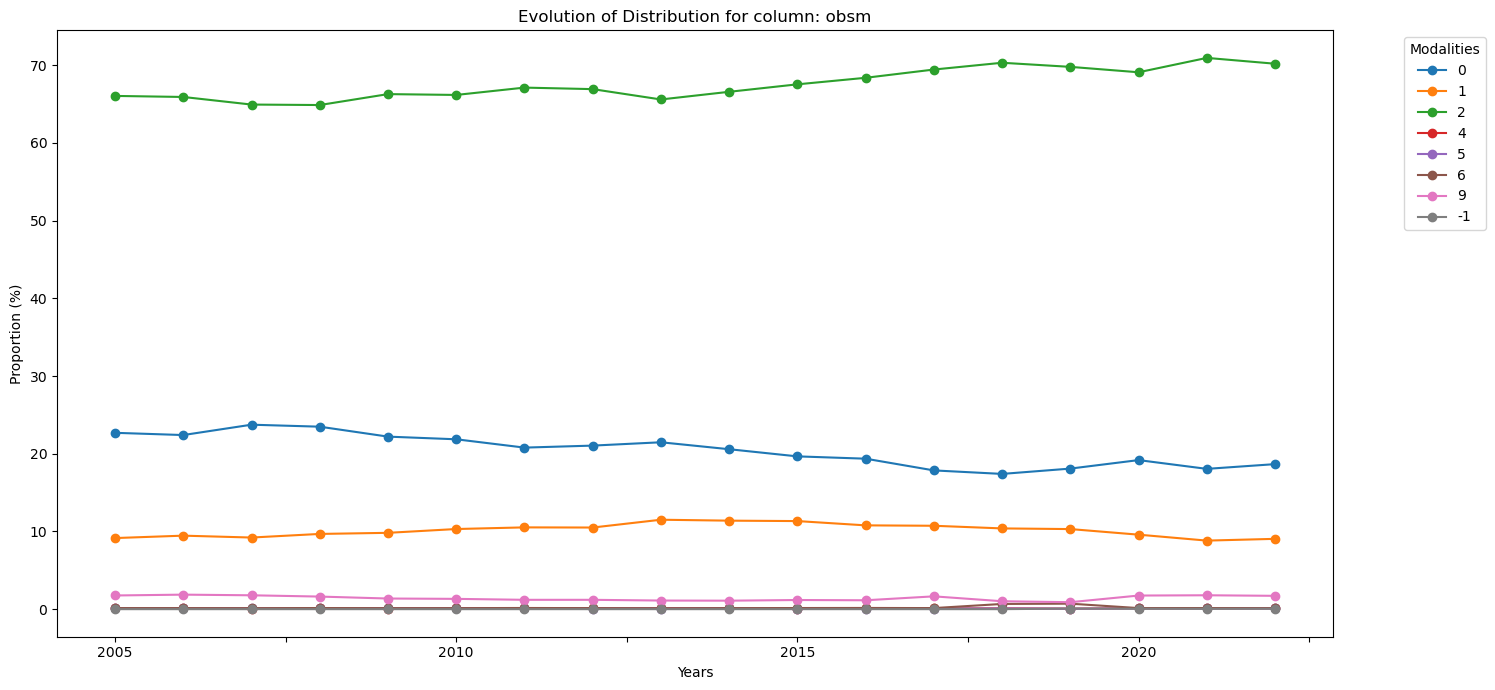

2024-10-24 13:44:46,655 - INFO - La colonne id_vehicule n'est pas numérique.
2024-10-24 13:44:46,808 - WARNING - Le nombre de modalités uniques dans la colonne id_vehicule excède le seuil de 50. Aucun bar plot généré.
2024-10-24 13:44:46,969 - WARNING - Le nombre de modalités uniques dans la colonne id_vehicule excède le seuil de 12. Aucun graphique en ligne généré.


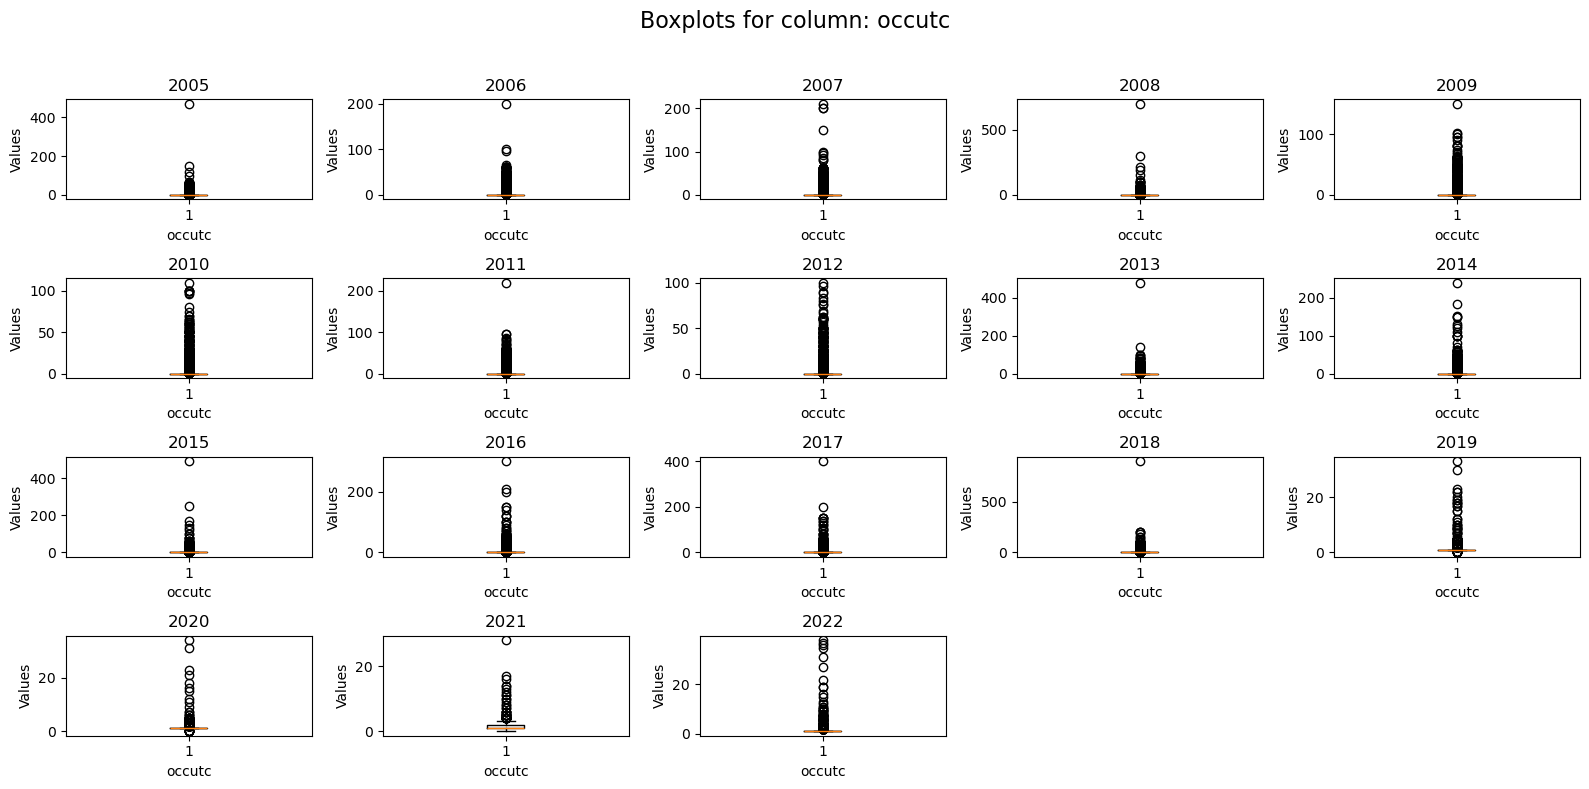

2024-10-24 13:44:48,243 - WARNING - Le nombre de modalités uniques dans la colonne occutc excède le seuil de 50. Aucun bar plot généré.
2024-10-24 13:44:48,260 - WARNING - Le nombre de modalités uniques dans la colonne occutc excède le seuil de 12. Aucun graphique en ligne généré.


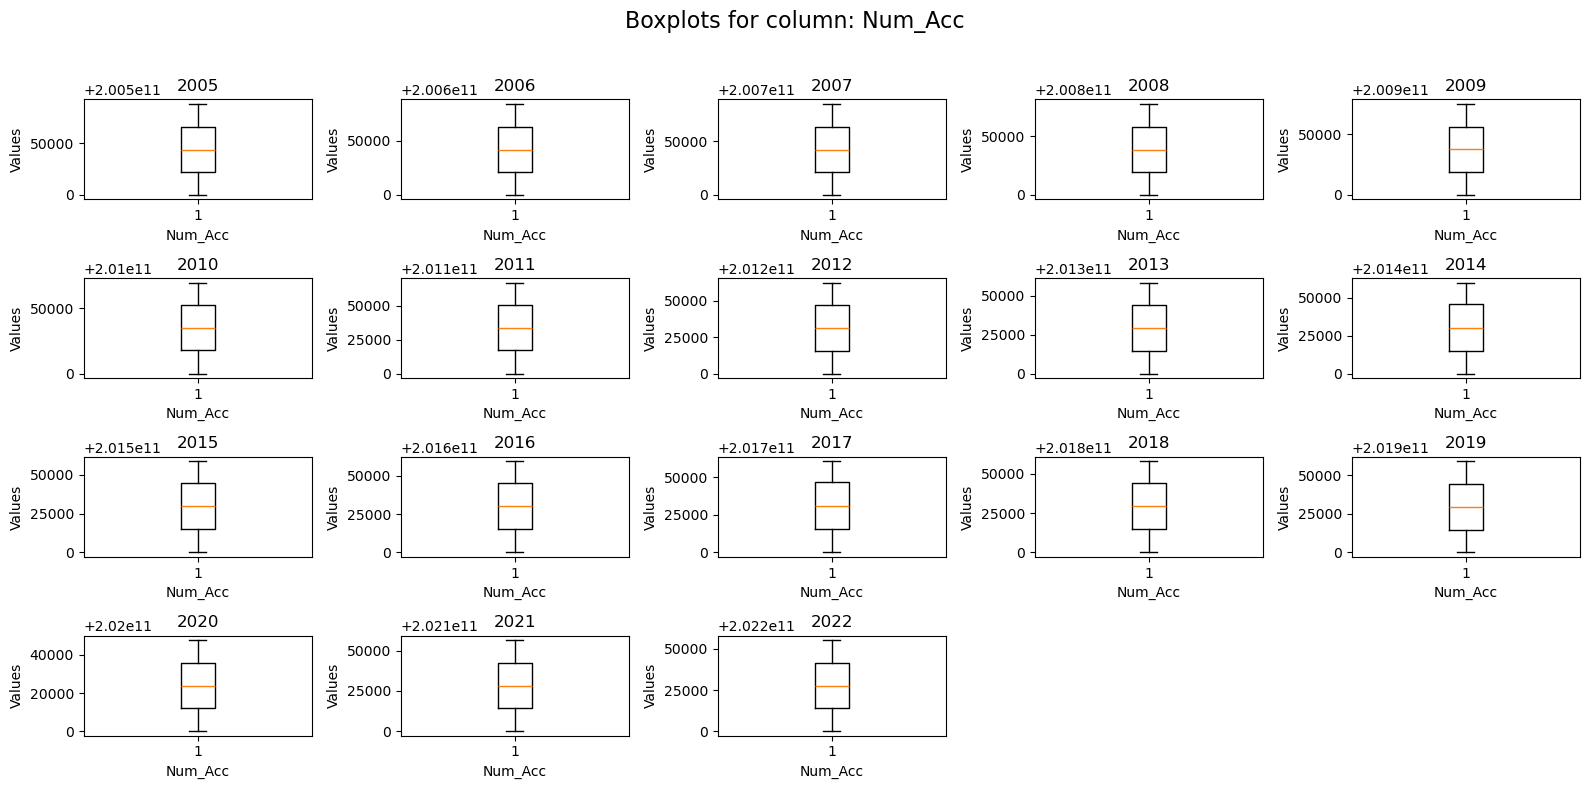

2024-10-24 13:44:49,702 - WARNING - Le nombre de modalités uniques dans la colonne Num_Acc excède le seuil de 50. Aucun bar plot généré.
2024-10-24 13:44:49,985 - WARNING - Le nombre de modalités uniques dans la colonne Num_Acc excède le seuil de 12. Aucun graphique en ligne généré.
2024-10-24 13:44:50,005 - INFO - La colonne num_veh n'est pas numérique.
2024-10-24 13:44:50,064 - WARNING - Le nombre de modalités uniques dans la colonne num_veh excède le seuil de 50. Aucun bar plot généré.
2024-10-24 13:44:50,125 - WARNING - Le nombre de modalités uniques dans la colonne num_veh excède le seuil de 12. Aucun graphique en ligne généré.


In [13]:
# Création d'une grille de boxplot
def create_boxplot_grid(column, datasets):
    if not any(pd.api.types.is_numeric_dtype(df[column]) for dataset in datasets for file_name, df in dataset.items() if column in df.columns):
        logging.info(f"La colonne {column} n'est pas numérique.")
        return

    n_datasets = len(datasets)
    n_cols = 5
    n_rows = math.ceil(n_datasets / n_cols)
    
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, n_rows * 2), squeeze=False)
    fig.suptitle(f'Boxplots for column: {column}', fontsize=16)
    
    for ax, dataset in zip(axes.flatten(), datasets):
        for file_name, df in dataset.items():
            if column in df.columns and pd.api.types.is_numeric_dtype(df[column]):
                ax.boxplot(df[column].dropna(), vert=True)
                ax.set_title(extract_year(file_name))
                ax.set_xlabel(column)
                ax.set_ylabel('Values')

    # Masquer les axes non utilisés
    for ax in axes.flatten()[n_datasets:]:
        ax.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Création d'un barplot pour visualiser la distribution des modalités
def create_total_stacked_barplot(column, datasets, max_modalities=50):
    modality_counts = {}

    for dataset in datasets:
        for file_name, df in dataset.items():
            if column in df.columns:
                modality_count = df[column].value_counts()
                modality_counts[file_name] = modality_count
    
    all_modalities = set()
    for counts in modality_counts.values():
        all_modalities.update(counts.index)
    
    if len(all_modalities) > max_modalities:
        logging.warning(f"Le nombre de modalités uniques dans la colonne {column} excède le seuil de {max_modalities}. Aucun bar plot généré.")
        return
    
    modality_data = {modality: [] for modality in all_modalities}
    years = [extract_year(file_name) for file_name in modality_counts.keys()]
    
    for modality in all_modalities:
        for file_name in modality_counts.keys():
            count = modality_counts[file_name].get(modality, 0)
            modality_data[modality].append(count)
    
    df_modalities = pd.DataFrame(modality_data, index=years).transpose()
    
    df_modalities.plot(kind='bar', stacked=True, figsize=(15, 7), colormap='viridis')
    plt.title(f'{column}')
    plt.xlabel('Modalities')
    plt.ylabel('Count')
    plt.legend(title='Years', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Création d'un lineplot pour visualiser l'évolution de la distribution des colonnes
def create_lineplot_evolution(column, datasets, max_modalities=12):
    modality_counts = {}

    for dataset in datasets:
        for file_name, df in dataset.items():
            if column in df.columns:
                year = extract_year(file_name)
                modality_count = df[column].value_counts(normalize=True) * 100
                if year not in modality_counts:
                    modality_counts[year] = modality_count
                else:
                    modality_counts[year] = modality_counts[year].add(modality_count, fill_value=0)
    
    all_modalities = set()
    for counts in modality_counts.values():
        all_modalities.update(counts.index)
    
    if len(all_modalities) > max_modalities:
        logging.warning(f"Le nombre de modalités uniques dans la colonne {column} excède le seuil de {max_modalities}. Aucun graphique en ligne généré.")
        return
    
    modality_data = {modality: [] for modality in all_modalities}
    years = sorted(modality_counts.keys())
    
    for modality in all_modalities:
        for year in years:
            count = modality_counts[year].get(modality, 0)
            modality_data[modality].append(count)
    
    df_modalities = pd.DataFrame(modality_data, index=years)
    
    df_modalities.plot(kind='line', figsize=(15, 7), marker='o')
    plt.title(f'Evolution of Distribution for column: {column}')
    plt.xlabel('Years')
    plt.ylabel('Proportion (%)')
    plt.legend(title='Modalities', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Fonction de génération des graphiques par colonne et par dataset
def one_column_generate_plots(column, datasets):
    create_boxplot_grid(column, datasets)
    create_total_stacked_barplot(column, datasets)
    create_lineplot_evolution(column, datasets)

# Fonction de génération des graphiques pour toutes les colonnes et tous les datasets
def all_columns_generate_plots(datasets):
    all_columns = set()
    for dataset in datasets:
        for file_name, df in dataset.items():
            logging.info(f'Chargement de {file_name}.')
            all_columns.update(df.columns)

    for column in all_columns:
        one_column_generate_plots(column, datasets)

for datasets in dataframes:
    all_columns_generate_plots(datasets)

## Analyse des données brutes concaténées

* Concaténation des dataframes par rubrique

In [16]:
# Fonction pour concaténer les dataframes par rubrique

# Initialisation d'un dictionnaire
concatenated_dfs = {}

# Parcourir chaque préfixe et sa liste de DataFrames correspondante
for prefix, df_list in zip(prefixes, dataframes):
    # Liste pour stocker tous les DataFrames d'un préfixe
    dfs_to_concat = []
    
    # Parcourir chaque dictionnaire dans la liste de DataFrames
    for dataset in df_list:
        for _, df in dataset.items():
            dfs_to_concat.append(df)
    
    # Concaténer tous les DataFrames pour ce préfixe
    if dfs_to_concat:
        concatenated_df = pd.concat(dfs_to_concat, ignore_index=True)
        
        # Ajouter le DataFrame concaténé au dictionnaire, nommé par le préfixe
        concatenated_dfs[prefix] = concatenated_df

# Afficher des informations sur les DataFrames concaténés
for prefix, df in concatenated_dfs.items():
    logging.info(f"Dataframe contaténé pour '{prefix}' : {len(df)} lignes, {df.shape[1]} colonnes")

2024-10-24 13:44:51,033 - INFO - Dataframe contaténé pour 'caracteristiques' : 1176873 lignes, 17 colonnes
2024-10-24 13:44:51,033 - INFO - Dataframe contaténé pour 'lieux' : 1176873 lignes, 19 colonnes
2024-10-24 13:44:51,033 - INFO - Dataframe contaténé pour 'usagers' : 2636377 lignes, 17 colonnes
2024-10-24 13:44:51,033 - INFO - Dataframe contaténé pour 'vehicules' : 2009395 lignes, 11 colonnes


* Description des variables

In [18]:
# Calcul du nombre de valeurs count, unique, top et frequence pour chaque variable de chaque dataframe

def stats_descriptives(df):
    resultats = {}
    for colonne in df.columns:
        
        col_data = df[colonne]
        
        count = col_data.count()
        unique = col_data.nunique()
        top = col_data.mode().iloc[0] if not col_data.mode().empty else None
        freq = col_data.value_counts().iloc[0] if not col_data.value_counts().empty else None
        
        data_info = pd.DataFrame({
            "count": [count],
            "unique": [unique],
            "top": [top],
            "freq": [freq]
        }, index=[colonne])

        resultats[colonne] = data_info
    
    return resultats

# Stockage des résultats pour chaque variable de chaque dataframe 
resultats_par_dataframe = {}
for prefix, df in concatenated_dfs.items():
    resultats_par_dataframe[prefix] = stats_descriptives(df)

# Affichage des résultats pour chaque variable de chaque dataframe
for prefix, resultats in resultats_par_dataframe.items():
    print('=' * 50, "\n")
    print(f"Résultats pour '{prefix}' :\n")
    for colonne, data_info in resultats.items():
        print(f"Colonne {colonne} :")
        display(data_info)

# Affichage des résultats synthétiques pour chaque dataframe
for prefix, resultats in resultats_par_dataframe.items():
    print('=' * 50, "\n")
    print(f"Résumé pour '{prefix}':")
    resume = pd.concat(resultats.values())
    display(resume)


Résultats pour 'caracteristiques' :

Colonne Num_Acc :


count   unique           top  freq
Num_Acc  1121571  1121571  2.005000e+11     1

Colonne an :


count  unique  top   freq
an  1176873      18    5  87026

Colonne mois :


count  unique  top    freq
mois  1176873      12   10  111728

Colonne jour :


count  unique  top   freq
jour  1176873      31    6  40053

Colonne hrmn :


count  unique   top   freq
hrmn  1176873    2877  1800  14635

Colonne lum :


count  unique  top    freq
lum  1176873       6    1  803169

Colonne agg :


count  unique  top    freq
agg  1176873       2    2  791831

Colonne int :


count  unique  top    freq
int  1176873      11    1  820757

Colonne atm :


count  unique  top    freq
atm  1176800      10  1.0  949701

Colonne col :


count  unique  top    freq
col  1176854       8  6.0  381967

Colonne com :


count  unique   top   freq
com  1176871   22183  55.0  37562

Colonne adr :


count  unique            top  freq
adr  1032364  483819  AUTOROUTE A86  4268

Colonne gps :


count  unique top    freq
gps  480052      10   M  462639

Colonne lat :


count  unique  top    freq
lat  689805  379834  0.0  117839

Colonne long :


count  unique  top    freq
long  689801  415250  0.0  107376

Colonne dep :


count  unique  top   freq
dep  1176873     217  750  99021

Colonne Accident_Id :


count  unique           top  freq
Accident_Id  55302   55302  2.022000e+11     1


Résultats pour 'lieux' :

Colonne Num_Acc :


count   unique           top  freq
Num_Acc  1176873  1176873  200500000001     1

Colonne catr :


count  unique  top    freq
catr  1176872       8  4.0  571872

Colonne voie :


count  unique  top    freq
voie  1064888   38865  0.0  429071

Colonne v1 :


count  unique  top    freq
v1  541049      11  0.0  504288

Colonne v2 :


count  unique top   freq
v2  56624      74   A  24722

Colonne circ :


count  unique  top    freq
circ  1175299       6  2.0  741823

Colonne nbv :


count  unique  top    freq
nbv  1174142      69    2  635009

Colonne pr :


count  unique  top    freq
pr  701389    1413  0.0  150037

Colonne pr1 :


count  unique  top    freq
pr1  699570    3708  0.0  198026

Colonne vosp :


count  unique  top     freq
vosp  1174112       5  0.0  1090745

Colonne prof :


count  unique  top    freq
prof  1174924       6  1.0  904058

Colonne plan :


count  unique  top    freq
plan  1174592       6  1.0  903356

Colonne lartpc :


count  unique  top    freq
lartpc  902767     469    0  758832

Colonne larrout :


count  unique  top    freq
larrout  1064032     728    0  287708

Colonne surf :


count  unique  top    freq
surf  1174949      11  1.0  921298

Colonne infra :


count  unique  top     freq
infra  1171465      11  0.0  1032089

Colonne situ :


count  unique  top    freq
situ  1171903       9  1.0  983318

Colonne env1 :


count  unique  top    freq
env1  953029       3  0.0  541532

Colonne vma :


count  unique   top    freq
vma  218404      47  50.0  115319


Résultats pour 'usagers' :

Colonne Num_Acc :


count   unique           top  freq
Num_Acc  2636377  1176873  200600016834    86

Colonne place :


count  unique  top     freq
place  2513249      12  1.0  1962529

Colonne catu :


count  unique  top     freq
catu  2636377       4    1  1961486

Colonne grav :


count  unique  top     freq
grav  2636377       5    1  1082746

Colonne sexe :


count  unique  top     freq
sexe  2636377       3    1  1773190

Colonne trajet :


count  unique  top    freq
trajet  2635883       8  5.0  978415

Colonne secu :


count  unique   top     freq
secu  2085658      24  11.0  1197467

Colonne locp :


count  unique  top     freq
locp  2580016      11  0.0  2162665

Colonne actp :


count  unique  top     freq
actp  2579915      21    0  1913376

Colonne etatp :


count  unique  top     freq
etatp  2579959       5  0.0  1914793

Colonne an_nais :


count  unique     top   freq
an_nais  2628018     127  1988.0  66282

Colonne num_veh :


count  unique  top     freq
num_veh  2636377     181  A01  1601497

Colonne id_vehicule :


count  unique      top  freq
id_vehicule  494182  369639  755 536    38

Colonne secu1 :


count  unique  top    freq
secu1  494182      11  1.0  292332

Colonne secu2 :


count  unique  top    freq
secu2  494182      11 -1.0  193509

Colonne secu3 :


count  unique  top    freq
secu3  494182      11 -1.0  488588

Colonne id_usager :


count  unique      top  freq
id_usager  255910  255910  133 818     1


Résultats pour 'vehicules' :

Colonne Num_Acc :


count   unique           top  freq
Num_Acc  2009395  1176873  200600074917    56

Colonne senc :


count  unique  top     freq
senc  2009123       5  0.0  1384153

Colonne catv :


count  unique  top     freq
catv  2009395      41    7  1237634

Colonne occutc :


count  unique  top     freq
occutc  1638885     124  0.0  1624683

Colonne obs :


count  unique  top     freq
obs  2008389      19  0.0  1740874

Colonne obsm :


count  unique  top     freq
obsm  2008617       8  2.0  1352641

Colonne choc :


count  unique  top    freq
choc  2008998      11  1.0  738510

Colonne manv :


count  unique  top    freq
manv  2008927      28  1.0  863725

Colonne num_veh :


count  unique  top     freq
num_veh  2009395     189  A01  1160074

Colonne id_vehicule :


count  unique      top  freq
id_vehicule  373584  373584  100 882     1

Colonne motor :


count  unique  top    freq
motor  373584       8  1.0  304898


Résumé pour 'caracteristiques':


count   unique             top    freq
Num_Acc      1121571  1121571  200500000001.0       1
an           1176873       18               5   87026
mois         1176873       12              10  111728
jour         1176873       31               6   40053
hrmn         1176873     2877            1800   14635
lum          1176873        6               1  803169
agg          1176873        2               2  791831
int          1176873       11               1  820757
atm          1176800       10             1.0  949701
col          1176854        8             6.0  381967
com          1176871    22183            55.0   37562
adr          1032364   483819   AUTOROUTE A86    4268
gps           480052       10               M  462639
lat           689805   379834             0.0  117839
long          689801   415250             0.0  107376
dep          1176873      217             750   99021
Accident_Id    55302    55302  202200000001.0       1


Résumé pour 'lieux':


count   unique           top     freq
Num_Acc  1176873  1176873  200500000001        1
catr     1176872        8           4.0   571872
voie     1064888    38865           0.0   429071
v1        541049       11           0.0   504288
v2         56624       74             A    24722
circ     1175299        6           2.0   741823
nbv      1174142       69             2   635009
pr        701389     1413           0.0   150037
pr1       699570     3708           0.0   198026
vosp     1174112        5           0.0  1090745
prof     1174924        6           1.0   904058
plan     1174592        6           1.0   903356
lartpc    902767      469             0   758832
larrout  1064032      728             0   287708
surf     1174949       11           1.0   921298
infra    1171465       11           0.0  1032089
situ     1171903        9           1.0   983318
env1      953029        3           0.0   541532
vma       218404       47          50.0   115319


Résumé pour 'usagers':


count   unique           top     freq
Num_Acc      2636377  1176873  200600016834       86
place        2513249       12           1.0  1962529
catu         2636377        4             1  1961486
grav         2636377        5             1  1082746
sexe         2636377        3             1  1773190
trajet       2635883        8           5.0   978415
secu         2085658       24          11.0  1197467
locp         2580016       11           0.0  2162665
actp         2579915       21             0  1913376
etatp        2579959        5           0.0  1914793
an_nais      2628018      127        1988.0    66282
num_veh      2636377      181           A01  1601497
id_vehicule   494182   369639       755 536       38
secu1         494182       11           1.0   292332
secu2         494182       11          -1.0   193509
secu3         494182       11          -1.0   488588
id_usager     255910   255910       133 818        1


Résumé pour 'vehicules':


count   unique           top     freq
Num_Acc      2009395  1176873  200600074917       56
senc         2009123        5           0.0  1384153
catv         2009395       41             7  1237634
occutc       1638885      124           0.0  1624683
obs          2008389       19           0.0  1740874
obsm         2008617        8           2.0  1352641
choc         2008998       11           1.0   738510
manv         2008927       28           1.0   863725
num_veh      2009395      189           A01  1160074
id_vehicule   373584   373584       100 882        1
motor         373584        8           1.0   304898

In [19]:
def analyser_valeurs_nulles(df, nom):
    resultats = {}
    for colonne in df.columns:
        col_data = df[colonne]
        
        val_notnull = col_data.notnull().sum()
        val_null = col_data.isnull().sum()
        tx_null = round((val_null / len(col_data) * 100), 2)
        
        data_info = pd.DataFrame({
            "Type": [col_data.dtype],
            "Val_notnull": [val_notnull],
            "Val_null": [val_null],
            "%_null": [tx_null]
        }, index=[colonne])
        
        resultats[colonne] = data_info
    
    print(f"Résultats pour le DataFrame {nom} :\n")
    for colonne, data_info in resultats.items():
        print(f"Colonne {colonne} :\n")
        display(data_info)
        print("\n")
    
    return resultats

# Stockage des résultats pour chaque variable de chaque dataframe 
resultats_par_dataframe = {}
for prefix, df in concatenated_dfs.items():
    resultats_par_dataframe[prefix] = analyser_valeurs_nulles(df, prefix)

# Affichage des résultats pour chaque variable de chaque dataframe
for prefix, resultats in resultats_par_dataframe.items():
    print('=' * 50, "\n")
    print(f"Résultats pour '{prefix}' :\n")
    for colonne, data_info in resultats.items():
        print(f"Colonne {colonne} :")
        display(data_info)

# Affichage des résultats synthétiques pour chaque dataframe
for prefix, resultats in resultats_par_dataframe.items():
    print('=' * 50, "\n")
    print(f"Résumé pour '{prefix}':")
    resume = pd.concat(resultats.values())
    display(resume)


Résultats pour le DataFrame caracteristiques :

Colonne Num_Acc :



Type  Val_notnull  Val_null  %_null
Num_Acc  float64      1121571     55302     4.7



Colonne an :



Type  Val_notnull  Val_null  %_null
an  int64      1176873         0     0.0



Colonne mois :



Type  Val_notnull  Val_null  %_null
mois  int64      1176873         0     0.0



Colonne jour :



Type  Val_notnull  Val_null  %_null
jour  int64      1176873         0     0.0



Colonne hrmn :



Type  Val_notnull  Val_null  %_null
hrmn  object      1176873         0     0.0



Colonne lum :



Type  Val_notnull  Val_null  %_null
lum  int64      1176873         0     0.0



Colonne agg :



Type  Val_notnull  Val_null  %_null
agg  int64      1176873         0     0.0



Colonne int :



Type  Val_notnull  Val_null  %_null
int  int64      1176873         0     0.0



Colonne atm :



Type  Val_notnull  Val_null  %_null
atm  float64      1176800        73    0.01



Colonne col :



Type  Val_notnull  Val_null  %_null
col  float64      1176854        19     0.0



Colonne com :



Type  Val_notnull  Val_null  %_null
com  object      1176871         2     0.0



Colonne adr :



Type  Val_notnull  Val_null  %_null
adr  object      1032364    144509   12.28



Colonne gps :



Type  Val_notnull  Val_null  %_null
gps  object       480052    696821   59.21



Colonne lat :



Type  Val_notnull  Val_null  %_null
lat  object       689805    487068   41.39



Colonne long :



Type  Val_notnull  Val_null  %_null
long  object       689801    487072   41.39



Colonne dep :



Type  Val_notnull  Val_null  %_null
dep  object      1176873         0     0.0



Colonne Accident_Id :



Type  Val_notnull  Val_null  %_null
Accident_Id  float64        55302   1121571    95.3



Résultats pour le DataFrame lieux :

Colonne Num_Acc :



Type  Val_notnull  Val_null  %_null
Num_Acc  int64      1176873         0     0.0



Colonne catr :



Type  Val_notnull  Val_null  %_null
catr  float64      1176872         1     0.0



Colonne voie :



Type  Val_notnull  Val_null  %_null
voie  object      1064888    111985    9.52



Colonne v1 :



Type  Val_notnull  Val_null  %_null
v1  float64       541049    635824   54.03



Colonne v2 :



Type  Val_notnull  Val_null  %_null
v2  object        56624   1120249   95.19



Colonne circ :



Type  Val_notnull  Val_null  %_null
circ  float64      1175299      1574    0.13



Colonne nbv :



Type  Val_notnull  Val_null  %_null
nbv  object      1174142      2731    0.23



Colonne pr :



Type  Val_notnull  Val_null  %_null
pr  object       701389    475484    40.4



Colonne pr1 :



Type  Val_notnull  Val_null  %_null
pr1  object       699570    477303   40.56



Colonne vosp :



Type  Val_notnull  Val_null  %_null
vosp  float64      1174112      2761    0.23



Colonne prof :



Type  Val_notnull  Val_null  %_null
prof  float64      1174924      1949    0.17



Colonne plan :



Type  Val_notnull  Val_null  %_null
plan  float64      1174592      2281    0.19



Colonne lartpc :



Type  Val_notnull  Val_null  %_null
lartpc  object       902767    274106   23.29



Colonne larrout :



Type  Val_notnull  Val_null  %_null
larrout  object      1064032    112841    9.59



Colonne surf :



Type  Val_notnull  Val_null  %_null
surf  float64      1174949      1924    0.16



Colonne infra :



Type  Val_notnull  Val_null  %_null
infra  float64      1171465      5408    0.46



Colonne situ :



Type  Val_notnull  Val_null  %_null
situ  float64      1171903      4970    0.42



Colonne env1 :



Type  Val_notnull  Val_null  %_null
env1  float64       953029    223844   19.02



Colonne vma :



Type  Val_notnull  Val_null  %_null
vma  float64       218404    958469   81.44



Résultats pour le DataFrame usagers :

Colonne Num_Acc :



Type  Val_notnull  Val_null  %_null
Num_Acc  int64      2636377         0     0.0



Colonne place :



Type  Val_notnull  Val_null  %_null
place  float64      2513249    123128    4.67



Colonne catu :



Type  Val_notnull  Val_null  %_null
catu  int64      2636377         0     0.0



Colonne grav :



Type  Val_notnull  Val_null  %_null
grav  int64      2636377         0     0.0



Colonne sexe :



Type  Val_notnull  Val_null  %_null
sexe  int64      2636377         0     0.0



Colonne trajet :



Type  Val_notnull  Val_null  %_null
trajet  float64      2635883       494    0.02



Colonne secu :



Type  Val_notnull  Val_null  %_null
secu  float64      2085658    550719   20.89



Colonne locp :



Type  Val_notnull  Val_null  %_null
locp  float64      2580016     56361    2.14



Colonne actp :



Type  Val_notnull  Val_null  %_null
actp  object      2579915     56462    2.14



Colonne etatp :



Type  Val_notnull  Val_null  %_null
etatp  float64      2579959     56418    2.14



Colonne an_nais :



Type  Val_notnull  Val_null  %_null
an_nais  float64      2628018      8359    0.32



Colonne num_veh :



Type  Val_notnull  Val_null  %_null
num_veh  object      2636377         0     0.0



Colonne id_vehicule :



Type  Val_notnull  Val_null  %_null
id_vehicule  object       494182   2142195   81.26



Colonne secu1 :



Type  Val_notnull  Val_null  %_null
secu1  float64       494182   2142195   81.26



Colonne secu2 :



Type  Val_notnull  Val_null  %_null
secu2  float64       494182   2142195   81.26



Colonne secu3 :



Type  Val_notnull  Val_null  %_null
secu3  float64       494182   2142195   81.26



Colonne id_usager :



Type  Val_notnull  Val_null  %_null
id_usager  object       255910   2380467   90.29



Résultats pour le DataFrame vehicules :

Colonne Num_Acc :



Type  Val_notnull  Val_null  %_null
Num_Acc  int64      2009395         0     0.0



Colonne senc :



Type  Val_notnull  Val_null  %_null
senc  float64      2009123       272    0.01



Colonne catv :



Type  Val_notnull  Val_null  %_null
catv  int64      2009395         0     0.0



Colonne occutc :



Type  Val_notnull  Val_null  %_null
occutc  float64      1638885    370510   18.44



Colonne obs :



Type  Val_notnull  Val_null  %_null
obs  float64      2008389      1006    0.05



Colonne obsm :



Type  Val_notnull  Val_null  %_null
obsm  float64      2008617       778    0.04



Colonne choc :



Type  Val_notnull  Val_null  %_null
choc  float64      2008998       397    0.02



Colonne manv :



Type  Val_notnull  Val_null  %_null
manv  float64      2008927       468    0.02



Colonne num_veh :



Type  Val_notnull  Val_null  %_null
num_veh  object      2009395         0     0.0



Colonne id_vehicule :



Type  Val_notnull  Val_null  %_null
id_vehicule  object       373584   1635811   81.41



Colonne motor :



Type  Val_notnull  Val_null  %_null
motor  float64       373584   1635811   81.41




Résultats pour 'caracteristiques' :

Colonne Num_Acc :


Type  Val_notnull  Val_null  %_null
Num_Acc  float64      1121571     55302     4.7

Colonne an :


Type  Val_notnull  Val_null  %_null
an  int64      1176873         0     0.0

Colonne mois :


Type  Val_notnull  Val_null  %_null
mois  int64      1176873         0     0.0

Colonne jour :


Type  Val_notnull  Val_null  %_null
jour  int64      1176873         0     0.0

Colonne hrmn :


Type  Val_notnull  Val_null  %_null
hrmn  object      1176873         0     0.0

Colonne lum :


Type  Val_notnull  Val_null  %_null
lum  int64      1176873         0     0.0

Colonne agg :


Type  Val_notnull  Val_null  %_null
agg  int64      1176873         0     0.0

Colonne int :


Type  Val_notnull  Val_null  %_null
int  int64      1176873         0     0.0

Colonne atm :


Type  Val_notnull  Val_null  %_null
atm  float64      1176800        73    0.01

Colonne col :


Type  Val_notnull  Val_null  %_null
col  float64      1176854        19     0.0

Colonne com :


Type  Val_notnull  Val_null  %_null
com  object      1176871         2     0.0

Colonne adr :


Type  Val_notnull  Val_null  %_null
adr  object      1032364    144509   12.28

Colonne gps :


Type  Val_notnull  Val_null  %_null
gps  object       480052    696821   59.21

Colonne lat :


Type  Val_notnull  Val_null  %_null
lat  object       689805    487068   41.39

Colonne long :


Type  Val_notnull  Val_null  %_null
long  object       689801    487072   41.39

Colonne dep :


Type  Val_notnull  Val_null  %_null
dep  object      1176873         0     0.0

Colonne Accident_Id :


Type  Val_notnull  Val_null  %_null
Accident_Id  float64        55302   1121571    95.3


Résultats pour 'lieux' :

Colonne Num_Acc :


Type  Val_notnull  Val_null  %_null
Num_Acc  int64      1176873         0     0.0

Colonne catr :


Type  Val_notnull  Val_null  %_null
catr  float64      1176872         1     0.0

Colonne voie :


Type  Val_notnull  Val_null  %_null
voie  object      1064888    111985    9.52

Colonne v1 :


Type  Val_notnull  Val_null  %_null
v1  float64       541049    635824   54.03

Colonne v2 :


Type  Val_notnull  Val_null  %_null
v2  object        56624   1120249   95.19

Colonne circ :


Type  Val_notnull  Val_null  %_null
circ  float64      1175299      1574    0.13

Colonne nbv :


Type  Val_notnull  Val_null  %_null
nbv  object      1174142      2731    0.23

Colonne pr :


Type  Val_notnull  Val_null  %_null
pr  object       701389    475484    40.4

Colonne pr1 :


Type  Val_notnull  Val_null  %_null
pr1  object       699570    477303   40.56

Colonne vosp :


Type  Val_notnull  Val_null  %_null
vosp  float64      1174112      2761    0.23

Colonne prof :


Type  Val_notnull  Val_null  %_null
prof  float64      1174924      1949    0.17

Colonne plan :


Type  Val_notnull  Val_null  %_null
plan  float64      1174592      2281    0.19

Colonne lartpc :


Type  Val_notnull  Val_null  %_null
lartpc  object       902767    274106   23.29

Colonne larrout :


Type  Val_notnull  Val_null  %_null
larrout  object      1064032    112841    9.59

Colonne surf :


Type  Val_notnull  Val_null  %_null
surf  float64      1174949      1924    0.16

Colonne infra :


Type  Val_notnull  Val_null  %_null
infra  float64      1171465      5408    0.46

Colonne situ :


Type  Val_notnull  Val_null  %_null
situ  float64      1171903      4970    0.42

Colonne env1 :


Type  Val_notnull  Val_null  %_null
env1  float64       953029    223844   19.02

Colonne vma :


Type  Val_notnull  Val_null  %_null
vma  float64       218404    958469   81.44


Résultats pour 'usagers' :

Colonne Num_Acc :


Type  Val_notnull  Val_null  %_null
Num_Acc  int64      2636377         0     0.0

Colonne place :


Type  Val_notnull  Val_null  %_null
place  float64      2513249    123128    4.67

Colonne catu :


Type  Val_notnull  Val_null  %_null
catu  int64      2636377         0     0.0

Colonne grav :


Type  Val_notnull  Val_null  %_null
grav  int64      2636377         0     0.0

Colonne sexe :


Type  Val_notnull  Val_null  %_null
sexe  int64      2636377         0     0.0

Colonne trajet :


Type  Val_notnull  Val_null  %_null
trajet  float64      2635883       494    0.02

Colonne secu :


Type  Val_notnull  Val_null  %_null
secu  float64      2085658    550719   20.89

Colonne locp :


Type  Val_notnull  Val_null  %_null
locp  float64      2580016     56361    2.14

Colonne actp :


Type  Val_notnull  Val_null  %_null
actp  object      2579915     56462    2.14

Colonne etatp :


Type  Val_notnull  Val_null  %_null
etatp  float64      2579959     56418    2.14

Colonne an_nais :


Type  Val_notnull  Val_null  %_null
an_nais  float64      2628018      8359    0.32

Colonne num_veh :


Type  Val_notnull  Val_null  %_null
num_veh  object      2636377         0     0.0

Colonne id_vehicule :


Type  Val_notnull  Val_null  %_null
id_vehicule  object       494182   2142195   81.26

Colonne secu1 :


Type  Val_notnull  Val_null  %_null
secu1  float64       494182   2142195   81.26

Colonne secu2 :


Type  Val_notnull  Val_null  %_null
secu2  float64       494182   2142195   81.26

Colonne secu3 :


Type  Val_notnull  Val_null  %_null
secu3  float64       494182   2142195   81.26

Colonne id_usager :


Type  Val_notnull  Val_null  %_null
id_usager  object       255910   2380467   90.29


Résultats pour 'vehicules' :

Colonne Num_Acc :


Type  Val_notnull  Val_null  %_null
Num_Acc  int64      2009395         0     0.0

Colonne senc :


Type  Val_notnull  Val_null  %_null
senc  float64      2009123       272    0.01

Colonne catv :


Type  Val_notnull  Val_null  %_null
catv  int64      2009395         0     0.0

Colonne occutc :


Type  Val_notnull  Val_null  %_null
occutc  float64      1638885    370510   18.44

Colonne obs :


Type  Val_notnull  Val_null  %_null
obs  float64      2008389      1006    0.05

Colonne obsm :


Type  Val_notnull  Val_null  %_null
obsm  float64      2008617       778    0.04

Colonne choc :


Type  Val_notnull  Val_null  %_null
choc  float64      2008998       397    0.02

Colonne manv :


Type  Val_notnull  Val_null  %_null
manv  float64      2008927       468    0.02

Colonne num_veh :


Type  Val_notnull  Val_null  %_null
num_veh  object      2009395         0     0.0

Colonne id_vehicule :


Type  Val_notnull  Val_null  %_null
id_vehicule  object       373584   1635811   81.41

Colonne motor :


Type  Val_notnull  Val_null  %_null
motor  float64       373584   1635811   81.41


Résumé pour 'caracteristiques':


Type  Val_notnull  Val_null  %_null
Num_Acc      float64      1121571     55302    4.70
an             int64      1176873         0    0.00
mois           int64      1176873         0    0.00
jour           int64      1176873         0    0.00
hrmn          object      1176873         0    0.00
lum            int64      1176873         0    0.00
agg            int64      1176873         0    0.00
int            int64      1176873         0    0.00
atm          float64      1176800        73    0.01
col          float64      1176854        19    0.00
com           object      1176871         2    0.00
adr           object      1032364    144509   12.28
gps           object       480052    696821   59.21
lat           object       689805    487068   41.39
long          object       689801    487072   41.39
dep           object      1176873         0    0.00
Accident_Id  float64        55302   1121571   95.30


Résumé pour 'lieux':


Type  Val_notnull  Val_null  %_null
Num_Acc    int64      1176873         0    0.00
catr     float64      1176872         1    0.00
voie      object      1064888    111985    9.52
v1       float64       541049    635824   54.03
v2        object        56624   1120249   95.19
circ     float64      1175299      1574    0.13
nbv       object      1174142      2731    0.23
pr        object       701389    475484   40.40
pr1       object       699570    477303   40.56
vosp     float64      1174112      2761    0.23
prof     float64      1174924      1949    0.17
plan     float64      1174592      2281    0.19
lartpc    object       902767    274106   23.29
larrout   object      1064032    112841    9.59
surf     float64      1174949      1924    0.16
infra    float64      1171465      5408    0.46
situ     float64      1171903      4970    0.42
env1     float64       953029    223844   19.02
vma      float64       218404    958469   81.44


Résumé pour 'usagers':


Type  Val_notnull  Val_null  %_null
Num_Acc        int64      2636377         0    0.00
place        float64      2513249    123128    4.67
catu           int64      2636377         0    0.00
grav           int64      2636377         0    0.00
sexe           int64      2636377         0    0.00
trajet       float64      2635883       494    0.02
secu         float64      2085658    550719   20.89
locp         float64      2580016     56361    2.14
actp          object      2579915     56462    2.14
etatp        float64      2579959     56418    2.14
an_nais      float64      2628018      8359    0.32
num_veh       object      2636377         0    0.00
id_vehicule   object       494182   2142195   81.26
secu1        float64       494182   2142195   81.26
secu2        float64       494182   2142195   81.26
secu3        float64       494182   2142195   81.26
id_usager     object       255910   2380467   90.29


Résumé pour 'vehicules':


Type  Val_notnull  Val_null  %_null
Num_Acc        int64      2009395         0    0.00
senc         float64      2009123       272    0.01
catv           int64      2009395         0    0.00
occutc       float64      1638885    370510   18.44
obs          float64      2008389      1006    0.05
obsm         float64      2008617       778    0.04
choc         float64      2008998       397    0.02
manv         float64      2008927       468    0.02
num_veh       object      2009395         0    0.00
id_vehicule   object       373584   1635811   81.41
motor        float64       373584   1635811   81.41

In [20]:
def detect_outliers_numeriques(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data < lower_bound) | (data > upper_bound)]

def detect_outliers_categoriels(data):
    freq = data.value_counts()
    threshold = len(data) * 0.01
    return data[data.isin(freq[freq <= threshold].index)]

def analyser_outliers(df, nom):
    resultats = {}
    for colonne in df.columns:
        col_data = df[colonne]
        
        if col_data.apply(lambda x: isinstance(x, str)).any():
            col_data = col_data.astype(str)
        
        if pd.api.types.is_numeric_dtype(col_data):
            outliers = detect_outliers_numeriques(col_data.astype(float))
        else:
            outliers = detect_outliers_categoriels(col_data)
        
        outlier_count = len(outliers)
        outlier_list = sorted(outliers.unique())
        outlier_unique = len(outlier_list)
        
        data_info = pd.DataFrame({
            "Type": [col_data.dtype],
            "outliers_count": [outlier_count],
            "outliers_unique": [outlier_unique],
            "outliers_list": [f"[ {', '.join(map(str, outlier_list[:10]))} ]" if outlier_list else "[]"]
        }, index=[colonne])
        
        resultats[colonne] = data_info
    
    return resultats

# Analyser chaque DataFrame concaténé
resultats_par_dataframe = {}
for prefix, df in concatenated_dfs.items():
    resultats_par_dataframe[prefix] = analyser_outliers(df, prefix)

# Affichage des résultats pour chaque variable de chaque dataframe
for prefix, resultats in resultats_par_dataframe.items():
    print('=' * 50, "\n")
    print(f"Résultats pour '{prefix}' :\n")
    for colonne, data_info in resultats.items():
        print(f"Colonne {colonne} :")
        display(data_info)

# Affichage des résultats synthétiques pour chaque dataframe
for prefix, resultats in resultats_par_dataframe.items():
    print('=' * 50, "\n")
    print(f"Résumé pour '{prefix}':")
    resume = pd.concat(resultats.values())
    display(resume)
    


Résultats pour 'caracteristiques' :

Colonne Num_Acc :


Type  outliers_count  outliers_unique outliers_list
Num_Acc  float64               0                0            []

Colonne an :


Type  outliers_count  outliers_unique                       outliers_list
an  int64          218404                4  [ 2019.0, 2020.0, 2021.0, 2022.0 ]

Colonne mois :


Type  outliers_count  outliers_unique outliers_list
mois  int64               0                0            []

Colonne jour :


Type  outliers_count  outliers_unique outliers_list
jour  int64               0                0            []

Colonne hrmn :


Type  outliers_count  outliers_unique  \
hrmn  object         1123522             2873   

                                          outliers_list  
hrmn  [ 00:00, 00:01, 00:02, 00:03, 00:04, 00:05, 00...

Colonne lum :


Type  outliers_count  outliers_unique outliers_list
lum  int64               0                0            []

Colonne agg :


Type  outliers_count  outliers_unique outliers_list
agg  int64               0                0            []

Colonne int :


Type  outliers_count  outliers_unique  \
int  int64          103582                7   

                              outliers_list  
int  [ -1.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0 ]

Colonne atm :


Type  outliers_count  outliers_unique  \
atm  float64          227099                9   

                                        outliers_list  
atm  [ -1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0 ]

Colonne col :


Type  outliers_count  outliers_unique outliers_list
col  float64               0                0            []

Colonne com :


Type  outliers_count  outliers_unique  \
com  object         1130160            23036   

                                         outliers_list  
com  [ 0.0, 01001, 01004, 01005, 01007, 01008, 0101...

Colonne adr :


Type  outliers_count  outliers_unique  \
adr  object         1032364           483819   

                                         outliers_list  
adr  [   A64,  (Bd FELIX mercarder,  (CAMP MAJOR), ...

Colonne gps :


Type  outliers_count  outliers_unique                  outliers_list
gps  object           17413                9  [ 0, A, C, G, P, R, S, T, Y ]

Colonne lat :


Type  outliers_count  outliers_unique  \
lat  object          549485           379832   

                                         outliers_list  
lat  [  -12,6853290000,  -12,6894530,  -12,69219500...

Colonne long :


Type  outliers_count  outliers_unique  \
long  object          552144           415248   

                                          outliers_list  
long  [  -0,0003420000,  -0,0004390,  -0,0005150000,...

Colonne dep :


Type  outliers_count  outliers_unique  \
dep  object          575077              180   

                                 outliers_list  
dep  [ 01, 02, 03, 04, 05, 06, 07, 08, 09, 1 ]

Colonne Accident_Id :


Type  outliers_count  outliers_unique outliers_list
Accident_Id  float64               0                0            []


Résultats pour 'lieux' :

Colonne Num_Acc :


Type  outliers_count  outliers_unique outliers_list
Num_Acc  int64               0                0            []

Colonne catr :


Type  outliers_count  outliers_unique           outliers_list
catr  float64          127334                4  [ 1.0, 6.0, 7.0, 9.0 ]

Colonne voie :


Type  outliers_count  outliers_unique  \
voie  object          563558            38862   

                                          outliers_list  
voie  [                             (R ),           ...

Colonne v1 :


Type  outliers_count  outliers_unique  \
v1  float64           36761               10   

                                        outliers_list  
v1  [ -1.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0...

Colonne v2 :


Type  outliers_count  outliers_unique  \
v2  object           18298               72   

                           outliers_list  
v2  [ ,  -,  D, ., 0, 1, 15, 1A, 2, 3 ]

Colonne circ :


Type  outliers_count  outliers_unique                 outliers_list
circ  float64          433476                5  [ -1.0, 0.0, 1.0, 3.0, 4.0 ]

Colonne nbv :


Type  outliers_count  outliers_unique  \
nbv  object           49288               61   

                                         outliers_list  
nbv  [  -1, #ERREUR, -1, 10, 10.0, 11, 11.0, 12, 12...

Colonne pr :


Type  outliers_count  outliers_unique  \
pr  object          349171             1406   

                                        outliers_list  
pr  [ 0.01, 10, 10.0, 10.2, 10.5, 100, 100.0, 1000...

Colonne pr1 :


Type  outliers_count  outliers_unique  \
pr1  object          223388             3696   

                                         outliers_list  
pr1  [ 1, 1.0, 10, 10.0, 100, 1000, 1000.0, 1001, 1...

Colonne vosp :


Type  outliers_count  outliers_unique            outliers_list
vosp  float64           83367                4  [ -1.0, 1.0, 2.0, 3.0 ]

Colonne prof :


Type  outliers_count  outliers_unique                 outliers_list
prof  float64          270866                5  [ -1.0, 0.0, 2.0, 3.0, 4.0 ]

Colonne plan :


Type  outliers_count  outliers_unique                 outliers_list
plan  float64          271236                5  [ -1.0, 0.0, 2.0, 3.0, 4.0 ]

Colonne lartpc :


Type  outliers_count  outliers_unique  \
lartpc  object          108168              707   

                                            outliers_list  
lartpc  [ 0,4, 0,8, 1, 1,5, 1,6, 1.0, 1.5, 10, 10,2, 1...

Colonne larrout :


Type  outliers_count  outliers_unique  \
larrout  object          417667             1126   

                                             outliers_list  
larrout  [ -81, 1, 1,4, 1.0, 10, 10,2, 10,25, 10,3, 10,...

Colonne surf :


Type  outliers_count  outliers_unique  \
surf  float64          253651               10   

                                          outliers_list  
surf  [ -1.0, 0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0...

Colonne infra :


Type  outliers_count  outliers_unique  \
infra  float64          139376               10   

                                           outliers_list  
infra  [ -1.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0...

Colonne situ :


Type  outliers_count  outliers_unique  \
situ  float64          188585                8   

                                    outliers_list  
situ  [ -1.0, 0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0 ]

Colonne env1 :


Type  outliers_count  outliers_unique outliers_list
env1  float64               0                0            []

Colonne vma :


Type  outliers_count  outliers_unique  \
vma  float64            7701               21   

                                         outliers_list  
vma  [ -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 130.0, 140.0,...


Résultats pour 'usagers' :

Colonne Num_Acc :


Type  outliers_count  outliers_unique outliers_list
Num_Acc  int64               0                0            []

Colonne place :


Type  outliers_count  outliers_unique  \
place  float64          550720               11   

                                           outliers_list  
place  [ -1.0, 0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0...

Colonne catu :


Type  outliers_count  outliers_unique outliers_list
catu  int64            3560                1       [ 4.0 ]

Colonne grav :


Type  outliers_count  outliers_unique outliers_list
grav  int64               0                0            []

Colonne sexe :


Type  outliers_count  outliers_unique outliers_list
sexe  int64            5806                1      [ -1.0 ]

Colonne trajet :


Type  outliers_count  outliers_unique outliers_list
trajet  float64               0                0            []

Colonne secu :


Type  outliers_count  outliers_unique  \
secu  float64          126934                8   

                                          outliers_list  
secu  [ 40.0, 41.0, 42.0, 43.0, 90.0, 91.0, 92.0, 93...

Colonne locp :


Type  outliers_count  outliers_unique  \
locp  float64          417351               10   

                                          outliers_list  
locp  [ -1.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0...

Colonne actp :


Type  outliers_count  outliers_unique  \
actp  object           50975               16   

                                   outliers_list  
actp  [ 1, 1.0, 2, 2.0, 4, 4.0, 5, 5.0, 6, 6.0 ]

Colonne etatp :


Type  outliers_count  outliers_unique            outliers_list
etatp  float64          665166                4  [ -1.0, 1.0, 2.0, 3.0 ]

Colonne an_nais :


Type  outliers_count  outliers_unique  \
an_nais  float64           13290               28   

                                             outliers_list  
an_nais  [ 1896.0, 1897.0, 1898.0, 1899.0, 1900.0, 1901...

Colonne num_veh :


Type  outliers_count  outliers_unique  \
num_veh  object           63930              177   

                                             outliers_list  
num_veh  [ A02, A03, A04, A05, A06, A07, A08, A09, A27,...

Colonne id_vehicule :


Type  outliers_count  outliers_unique  \
id_vehicule  object          494182           369639   

                                                 outliers_list  
id_vehicule  [ 100 882, 100 883, 100 884, 100 885, 100 886,...

Colonne secu1 :


Type  outliers_count  outliers_unique  \
secu1  float64           66208                7   

                                outliers_list  
secu1  [ -1.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0 ]

Colonne secu2 :


Type  outliers_count  outliers_unique  \
secu2  float64          109988                8   

                                    outliers_list  
secu2  [ 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0 ]

Colonne secu3 :


Type  outliers_count  outliers_unique  \
secu3  float64            5594               10   

                                           outliers_list  
secu3  [ 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...

Colonne id_usager :


Type  outliers_count  outliers_unique  \
id_usager  object          255910           255910   

                                               outliers_list  
id_usager  [ 133 818, 133 819, 133 820, 133 821, 133 822,...


Résultats pour 'vehicules' :

Colonne Num_Acc :


Type  outliers_count  outliers_unique outliers_list
Num_Acc  int64               0                0            []

Colonne senc :


Type  outliers_count  outliers_unique outliers_list
senc  float64           53593                1       [ 3.0 ]

Colonne catv :


Type  outliers_count  outliers_unique  \
catv  int64          599066               29   

                                          outliers_list  
catv  [ -1.0, 0.0, 1.0, 2.0, 15.0, 16.0, 17.0, 18.0,...

Colonne occutc :


Type  outliers_count  outliers_unique  \
occutc  float64           14202              123   

                                            outliers_list  
occutc  [ 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0,...

Colonne obs :


Type  outliers_count  outliers_unique  \
obs  float64          267515               18   

                                         outliers_list  
obs  [ -1.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0...

Colonne obsm :


Type  outliers_count  outliers_unique                 outliers_list
obsm  float64           36611                5  [ -1.0, 4.0, 5.0, 6.0, 9.0 ]

Colonne choc :


Type  outliers_count  outliers_unique outliers_list
choc  float64           31156                1       [ 9.0 ]

Colonne manv :


Type  outliers_count  outliers_unique outliers_list
manv  float64               0                0            []

Colonne num_veh :


Type  outliers_count  outliers_unique  \
num_veh  object           40101              184   

                                             outliers_list  
num_veh  [ A02, A03, A04, A05, A06, A07, A08, A09, A27,...

Colonne id_vehicule :


Type  outliers_count  outliers_unique  \
id_vehicule  object          373584           373584   

                                                 outliers_list  
id_vehicule  [ 100 882, 100 883, 100 884, 100 885, 100 886,...

Colonne motor :


Type  outliers_count  outliers_unique  \
motor  float64           68686                7   

                                outliers_list  
motor  [ -1.0, 0.0, 2.0, 3.0, 4.0, 5.0, 6.0 ]


Résumé pour 'caracteristiques':


Type  outliers_count  outliers_unique  \
Num_Acc      float64               0                0   
an             int64          218404                4   
mois           int64               0                0   
jour           int64               0                0   
hrmn          object         1123522             2873   
lum            int64               0                0   
agg            int64               0                0   
int            int64          103582                7   
atm          float64          227099                9   
col          float64               0                0   
com           object         1130160            23036   
adr           object         1032364           483819   
gps           object           17413                9   
lat           object          549485           379832   
long          object          552144           415248   
dep           object          575077              180   
Accident_Id  float64               0                0   

                                                 outliers_list  
Num_Acc                                                     []  
an                          [ 2019.0, 2020.0, 2021.0, 2022.0 ]  
mois                                                        []  
jour                                                        []  
hrmn         [ 00:00, 00:01, 00:02, 00:03, 00:04, 00:05, 00...  
lum                                                         []  
agg                                                         []  
int                     [ -1.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0 ]  
atm           [ -1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0 ]  
col                                                         []  
com          [ 0.0, 01001, 01004, 01005, 01007, 01008, 0101...  
adr          [   A64,  (Bd FELIX mercarder,  (CAMP MAJOR), ...  
gps                              [ 0, A, C, G, P, R, S, T, Y ]  
lat          [  -12,6853290000,  -12,6894530,  -12,69219500...  
long         [  -0,0003420000,  -0,0004390,  -0,0005150000,...  
dep                  [ 01, 02, 03, 04, 05, 06, 07, 08, 09, 1 ]  
Accident_Id                                                 []


Résumé pour 'lieux':


Type  outliers_count  outliers_unique  \
Num_Acc    int64               0                0   
catr     float64          127334                4   
voie      object          563558            38862   
v1       float64           36761               10   
v2        object           18298               72   
circ     float64          433476                5   
nbv       object           49288               61   
pr        object          349171             1406   
pr1       object          223388             3696   
vosp     float64           83367                4   
prof     float64          270866                5   
plan     float64          271236                5   
lartpc    object          108168              707   
larrout   object          417667             1126   
surf     float64          253651               10   
infra    float64          139376               10   
situ     float64          188585                8   
env1     float64               0                0   
vma      float64            7701               21   

                                             outliers_list  
Num_Acc                                                 []  
catr                                [ 1.0, 6.0, 7.0, 9.0 ]  
voie     [                             (R ),           ...  
v1       [ -1.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0...  
v2                    [ ,  -,  D, ., 0, 1, 15, 1A, 2, 3 ]  
circ                          [ -1.0, 0.0, 1.0, 3.0, 4.0 ]  
nbv      [  -1, #ERREUR, -1, 10, 10.0, 11, 11.0, 12, 12...  
pr       [ 0.01, 10, 10.0, 10.2, 10.5, 100, 100.0, 1000...  
pr1      [ 1, 1.0, 10, 10.0, 100, 1000, 1000.0, 1001, 1...  
vosp                               [ -1.0, 1.0, 2.0, 3.0 ]  
prof                          [ -1.0, 0.0, 2.0, 3.0, 4.0 ]  
plan                          [ -1.0, 0.0, 2.0, 3.0, 4.0 ]  
lartpc   [ 0,4, 0,8, 1, 1,5, 1,6, 1.0, 1.5, 10, 10,2, 1...  
larrout  [ -81, 1, 1,4, 1.0, 10, 10,2, 10,25, 10,3, 10,...  
surf     [ -1.0, 0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0...  
infra    [ -1.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0...  
situ           [ -1.0, 0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0 ]  
env1                                                    []  
vma      [ -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 130.0, 140.0,...


Résumé pour 'usagers':


Type  outliers_count  outliers_unique  \
Num_Acc        int64               0                0   
place        float64          550720               11   
catu           int64            3560                1   
grav           int64               0                0   
sexe           int64            5806                1   
trajet       float64               0                0   
secu         float64          126934                8   
locp         float64          417351               10   
actp          object           50975               16   
etatp        float64          665166                4   
an_nais      float64           13290               28   
num_veh       object           63930              177   
id_vehicule   object          494182           369639   
secu1        float64           66208                7   
secu2        float64          109988                8   
secu3        float64            5594               10   
id_usager     object          255910           255910   

                                                 outliers_list  
Num_Acc                                                     []  
place        [ -1.0, 0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0...  
catu                                                   [ 4.0 ]  
grav                                                        []  
sexe                                                  [ -1.0 ]  
trajet                                                      []  
secu         [ 40.0, 41.0, 42.0, 43.0, 90.0, 91.0, 92.0, 93...  
locp         [ -1.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0...  
actp                [ 1, 1.0, 2, 2.0, 4, 4.0, 5, 5.0, 6, 6.0 ]  
etatp                                  [ -1.0, 1.0, 2.0, 3.0 ]  
an_nais      [ 1896.0, 1897.0, 1898.0, 1899.0, 1900.0, 1901...  
num_veh      [ A02, A03, A04, A05, A06, A07, A08, A09, A27,...  
id_vehicule  [ 100 882, 100 883, 100 884, 100 885, 100 886,...  
secu1                   [ -1.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0 ]  
secu2               [ 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0 ]  
secu3        [ 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...  
id_usager    [ 133 818, 133 819, 133 820, 133 821, 133 822,...


Résumé pour 'vehicules':


Type  outliers_count  outliers_unique  \
Num_Acc        int64               0                0   
senc         float64           53593                1   
catv           int64          599066               29   
occutc       float64           14202              123   
obs          float64          267515               18   
obsm         float64           36611                5   
choc         float64           31156                1   
manv         float64               0                0   
num_veh       object           40101              184   
id_vehicule   object          373584           373584   
motor        float64           68686                7   

                                                 outliers_list  
Num_Acc                                                     []  
senc                                                   [ 3.0 ]  
catv         [ -1.0, 0.0, 1.0, 2.0, 15.0, 16.0, 17.0, 18.0,...  
occutc       [ 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0,...  
obs          [ -1.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0...  
obsm                              [ -1.0, 4.0, 5.0, 6.0, 9.0 ]  
choc                                                   [ 9.0 ]  
manv                                                        []  
num_veh      [ A02, A03, A04, A05, A06, A07, A08, A09, A27,...  
id_vehicule  [ 100 882, 100 883, 100 884, 100 885, 100 886,...  
motor                   [ -1.0, 0.0, 2.0, 3.0, 4.0, 5.0, 6.0 ]

In [21]:
def safe_percentage(count, total):
    return np.round((count / total) * 100, 2) if total > 0 else 0

def analyser_modalites(df, nom):
    resultats = {}
    for colonne in df.columns:
        total_values = len(df[colonne])
        modalites_counts = df[colonne].value_counts(dropna=False)
        
        data_info = pd.DataFrame({
            "Modalité": modalites_counts.index.astype(str),
            "Count": modalites_counts.values,
            "% valeurs": [safe_percentage(count, total_values) for count in modalites_counts.values]
        })
        
        data_info = data_info.set_index("Modalité").sort_index()
        resultats[colonne] = data_info
    
    print(f"Résultats pour '{nom}' :\n")
    for colonne, data_info in resultats.items():
        print(f"Colonne {colonne} :\n")
        display(data_info)
        print("\n")
    
    return resultats

# Analyser chaque DataFrame concaténé
resultats_par_dataframe = {}
for prefix, df in concatenated_dfs.items():
    resultats_par_dataframe[prefix] = analyser_modalites(df, prefix)

# Affichage des résultats pour chaque variable de chaque dataframe
for prefix, resultats in resultats_par_dataframe.items():
    print('=' * 50, "\n")
    print(f"Résultats pour '{prefix}' :\n")
    for colonne, data_info in resultats.items():
        print(f"Colonne {colonne} :")
        display(data_info)
    

Résultats pour 'caracteristiques' :

Colonne Num_Acc :



Count  % valeurs
Modalité                        
200500000001.0      1        0.0
200500000002.0      1        0.0
200500000003.0      1        0.0
200500000004.0      1        0.0
200500000005.0      1        0.0
...               ...        ...
202100056515.0      1        0.0
202100056516.0      1        0.0
202100056517.0      1        0.0
202100056518.0      1        0.0
nan             55302        4.7

[1121572 rows x 2 columns]



Colonne an :



Count  % valeurs
Modalité                  
10        69379       5.90
11        66974       5.69
12        62250       5.29
13        58397       4.96
14        59854       5.09
15        58654       4.98
16        59432       5.05
17        60701       5.16
18        57783       4.91
2019      58840       5.00
2020      47744       4.06
2021      56518       4.80
2022      55302       4.70
5         87026       7.39
6         82993       7.05
7         83850       7.12
8         76767       6.52
9         74409       6.32



Colonne mois :



Count  % valeurs
Modalité                   
1          90313       7.67
10        111728       9.49
11         99941       8.49
12         96240       8.18
2          79959       6.79
3          90842       7.72
4          91380       7.76
5         101060       8.59
6         111000       9.43
7         106237       9.03
8          89006       7.56
9         109167       9.28



Colonne jour :



Count  % valeurs
Modalité                  
1         37018       3.15
10        39924       3.39
11        39104       3.32
12        39942       3.39
13        39006       3.31
14        39174       3.33
15        39247       3.33
16        39560       3.36
17        38773       3.29
18        38996       3.31
19        38995       3.31
2         38144       3.24
20        38625       3.28
21        39083       3.32
22        38517       3.27
23        38320       3.26
24        37547       3.19
25        36901       3.14
26        36885       3.13
27        37233       3.16
28        37844       3.22
29        35535       3.02
3         38623       3.28
30        35553       3.02
31        21099       1.79
4         39044       3.32
5         39125       3.32
6         40053       3.40
7         39942       3.39
8         39415       3.35
9         39646       3.37



Colonne hrmn :



Count  % valeurs
Modalité                  
00:00       373       0.03
00:01        71       0.01
00:02        20       0.00
00:03        14       0.00
00:04        10       0.00
...         ...        ...
955        1581       0.13
956          54       0.00
957          73       0.01
958          77       0.01
959          46       0.00

[2877 rows x 2 columns]



Colonne lum :



Count  % valeurs
Modalité                   
-1             7       0.00
1         803169      68.25
2          71424       6.07
3          98296       8.35
4           9921       0.84
5         194056      16.49



Colonne agg :



Count  % valeurs
Modalité                   
1         385042      32.72
2         791831      67.28



Colonne int :



Count  % valeurs
Modalité                   
-1             8       0.00
0            107       0.01
1         820757      69.74
2         143573      12.20
3         108854       9.25
4          18906       1.61
5          11463       0.97
6          35325       3.00
7          10147       0.86
8           1486       0.13
9          26247       2.23



Colonne atm :



Count  % valeurs
Modalité                   
-1.0          22       0.00
1.0       949701      80.70
2.0       123089      10.46
3.0        25270       2.15
4.0         6481       0.55
5.0         7927       0.67
6.0         2933       0.25
7.0        13816       1.17
8.0        39535       3.36
9.0         8026       0.68
nan           73       0.01



Colonne col :



Count  % valeurs
Modalité                   
-1.0        1600       0.14
1.0       115616       9.82
2.0       140178      11.91
3.0       341612      29.03
4.0        37885       3.22
5.0        37244       3.16
6.0       381967      32.46
7.0       120752      10.26
nan           19       0.00



Colonne com :



Count  % valeurs
Modalité                  
0.0           1       0.00
01001         4       0.00
01004        26       0.00
01005         3       0.00
01007         7       0.00
...         ...        ...
98832        10       0.00
98833         3       0.00
99.0       2018       0.17
N/C           1       0.00
nan           2       0.00

[22184 rows x 2 columns]



Colonne adr :



Count  % valeurs
Modalité                                  
  A64                         1        0.0
 (Bd FELIX mercarder          1        0.0
 (CAMP MAJOR)                 1        0.0
 (ROUTE DE DIEPPE)            2        0.0
 (nouvelle rocade)            1        0.0
...                         ...        ...
ôté droit dans le sens        1        0.0
� HAUTEUR DE LA ST�LE DE      1        0.0
� HTR DU PALAIS DU MAROC      1        0.0
� hauteur de Vilormel         1        0.0
� proximit� RD1075/50A        1        0.0

[483820 rows x 2 columns]



Colonne gps :



Count  % valeurs
Modalité                   
0              9       0.00
A           7850       0.67
C              2       0.00
G           3387       0.29
M         462639      39.31
P              1       0.00
R           5316       0.45
S              4       0.00
T              2       0.00
Y            842       0.07
nan       696821      59.21



Colonne lat :



Count  % valeurs
Modalité                          
 -12,6853290000       1       0.00
 -12,6894530          1       0.00
 -12,6921950000       1       0.00
 -12,7031220000       1       0.00
 -12,7044830          1       0.00
...                 ...        ...
942686.0              1       0.00
944429.0              1       0.00
948188.0              1       0.00
951215.0              1       0.00
nan              487068      41.39

[379835 rows x 2 columns]



Colonne long :



Count  % valeurs
Modalité                         
 -0,0003420000       1       0.00
 -0,0004390          1       0.00
 -0,0005150000       1       0.00
 -0,0006440000       1       0.00
 -0,0012150          1       0.00
...                ...        ...
9998.0               1       0.00
99980.0              1       0.00
99984.0              1       0.00
99999.0              2       0.00
nan             487072      41.39

[415251 rows x 2 columns]



Colonne dep :



Count  % valeurs
Modalité                  
01         1291       0.11
02          625       0.05
03          694       0.06
04          605       0.05
05          700       0.06
...         ...        ...
977          58       0.00
978         125       0.01
986          46       0.00
987         539       0.05
988        1220       0.10

[217 rows x 2 columns]



Colonne Accident_Id :



Count  % valeurs
Modalité                          
202200000001.0        1        0.0
202200000002.0        1        0.0
202200000003.0        1        0.0
202200000004.0        1        0.0
202200000005.0        1        0.0
...                 ...        ...
202200055299.0        1        0.0
202200055300.0        1        0.0
202200055301.0        1        0.0
202200055302.0        1        0.0
nan             1121571       95.3

[55303 rows x 2 columns]



Résultats pour 'lieux' :

Colonne Num_Acc :



Count  % valeurs
Modalité                      
200500000001      1        0.0
200500000002      1        0.0
200500000003      1        0.0
200500000004      1        0.0
200500000005      1        0.0
...             ...        ...
202200055298      1        0.0
202200055299      1        0.0
202200055300      1        0.0
202200055301      1        0.0
202200055302      1        0.0

[1176873 rows x 2 columns]



Colonne catr :



Count  % valeurs
Modalité                   
1.0        93089       7.91
2.0        89780       7.63
3.0       385809      32.78
4.0       571872      48.59
5.0         2077       0.18
6.0         7982       0.68
7.0         7275       0.62
9.0        18988       1.61
nan            1       0.00



Colonne voie :



Count  % valeurs
Modalité                                          
                            (R )      1        0.0
                         (AV)         1        0.0
                        (AV)          1        0.0
                       (AV)           1        0.0
                       (BD)           1        0.0
...                                 ...        ...
voie expresse MAYOL                   1        0.0
x                                     3        0.0
xxxx                                  1        0.0
ÉCHANGEUR DU RONDEAU                  2        0.0
Épalle                                1        0.0

[38866 rows x 2 columns]



Colonne v1 :



Count  % valeurs
Modalité                   
-1.0       28529       2.42
0.0       504288      42.85
1.0         1020       0.09
2.0         4302       0.37
3.0          887       0.08
4.0          396       0.03
5.0          232       0.02
6.0          461       0.04
7.0          392       0.03
8.0          247       0.02
9.0          295       0.03
nan       635824      54.03



Colonne v2 :



Count  % valeurs
Modalité                  
           537       0.05
 -          246       0.02
 D            1       0.00
.             1       0.00
0          1099       0.09
...         ...        ...
t             3       0.00
v             2       0.00
w             2       0.00
y             3       0.00
z            19       0.00

[75 rows x 2 columns]



Colonne circ :



Count  % valeurs
Modalité                   
-1.0       12184       1.04
0.0        49966       4.25
1.0       208883      17.75
2.0       741823      63.03
3.0       155773      13.24
4.0         6670       0.57
nan         1574       0.13



Colonne nbv :



Count  % valeurs
Modalité                   
 -1          561       0.05
#ERREUR        1       0.00
-1          1669       0.14
0         113028       9.60
0           1099       0.09
...          ...        ...
9             40       0.00
90             7       0.00
91             1       0.00
99             1       0.00
nan         2731       0.23

[70 rows x 2 columns]



Colonne pr :



Count  % valeurs
Modalité                   
(1)        54073       4.59
0          68855       5.85
0.0       150037      12.75
0.01           1       0.00
1          13485       1.15
...          ...        ...
9900.0         1       0.00
992            1       0.00
9929.0         1       0.00
999           19       0.00
nan       475484      40.40

[1414 rows x 2 columns]



Colonne pr1 :



Count  % valeurs
Modalité                   
(1)        54819       4.66
0          75650       6.43
0.0       198026      16.83
1           6950       0.59
1.0         9031       0.77
...          ...        ...
998            8       0.00
998.0         41       0.00
999           24       0.00
999.0        258       0.02
nan       477303      40.56

[3709 rows x 2 columns]



Colonne vosp :



Count  % valeurs
Modalité                    
-1.0         1322       0.11
0.0       1090745      92.68
1.0         29795       2.53
2.0         17853       1.52
3.0         34397       2.92
nan          2761       0.23



Colonne prof :



Count  % valeurs
Modalité                   
-1.0          38       0.00
0.0        65946       5.60
1.0       904058      76.82
2.0       168117      14.29
3.0        20807       1.77
4.0        15958       1.36
nan         1949       0.17



Colonne plan :



Count  % valeurs
Modalité                   
-1.0          34       0.00
0.0        66417       5.64
1.0       903356      76.76
2.0        99412       8.45
3.0        90257       7.67
4.0        15116       1.28
nan         2281       0.19



Colonne lartpc :



Count  % valeurs
Modalité                   
0         758832      64.48
0            198       0.02
0,4            1       0.00
0,8            1       0.00
1            569       0.05
...          ...        ...
960            1       0.00
97            58       0.00
98            59       0.01
99            26       0.00
nan       274106      23.29

[470 rows x 2 columns]



Colonne larrout :



Count  % valeurs
Modalité                   
 -1       149480      12.70
-81            1       0.00
0         287708      24.45
0            247       0.02
1            170       0.01
...          ...        ...
99           944       0.08
990           14       0.00
995            1       0.00
999            6       0.00
nan       112841       9.59

[729 rows x 2 columns]



Colonne surf :



Count  % valeurs
Modalité                   
-1.0          64       0.01
0.0        29139       2.48
1.0       921298      78.28
2.0       202151      17.18
3.0         1671       0.14
4.0          580       0.05
5.0         3285       0.28
6.0          701       0.06
7.0         6948       0.59
8.0         2735       0.23
9.0         6377       0.54
nan         1924       0.16



Colonne infra :



Count  % valeurs
Modalité                    
-1.0         2236       0.19
0.0       1032089      87.70
1.0         10754       0.91
2.0         17283       1.47
3.0         17768       1.51
4.0          4113       0.35
5.0         68524       5.82
6.0          8329       0.71
7.0           699       0.06
8.0          1633       0.14
9.0          8037       0.68
nan          5408       0.46



Colonne situ :



Count  % valeurs
Modalité                   
-1.0         142       0.01
0.0        47458       4.03
1.0       983318      83.55
2.0         8456       0.72
3.0        92269       7.84
4.0        20686       1.76
5.0        10424       0.89
6.0         2580       0.22
8.0         6570       0.56
nan         4970       0.42



Colonne env1 :



Count  % valeurs
Modalité                   
0.0       541532      46.01
3.0        44824       3.81
99.0      366673      31.16
nan       223844      19.02



Colonne vma :



Count  % valeurs
Modalité                   
-1.0        3393       0.29
0.0            1       0.00
1.0           67       0.01
10.0         480       0.04
100.0         27       0.00
110.0       7672       0.65
12.0           2       0.00
120.0          1       0.00
130.0       4114       0.35
140.0          1       0.00
15.0         123       0.01
180.0          1       0.00
2.0           47       0.00
20.0         597       0.05
25.0          86       0.01
3.0            9       0.00
30.0       23115       1.96
300.0          7       0.00
35.0          17       0.00
4.0            4       0.00
40.0         199       0.02
42.0           1       0.00
45.0          81       0.01
5.0          106       0.01
50.0      115319       9.80
500.0         41       0.00
501.0          1       0.00
502.0          1       0.00
520.0          1       0.00
55.0           2       0.00
560.0          1       0.00
6.0           27       0.00
60.0         653       0.06
600.0          1       0.00
65.0           3       0.00
7.0            3       0.00
70.0       15515       1.32
700.0          4       0.00
75.0           2       0.00
770.0          1       0.00
8.0            2       0.00
80.0       31419       2.67
800.0          1       0.00
9.0            1       0.00
90.0       15250       1.30
900.0          4       0.00
901.0          1       0.00
nan       958469      81.44



Résultats pour 'usagers' :

Colonne Num_Acc :



Count  % valeurs
Modalité                      
200500000001      6        0.0
200500000002      2        0.0
200500000003      2        0.0
200500000004      4        0.0
200500000005      2        0.0
...             ...        ...
202200055298      2        0.0
202200055299      1        0.0
202200055300      1        0.0
202200055301      3        0.0
202200055302      2        0.0

[1176873 rows x 2 columns]



Colonne place :



Count  % valeurs
Modalité                    
-1.0           25       0.00
0.0         60766       2.30
1.0       1962529      74.44
10.0        38592       1.46
2.0        281895      10.69
3.0         60272       2.29
4.0         52156       1.98
5.0         27703       1.05
6.0          2647       0.10
7.0          9362       0.36
8.0          8118       0.31
9.0          9184       0.35
nan        123128       4.67



Colonne catu :



Count  % valeurs
Modalité                    
1         1961486      74.40
2          454622      17.24
3          216709       8.22
4            3560       0.14



Colonne grav :



Count  % valeurs
Modalité                    
-1            301       0.01
1         1082746      41.07
2           70628       2.68
3          520817      19.76
4          961885      36.49



Colonne sexe :



Count  % valeurs
Modalité                    
-1           5806       0.22
1         1773190      67.26
2          857381      32.52



Colonne trajet :



Count  % valeurs
Modalité                   
-1.0        6900       0.26
0.0       734734      27.87
1.0       344904      13.08
2.0        54763       2.08
3.0        71040       2.69
4.0       255752       9.70
5.0       978415      37.11
9.0       189375       7.18
nan          494       0.02



Colonne secu :



Count  % valeurs
Modalité                    
0.0         68374       2.59
1.0          3568       0.14
10.0         5631       0.21
11.0      1197467      45.42
12.0        36315       1.38
13.0       166913       6.33
2.0          2669       0.10
20.0          754       0.03
21.0       389504      14.77
22.0        22374       0.85
23.0        40865       1.55
3.0          7707       0.29
30.0            9       0.00
31.0        14976       0.57
32.0          761       0.03
33.0          837       0.03
40.0            2       0.00
41.0         2532       0.10
42.0         1856       0.07
43.0         2004       0.08
90.0           73       0.00
91.0         7653       0.29
92.0         7693       0.29
93.0       105121       3.99
nan        550719      20.89



Colonne locp :



Count  % valeurs
Modalité                    
-1.0       216753       8.22
0.0       2162665      82.03
1.0         31299       1.19
2.0         50467       1.91
3.0         46270       1.76
4.0         49330       1.87
5.0         14071       0.53
6.0          4703       0.18
7.0           247       0.01
8.0          2367       0.09
9.0          1844       0.07
nan         56361       2.14



Colonne actp :



Count  % valeurs
Modalité                    
 -1        185666       7.04
0         1913376      72.58
0          270499      10.26
1            2477       0.09
1            9751       0.37
2            1163       0.04
2            4851       0.18
3          131491       4.99
3           27908       1.06
4             531       0.02
4            3236       0.12
5           10401       0.39
5            1532       0.06
6             408       0.02
6             106       0.00
7              60       0.00
8              52       0.00
9            2532       0.10
9           12219       0.46
A             422       0.02
B            1234       0.05
nan         56462       2.14



Colonne etatp :



Count  % valeurs
Modalité                    
-1.0       456246      17.31
0.0       1914793      72.63
1.0        158481       6.01
2.0         41509       1.57
3.0          8930       0.34
nan         56418       2.14



Colonne an_nais :



Count  % valeurs
Modalité                  
1896.0        1       0.00
1897.0        3       0.00
1898.0       35       0.00
1899.0        2       0.00
1900.0      286       0.01
...         ...        ...
2019.0     1179       0.04
2020.0      758       0.03
2021.0      525       0.02
2022.0      198       0.01
nan        8359       0.32

[128 rows x 2 columns]



Colonne num_veh :



Count  % valeurs
Modalité                    
A01       1601497      60.75
A02           589       0.02
A03            49       0.00
A04             7       0.00
A05             5       0.00
...           ...        ...
ZA01            1       0.00
ZZ01            5       0.00
[01            18       0.00
\01             4       0.00
]01             1       0.00

[181 rows x 2 columns]



Colonne id_vehicule :



Count  % valeurs
Modalité                    
100 882         1       0.00
100 883         1       0.00
100 884         1       0.00
100 885         1       0.00
100 886         1       0.00
...           ...        ...
813 950         1       0.00
813 951         1       0.00
813 952         1       0.00
813 953         1       0.00
nan       2142195      81.26

[369640 rows x 2 columns]



Colonne secu1 :



Count  % valeurs
Modalité                    
-1.0         5591       0.21
0.0         41182       1.56
1.0        292332      11.09
2.0         91302       3.46
3.0          3158       0.12
4.0           334       0.01
5.0           219       0.01
6.0           399       0.02
7.0            15       0.00
8.0         59115       2.24
9.0           535       0.02
nan       2142195      81.26



Colonne secu2 :



Count  % valeurs
Modalité                    
-1.0       193509       7.34
0.0        189789       7.20
1.0           896       0.03
2.0           841       0.03
3.0           555       0.02
4.0          4845       0.18
5.0          5771       0.22
6.0         44898       1.70
7.0           656       0.02
8.0         50941       1.93
9.0          1481       0.06
nan       2142195      81.26



Colonne secu3 :



Count  % valeurs
Modalité                    
-1.0       488588      18.53
0.0          1330       0.05
1.0            87       0.00
2.0            15       0.00
3.0             7       0.00
4.0            71       0.00
5.0            38       0.00
6.0           250       0.01
7.0            12       0.00
8.0           235       0.01
9.0          3549       0.13
nan       2142195      81.26



Colonne id_usager :



Count  % valeurs
Modalité                    
133 818         1       0.00
133 819         1       0.00
133 820         1       0.00
133 821         1       0.00
133 822         1       0.00
...           ...        ...
999 994         1       0.00
999 996         1       0.00
999 998         1       0.00
999 999         1       0.00
nan       2380467      90.29

[255911 rows x 2 columns]



Résultats pour 'vehicules' :

Colonne Num_Acc :



Count  % valeurs
Modalité                      
200500000001      2        0.0
200500000002      2        0.0
200500000003      2        0.0
200500000004      3        0.0
200500000005      1        0.0
...             ...        ...
202200055298      1        0.0
202200055299      1        0.0
202200055300      1        0.0
202200055301      2        0.0
202200055302      2        0.0

[1176873 rows x 2 columns]



Colonne senc :



Count  % valeurs
Modalité                    
-1.0         1287       0.06
0.0       1384153      68.88
1.0        340696      16.96
2.0        229394      11.42
3.0         53593       2.67
nan           272       0.01



Colonne catv :



Count  % valeurs
Modalité                    
-1             13       0.00
0            1030       0.05
1           88885       4.42
10         107333       5.34
11             17       0.00
12             79       0.00
13           7624       0.38
14          19832       0.99
15          17301       0.86
16            890       0.04
17          15954       0.79
18           2075       0.10
19            183       0.01
2          101713       5.06
20           2150       0.11
21           4177       0.21
3            8072       0.40
30          77039       3.83
31          40339       2.01
32          41609       2.07
33         144087       7.17
34          21166       1.05
35            527       0.03
36           2574       0.13
37          12969       0.65
38           3496       0.17
39            503       0.03
4            7463       0.37
40           2305       0.11
41             57       0.00
42             83       0.00
43           1995       0.10
5           21816       1.09
50           5116       0.25
6              39       0.00
60            754       0.04
7         1237634      61.59
8             120       0.01
80           1793       0.09
9             300       0.01
99           8283       0.41



Colonne occutc :



Count  % valeurs
Modalité                    
0.0       1624683      80.85
1.0          7699       0.38
10.0          657       0.03
100.0          34       0.00
102.0           1       0.00
...           ...        ...
95.0            4       0.00
96.0            8       0.00
97.0            1       0.00
99.0            3       0.00
nan        370510      18.44

[125 rows x 2 columns]



Colonne obs :



Count  % valeurs
Modalité                    
-1.0          164       0.01
0.0       1740874      86.64
1.0         44192       2.20
10.0         2320       0.12
11.0         4577       0.23
12.0        12122       0.60
13.0        34044       1.69
14.0        14764       0.73
15.0         9904       0.49
16.0        10625       0.53
17.0          414       0.02
2.0         28984       1.44
3.0         23176       1.15
4.0         23786       1.18
5.0          2925       0.15
6.0         22306       1.11
7.0          4818       0.24
8.0         21345       1.06
9.0          7049       0.35
nan          1006       0.05



Colonne obsm :



Count  % valeurs
Modalité                    
-1.0          199       0.01
0.0        416695      20.74
1.0        202670      10.09
2.0       1352641      67.32
4.0          1889       0.09
5.0          1826       0.09
6.0          3840       0.19
9.0         28857       1.44
nan           778       0.04



Colonne choc :



Count  % valeurs
Modalité                   
-1.0         197       0.01
0.0       133592       6.65
1.0       738510      36.75
2.0       235373      11.71
3.0       289599      14.41
4.0       190557       9.48
5.0        53591       2.67
6.0        67943       3.38
7.0       122529       6.10
8.0       145951       7.26
9.0        31156       1.55
nan          397       0.02



Colonne manv :



Count  % valeurs
Modalité                   
-1.0         142       0.01
0.0       156498       7.79
1.0       863725      42.98
10.0       18174       0.90
11.0       21669       1.08
12.0       18908       0.94
13.0       85666       4.26
14.0       34224       1.70
15.0      174234       8.67
16.0       47043       2.34
17.0       68430       3.41
18.0       10206       0.51
19.0       42543       2.12
2.0       233007      11.60
20.0        9870       0.49
21.0       31290       1.56
22.0        5980       0.30
23.0       52994       2.64
24.0        7274       0.36
25.0        1040       0.05
26.0       12678       0.63
3.0        15728       0.78
4.0        15896       0.79
5.0        20990       1.04
6.0         4019       0.20
7.0         7058       0.35
8.0         1057       0.05
9.0        48584       2.42
nan          468       0.02



Colonne num_veh :



Count  % valeurs
Modalité                    
A01       1160074      57.73
A02           527       0.03
A03            33       0.00
A04             7       0.00
A05             6       0.00
...           ...        ...
ZB01            1       0.00
ZZ01            8       0.00
[01            20       0.00
\01             3       0.00
]01             1       0.00

[189 rows x 2 columns]



Colonne id_vehicule :



Count  % valeurs
Modalité                    
100 882         1       0.00
100 883         1       0.00
100 884         1       0.00
100 885         1       0.00
100 886         1       0.00
...           ...        ...
813 950         1       0.00
813 951         1       0.00
813 952         1       0.00
813 953         1       0.00
nan       1635811      81.41

[373585 rows x 2 columns]



Colonne motor :



Count  % valeurs
Modalité                    
-1.0          865       0.04
0.0         28200       1.40
1.0        304898      15.17
2.0          5558       0.28
3.0         10997       0.55
4.0           191       0.01
5.0         19685       0.98
6.0          3190       0.16
nan       1635811      81.41




Résultats pour 'caracteristiques' :

Colonne Num_Acc :


Count  % valeurs
Modalité                        
200500000001.0      1        0.0
200500000002.0      1        0.0
200500000003.0      1        0.0
200500000004.0      1        0.0
200500000005.0      1        0.0
...               ...        ...
202100056515.0      1        0.0
202100056516.0      1        0.0
202100056517.0      1        0.0
202100056518.0      1        0.0
nan             55302        4.7

[1121572 rows x 2 columns]

Colonne an :


Count  % valeurs
Modalité                  
10        69379       5.90
11        66974       5.69
12        62250       5.29
13        58397       4.96
14        59854       5.09
15        58654       4.98
16        59432       5.05
17        60701       5.16
18        57783       4.91
2019      58840       5.00
2020      47744       4.06
2021      56518       4.80
2022      55302       4.70
5         87026       7.39
6         82993       7.05
7         83850       7.12
8         76767       6.52
9         74409       6.32

Colonne mois :


Count  % valeurs
Modalité                   
1          90313       7.67
10        111728       9.49
11         99941       8.49
12         96240       8.18
2          79959       6.79
3          90842       7.72
4          91380       7.76
5         101060       8.59
6         111000       9.43
7         106237       9.03
8          89006       7.56
9         109167       9.28

Colonne jour :


Count  % valeurs
Modalité                  
1         37018       3.15
10        39924       3.39
11        39104       3.32
12        39942       3.39
13        39006       3.31
14        39174       3.33
15        39247       3.33
16        39560       3.36
17        38773       3.29
18        38996       3.31
19        38995       3.31
2         38144       3.24
20        38625       3.28
21        39083       3.32
22        38517       3.27
23        38320       3.26
24        37547       3.19
25        36901       3.14
26        36885       3.13
27        37233       3.16
28        37844       3.22
29        35535       3.02
3         38623       3.28
30        35553       3.02
31        21099       1.79
4         39044       3.32
5         39125       3.32
6         40053       3.40
7         39942       3.39
8         39415       3.35
9         39646       3.37

Colonne hrmn :


Count  % valeurs
Modalité                  
00:00       373       0.03
00:01        71       0.01
00:02        20       0.00
00:03        14       0.00
00:04        10       0.00
...         ...        ...
955        1581       0.13
956          54       0.00
957          73       0.01
958          77       0.01
959          46       0.00

[2877 rows x 2 columns]

Colonne lum :


Count  % valeurs
Modalité                   
-1             7       0.00
1         803169      68.25
2          71424       6.07
3          98296       8.35
4           9921       0.84
5         194056      16.49

Colonne agg :


Count  % valeurs
Modalité                   
1         385042      32.72
2         791831      67.28

Colonne int :


Count  % valeurs
Modalité                   
-1             8       0.00
0            107       0.01
1         820757      69.74
2         143573      12.20
3         108854       9.25
4          18906       1.61
5          11463       0.97
6          35325       3.00
7          10147       0.86
8           1486       0.13
9          26247       2.23

Colonne atm :


Count  % valeurs
Modalité                   
-1.0          22       0.00
1.0       949701      80.70
2.0       123089      10.46
3.0        25270       2.15
4.0         6481       0.55
5.0         7927       0.67
6.0         2933       0.25
7.0        13816       1.17
8.0        39535       3.36
9.0         8026       0.68
nan           73       0.01

Colonne col :


Count  % valeurs
Modalité                   
-1.0        1600       0.14
1.0       115616       9.82
2.0       140178      11.91
3.0       341612      29.03
4.0        37885       3.22
5.0        37244       3.16
6.0       381967      32.46
7.0       120752      10.26
nan           19       0.00

Colonne com :


Count  % valeurs
Modalité                  
0.0           1       0.00
01001         4       0.00
01004        26       0.00
01005         3       0.00
01007         7       0.00
...         ...        ...
98832        10       0.00
98833         3       0.00
99.0       2018       0.17
N/C           1       0.00
nan           2       0.00

[22184 rows x 2 columns]

Colonne adr :


Count  % valeurs
Modalité                                  
  A64                         1        0.0
 (Bd FELIX mercarder          1        0.0
 (CAMP MAJOR)                 1        0.0
 (ROUTE DE DIEPPE)            2        0.0
 (nouvelle rocade)            1        0.0
...                         ...        ...
ôté droit dans le sens        1        0.0
� HAUTEUR DE LA ST�LE DE      1        0.0
� HTR DU PALAIS DU MAROC      1        0.0
� hauteur de Vilormel         1        0.0
� proximit� RD1075/50A        1        0.0

[483820 rows x 2 columns]

Colonne gps :


Count  % valeurs
Modalité                   
0              9       0.00
A           7850       0.67
C              2       0.00
G           3387       0.29
M         462639      39.31
P              1       0.00
R           5316       0.45
S              4       0.00
T              2       0.00
Y            842       0.07
nan       696821      59.21

Colonne lat :


Count  % valeurs
Modalité                          
 -12,6853290000       1       0.00
 -12,6894530          1       0.00
 -12,6921950000       1       0.00
 -12,7031220000       1       0.00
 -12,7044830          1       0.00
...                 ...        ...
942686.0              1       0.00
944429.0              1       0.00
948188.0              1       0.00
951215.0              1       0.00
nan              487068      41.39

[379835 rows x 2 columns]

Colonne long :


Count  % valeurs
Modalité                         
 -0,0003420000       1       0.00
 -0,0004390          1       0.00
 -0,0005150000       1       0.00
 -0,0006440000       1       0.00
 -0,0012150          1       0.00
...                ...        ...
9998.0               1       0.00
99980.0              1       0.00
99984.0              1       0.00
99999.0              2       0.00
nan             487072      41.39

[415251 rows x 2 columns]

Colonne dep :


Count  % valeurs
Modalité                  
01         1291       0.11
02          625       0.05
03          694       0.06
04          605       0.05
05          700       0.06
...         ...        ...
977          58       0.00
978         125       0.01
986          46       0.00
987         539       0.05
988        1220       0.10

[217 rows x 2 columns]

Colonne Accident_Id :


Count  % valeurs
Modalité                          
202200000001.0        1        0.0
202200000002.0        1        0.0
202200000003.0        1        0.0
202200000004.0        1        0.0
202200000005.0        1        0.0
...                 ...        ...
202200055299.0        1        0.0
202200055300.0        1        0.0
202200055301.0        1        0.0
202200055302.0        1        0.0
nan             1121571       95.3

[55303 rows x 2 columns]


Résultats pour 'lieux' :

Colonne Num_Acc :


Count  % valeurs
Modalité                      
200500000001      1        0.0
200500000002      1        0.0
200500000003      1        0.0
200500000004      1        0.0
200500000005      1        0.0
...             ...        ...
202200055298      1        0.0
202200055299      1        0.0
202200055300      1        0.0
202200055301      1        0.0
202200055302      1        0.0

[1176873 rows x 2 columns]

Colonne catr :


Count  % valeurs
Modalité                   
1.0        93089       7.91
2.0        89780       7.63
3.0       385809      32.78
4.0       571872      48.59
5.0         2077       0.18
6.0         7982       0.68
7.0         7275       0.62
9.0        18988       1.61
nan            1       0.00

Colonne voie :


Count  % valeurs
Modalité                                          
                            (R )      1        0.0
                         (AV)         1        0.0
                        (AV)          1        0.0
                       (AV)           1        0.0
                       (BD)           1        0.0
...                                 ...        ...
voie expresse MAYOL                   1        0.0
x                                     3        0.0
xxxx                                  1        0.0
ÉCHANGEUR DU RONDEAU                  2        0.0
Épalle                                1        0.0

[38866 rows x 2 columns]

Colonne v1 :


Count  % valeurs
Modalité                   
-1.0       28529       2.42
0.0       504288      42.85
1.0         1020       0.09
2.0         4302       0.37
3.0          887       0.08
4.0          396       0.03
5.0          232       0.02
6.0          461       0.04
7.0          392       0.03
8.0          247       0.02
9.0          295       0.03
nan       635824      54.03

Colonne v2 :


Count  % valeurs
Modalité                  
           537       0.05
 -          246       0.02
 D            1       0.00
.             1       0.00
0          1099       0.09
...         ...        ...
t             3       0.00
v             2       0.00
w             2       0.00
y             3       0.00
z            19       0.00

[75 rows x 2 columns]

Colonne circ :


Count  % valeurs
Modalité                   
-1.0       12184       1.04
0.0        49966       4.25
1.0       208883      17.75
2.0       741823      63.03
3.0       155773      13.24
4.0         6670       0.57
nan         1574       0.13

Colonne nbv :


Count  % valeurs
Modalité                   
 -1          561       0.05
#ERREUR        1       0.00
-1          1669       0.14
0         113028       9.60
0           1099       0.09
...          ...        ...
9             40       0.00
90             7       0.00
91             1       0.00
99             1       0.00
nan         2731       0.23

[70 rows x 2 columns]

Colonne pr :


Count  % valeurs
Modalité                   
(1)        54073       4.59
0          68855       5.85
0.0       150037      12.75
0.01           1       0.00
1          13485       1.15
...          ...        ...
9900.0         1       0.00
992            1       0.00
9929.0         1       0.00
999           19       0.00
nan       475484      40.40

[1414 rows x 2 columns]

Colonne pr1 :


Count  % valeurs
Modalité                   
(1)        54819       4.66
0          75650       6.43
0.0       198026      16.83
1           6950       0.59
1.0         9031       0.77
...          ...        ...
998            8       0.00
998.0         41       0.00
999           24       0.00
999.0        258       0.02
nan       477303      40.56

[3709 rows x 2 columns]

Colonne vosp :


Count  % valeurs
Modalité                    
-1.0         1322       0.11
0.0       1090745      92.68
1.0         29795       2.53
2.0         17853       1.52
3.0         34397       2.92
nan          2761       0.23

Colonne prof :


Count  % valeurs
Modalité                   
-1.0          38       0.00
0.0        65946       5.60
1.0       904058      76.82
2.0       168117      14.29
3.0        20807       1.77
4.0        15958       1.36
nan         1949       0.17

Colonne plan :


Count  % valeurs
Modalité                   
-1.0          34       0.00
0.0        66417       5.64
1.0       903356      76.76
2.0        99412       8.45
3.0        90257       7.67
4.0        15116       1.28
nan         2281       0.19

Colonne lartpc :


Count  % valeurs
Modalité                   
0         758832      64.48
0            198       0.02
0,4            1       0.00
0,8            1       0.00
1            569       0.05
...          ...        ...
960            1       0.00
97            58       0.00
98            59       0.01
99            26       0.00
nan       274106      23.29

[470 rows x 2 columns]

Colonne larrout :


Count  % valeurs
Modalité                   
 -1       149480      12.70
-81            1       0.00
0         287708      24.45
0            247       0.02
1            170       0.01
...          ...        ...
99           944       0.08
990           14       0.00
995            1       0.00
999            6       0.00
nan       112841       9.59

[729 rows x 2 columns]

Colonne surf :


Count  % valeurs
Modalité                   
-1.0          64       0.01
0.0        29139       2.48
1.0       921298      78.28
2.0       202151      17.18
3.0         1671       0.14
4.0          580       0.05
5.0         3285       0.28
6.0          701       0.06
7.0         6948       0.59
8.0         2735       0.23
9.0         6377       0.54
nan         1924       0.16

Colonne infra :


Count  % valeurs
Modalité                    
-1.0         2236       0.19
0.0       1032089      87.70
1.0         10754       0.91
2.0         17283       1.47
3.0         17768       1.51
4.0          4113       0.35
5.0         68524       5.82
6.0          8329       0.71
7.0           699       0.06
8.0          1633       0.14
9.0          8037       0.68
nan          5408       0.46

Colonne situ :


Count  % valeurs
Modalité                   
-1.0         142       0.01
0.0        47458       4.03
1.0       983318      83.55
2.0         8456       0.72
3.0        92269       7.84
4.0        20686       1.76
5.0        10424       0.89
6.0         2580       0.22
8.0         6570       0.56
nan         4970       0.42

Colonne env1 :


Count  % valeurs
Modalité                   
0.0       541532      46.01
3.0        44824       3.81
99.0      366673      31.16
nan       223844      19.02

Colonne vma :


Count  % valeurs
Modalité                   
-1.0        3393       0.29
0.0            1       0.00
1.0           67       0.01
10.0         480       0.04
100.0         27       0.00
110.0       7672       0.65
12.0           2       0.00
120.0          1       0.00
130.0       4114       0.35
140.0          1       0.00
15.0         123       0.01
180.0          1       0.00
2.0           47       0.00
20.0         597       0.05
25.0          86       0.01
3.0            9       0.00
30.0       23115       1.96
300.0          7       0.00
35.0          17       0.00
4.0            4       0.00
40.0         199       0.02
42.0           1       0.00
45.0          81       0.01
5.0          106       0.01
50.0      115319       9.80
500.0         41       0.00
501.0          1       0.00
502.0          1       0.00
520.0          1       0.00
55.0           2       0.00
560.0          1       0.00
6.0           27       0.00
60.0         653       0.06
600.0          1       0.00
65.0           3       0.00
7.0            3       0.00
70.0       15515       1.32
700.0          4       0.00
75.0           2       0.00
770.0          1       0.00
8.0            2       0.00
80.0       31419       2.67
800.0          1       0.00
9.0            1       0.00
90.0       15250       1.30
900.0          4       0.00
901.0          1       0.00
nan       958469      81.44


Résultats pour 'usagers' :

Colonne Num_Acc :


Count  % valeurs
Modalité                      
200500000001      6        0.0
200500000002      2        0.0
200500000003      2        0.0
200500000004      4        0.0
200500000005      2        0.0
...             ...        ...
202200055298      2        0.0
202200055299      1        0.0
202200055300      1        0.0
202200055301      3        0.0
202200055302      2        0.0

[1176873 rows x 2 columns]

Colonne place :


Count  % valeurs
Modalité                    
-1.0           25       0.00
0.0         60766       2.30
1.0       1962529      74.44
10.0        38592       1.46
2.0        281895      10.69
3.0         60272       2.29
4.0         52156       1.98
5.0         27703       1.05
6.0          2647       0.10
7.0          9362       0.36
8.0          8118       0.31
9.0          9184       0.35
nan        123128       4.67

Colonne catu :


Count  % valeurs
Modalité                    
1         1961486      74.40
2          454622      17.24
3          216709       8.22
4            3560       0.14

Colonne grav :


Count  % valeurs
Modalité                    
-1            301       0.01
1         1082746      41.07
2           70628       2.68
3          520817      19.76
4          961885      36.49

Colonne sexe :


Count  % valeurs
Modalité                    
-1           5806       0.22
1         1773190      67.26
2          857381      32.52

Colonne trajet :


Count  % valeurs
Modalité                   
-1.0        6900       0.26
0.0       734734      27.87
1.0       344904      13.08
2.0        54763       2.08
3.0        71040       2.69
4.0       255752       9.70
5.0       978415      37.11
9.0       189375       7.18
nan          494       0.02

Colonne secu :


Count  % valeurs
Modalité                    
0.0         68374       2.59
1.0          3568       0.14
10.0         5631       0.21
11.0      1197467      45.42
12.0        36315       1.38
13.0       166913       6.33
2.0          2669       0.10
20.0          754       0.03
21.0       389504      14.77
22.0        22374       0.85
23.0        40865       1.55
3.0          7707       0.29
30.0            9       0.00
31.0        14976       0.57
32.0          761       0.03
33.0          837       0.03
40.0            2       0.00
41.0         2532       0.10
42.0         1856       0.07
43.0         2004       0.08
90.0           73       0.00
91.0         7653       0.29
92.0         7693       0.29
93.0       105121       3.99
nan        550719      20.89

Colonne locp :


Count  % valeurs
Modalité                    
-1.0       216753       8.22
0.0       2162665      82.03
1.0         31299       1.19
2.0         50467       1.91
3.0         46270       1.76
4.0         49330       1.87
5.0         14071       0.53
6.0          4703       0.18
7.0           247       0.01
8.0          2367       0.09
9.0          1844       0.07
nan         56361       2.14

Colonne actp :


Count  % valeurs
Modalité                    
 -1        185666       7.04
0         1913376      72.58
0          270499      10.26
1            2477       0.09
1            9751       0.37
2            1163       0.04
2            4851       0.18
3          131491       4.99
3           27908       1.06
4             531       0.02
4            3236       0.12
5           10401       0.39
5            1532       0.06
6             408       0.02
6             106       0.00
7              60       0.00
8              52       0.00
9            2532       0.10
9           12219       0.46
A             422       0.02
B            1234       0.05
nan         56462       2.14

Colonne etatp :


Count  % valeurs
Modalité                    
-1.0       456246      17.31
0.0       1914793      72.63
1.0        158481       6.01
2.0         41509       1.57
3.0          8930       0.34
nan         56418       2.14

Colonne an_nais :


Count  % valeurs
Modalité                  
1896.0        1       0.00
1897.0        3       0.00
1898.0       35       0.00
1899.0        2       0.00
1900.0      286       0.01
...         ...        ...
2019.0     1179       0.04
2020.0      758       0.03
2021.0      525       0.02
2022.0      198       0.01
nan        8359       0.32

[128 rows x 2 columns]

Colonne num_veh :


Count  % valeurs
Modalité                    
A01       1601497      60.75
A02           589       0.02
A03            49       0.00
A04             7       0.00
A05             5       0.00
...           ...        ...
ZA01            1       0.00
ZZ01            5       0.00
[01            18       0.00
\01             4       0.00
]01             1       0.00

[181 rows x 2 columns]

Colonne id_vehicule :


Count  % valeurs
Modalité                    
100 882         1       0.00
100 883         1       0.00
100 884         1       0.00
100 885         1       0.00
100 886         1       0.00
...           ...        ...
813 950         1       0.00
813 951         1       0.00
813 952         1       0.00
813 953         1       0.00
nan       2142195      81.26

[369640 rows x 2 columns]

Colonne secu1 :


Count  % valeurs
Modalité                    
-1.0         5591       0.21
0.0         41182       1.56
1.0        292332      11.09
2.0         91302       3.46
3.0          3158       0.12
4.0           334       0.01
5.0           219       0.01
6.0           399       0.02
7.0            15       0.00
8.0         59115       2.24
9.0           535       0.02
nan       2142195      81.26

Colonne secu2 :


Count  % valeurs
Modalité                    
-1.0       193509       7.34
0.0        189789       7.20
1.0           896       0.03
2.0           841       0.03
3.0           555       0.02
4.0          4845       0.18
5.0          5771       0.22
6.0         44898       1.70
7.0           656       0.02
8.0         50941       1.93
9.0          1481       0.06
nan       2142195      81.26

Colonne secu3 :


Count  % valeurs
Modalité                    
-1.0       488588      18.53
0.0          1330       0.05
1.0            87       0.00
2.0            15       0.00
3.0             7       0.00
4.0            71       0.00
5.0            38       0.00
6.0           250       0.01
7.0            12       0.00
8.0           235       0.01
9.0          3549       0.13
nan       2142195      81.26

Colonne id_usager :


Count  % valeurs
Modalité                    
133 818         1       0.00
133 819         1       0.00
133 820         1       0.00
133 821         1       0.00
133 822         1       0.00
...           ...        ...
999 994         1       0.00
999 996         1       0.00
999 998         1       0.00
999 999         1       0.00
nan       2380467      90.29

[255911 rows x 2 columns]


Résultats pour 'vehicules' :

Colonne Num_Acc :


Count  % valeurs
Modalité                      
200500000001      2        0.0
200500000002      2        0.0
200500000003      2        0.0
200500000004      3        0.0
200500000005      1        0.0
...             ...        ...
202200055298      1        0.0
202200055299      1        0.0
202200055300      1        0.0
202200055301      2        0.0
202200055302      2        0.0

[1176873 rows x 2 columns]

Colonne senc :


Count  % valeurs
Modalité                    
-1.0         1287       0.06
0.0       1384153      68.88
1.0        340696      16.96
2.0        229394      11.42
3.0         53593       2.67
nan           272       0.01

Colonne catv :


Count  % valeurs
Modalité                    
-1             13       0.00
0            1030       0.05
1           88885       4.42
10         107333       5.34
11             17       0.00
12             79       0.00
13           7624       0.38
14          19832       0.99
15          17301       0.86
16            890       0.04
17          15954       0.79
18           2075       0.10
19            183       0.01
2          101713       5.06
20           2150       0.11
21           4177       0.21
3            8072       0.40
30          77039       3.83
31          40339       2.01
32          41609       2.07
33         144087       7.17
34          21166       1.05
35            527       0.03
36           2574       0.13
37          12969       0.65
38           3496       0.17
39            503       0.03
4            7463       0.37
40           2305       0.11
41             57       0.00
42             83       0.00
43           1995       0.10
5           21816       1.09
50           5116       0.25
6              39       0.00
60            754       0.04
7         1237634      61.59
8             120       0.01
80           1793       0.09
9             300       0.01
99           8283       0.41

Colonne occutc :


Count  % valeurs
Modalité                    
0.0       1624683      80.85
1.0          7699       0.38
10.0          657       0.03
100.0          34       0.00
102.0           1       0.00
...           ...        ...
95.0            4       0.00
96.0            8       0.00
97.0            1       0.00
99.0            3       0.00
nan        370510      18.44

[125 rows x 2 columns]

Colonne obs :


Count  % valeurs
Modalité                    
-1.0          164       0.01
0.0       1740874      86.64
1.0         44192       2.20
10.0         2320       0.12
11.0         4577       0.23
12.0        12122       0.60
13.0        34044       1.69
14.0        14764       0.73
15.0         9904       0.49
16.0        10625       0.53
17.0          414       0.02
2.0         28984       1.44
3.0         23176       1.15
4.0         23786       1.18
5.0          2925       0.15
6.0         22306       1.11
7.0          4818       0.24
8.0         21345       1.06
9.0          7049       0.35
nan          1006       0.05

Colonne obsm :


Count  % valeurs
Modalité                    
-1.0          199       0.01
0.0        416695      20.74
1.0        202670      10.09
2.0       1352641      67.32
4.0          1889       0.09
5.0          1826       0.09
6.0          3840       0.19
9.0         28857       1.44
nan           778       0.04

Colonne choc :


Count  % valeurs
Modalité                   
-1.0         197       0.01
0.0       133592       6.65
1.0       738510      36.75
2.0       235373      11.71
3.0       289599      14.41
4.0       190557       9.48
5.0        53591       2.67
6.0        67943       3.38
7.0       122529       6.10
8.0       145951       7.26
9.0        31156       1.55
nan          397       0.02

Colonne manv :


Count  % valeurs
Modalité                   
-1.0         142       0.01
0.0       156498       7.79
1.0       863725      42.98
10.0       18174       0.90
11.0       21669       1.08
12.0       18908       0.94
13.0       85666       4.26
14.0       34224       1.70
15.0      174234       8.67
16.0       47043       2.34
17.0       68430       3.41
18.0       10206       0.51
19.0       42543       2.12
2.0       233007      11.60
20.0        9870       0.49
21.0       31290       1.56
22.0        5980       0.30
23.0       52994       2.64
24.0        7274       0.36
25.0        1040       0.05
26.0       12678       0.63
3.0        15728       0.78
4.0        15896       0.79
5.0        20990       1.04
6.0         4019       0.20
7.0         7058       0.35
8.0         1057       0.05
9.0        48584       2.42
nan          468       0.02

Colonne num_veh :


Count  % valeurs
Modalité                    
A01       1160074      57.73
A02           527       0.03
A03            33       0.00
A04             7       0.00
A05             6       0.00
...           ...        ...
ZB01            1       0.00
ZZ01            8       0.00
[01            20       0.00
\01             3       0.00
]01             1       0.00

[189 rows x 2 columns]

Colonne id_vehicule :


Count  % valeurs
Modalité                    
100 882         1       0.00
100 883         1       0.00
100 884         1       0.00
100 885         1       0.00
100 886         1       0.00
...           ...        ...
813 950         1       0.00
813 951         1       0.00
813 952         1       0.00
813 953         1       0.00
nan       1635811      81.41

[373585 rows x 2 columns]

Colonne motor :


Count  % valeurs
Modalité                    
-1.0          865       0.04
0.0         28200       1.40
1.0        304898      15.17
2.0          5558       0.28
3.0         10997       0.55
4.0           191       0.01
5.0         19685       0.98
6.0          3190       0.16
nan       1635811      81.41

## Analyse des données brutes fusionnées

* Fusion des dataframes

In [24]:
# Fonction pour fusionner les DataFrames
def merge_dataframes(dataframes_list):
    merged_dfs = {}
    for prefix, df_list in zip(prefixes, dataframes_list):
        if not df_list:
            logging.warning(f"Aucun DataFrame trouvé pour le préfixe '{prefix}'")
            continue
        
        # Concaténer tous les DataFrames pour chaque préfixe
        merged_df = pd.concat([list(df.values())[0] for df in df_list], ignore_index=True)
        merged_dfs[prefix] = merged_df
        logging.info(f"DataFrame fusionné pour '{prefix}': {len(merged_df)} lignes")
    
    return merged_dfs

# Fusionner les DataFrames pour chaque préfixe
merged_dataframes = merge_dataframes(dataframes)

# Préparation pour la fusion finale
dataframes_to_merge = [
    (merged_dataframes['usagers'], 'Num_Acc', 'left'),
    (merged_dataframes['caracteristiques'], 'Num_Acc', 'left'),
    (merged_dataframes['lieux'], 'Num_Acc', 'left'),
    (merged_dataframes['vehicules'], ['Num_Acc', 'id_vehicule', 'num_veh'], 'left')
]

# DataFrame de fusion
accidents = dataframes_to_merge[0][0]

# Boucle de jonction des dataframes entre eux
for i in range(1, len(dataframes_to_merge)):
    df_to_merge, merge_on, how = dataframes_to_merge[i]
    accidents = pd.merge(accidents, df_to_merge, on=merge_on, how=how)

logging.info(f"DataFrame final 'accidents' créé avec {len(accidents)} lignes")

2024-10-24 13:46:14,716 - INFO - DataFrame fusionné pour 'caracteristiques': 1176873 lignes
2024-10-24 13:46:15,768 - INFO - DataFrame fusionné pour 'lieux': 1176873 lignes
2024-10-24 13:46:18,197 - INFO - DataFrame fusionné pour 'usagers': 2636377 lignes
2024-10-24 13:46:19,092 - INFO - DataFrame fusionné pour 'vehicules': 2009395 lignes
2024-10-24 13:46:35,140 - INFO - DataFrame final 'accidents' créé avec 2636377 lignes


* Tests statistiques

In [26]:
# Prétraitement sommaire des données
df_merged = accidents.replace(['-1', 'N/A'], np.nan)
numeric_columns = ['grav', 'an_nais', 'vma', 'lartpc', 'larrout', 'jour', 'mois', 'hrmn', 'lat', 'long']
for col in numeric_columns:
    df_merged[col] = pd.to_numeric(df_merged[col], errors='coerce')

df_merged['age'] = df_merged['an'] - df_merged['an_nais']

def run_statistical_tests(df, target_variable, features):
    results = []
    
    for feature in features:
        # Supprimer les lignes avec des valeurs manquantes pour la caractéristique et la variable cible
        df_clean = df[[feature, target_variable]].dropna()
        
        # Vérifier s'il y a au moins deux valeurs uniques
        if df_clean[feature].nunique() < 2 or df_clean[target_variable].nunique() < 2:
            results.append({
                'Feature': feature,
                'Test': "Valeurs uniques",
                'P-value': np.nan,
                'Conclusion': "Insuffisant"
            })
            continue
        
        if df_clean[feature].dtype in ['int64', 'float64']:
            
            # Test de corrélation de Spearman
            _, p_value = stats.spearmanr(df_clean[feature], df_clean[target_variable])
            results.append({
                'Feature': feature,
                'Test': "Spearman",
                'P-value': p_value,
                'Conclusion': "Corr_significative" if p_value < 0.05 else "Corr_non_significative"
            })
            
            # Test de corrélation de Pearson
            _, pearson_p = stats.pearsonr(df_clean[feature], df_clean[target_variable])
            results.append({
                'Feature': feature,
                'Test': "Pearson",
                'P-value': pearson_p,
                'Conclusion': "Corr_significative" if pearson_p < 0.05 else "Corr_non_significative"
            })
            
        else:
            # Test du Chi-carré
            contingency_table = pd.crosstab(df_clean[feature], df_clean[target_variable])
            if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
                _, chi2_p, dof, expected = stats.chi2_contingency(contingency_table)
                results.append({
                    'Feature': feature,
                    'Test': "Chi2",
                    'P-value': chi2_p,
                    'Conclusion': "Ass_significative" if chi2_p < 0.05 else "Ass_non_significative"
                })
        
        # Test ANOVA à un facteur (pour toutes les variables)
        groups = [group for _, group in df_clean.groupby(feature)[target_variable]]
        if len(groups) > 1:
            try:
                _, f_p = stats.f_oneway(*groups)
                results.append({
                    'Feature': feature,
                    'Test': "ANOVA",
                    'P-value': f_p,
                    'Conclusion': "Diff_significative" if f_p < 0.05 else "Diff_non_significative"
                })
            except ValueError:
                # Si ANOVA échoue, on ignore simplement ce test
                pass
    
    return pd.DataFrame(results)

# Liste des caractéristiques à tester
features_to_test = [
    'age', 'sexe', 'catu', 'place', 'locp', 'etatp', 'actp', # Caractéristiques des usagers 
    'motor', 'vma', # Caractéristiques des véhicules
    'lum', 'atm', 'col', 'secu', 'secu1', 'secu2', 'secu3', 'choc', 'trajet', 'catv', 'obs', 'obsm', 'manv', 'occutc', # Conditions de l'accident
    'catr', 'circ', 'vosp', 'prof', 'plan', 'surf', 'infra', 'situ', 'nbv', 'pr', 'pr1', 'lartpc', 'larrout', # Caractéristiques de la route
    'an', 'an_nais', 'hrmn', 'jour', 'mois', # Caractéristiques temporelles
    'adr', 'voie', 'v1', 'v2', 'env1', 'agg', 'int', 'com', 'dep', 'gps', 'lat', 'long' # Localisation
    
]

# Exécution des tests
test_results = run_statistical_tests(df_merged, 'grav', features_to_test)

pd.set_option('display.max_rows', None)  # Affiche toutes les lignes
pd.set_option('display.max_columns', None)  # Affiche toutes les colonnes
pd.set_option('display.width', None)  # Utilise toute la largeur de l'écran
pd.set_option('display.max_colwidth', None)  # Affiche le contenu complet des cellules

# Affichage des résultats
print("Résultats des tests statistiques:")
print(test_results.sort_values('P-value'))
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')

Résultats des tests statistiques:
     Feature      Test        P-value              Conclusion
0        age  Spearman   0.000000e+00      Corr_significative
59      obsm  Spearman   0.000000e+00      Corr_significative
58       obs     ANOVA   0.000000e+00      Diff_significative
57       obs   Pearson   0.000000e+00      Corr_significative
56       obs  Spearman   0.000000e+00      Corr_significative
55      catv     ANOVA   0.000000e+00      Diff_significative
54      catv   Pearson   0.000000e+00      Corr_significative
52    trajet     ANOVA   0.000000e+00      Diff_significative
51    trajet   Pearson   0.000000e+00      Corr_significative
49      choc     ANOVA   0.000000e+00      Diff_significative
47      choc  Spearman   0.000000e+00      Corr_significative
121     voie      Chi2   0.000000e+00       Ass_significative
43     secu2     ANOVA   0.000000e+00      Diff_significative
42     secu2   Pearson   0.000000e+00      Corr_significative
41     secu2  Spearman   0.000000e+0